In [50]:
import numpy as np
import pickle
import sys
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import ipdb
import copy
from scipy import sparse
from scipy import stats
import time
from sklearn.preprocessing import normalize
import memory_profiler as mprof

DEFINE LOCAL FUNCTIONS

In [51]:

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

#####################################################################################
#####################################################################################

def plot_examples(trial):    
    box=trial['Teachers_box'];
    last_guess=trial['Learners_guess'][-1]['box'];
    
    fig=plt.figure;
        
    plt.plot([box[0],box[0],box[1],box[1],box[0]],[box[3],box[2],box[2],box[3],box[3]],'b');    
    if trial['won']:
        plt.plot([last_guess[0],last_guess[0],last_guess[1],last_guess[1],last_guess[0]],[last_guess[3],last_guess[2],last_guess[2],last_guess[3],last_guess[3]],'g');    
    else:
        plt.plot([last_guess[0],last_guess[0],last_guess[1],last_guess[1],last_guess[0]],[last_guess[3],last_guess[2],last_guess[2],last_guess[3],last_guess[3]],'r');    
    
    if any(np.array(last_guess) > 615):
        print(last_guess)
    
    examples=trial['Examples']
    for e in examples:
        if e['inside']=='true':
            plt.plot(e['x'],e['y'],'og')
        elif e['inside']=='false':
            plt.plot(e['x'],e['y'],'xk')
        else:
            print('warning: inside=',e['inside'])
            
    plt.ylim([0,616]);
    plt.xlim([0,616]);
    
    plt.grid()
    
    plt.show()
    return
    
#####################################################################################
#####################################################################################

def get_p_win(Trials):
    w=0
    for t in Trials:
        if t['won']:
            w+=1
    return w/len(Trials)

#####################################################################################
#####################################################################################

def distance_to_corners(rectangle,samples):
# samples is a list of tuples (x,y)    

    dist=[]
    corners=[(rectangle[0],rectangle[2]),(rectangle[0],rectangle[3]),(rectangle[1],rectangle[2]),(rectangle[1],rectangle[3])]
        
    for s in samples:
        d=[]
        for c in corners:
            d.append((s[0]-c[0])**2+(s[1]-c[1])**2)
        dist.append(np.sqrt(np.min(d)))
   
    if len(dist)==1:
        dist=dist[0]
                
    return dist



#####################################################################################
#####################################################################################


def individual_histogram(Pair,reference_box='teacher'): # as in the paper
    n_bins=3;
    canvas_size=616;
    inner_bins=np.zeros([n_bins,n_bins]); 
    outer_bins=np.zeros([n_bins+1,n_bins+1]);             
    n_trial=-1;
    
    if reference_box=='teacher':    
        for trial in Pair['Trials']:
                n_trial=n_trial+1;
                box=trial['Teachers_box'];
                width=box[1]-box[0];
                height=box[3]-box[2];                
                for sample in trial['Examples']:
                    if sample['inside']=='true': # CIRCLE
                        x=sample['x']-box[0];
                        y=sample['y']-box[2];
                        x_bin=np.int(np.floor(x/(width/n_bins)));
                        y_bin=np.int(np.floor(y/(height/n_bins)));
                        if(x_bin==3):
                            x_bin=2;
                        if(y_bin==3):
                            y_bin=2;                                
                        inner_bins[x_bin,y_bin ]=inner_bins[x_bin,y_bin]+1;     
                    else : # CROSS
                        if (sample['x']-box[0])<0: #left side
                            x=box[0]-sample['x'];
                            x_bin=np.int(np.floor(x/(box[0]/n_bins)))+1; # bins 1,2 or 3    
                        elif sample['x']>box[1]: #right side
                            x=sample['x']-box[1];
                            x_bin=np.int(np.floor(x/((canvas_size-box[1])/n_bins)))+1;
                        else: # above or below the box
                            x_bin=0;                                
                        if (sample['y']-box[2])<0: # above
                            y=box[2]-sample['y'];
                            y_bin=np.int(np.floor(y/(box[2]/n_bins)))+1;
                        elif sample['y']>box[3]: # below
                            y=sample['y']-box[3];
                            y_bin=np.int(np.floor(y/((canvas_size-box[3])/n_bins)))+1;
                        else:
                            y_bin=0;                                                                        
                        if x_bin>n_bins or y_bin>n_bins:
                            ipdb.set_trace()
                        outer_bins[x_bin,y_bin]=outer_bins[x_bin,y_bin]+1;  

        if np.any(np.isnan(outer_bins)):
            ipdb.set_trace()                    
        return inner_bins, outer_bins;

    else:
        
        
        for trial in Pair['Trials']:
                n_trial=n_trial+1;
                box=trial['Learners_guess'][-1]
                #box=trial['Teachers_box'];
                width=box[1]-box[0];
                height=box[3]-box[2];                
                for sample in trial['Examples']:
                    if sample['inside']=='true': # CIRCLE
                        x=sample['x']-box[0];
                        y=sample['y']-box[2];
                        x_bin=np.int(np.floor(x/(width/n_bins)));
                        y_bin=np.int(np.floor(y/(height/n_bins)));
                        if(x_bin==3):
                            x_bin=2;
                        if(y_bin==3):
                            y_bin=2;                                
                        inner_bins[x_bin,y_bin ]=inner_bins[x_bin,y_bin]+1;     
                    else : # CROSS
                        if (sample['x']-box[0])<0: #left side
                            x=box[0]-sample['x'];
                            x_bin=np.int(np.floor(x/(box[0]/n_bins)))+1; # bins 1,2 or 3    
                        elif sample['x']>box[1]: #right side
                            x=sample['x']-box[1];
                            x_bin=np.int(np.floor(x/((canvas_size-box[1])/n_bins)))+1;
                        else: # above or below the box
                            x_bin=0;                                
                        if (sample['y']-box[2])<0: # above
                            y=box[2]-sample['y'];
                            y_bin=np.int(np.floor(y/(box[2]/n_bins)))+1;
                        elif sample['y']>box[3]: # below
                            y=sample['y']-box[3];
                            y_bin=np.int(np.floor(y/((canvas_size-box[3])/n_bins)))+1;
                        else:
                            y_bin=0;                                                                        
                        if x_bin>n_bins or y_bin>n_bins:
                            ipdb.set_trace()
                        outer_bins[x_bin,y_bin]=outer_bins[x_bin,y_bin]+1;  

        if np.any(np.isnan(outer_bins)):
            ipdb.set_trace()                    
        return inner_bins, outer_bins;
        
    
#############################################################################
#############################################################################

def plot_trial(h,samples,circle,board_size,**kwargs):
    #plt.clf();
             

    probability_map=[];
    
    separate_in_out=False
    
    
    if kwargs is not None:
        if 'last_guess' in kwargs.keys():
            last_guess=kwargs['last_guess']
        if 'probability_map' in kwargs.keys():
            probability_map=kwargs['probability_map']
        if 'separate_in_out' in kwargs.keys():
            separate_in_out= kwargs['separate_in_out']
            
    if not separate_in_out:
        fig=plt.figure();
        if any(probability_map):
            probability_map=np.squeeze(probability_map)        
            in_plus_out=probability_map[0:board_size**2].reshape(board_size,board_size)+probability_map[board_size**2:2*board_size**2].reshape(board_size,board_size)        

            plt.pcolormesh(in_plus_out.transpose()) ;
            #plt.pcolormesh(probability_map[0:board_size**2].reshape(board_size,board_size)+probability_map[board_size**2:2*board_size**2].reshape(board_size,board_size))
            plt.colorbar() ;
            #plt.pcolor(probability_map['Examples_space'],probability_map['Probabilities'])        
        plt.plot([h[0],h[1],h[1],h[0],h[0]],[h[2],h[2],h[3],h[3],h[2]],'b') ;

        if 'last_guess' in kwargs.keys():
            plt.plot([last_guess[0],last_guess[1],last_guess[1],last_guess[0],last_guess[0]],[last_guess[2],last_guess[2],last_guess[3],last_guess[3],last_guess[2]],'r');

        
        if any(samples):
            j=-1
            for e in samples:
                j+=1
                if circle[j]:
                    plt.plot(e[0]+0.5,e[1]+0.5,'ko');        
                else:
                    plt.plot(e[0]+0.5,e[1]+0.5,'kx') ;       

            e=samples[-1]
            if circle[-1]:
                plt.plot(e[0]+0.5,e[1]+0.5,'ko',ms=8);          
            else:
                plt.plot(e[0]+0.5,e[1]+0.5,'kx',ms=8) ;               

        plt.xlim([0,board_size]);
        plt.ylim([0,board_size]);
        plt.show() ;
        if kwargs is not None:
            if 'filename' in kwargs.keys():
                filename=kwargs['filename'];
                fig.savefig(filename);
                
    if separate_in_out:       

        probability_map=np.squeeze(probability_map)
        in_prob=probability_map[0:board_size**2].reshape(board_size,board_size)
        out_prob=probability_map[board_size**2:2*board_size**2].reshape(board_size,board_size)        
        in_plus_out=in_prob+out_prob                        
                
        f, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(20,5)) ;                       
        im=ax1.pcolormesh(in_prob.transpose()) ;
        f.colorbar(im, ax=ax1);
        
        if any(samples):        
            j=-1
            for e in samples:                    
                j+=1
                if circle[j]:
                    ax1.plot(e[0]+0.5,e[1]+0.5,'wo') ;       
                else:
                    ax1.plot(e[0]+0.5,e[1]+0.5,'wx')  ;      

            e=samples[-1]
            if circle[-1]:
                ax1.plot(e[0]+0.5,e[1]+0.5,'wo',ms=8)  ;      
            else:
                ax1.plot(e[0]+0.5,e[1]+0.5,'wx',ms=8)   ;              

        ax1.plot([h[0],h[1],h[1],h[0],h[0]],[h[2],h[2],h[3],h[3],h[2]],'b')   ;                 
        if 'last_guess' in kwargs.keys():
            ax1.plot([last_guess[0],last_guess[1],last_guess[1],last_guess[0],last_guess[0]],[last_guess[2],last_guess[2],last_guess[3],last_guess[3],last_guess[2]],'r');

        im2=ax2.pcolormesh(out_prob.transpose());         
        f.colorbar(im2, ax=ax2);
        
        if any(samples):
        
            j=-1
            for e in samples:                    
                j+=1
                if circle[j]:
                    ax2.plot(e[0]+0.5,e[1]+0.5,'wo')        ;
                else:
                    ax2.plot(e[0]+0.5,e[1]+0.5,'wx')        ;

            e=samples[-1]
            if circle[-1]:
                ax2.plot(e[0]+0.5,e[1]+0.5,'wo',ms=8)        ;
            else:
                ax2.plot(e[0]+0.5,e[1]+0.5,'wx',ms=8)         ;        

        ax2.plot([h[0],h[1],h[1],h[0],h[0]],[h[2],h[2],h[3],h[3],h[2]],'b')  ;
        if 'last_guess' in kwargs.keys():
            ax2.plot([last_guess[0],last_guess[1],last_guess[1],last_guess[0],last_guess[0]],[last_guess[2],last_guess[2],last_guess[3],last_guess[3],last_guess[2]],'r');        
        
        im3=ax3.pcolormesh(in_plus_out.transpose())  ;
        f.colorbar(im3, ax=ax3);
        
        if any(samples):        
            j=-1
            for e in samples:                    
                j+=1
                if circle[j]:
                    ax3.plot(e[0]+0.5,e[1]+0.5,'wo');
                else:
                    ax3.plot(e[0]+0.5,e[1]+0.5,'wx') ;       

            e=samples[-1]
            if circle[-1]:
                ax3.plot(e[0]+0.5,e[1]+0.5,'wo',ms=8) ;       
            else:
                ax3.plot(e[0]+0.5,e[1]+0.5,'wx',ms=8)  ;               

        ax3.plot([h[0],h[1],h[1],h[0],h[0]],[h[2],h[2],h[3],h[3],h[2]],'b');
        if 'last_guess' in kwargs.keys():
            ax3.plot([last_guess[0],last_guess[1],last_guess[1],last_guess[0],last_guess[0]],[last_guess[2],last_guess[2],last_guess[3],last_guess[3],last_guess[2]],'r');
        
        
        
        ax1.set_title('Circles distribution');
        ax2.set_title('Crosses distribution');
        ax3.set_title('Circles + Crosses');
                   
        if 'filename' in kwargs.keys():
            filename=kwargs['filename']
            f.savefig(filename)            
            
            
        plt.show();
    return                        

    
#####################################################################################
#####################################################################################

def plot_inner_histo(histo_inside):
    fig=plt.figure();      
    plt.pcolor(histo_inside,cmap='Greys')   
    plt.clim(0,0.35)
    plt.colorbar();    
    plt.plot([0,3,3,0,0],[0,0,3,3,0],'b')
    plt.xlim([-0.5,3.5])
    plt.ylim([-0.5,3.5])
    plt.tick_params(bottom=False,top=False,left=False,right=False,labelbottom=False,labelleft=False)    
    plt.show()
#    fig.savefig('circles_teachers_box_6.png')

    
#####################################################################################
#####################################################################################    
    
def plot_outer_histo(histo_outside):
    fig=plt.figure();
    plt.title('')
    plt.pcolor(histo_outside,cmap='Greys')
    plt.clim(0,0.4)
    plt.colorbar();
    plt.plot([0,1,1,0,0],[0,0,1,1,0],'b')
    plt.xlim([-0.03,4])
    plt.ylim([-0.01,4])    
    plt.tick_params(bottom=False,top=False,left=False,right=False,labelbottom=False,labelleft=False)
    plt.show()
#    fig.savefig('crosses_teachers_box_6.png')

#####################################################################################
#####################################################################################    
def distance_to_box(sample,rectangle):
                    
    if not (sample[0]<rectangle[0] or sample[0]>=rectangle[1] or sample[1]<rectangle[2] or sample[1]>=rectangle[3]): # sample inside the rectangle
        #print('Its a circle')                                
        return np.min([sample[0]-rectangle[0]+1 , rectangle[1]-sample[0] , sample[1]-rectangle[2]+1 , rectangle[3]-sample[1]])    
    elif sample[0]>=rectangle[0] and sample[0]<rectangle[1]:        
        if sample[1]>=rectangle[3]: # it is above
            #print('It is above')
            return sample[1]-rectangle[3]+1      
        elif sample[1]< rectangle[2]:
            #print('It is below')
            return rectangle[2]-sample[1]
    elif sample[1]>=rectangle[2] and sample[1]<rectangle[3]:
        #print('Its a cross right or left')
        if sample[0]<rectangle[0]: # it's on the left
            #print('It is on the left')
            return rectangle[0]-sample[0]
        elif sample[0]>=rectangle[1]: # it's on the right
            return sample[0]-rectangle[1] +1
    else:
        #print('Its a cross near the corners')
        if sample[0]<rectangle[0] and sample[1]>=rectangle[3] :
            return np.sqrt((sample[0]-rectangle[0])**2+ (sample[1]-rectangle[3]+1)**2)        
        elif sample[0]<rectangle[0] and sample[1]<rectangle[2]:
            return np.sqrt((sample[0]-rectangle[0])**2+ (sample[1]-rectangle[2])**2)    
        elif sample[0]>=rectangle[1] and sample[1]>=rectangle[3] :
            return np.sqrt((sample[0]-rectangle[1]+1)**2+ (sample[1]-rectangle[3]+1)**2)
        elif sample[0]>=rectangle[1] and sample[1]<rectangle[2]:
            return np.sqrt((sample[0]-rectangle[1]+1)**2+ (sample[1]-rectangle[2])**2)

    print('Something is wrong at computing within distance_to_box')
    return 
#####################################################################################
#####################################################################################    


def define_hyp_and_examples_space(l,*min_size,**kwargs):
        
    smooth=False # smooth initial prior distribution giving higher probabilities to samples close to the boundaries of the hypothesis
    if kwargs is not None:
        if 'smooth' in kwargs.keys():     # pass the mothing argument as: smooth=['linear',alpha] for 1-alpha*distance or ['exp',lambda] for exp[-lambda*distance]
            smooth=True
            type_of_smooth=kwargs['smooth'][0]
            smooth_param=kwargs['smooth'][1]
                                                
    if min_size:
        min_size=min_size[0]        
    else:
        min_size=1            
        
    #l=12; # size of the board
    X_left=range(l-min_size+1); 
    Y_bott=range(l-min_size+1); # y: 
    x_max=l; # max value of x_right
    y_max=l; # max value of y_top
    H_space=[];
    for xl in X_left:
        for yb in Y_bott:
            for xr in range(xl+min_size,x_max+1):
                for yt in range(yb+min_size,y_max+1):                                
                    H_space.append((xl,xr,yb,yt))
    
    Examples=[];
    for i in range(l):
        for j in range(l):
            Examples.append((i,j)); # CIRCLES: elements 0...(l**2)-1

    if not smooth:
        COO_I=[]
        COO_J=[]    
        M=sparse.coo_matrix((2*(l**2),len(H_space)) ,dtype=bool)        
        c=0
        for i in range(0,l**2): # if the sample is consistent with the hypothesis M(sample,hyp)=1        
            #print((l**2)-i)
            e1=Examples[i];                                
            for k in range(0,len(H_space)):
                h=H_space[k];
                if not (e1[0]<h[0] or e1[0]>=h[1] or e1[1]<h[2] or e1[1]>=h[3]): # CIRCLES INSIDE
                    COO_I.append(i)
                    COO_J.append(k)
                else:
                    COO_I.append(i+(l**2))
                    COO_J.append(k)
                if len(COO_I)==50000000:
                    c+=1
                    print('ADDING MATRICES',c)
                    M=M+sparse.coo_matrix((np.ones(len(COO_I)),(COO_I,COO_J)), shape=(2*(l**2),len(H_space)) ,dtype=bool)        
                    print('DONE')
                    COO_I=[]
                    COO_J=[]
        if any(COO_I):
            M=M+sparse.coo_matrix((np.ones(len(COO_I)),(COO_I,COO_J)), shape=(2*(l**2),len(H_space)) ,dtype=bool)
            
    elif type_of_smooth=='exp':
        COO_I=[]
        COO_J=[]    
        values=[]
        M=sparse.coo_matrix((2*(l**2),len(H_space)) ,dtype=float)           
        c=0
        for i in range(0,l**2): # if the sample is consistent with the hypothesis M(sample,hyp)=1        
            #print((l**2)-i)
            e1=Examples[i];                                
            for k in range(0,len(H_space)):
                h=H_space[k];                                                
                distance_to_hyp=distance_to_box(e1,h)                                                                                                  
                
                values.append(np.exp(-distance_to_hyp * smooth_param))
                    
                    
             #   print('Distance:',distance_to_hyp, 'value:',values[-1])
                if not (e1[0]<h[0] or e1[0]>=h[1] or e1[1]<h[2] or e1[1]>=h[3]): # CIRCLES INSIDE                                        
                    COO_I.append(i)
                    COO_J.append(k)
                else:
                    COO_I.append(i+(l**2))
                    COO_J.append(k)
                if len(COO_I)==50000000:
                    c+=1
                    print('ADDING MATRICES',c)
                    M=M+sparse.coo_matrix((values,(COO_I,COO_J)), shape=(2*(l**2),len(H_space)) ,dtype=float)        
                    print('DONE')
                    values=[]
                    COO_I=[]
                    COO_J=[]
        if any(COO_I):
            M=M+sparse.coo_matrix((values,(COO_I,COO_J)), shape=(2*(l**2),len(H_space)) ,dtype=float)        
        
                
    '''
    M=sparse.coo_matrix((np.ones(len(COO_I)),(COO_I,COO_J)), shape=(l**2,len(H_space)) ,dtype=bool)        
    idx=(M==0).nonzero()
    M1=sparse.coo_matrix((np.ones(len(idx[0])),idx),shape=(l**2,len(H_space)) ,dtype=bool) # COMPLEMENT OF M: ROWS ARE CROSSES NOW, AND THE 1's IN M BECOME 0's AND VICEVERSA
    M2=sparse.vstack([M,M1],dtype=bool)# CIRCLES AND CROSSES STACKED
    '''
    
    '''
    for i in range(l**2,2*(l**2)):
        #print(2*(l**2)-i)
        e1=Examples[i];              
        ne+=1;
        for k in range(0,len(H_space)):
            h=H_space[k];
            if (e1[0]<h[0] or e1[0]>=h[1] or e1[1]<h[2] or e1[1]>=h[3]): # CROSSES OUTSIDE
                M[ne,k]=1;                                                                       
    '''          
        
    return M,Examples,H_space
            
#############################################################################
#############################################################################

def coord_to_idx(cell_size,*coords):
    idx=[]
    for c in coords:
        idx.append(int(np.round(c/cell_size)))
    return idx
        
#############################################################################
#############################################################################.

def get_TL_sparse(M):
    
    print('Creating TL')
    t0=time.time()
    TL=M.copy()
    TL=TL.tocsc()        
    TL=TL.astype(float)
    
    t1=time.time()
    print('Done in:',t1-t0,' sec')
    print('Memory: ',mprof.memory_usage())
    
    t00=time.time()        
    
    last_relative_distance=1
    for k in range(0,1000):
        
        #L0=L[:]
        #T0=T[:]
        #t0=time.time()

        t0=time.time()
        
        TL0=TL.data;        
        
        TL=normalize(TL,norm='l1',axis=1)                                       
        TL=normalize(TL,norm='l1',axis=0)
        
        relative_distance=np.max(np.abs((TL.data-TL0)/TL0))
        
        marginal_improvement=(last_relative_distance-relative_distance)/last_relative_distance
        
        t1=time.time()
        print('Iteration:',k,' Time:',t1-t0,' Distance:',relative_distance,' marginal-improvement:',marginal_improvement )        
        
        last_relative_distance=relative_distance
        
        if (relative_distance < 0.001):                
            converged=True
            break
            
        elif (k>20 and marginal_improvement<0.01):
            converged=False
            break
                                                             
    t11=time.time()
    print('Total SK iteration time:',t11-t00)
    
    return TL, relative_distance, converged


#############################################################################
#############################################################################


def correct_discretized_samples(e,sample,true_hyp):    
    if e['inside']=='true' and (sample[0]<true_hyp[0] or sample[0]>=true_hyp[1] or sample[1]<true_hyp[2] or sample[1]>=true_hyp[3]):
        #print('-------------------------')
        #print('Inside:',e['inside'])
        #print('sample:',sample)
        #print('hyp:',true_hyp)
        
        if sample[0]<true_hyp[0]:
            sample[0]=true_hyp[0]
        if sample[0]>=true_hyp[1]:
            sample[0]=true_hyp[1]-1
        if sample[1]<true_hyp[2]:
            sample[1]=true_hyp[2]
        if sample[1]>=true_hyp[3]:
            sample[1]=true_hyp[3]-1
            
        #print('new sample:',sample)
        
    elif e['inside']=='false' and not(sample[0]<true_hyp[0] or sample[0]>=true_hyp[1] or sample[1]<true_hyp[2] or sample[1]>=true_hyp[3]):
        #print('-------------------------')
        #print('Inside:',e['inside'])
        #print('sample:',sample)
        #print('hyp:',true_hyp)                
        j=np.argmin(np.abs([sample[0]-true_hyp[0],sample[0]-true_hyp[1],sample[1]-true_hyp[2] , sample[1]-true_hyp[3]]))
        if j==0:
            sample[0]=true_hyp[0]-1
        elif j==1:
            sample[0]=true_hyp[1]
        elif j==2:
            sample[1]=true_hyp[2]-1
        elif j==3:
            sample[1]=true_hyp[3]
    
        #print('new sample:',sample)
        
    return sample
            


    
#############################################################################
#############################################################################            
    
def discretize_data(Data):

    canvas_size=616
    grid_size=30
    cell_size=canvas_size/grid_size

    ncorr=0
    tot=0

    Data_discretized=copy.deepcopy(Data)

    Repeated_examples=0

    Repeated_boxes=0

    n_trials=0

    move_Id=-1
    for d in Data_discretized:    

        for t in d['Trials']:
            n_trials+=1

            true_hyp=coord_to_idx(cell_size,*t['Teachers_box'])           
            t['Teachers_box']=true_hyp

            boxes=[]
            there_are_repeated_boxes=False

            for guess in t['Learners_guess']:
                box=coord_to_idx(cell_size,*guess['box'])
                guess['box']=box

                if box in boxes:
                    there_are_repeated_boxes=True
                boxes.append(box)

            if there_are_repeated_boxes:
                Repeated_boxes+=1


            examples=[]
            there_are_repeated_examples=False

            for e in t['Examples']:            

                sample=coord_to_idx(cell_size,*[e['x'],e['y']])        
                orig_sample=copy.deepcopy(sample)
                new_sample=correct_discretized_samples(e,sample,true_hyp)  

                e['x']=new_sample[0]
                e['y']=new_sample[1]

                move_Id+=1
                e['move_Id']=move_Id

                if new_sample in examples:
                    there_are_repeated_examples=True                                    
                examples.append(new_sample)

            if there_are_repeated_examples:
                Repeated_examples+=1
                                                                                
# CHECK CORRECT DISCRETIZED BOXES            
    error_counter=0
    non_solved=0
    for d in Data_discretized:
        for t in d['Trials']:
            j=-1
            for guess in t['Learners_guess']:            
                j+=1
                box=guess['box']
                problems=False

                for i in range(0,j+1):
                    e=t['Examples'][i]
                    if guess['consistency']:
                        if e['inside']=='true' and (e['x']<box[0] or e['x']>=box[1] or e['y']<box[2] or e['y']>=box[3]):
                            problems=True
                            error_counter+=1
                            '''
                            print('--------------------------')
                            print('Box:',box)
                            print('Inside:',e['inside'])
                            print('Example:',(e['x'],e['y']))
                            '''                                                                                                                                                         

                        if e['inside']=='false' and not (e['x']<box[0] or e['x']>=box[1] or e['y']<box[2] or e['y']>=box[3]):
                            problems=True
                            error_counter+=1

                            '''
                            print('--------------------------')                        
                            print('Box:',box)
                            print('Inside:',e['inside'])
                            print('Examples:',t['Examples'])
                            '''
                if problems:                
                    [new_box, worked]=correct_discretized_boxes(box,t['Examples'])
                    guess['box']=new_box
                    '''
                    print('New box:',new_box)
                    print('Worked:', worked)                
                    print('######################################')
                    '''
                    if not worked:
                        non_solved+=1                                                                
                
    return Data_discretized
            
                                                                                    
#############################################################################
#############################################################################

def correct_discretized_boxes(box,examples):
        
    new_box=copy.deepcopy(box)
        
    for e in examples:
        if e['inside']=='true' and (e['x']<new_box[0] or e['x']>=new_box[1] or e['y']<new_box[2] or e['y']>=new_box[3]):
            if e['x']<new_box[0]:
                new_box[0]=e['x']
            if e['x']>=new_box[1]:
                new_box[1]=e['x']+1
            if e['y']<new_box[2]:
                new_box[2]=e['y']
            if e['y']>=new_box[3]:
                new_box[3]=e['y']+1
        
        if e['inside']=='false' and not (e['x']<new_box[0] or e['x']>=new_box[1] or e['y']<new_box[2] or e['y']>=new_box[3]):
            m=np.argmin( np.abs([e['x']-new_box[0] , e['x']-new_box[1] , e['y']-new_box[2] , e['y']-new_box[3]  ] ))
            if m==0:
                new_box[0]=e['x']+1
            elif m==1:
                new_box[1]=e['x']
            elif m==2:
                new_box[2]=e['y']+1
            elif m==3:
                new_box[3]=e['y']
            '''
            print('CORRECTING BOX')
            print('m:',m)
            print('box:',box)
            print('Example:',(e['x'],e['y']))
            print('new_box:',new_box)
            '''    
                
                
    
    # check if it worked
    worked=True
    for e in examples:
        if e['inside']=='true' and (e['x']<new_box[0] or e['x']>=new_box[1] or e['y']<new_box[2] or e['y']>=new_box[3]):
            worked=False
        if e['inside']=='false' and not (e['x']<new_box[0] or e['x']>=new_box[1] or e['y']<new_box[2] or e['y']>=new_box[3]):
            worked=False

            
    if not worked:
        new_box=box
        
    return new_box, worked

#############################################################################
#############################################################################
    
def cdf(data):
    n = len(data)
    x = np.sort(data) # sort your data
    x=x[::-1]
    y = np.arange(1, n + 1) / n # calculate cumulative probability
    return x, y

#############################################################################
#############################################################################

def cdf_fixing_x_axis(data,axis):
    
    y=[]
    data=np.array(data)
    
    for value in axis:
        y.append(np.sum(data>=value))
    y=np.array(y)/len(data)

    return y



#############################################################################
#############################################################################
def check_if_inside(sample,box):

    if (sample[0]<box[0] or sample[0]>=box[1] or sample[1]<box[2] or sample[1]>=box[3]):
        return False
    else:
        return True
    
#############################################################################
#############################################################################    
def get_mean_and_error_across_subjects(Teachers_entropy_6):

    mn_Teachers_entropy_6=copy.deepcopy(Teachers_entropy_6)
    mn_Teachers_entropy_6[np.isnan(Teachers_entropy_6)]=0
    mn=np.sum(mn_Teachers_entropy_6,axis=0)/np.sum(mn_Teachers_entropy_6!=0,axis=0)
    ste=np.zeros(mn.shape)
    for i in range(len(ste)):
        aux=mn_Teachers_entropy_6[:,i]
        ste[i]=np.std(aux[aux!=0])/np.sum(aux!=0)

    return mn,ste

    
    

In [36]:
# LOAD RAW DATA

#Data=load_obj('/home/ahaimovici/Documents/Teaching/Rectangle_Game/San_Andres/Data/Data_new_Id/Data');
Data=load_obj('../Data/Data_new_Id/Data');

for d in Data: # There is one trial with coordinates out of canvas_size. remove it.
    for t in d['Trials']:
        flag=False ;
        for e in t['Examples']:
            if e['x']>616 or e['y']>616:
                print(d['Teachers_Id'],d['Learners_Id'])
                print(e['x'],e['y'])
                flag=True
        if flag:
            d['Trials'].remove(t)
            
 # DISCRETIZE DATA
Data_discretized=discretize_data(Data)

12 20
681.0 475.0


In [11]:
# CONSISTENCY OF THE TECHERS SAMPLES WRT THE LEARNERS GUESSES


consistent_with_last_guess=[]
level=[]
for d in Data: # There is one trial with coordinates out of canvas_size. remove it.
    for t in d['Trials']:
        for ie in range(1,len(t['Examples'])):
            last_guess=t['Learners_guess'][ie-1]['box']
            new_sample=(t['Examples'][ie]['x'],t['Examples'][ie]['y'])
            if t['Examples'][ie]['inside']=='true':
                new_sample_is_circle=True
            else:
                new_sample_is_circle=False
            
            inside_last_guess=check_if_inside(new_sample,last_guess)
            
            if (inside_last_guess and new_sample_is_circle) or (not inside_last_guess and not new_sample_is_circle):
                consistent_with_last_guess.append(True)
            else:
                consistent_with_last_guess.append(False)
            
            level.append(d['Level'])
            
        
        
        
        


In [23]:
consistent_with_last_guess=np.array(consistent_with_last_guess);
level=np.array(level)

l=4
p_consistency=np.sum(consistent_with_last_guess[level==l])/np.sum(level==l)
print(p_consistency)


0.363832077503


In [25]:
np.sum(level==2)

427

In [37]:
# LOAD DISCRETIZED DATA
Data_discretized_shafto=load_obj('../Model_results/Total_SK_Data_discretized_with_some_dist_shafto_model_problem_H_space'); # THIS DATA CONTAINS THE MODEL PREDICTIONS WITH PLANE SHAFTO'S MODEL
H_space_shafto=load_obj('../Model_results/Grid_spaces/H_space_grid_30_min_box1_with_boundary_problems')

#H_space=load_obj('../Model_results/Grid_spaces/H_space_grid_30_min_box1')
Examples=load_obj('../Model_results/Grid_spaces/Examples_grid_30')
#Data_discretized=load_obj('../Model_results/partial_SK_Data_discretized_smooth_exp_1'); # THIS DATA CONTAINS THE MODEL PREDICTIONS WITH PLANE SHAFTO'S MODEL

In [42]:
Data_discretized_shafto

[{'Learners_Id': 117,
  'Learners_gender': 'F',
  'Level': 6,
  'Teachers_Id': 100,
  'Teachers_gender': 'F',
  'Total_time': 58.416783333333335,
  'Trials': [{'CI': [5.3578335636832273e-05,
     4.2681334980598483e-05,
     2.9491117730179036e-05,
     1.4693605992956471e-05,
     6.5681864430730033e-06],
    'CI_reducing_H': [5.3578584496934164e-05,
     4.268173147409092e-05,
     2.9491528674116789e-05,
     1.4693878991600041e-05,
     6.5683389851310332e-06],
    'Examples': [{'P_teacher': <1800x1 sparse matrix of type '<class 'numpy.float64'>'
      	with 900 stored elements in Compressed Sparse Column format>,
      'SK-convergence': [True, 0.0069492242414158261],
      'inside': 'true',
      'move_Id': 0,
      'x': 5,
      'y': 16},
     {'P_teacher': <1800x1 sparse matrix of type '<class 'numpy.float64'>'
      	with 899 stored elements in Compressed Sparse Column format>,
      'SK-convergence': [True, 0.007347842570792633],
      'inside': 'false',
      'move_Id': 1,
  

In [ ]:
# SEE TRIALS
for d in Data:
    if d['Level']==2:
        print('!!!!!!!!!!!!!! NEW SUBJECTS !!!!!!!!!!!!!!!')
        print('!!!!!!!!!!!!!! LEVEL:',d['Level'],'!!!!!!!!!!!!')
        for t in d['Trials']:
            print('##############  NEW TRIAL   ###############')
            samples=[]
            circle=[]
            j=-1
            for e in t['Examples']:
                j+=1
                last_guess=t['Learners_guess'][j]['box']
                samples.append((e['x'],e['y']))
                circle.append(check_if_inside(samples[-1],t['Teachers_box']))
                plot_trial(tuple(t['Teachers_box']),samples,circle,616,last_guess=last_guess)
                

In [ ]:
# COMPARE MODELS

grid_size=30

mn_sL_sh=[]
mn_sL_sm=[]
Level_sh=[]
Level_sm=[]


for i in range(len(Data_discretized)):
    d_sh=Data_discretized_shafto[i]
    d_sm=Data_discretized[i]
            
    for it in range(len(d_sh['Trials'])):        
        samples=[]
        circle=[]

        n_moves=0
        logL_sh=[]
        logL_sm=[]
        for im in range(len(d_sh['Trials'][it]['Examples'])):
            samples.append((d_sh['Trials'][it]['Examples'][im]['x'],d_sh['Trials'][it]['Examples'][im]['y']))
            if d_sh['Trials'][it]['Examples'][im]['inside']=='true':
                circle.append(True)
            else:
                circle.append(False)

            if ('P_teacher' in d_sh['Trials'][it]['Examples'][im].keys())\
            and ('P_teacher' in d_sm['Trials'][it]['Examples'][im].keys())\
            and any(d_sh['Trials'][it]['Examples'][im]['P_teacher'].data)\
            and any(d_sm['Trials'][it]['Examples'][im]['P_teacher'].data):                                        



                s_idx=Examples.index(samples[-1])
                if not circle[-1]:
                    s_idx=s_idx+grid_size**2

                #print('SHAFTO')
                Pt=d_sh['Trials'][it]['Examples'][im]['P_teacher']
                if any(Pt[s_idx].data):
                    sample_likelihood=np.log(Pt[s_idx].data)                
                #print('Sample likelihood:',sample_likelihood)
                    logL_sh.append(sample_likelihood)

                '''
                plot_trial(d_sh['Trials'][it]['Teachers_box'],samples,circle,grid_size,\
                           probability_map=np.array(Pt.todense().reshape([len(Examples)*2,1])),\
                           separate_in_out=True,last_guess=d_sh['Trials'][it]['Learners_guess'][im]['box'])
                '''

                #print('SMOOTHED')        
                Pt=d_sm['Trials'][it]['Examples'][im]['P_teacher']                
                #print('Sample likelihood:',sample_likelihood)
                if any(Pt[s_idx].data):
                    sample_likelihood=np.log(Pt[s_idx].data)                
                #print('Sample likelihood:',sample_likelihood)
                    logL_sm.append(sample_likelihood)

                '''
                plot_trial(d_sm['Trials'][it]['Teachers_box'],samples,circle,grid_size,\
                           probability_map=np.array(Pt.todense().reshape([len(Examples)*2,1])),\
                           separate_in_out=True,last_guess=d_sm['Trials'][it]['Learners_guess'][im]['box'])
                '''



        if any(logL_sh):
            mn_sL_sh.append(np.sum(logL_sh)/len(logL_sh))
            Level_sh.append(d_sh['Level'])
        if any(logL_sm):
            mn_sL_sm.append(np.sum(logL_sm)/len(logL_sm))
            Level_sm.append(d_sm['Level'])

    #print('Mean Likelihood:')
    #print('Shafto:',logL_sh)
    #print('Smoothed:',logL_sm)

plt.hist(mn_sL_sh,bins=50)
plt.xlim([-10,-3])
plt.show()

plt.hist(mn_sL_sm,bins=50)
plt.xlim([-10,-3])
plt.show()       

mn_sL_sh=np.array(mn_sL_sh)
mn_sL_sm=np.array(mn_sL_sm)
Level_sh=np.array(Level_sh)
Level_sm=np.array(Level_sm)


plt.clf()
for l in [2,4,6]:

    
    plt.hist(mn_sL_sm[Level_sm==l],bins=int(2*np.floor(np.sqrt(np.sum(Level_sm==l)))))
    plt.xlim([-10,-3])
    
    plt.hist(mn_sL_sh[Level_sh==l],bins=int(2*np.floor(np.sqrt(np.sum(Level_sh==l)))),color='r')
    plt.xlim([-10,-3])
    

    plt.show()       




In [ ]:
# STATISTICS ON THE RAW DATA

levels=[]

all_dists=[]
CDF_per_subject=[]
axis=np.linspace(0,600,300)

n6=0
n4=0
n2=0

for d in Data:
    levels.append(d['Level'])
    distances=[]
    for t in d['Trials']:
        rectangle=t['Teachers_box']
        for e in t['Examples']:
            distances.append(distance_to_corners(rectangle,[(e['x'],e['y'])]))    
    x_data,cum_prob=cdf(distances)
    cum_prob_fixed_axis=cdf_fixing_x_axis(distances,axis)
    CDF_per_subject.append({'Level':d['Level'],'cdf':cum_prob_fixed_axis})
    
    if d['Level']==6:
        n6+=1
        plt.plot(x_data,cum_prob,'k')
    elif d['Level']==4:
        n4+=1
        plt.plot(x_data,cum_prob,'r')
    elif d['Level']==2:        
        n2+=1
        plt.plot(x_data,cum_prob,'g') 
plt.show()
            
level_data=[]

Prob6=np.zeros([n6,len(axis)])
Prob4=np.zeros([n4,len(axis)])
Prob2=np.zeros([n2,len(axis)])

j6=0
j4=0
j2=0

for d in CDF_per_subject:

    if d['Level']==6:        
        Prob6[j6,:]=d['cdf']
        j6+=1
    elif d['Level']==4:
        Prob4[j4,:]=d['cdf']
        j4+=1
    elif d['Level']==2:        
        Prob2[j2,:]=d['cdf']
        j2+=1
        
mnP6=np.mean(Prob6,axis=0)        
sdP6=np.std(Prob6,axis=0)/n6

mnP4=np.mean(Prob4,axis=0)        
sdP4=np.std(Prob4,axis=0)/n4

mnP2=np.mean(Prob2,axis=0)        
sdP2=np.std(Prob2,axis=0)/n2




fig=plt.figure()
plt.clf()
plt.plot(axis, mnP6, 'b')
plt.fill_between(axis, mnP6-sdP6, mnP6+sdP6,alpha=0.5, edgecolor='b', facecolor='b')

plt.plot(axis, mnP4, 'r')
plt.fill_between(axis, mnP4-sdP4, mnP4+sdP4,alpha=0.5, edgecolor='r', facecolor='r')

plt.plot(axis, mnP2, 'g')
plt.fill_between(axis, mnP2-sdP2, mnP2+sdP2,alpha=0.5, edgecolor='g', facecolor='g')

plt.legend(['6th grade','4th grade','2nd grade'],fontsize=15)
plt.xlabel('Distance',fontsize=15)
plt.ylabel('CDF',fontsize=15)


plt.show()
#fig.savefig('Distance_to_corners.png')

    
    
    
# individual_histogram(Pair,reference_box='teacher')            
            

In [ ]:
# DISTANCE TO CORNERS WRT GUESSED RECTANGLE

levels=[]

all_dists=[]
CDF_per_subject=[]
axis=np.linspace(0,600,300)

n6=0
n4=0
n2=0

for d in Data:
    levels.append(d['Level'])
    distances=[]
    for t in d['Trials']:        
        for i in range(len(t['Examples'])):
            rectangle=t['Learners_guess'][i]['box']
            for j in range(0,i+1):
                distances.append(distance_to_corners(rectangle,[(t['Examples'][j]['x'],t['Examples'][j]['y'])]))
    
    x_data,cum_prob=cdf(distances)
    cum_prob_fixed_axis=cdf_fixing_x_axis(distances,axis)
    CDF_per_subject.append({'Level':d['Level'],'cdf':cum_prob_fixed_axis})
    
    if d['Level']==6:
        n6+=1
        plt.plot(x_data,cum_prob,'k')
    elif d['Level']==4:
        n4+=1
        plt.plot(x_data,cum_prob,'r')
    elif d['Level']==2:        
        n2+=1
        plt.plot(x_data,cum_prob,'g') 
    
plt.show()
            
level_data=[]

Prob6=np.zeros([n6,len(axis)])
Prob4=np.zeros([n4,len(axis)])
Prob2=np.zeros([n2,len(axis)])

j6=0
j4=0
j2=0

for d in CDF_per_subject:

    if d['Level']==6:        
        Prob6[j6,:]=d['cdf']
        j6+=1
    elif d['Level']==4:
        Prob4[j4,:]=d['cdf']
        j4+=1
    elif d['Level']==2:        
        Prob2[j2,:]=d['cdf']
        j2+=1
        
mnP6=np.mean(Prob6,axis=0)        
sdP6=np.std(Prob6,axis=0)/n6

mnP4=np.mean(Prob4,axis=0)        
sdP4=np.std(Prob4,axis=0)/n4

mnP2=np.mean(Prob2,axis=0)        
sdP2=np.std(Prob2,axis=0)/n2


fig=plt.figure()
plt.clf()
plt.plot(axis, mnP6, 'b')
plt.fill_between(axis, mnP6-sdP6, mnP6+sdP6,alpha=0.5, edgecolor='b', facecolor='b')

plt.plot(axis, mnP4, 'r')
plt.fill_between(axis, mnP4-sdP4, mnP4+sdP4,alpha=0.5, edgecolor='r', facecolor='r')

plt.plot(axis, mnP2, 'g')
plt.fill_between(axis, mnP2-sdP2, mnP2+sdP2,alpha=0.5, edgecolor='g', facecolor='g')

plt.legend(['6th grade','4th grade','2nd grade'],fontsize=15)
plt.xlabel('Distance',fontsize=15)
plt.ylabel('CDF',fontsize=15)


plt.show()
#fig.savefig('Distance_to_corners_guessed_boxes.png')

    
    
    
# individual_histogram(Pair,reference_box='teacher')            
            

In [ ]:

# CREATE M

grid_size=30
min_size=1

t0=time.time()
[M,Examples,H_space]=define_hyp_and_examples_space(grid_size,min_size,smooth=['exp',1])
t1=time.time()
print(t1-t0)


# SAVE M
'''
sparse.save_npz('../Model_results/Grid_spaces/sparse_M_grid_'+str(grid_size )+'_min_box'+str(min_size)+'_smooth_exp_1.npz', M)
save_obj(H_space, '../Model_results/Grid_spaces/H_space_grid_'+str(grid_size )+'_min_box'+str(min_size))
save_obj(Examples, '../Model_results/Grid_spaces/Examples_grid_'+str(grid_size ))
'''

# LOAD
'''
t0=time.time()
M = sparse.load_npz('sparse_M_grid_'+str(grid_size )+'_min_box'+str(min_size)+'.npz')
t1=time.time()
print('Time to load M:',t1-t0)
H_space=load_obj('H_space_grid_'+str(grid_size )+'_min_box'+str(min_size))
Examples=load_obj('Examples_grid_'+str(grid_size ))
'''

Creating M
Done in: 4.098050117492676
Creating TL
Done in: 0.10973834991455078  sec
Memory:  [231.98828125]
Iteration: 0  Time: 0.25029683113098145  Distance: 0.999515086206  marginal-improvement: 0.000484913793847
Iteration: 1  Time: 0.21042990684509277  Distance: 0.691807871751  marginal-improvement: 0.307856498318
Iteration: 2  Time: 0.21593308448791504  Distance: 0.170765386217  marginal-improvement: 0.753160677712
Iteration: 3  Time: 0.2192249298095703  Distance: 0.0557881388528  marginal-improvement: 0.673305345488
Iteration: 4  Time: 0.22438883781433105  Distance: 0.0206788112035  marginal-improvement: 0.629333194677
Iteration: 5  Time: 0.22005701065063477  Distance: 0.00803731943961  marginal-improvement: 0.611325846514
Iteration: 6  Time: 0.22318482398986816  Distance: 0.00305048676101  marginal-improvement: 0.620459683862
Iteration: 7  Time: 0.22272706031799316  Distance: 0.00113849994945  marginal-improvement: 0.626780891494
Iteration: 8  Time: 0.21882915496826172  Distance:

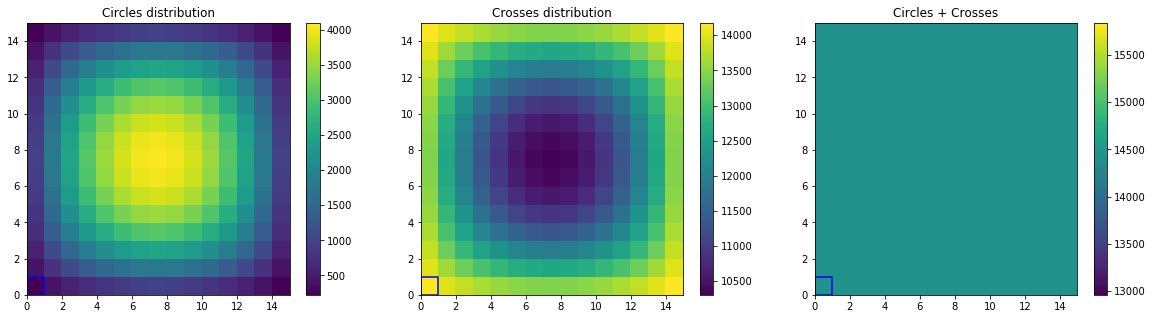

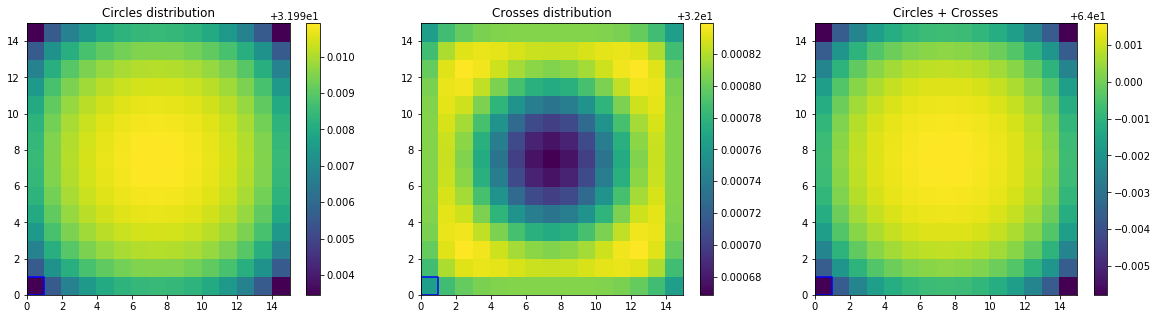

In [52]:

# PLAY AT LOWER RESOLUTION. PRINT INITIAL LIKELIHOOD MATRIX COLLAPSED ACROSS POSSIBLE HYPOTHESIS

grid_size=15
min_size=1

print('Creating M')
t0=time.time()
[M_start,Examples,H_space]=define_hyp_and_examples_space(grid_size,min_size) 
#[M_start,Examples,H_space]=define_hyp_and_examples_space(grid_size,min_size,smooth=['exp',1]) 
t1=time.time()
print('Done in:',t1-t0)
[TL_start,relative_distance,converged]=get_TL_sparse(M_start)

true_hypothesis=(0,1,0,1)
h_idx=H_space.index(true_hypothesis)
samples=[]
circle=[]


plot_trial(H_space[h_idx],samples,circle,grid_size,probability_map=np.array(M_start.sum(axis=1).reshape([len(Examples)*2,1])),separate_in_out=True)  
plot_trial(H_space[h_idx],samples,circle,grid_size,probability_map=np.array(TL_start.sum(axis=1).reshape([len(Examples)*2,1])),separate_in_out=True)  




Creating M
Done in: 3.9575929641723633
Creating TL
Done in: 0.12051796913146973  sec
Memory:  [234.3046875]
Iteration: 0  Time: 0.25189971923828125  Distance: 0.999515086206  marginal-improvement: 0.000484913793847
Iteration: 1  Time: 0.21990489959716797  Distance: 0.691807871751  marginal-improvement: 0.307856498318
Iteration: 2  Time: 0.235306978225708  Distance: 0.170765386217  marginal-improvement: 0.753160677712
Iteration: 3  Time: 0.22121477127075195  Distance: 0.0557881388528  marginal-improvement: 0.673305345488
Iteration: 4  Time: 0.22330713272094727  Distance: 0.0206788112035  marginal-improvement: 0.629333194677
Iteration: 5  Time: 0.21970605850219727  Distance: 0.00803731943961  marginal-improvement: 0.611325846514
Iteration: 6  Time: 0.23052692413330078  Distance: 0.00305048676101  marginal-improvement: 0.620459683862
Iteration: 7  Time: 0.21877503395080566  Distance: 0.00113849994945  marginal-improvement: 0.626780891494
Iteration: 8  Time: 0.21459293365478516  Distance: 

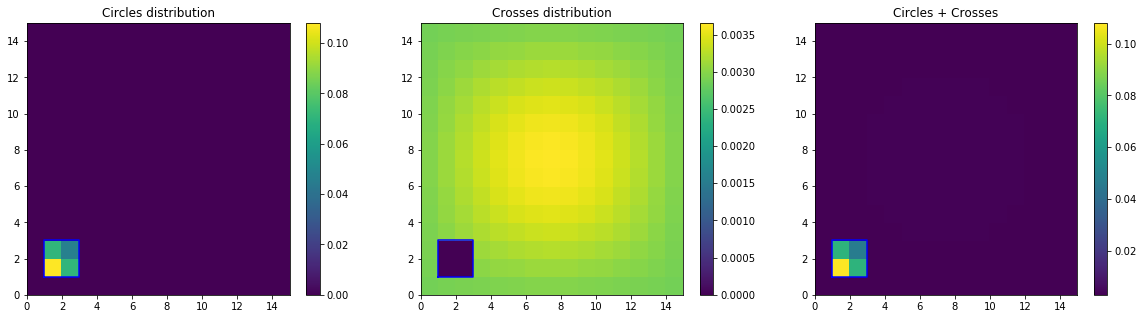

Select new sample in format x,y7,7


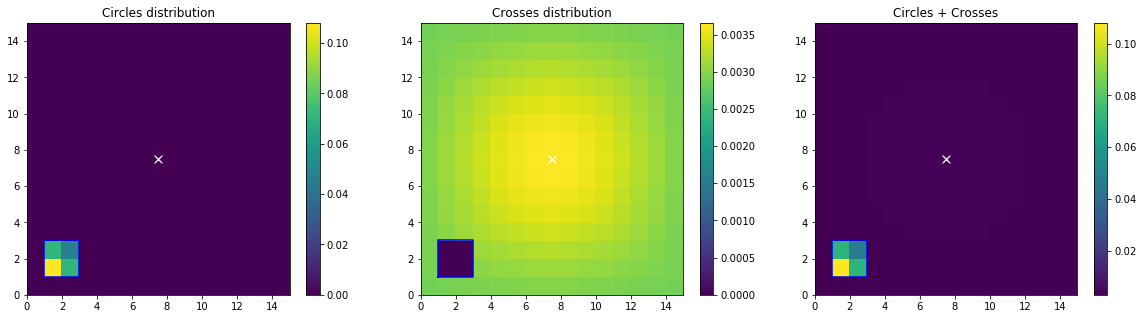

Guess the box in format x_left,x_right,y_bottom,y_top5,7,8,9


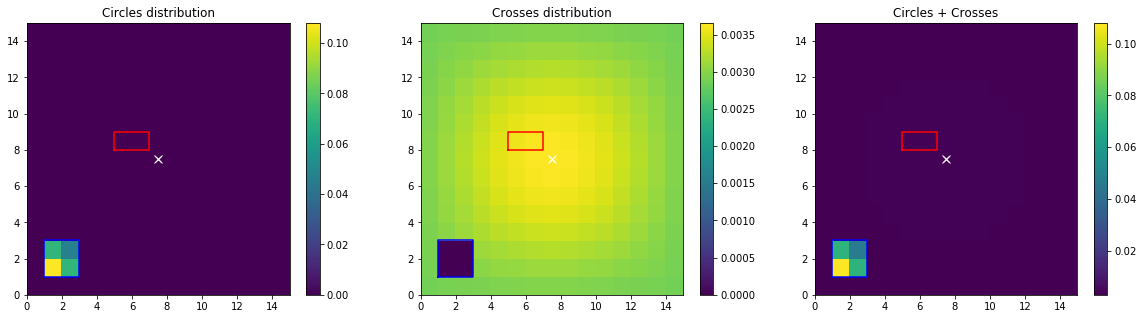

/Users/ariel/anaconda/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Creating TL
Done in: 0.0810997486114502  sec
Memory:  [367.90625]
Iteration: 0  Time: 0.15525197982788086  Distance: 0.999387907332  marginal-improvement: 0.000612092668351
Iteration: 1  Time: 0.16357111930847168  Distance: 0.566322727949  marginal-improvement: 0.433330417754
Iteration: 2  Time: 0.15237927436828613  Distance: 0.133161966536  marginal-improvement: 0.764865579352
Iteration: 3  Time: 0.15978384017944336  Distance: 0.0434710070985  marginal-improvement: 0.673547873846
Iteration: 4  Time: 0.1631789207458496  Distance: 0.0163803404236  marginal-improvement: 0.623189304391
Iteration: 5  Time: 0.1549990177154541  Distance: 0.00605742472043  marginal-improvement: 0.63020153649
Iteration: 6  Time: 0.15531182289123535  Distance: 0.00220915832084  marginal-improvement: 0.635297436979
Iteration: 7  Time: 0.16736912727355957  Distance: 0.000798730612041  marginal-improvement: 0.638445735417
Total SK iteration time: 1.2813901901245117
Non-zeros in M: 2.307872  x 10^6


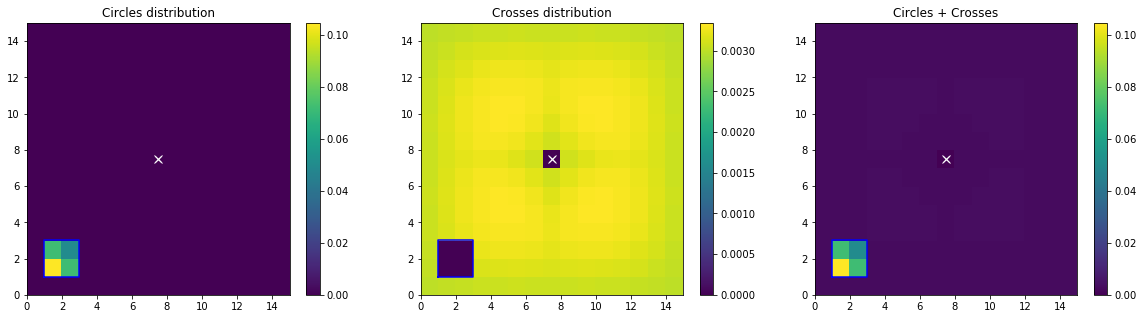

Select new sample in format x,y11,4


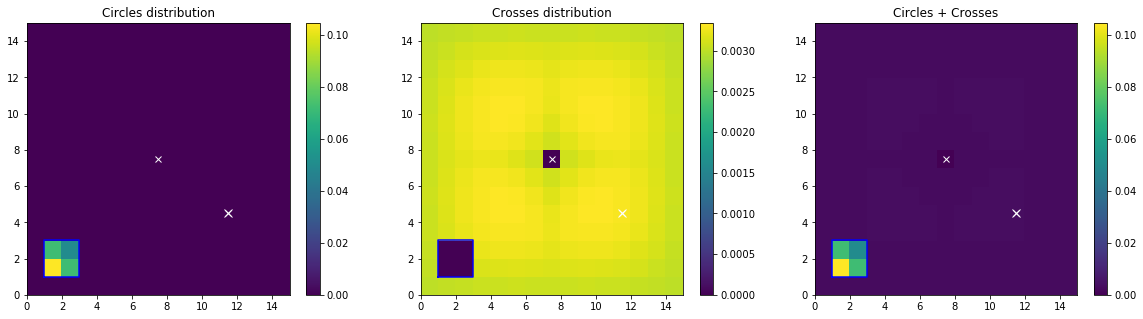

Guess the box in format x_left,x_right,y_bottom,y_top5,7,8,9


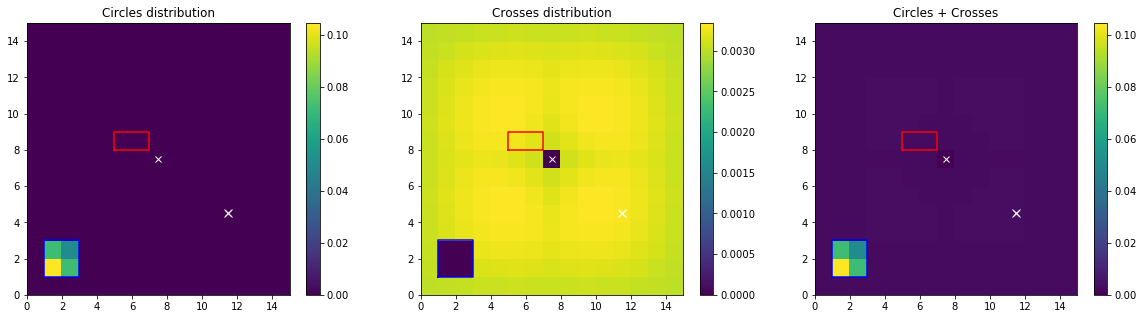

Creating TL
Done in: 0.07311820983886719  sec
Memory:  [384.3046875]
Iteration: 0  Time: 0.1375432014465332  Distance: 0.999383189909  marginal-improvement: 0.000616810091213
Iteration: 1  Time: 0.13785386085510254  Distance: 0.60700258877  marginal-improvement: 0.392622774828
Iteration: 2  Time: 0.13142013549804688  Distance: 0.179642276842  marginal-improvement: 0.704050229496
Iteration: 3  Time: 0.13468384742736816  Distance: 0.0933115409886  marginal-improvement: 0.480570260914
Iteration: 4  Time: 0.14186501502990723  Distance: 0.0528377617089  marginal-improvement: 0.433748910916
Iteration: 5  Time: 0.1369459629058838  Distance: 0.0303949977767  marginal-improvement: 0.424748573867
Iteration: 6  Time: 0.13952875137329102  Distance: 0.0175882216079  marginal-improvement: 0.421344862825
Iteration: 7  Time: 0.1443490982055664  Distance: 0.0102081363425  marginal-improvement: 0.419603836588
Iteration: 8  Time: 0.13783907890319824  Distance: 0.00593676831692  marginal-improvement: 0.41

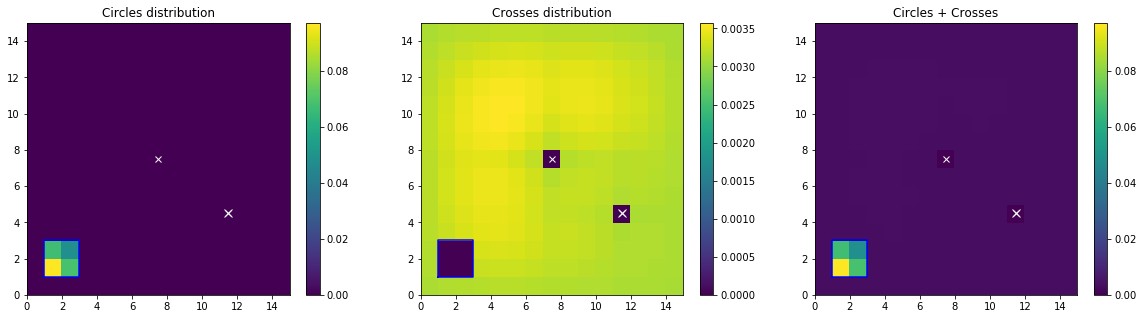

KeyboardInterrupt: 

In [33]:
# PLAY AT LOWER RESOLUTION

grid_size=15
min_size=1

print('Creating M')
t0=time.time()
[M_start,Examples,H_space]=define_hyp_and_examples_space(grid_size,min_size) 
#[M_start,Examples,H_space]=define_hyp_and_examples_space(grid_size,min_size,smooth=['exp',1]) 
t1=time.time()
print('Done in:',t1-t0)
[TL_start,relative_distance,converged]=get_TL_sparse(M_start)

true_hypothesis=(1,3,1,3)
h_idx=H_space.index(true_hypothesis)
samples=[]
circle=[]


#plot_trial(H_space[h_idx],samples,circle,grid_size,probability_map=np.array(TL_start[:,h_idx].todense().reshape([len(Examples)*2,1])),separate_in_out=True)  
#plot_trial(H_space[h_idx],samples,circle,grid_size,probability_map=np.array(M_start[:,h_idx].todense().reshape([len(Examples)*2,1])),separate_in_t=True)


Move_Id_Repeated_sample=[] 
Exceptions=[]



CI=[]
Teachers_entropy=[]
Sample_information=[]
Learners_entropy=[]
Guess_information=[]


M=M_start;
TL=TL_start;

for it in range(5):


    
    plot_trial(H_space[h_idx],samples,circle,grid_size,probability_map=np.array(TL[:,h_idx].todense().reshape([len(Examples)*2,1])),separate_in_out=True)
    
    #plot_trial(H_space[h_idx],samples,circle,grid_size,probability_map=np.array(M[:,h_idx].todense().reshape([len(Examples)*2,1])),separate_in_out=True)
    
    
    s_input= input("Select new sample in format x,y")
    new_sample=tuple(map(int,s_input.split(',')))
    samples.append(new_sample)

    sample_idx=Examples.index(new_sample)
    
    if check_if_inside(new_sample,true_hypothesis):        
        circle.append(True)
    else:
        sample_idx+=grid_size**2
        circle.append(False)
        
    plot_trial(H_space[h_idx],samples,circle,grid_size,probability_map=np.array(TL[:,h_idx].todense().reshape([len(Examples)*2,1])),separate_in_out=True)                         

    #Teachers_entropy.append(-np.sum(np.multiply(TL[:,h_idx].data,np.log(TL[:,h_idx].data))))
    
    #Sample_information.append(-np.log(TL[sample_idx,h_idx]))

    box_input= input("Guess the box in format x_left,x_right,y_bottom,y_top")
    
    new_box=tuple(map(int,box_input.split(',')))
    box_idx=H_space.index(new_box)                                                                                                    

    
    '''
    L=normalize(TL,norm='l1',axis=1)                               
    P_learner=L[sample_idx,:];                
    ci=(TL.multiply(L)).sum()
    L=[]
                    
    CI.append(ci/len(H_space))    
                
    Learners_entropy.append( -np.sum(np.multiply(P_learner.data,np.log(P_learner.data))) )
    Guess_information.append(-np.log(P_learner[0,box_idx]))
    '''
    
    plot_trial(H_space[h_idx],samples,circle,grid_size,probability_map=np.array(TL[:,h_idx].todense().reshape([len(Examples)*2,1])),last_guess=H_space[box_idx],separate_in_out=True)                     

    '''
    if any(TL[sample_idx,:].data): 
        TL=TL.multiply(sparse.csr_matrix(np.ones([M.shape[0],1])) * TL[sample_idx,:])
        TL[sample_idx,:]=0
        TL[:,box_idx]=0
        TL.eliminate_zeros()
        [TL,relative_distance,converged]=get_TL_sparse(TL)
    else:                
        print('Repeated sample: Skipping the Actualization of M and TL')
        Move_Id_Repeated_sample.append(e['move_Id'])
        save_obj(Move_Id_Repeated_sample,'Move_Id_Repeated_sample')    
    
    '''
    
    
    if any(M[sample_idx,:].data): 
        M=M.multiply(sparse.csr_matrix(np.ones([M.shape[0],1])) * M[sample_idx,:].astype(bool))
        M[sample_idx,:]=0
        M[:,box_idx]=0
        M.eliminate_zeros()
        [TL,relative_distance,converged]=get_TL_sparse(M)
    else:                
        print('Repeated sample: Skipping the Actualization of M and TL')
        Move_Id_Repeated_sample.append(e['move_Id'])
        save_obj(Move_Id_Repeated_sample,'Move_Id_Repeated_sample')
    
                
    print('Non-zeros in M:',len(M.data)/1000000,' x 10^6')

    




In [ ]:
point=(3,2)

print('Number of compatible hypothesis',np.sum(TL[Examples.index(point)+grid_size**2,:].astype(bool)))
print('Number of weighted compatible hypothesis',np.sum(TL[Examples.index(point)+grid_size**2,:]))

point=(4,8)

print('Number of compatible hypothesis',np.sum(TL[Examples.index(point)+grid_size**2,:].astype(bool)))
print('Number of weighted compatible hypothesis',np.sum(M_start[Examples.index(point)+grid_size**2,:]))



Load Grid Spaces for SK-iteration process

In [4]:
grid_size=30
min_size=1
t0=time.time()
M_start = sparse.load_npz('../Model_results/Grid_spaces/sparse_M_grid_'+str(grid_size)+'_min_box'+str(min_size)+'_smooth_exp_1.npz')
t1=time.time()
print('Time to load M:',t1-t0)
#H_space=load_obj('../Model_results/Grid_spaces/H_space_grid_'+str(grid_size )+'_min_box'+str(min_size))
#Examples=load_obj('../Model_results/Grid_spaces/Examples_grid_'+str(grid_size ))

print('Time to load TL:',t1-t0)
#[TL_start,relative_distance,converged]=get_TL_sparse(M_start)



Time to load M: 6.498920917510986
Time to load TL: 6.498920917510986


In [ ]:
#  HOW IS THE ENTROPY AND CI OF THE LEARNER/TEACHER REDUCED AFTER EACH MOVE
n6=0
n4=0
n2=0
for d in Data_discretized:
    if d['Level']==6:
        n6+=1
    elif d['Level']==4:
        n4+=1
    elif d['Level']==2:
        n2+=1

Teachers_entropy_6=np.zeros([n6,6])
Teachers_entropy_4=np.zeros([n4,6])
Teachers_entropy_2=np.zeros([n2,6])

Learners_entropy_6=np.zeros([n6,6])
Learners_entropy_4=np.zeros([n4,6])
Learners_entropy_2=np.zeros([n2,6])

CI_6=np.zeros([n6,6])
CI_4=np.zeros([n4,6])
CI_2=np.zeros([n2,6])


i6=-1
i4=-1
i2=-1


T_start=TL_start;
L_start=normalize(T_start,norm='l1',axis=1)
ci_start=(T_start.multiply(L_start)).sum()/T_start.shape[1]

for d in Data_discretized:

    trial_Ht=np.zeros([len(d['Trials']),6])
    trial_Hl=np.zeros([len(d['Trials']),6])
    trial_Hl[:,0]=np.log(len(H_space))
    
    trial_CI=np.zeros([len(d['Trials']),6])
    trial_CI[:,0]=np.log(ci_start)
    
    it=-1
    for t in d['Trials']:
        it+=1
        h_idx=H_space.index(tuple(t['Teachers_box']))
        trial_Ht[it,0]=-np.sum(np.multiply(T_start[:,h_idx].data,np.log(T_start[:,h_idx].data)))
        
        if 'CI' in t.keys():
            ci=np.log(t['CI_reducing_H'])
            trial_CI[it,0:len(ci)]=ci
                
        for i in range(0,len(t['Examples'])):                                    
            if ('P_teacher' in t['Examples'][i].keys()) and ('P_learner' in t['Learners_guess'][i].keys()):
                Pt=t['Examples'][i]['P_teacher']
                Pl=t['Learners_guess'][i]['P_learner']            
                Ht=-np.sum(np.multiply(Pt.data,np.log(Pt.data)))
                Hl=-np.sum(np.multiply(Pl.data,np.log(Pl.data)))
                trial_Ht[it,i+1]=Ht
                trial_Hl[it,i+1]=Hl
    
    mn_Ht_across_trials=np.sum(trial_Ht,axis=0)/np.sum(trial_Ht!=0,axis=0)
    mn_Hl_across_trials=np.sum(trial_Hl,axis=0)/np.sum(trial_Hl!=0,axis=0)
    mn_CI_across_trials=np.sum(trial_CI,axis=0)/np.sum(trial_CI!=0,axis=0)
    
    
    if d['Level']==6:
        i6+=1
        Teachers_entropy_6[i6,:]=mn_Ht_across_trials
        Learners_entropy_6[i6,:]=mn_Hl_across_trials
        CI_6[i6,:]=mn_CI_across_trials
    elif d['Level']==4:
        i4+=1
        Teachers_entropy_4[i4,:]=mn_Ht_across_trials
        Learners_entropy_4[i4,:]=mn_Hl_across_trials        
        CI_4[i4,:]=mn_CI_across_trials
    elif d['Level']==2:
        i2+=1
        Teachers_entropy_2[i2,:]=mn_Ht_across_trials
        Learners_entropy_2[i2,:]=mn_Hl_across_trials
        CI_2[i2,:]=mn_CI_across_trials


mn,ste=get_mean_and_error_across_subjects(Learners_entropy_6)
axis=np.linspace(1,len(mn),len(mn))
plt.plot(axis, mn, 'b')
plt.fill_between(axis,mn-ste, mn+ste,alpha=0.5, edgecolor='b', facecolor='b')

mn,ste=get_mean_and_error_across_subjects(Learners_entropy_4)
axis=np.linspace(1,len(mn),len(mn))
plt.plot(axis, mn, 'r')
plt.fill_between(axis,mn-ste, mn+ste,alpha=0.5, edgecolor='r', facecolor='r')

mn,ste=get_mean_and_error_across_subjects(Learners_entropy_2)
axis=np.linspace(1,len(mn),len(mn))
plt.plot(axis, mn, 'g')
plt.fill_between(axis,mn-ste, mn+ste,alpha=0.5, edgecolor='g', facecolor='g')
plt.xlabel('Number of samples',fontsize=15)
plt.ylabel('Entropy of Learners posterior',fontsize=15)
plt.show()

mn,ste=get_mean_and_error_across_subjects(Teachers_entropy_6)
axis=np.linspace(1,len(mn),len(mn))
plt.plot(axis, mn, 'b')
plt.fill_between(axis,mn-ste, mn+ste,alpha=0.5, edgecolor='b', facecolor='b')

mn,ste=get_mean_and_error_across_subjects(Teachers_entropy_4)
axis=np.linspace(1,len(mn),len(mn))
plt.plot(axis, mn, 'r')
plt.fill_between(axis,mn-ste, mn+ste,alpha=0.5, edgecolor='r', facecolor='r')

mn,ste=get_mean_and_error_across_subjects(Teachers_entropy_2)
axis=np.linspace(1,len(mn),len(mn))
plt.plot(axis, mn, 'g')
plt.fill_between(axis,mn-ste, mn+ste,alpha=0.5, edgecolor='g', facecolor='g')
plt.xlabel('Number of samples',fontsize=15)
plt.ylabel('Entropy of Teachers posterior',fontsize=15)
plt.legend(['6th grade','4th grade','2nd grade'])

plt.show()



mn,ste=get_mean_and_error_across_subjects(CI_6)
axis=np.linspace(1,len(mn),len(mn))
plt.plot(axis, mn, 'b')
plt.fill_between(axis,mn-ste, mn+ste,alpha=0.5, edgecolor='b', facecolor='b')

mn,ste=get_mean_and_error_across_subjects(CI_4)
axis=np.linspace(1,len(mn),len(mn))
plt.plot(axis, mn, 'r')
plt.fill_between(axis,mn-ste, mn+ste,alpha=0.5, edgecolor='r', facecolor='r')

mn,ste=get_mean_and_error_across_subjects(CI_2)
axis=np.linspace(1,len(mn),len(mn))
plt.plot(axis, mn, 'g')
plt.fill_between(axis,mn-ste, mn+ste,alpha=0.5, edgecolor='g', facecolor='g')
plt.xlabel('Number of samples',fontsize=15)
plt.ylabel('CI',fontsize=15)
plt.legend(['6th grade','4th grade','2nd grade'])

plt.show()



plt.plot(Learners_entropy_6.transpose())
plt.ylim([4,13])
plt.show()

plt.plot(Learners_entropy_4.transpose())
plt.ylim([4,13])
plt.show()
    
plt.plot(Learners_entropy_2.transpose())
plt.ylim([4,13])
plt.show()    

print('Teachers Entropy')

plt.plot(Teachers_entropy_6.transpose())
plt.ylim([4,7])
plt.show()

plt.plot(Teachers_entropy_4.transpose())
plt.ylim([4,7])
plt.show()
    
plt.plot(Teachers_entropy_2.transpose())
plt.ylim([4,7])
plt.show()    
    




In [49]:
# LOOK AT SOME RESULTS
plt.clf()

# ANALYZE PAIRS FROM DIFFERENT LEVELS
levels=[]
l2=[]
l4=[]
l6=[]

i=-1
for d in Data_discretized:
    levels.append(d['Level'])
    i+=1
    if d['Level']==2:
        l2.append(i)
    elif d['Level']==4:
        l4.append(i)
    elif d['Level']==6:
        l6.append(i)
        
Pair_idx=[]
for i in range(len(levels)):
    if any(l2):
        Pair_idx.append(l2[0])
        l2.remove(l2[0])
    if any(l4):
        Pair_idx.append(l4[0])
        l4.remove(l4[0])
    if any(l6):
        Pair_idx.append(l6[0])
        l6.remove(l6[0])

###############################################################3
board_size=30


CI_won=[]
CI_lost=[]
CI_won_level=[]
CI_lost_level=[]


SI_6=[] # Sample information (-logL) per sample
SI_4=[]
SI_2=[]

mnSL_6=[] # mean sample likelihood per trial
mnSL_4=[]
mnSL_2=[]

mnGL_6=[] # mean guessed likelihood per trial
mnGL_4=[]
mnGL_2=[]


mnSL_per_subject_6=[]          # mean sample likelihood per trial, per subject
mnSL_per_subject_4=[]
mnSL_per_subject_2=[]

mnGL_per_subject_6=[]          # mean sample likelihood per trial, per subject
mnGL_per_subject_4=[]
mnGL_per_subject_2=[]


n_trials_6=[] # number of trials completed
n_trials_4=[]
n_trials_2=[]

levels=[]
Ids=[]

Teacher_entropy_6=[]
Teacher_entropy_4=[]
Teacher_entropy_2=[]

plt.clf()

mean_likelihood_per_trial=[]


Trial_idx=[]
Pair_Id=[]
t=-1

Data_discretized=Data_discretized_shafto
H_space=H_space_shafto

for i_pair in Pair_idx:
    
    d=Data_discretized[i_pair]              
    
    new_subject=True
    
    if d['Level']==6:
        n_trials_6.append(len(d['Trials']))
    elif d['Level']==4:
        n_trials_4.append(len(d['Trials']))
    elif d['Level']==2:
        n_trials_2.append(len(d['Trials']))
                
    for trial in d['Trials']:        
        t+=1
    #    print('###### NEW TRIAL ##########')
        if 'CI' in trial.keys():
    
            if trial['won']:
                CI_won.append(trial['CI'][-1])
                CI_won_level.append(d['Level'])
            else:
                CI_lost.append(trial['CI'][-1])
                CI_lost_level.append(d['Level'])


            h_idx=H_space.index(tuple(trial['Teachers_box']))
            samples=[]
            circle=[]

            aux=0       
            n=0
            for item in trial['Sample_information']:
                if np.abs(item) != np.inf:    
                    n+=1
                    aux+=-item


            mean_likelihood_per_trial.append(aux/n)






            Trial_idx.append(t)
            Pair_Id.append(d['Teachers_Id'])

            if d['Level']==6:
                aux=0    
                nt=0
                for item in trial['Sample_information']:
                    if item !=np.inf:
                        nt+=1
                        aux-=item                
                        SI_6.append(item)                
                mnSL_6.append(aux/nt)

                aux=0    
                nt=0
                for item in trial['Guess_information']:
                    if item !=np.inf:
                        nt+=1
                        aux-=item
                mnGL_6.append(aux/nt)                                    

                if new_subject:
                    mnSL_per_subject_6.append(mnSL_6[-1])          # mean sample likelihood per trial, per subject
                    mnGL_per_subject_6.append(mnGL_6[-1])          # mean sample likelihood per trial, per subject                
                else:
                    mnSL_per_subject_6[-1]+=mnSL_6[-1]                                                                    
                    mnGL_per_subject_6[-1]+=mnGL_6[-1]                                                                    

                for item in trial['Teachers_entropy']:
                    Teacher_entropy_6.append(item)            

            elif d['Level']==4:
                aux=0    
                nt=0
                for item in trial['Sample_information']:
                    if item !=np.inf:
                        nt+=1
                        aux-=item                
                        SI_4.append(item)                
                mnSL_4.append(aux/nt)


                aux=0    
                nt=0
                for item in trial['Guess_information']:
                    if item !=np.inf:
                        nt+=1
                        aux-=item
                mnGL_4.append(aux/nt)                                    

                if new_subject:
                    mnSL_per_subject_4.append(mnSL_4[-1])          # mean sample likelihood per trial, per subject
                    mnGL_per_subject_4.append(mnGL_4[-1])          # mean sample likelihood per trial, per subject                
                else:
                    mnSL_per_subject_4[-1]+=mnSL_4[-1]                                                                    
                    mnGL_per_subject_4[-1]+=mnGL_4[-1]                  


                for item in trial['Teachers_entropy']:
                    Teacher_entropy_4.append(item)            

            elif d['Level']==2:
                aux=0    
                nt=0
                for item in trial['Sample_information']:
                    if item !=np.inf:
                        nt+=1
                        aux-=item                
                        SI_2.append(item)                
                mnSL_2.append(aux/nt)                        

                aux=0    
                nt=0
                for item in trial['Guess_information']:                                
                    if item !=np.inf:
                        nt+=1
                        aux-=item                    
                if nt!=0:                
                    mnGL_2.append(aux/nt)                               



                if new_subject:
                    mnSL_per_subject_2.append(mnSL_2[-1])          # mean sample likelihood per trial, per subject
                    if nt!=0:
                        mnGL_per_subject_2.append(mnGL_2[-1])                                     
                else:
                    mnSL_per_subject_2[-1]+=mnSL_2[-1]            
                    if nt!=0:
                        mnGL_per_subject_2[-1]+=mnGL_2[-1]                                  


                for item in trial['Teachers_entropy']:
                    Teacher_entropy_2.append(item)            




            new_subject=False


            samples=[]
            circle=[]

            
            if mean_likelihood_per_trial[-1]>-4:        

                for j in range(len(trial['Examples'])):                        
                    example=trial['Examples'][j]
                    guess=trial['Learners_guess'][j]
                    if 'P_teacher' in example.keys():

                        print('###### PAIR ID:',d['Teachers_Id'],'##########')
                        print('###### Level:',d['Level'],'###########')                    

                        guess=trial['Learners_guess'][j]
                        samples.append((example['x'],example['y']))
                        if example['inside']=='true':
                            circle.append(True)
                        else:
                            circle.append(False)        
                        #filename='move_'+str(example['move_Id'])
                        plot_trial(H_space[h_idx],samples,circle,grid_size,probability_map=np.array(example['P_teacher'].todense().reshape([len(Examples)*2,1])),separate_in_out=True,last_guess=guess['box'])

                print('Won:',trial['won'])
                print('Mean likelihood per trial:', mean_likelihood_per_trial[-1])
                print('CI:',trial['CI'][-1])
                    
    '''
    if d['Level']==6:
        mnSL_per_subject_6[-1]= mnSL_per_subject_6[-1]/len(d['Trials'])
        mnGL_per_subject_6[-1]= mnGL_per_subject_6[-1]/len(d['Trials'])
    elif d['Level']==4:
        mnSL_per_subject_4[-1]= mnSL_per_subject_4[-1]/len(d['Trials'])
        mnGL_per_subject_4[-1]= mnGL_per_subject_4[-1]/len(d['Trials'])
    elif d['Level']==2:
        mnSL_per_subject_2[-1]= mnSL_per_subject_2[-1]/len(d['Trials'])
        mnGL_per_subject_2[-1]= mnGL_per_subject_2[-1]/len(d['Trials'])
    '''    
       
    

In [45]:
for d in Data_discretized_shafto:
    
    

[(0, 1, 0, 1),
 (0, 1, 0, 2),
 (0, 1, 0, 3),
 (0, 1, 0, 4),
 (0, 1, 0, 5),
 (0, 1, 0, 6),
 (0, 1, 0, 7),
 (0, 1, 0, 8),
 (0, 1, 0, 9),
 (0, 1, 0, 10),
 (0, 1, 0, 11),
 (0, 1, 0, 12),
 (0, 1, 0, 13),
 (0, 1, 0, 14),
 (0, 1, 0, 15),
 (0, 1, 0, 16),
 (0, 1, 0, 17),
 (0, 1, 0, 18),
 (0, 1, 0, 19),
 (0, 1, 0, 20),
 (0, 1, 0, 21),
 (0, 1, 0, 22),
 (0, 1, 0, 23),
 (0, 1, 0, 24),
 (0, 1, 0, 25),
 (0, 1, 0, 26),
 (0, 1, 0, 27),
 (0, 1, 0, 28),
 (0, 1, 0, 29),
 (0, 1, 0, 30),
 (0, 2, 0, 1),
 (0, 2, 0, 2),
 (0, 2, 0, 3),
 (0, 2, 0, 4),
 (0, 2, 0, 5),
 (0, 2, 0, 6),
 (0, 2, 0, 7),
 (0, 2, 0, 8),
 (0, 2, 0, 9),
 (0, 2, 0, 10),
 (0, 2, 0, 11),
 (0, 2, 0, 12),
 (0, 2, 0, 13),
 (0, 2, 0, 14),
 (0, 2, 0, 15),
 (0, 2, 0, 16),
 (0, 2, 0, 17),
 (0, 2, 0, 18),
 (0, 2, 0, 19),
 (0, 2, 0, 20),
 (0, 2, 0, 21),
 (0, 2, 0, 22),
 (0, 2, 0, 23),
 (0, 2, 0, 24),
 (0, 2, 0, 25),
 (0, 2, 0, 26),
 (0, 2, 0, 27),
 (0, 2, 0, 28),
 (0, 2, 0, 29),
 (0, 2, 0, 30),
 (0, 3, 0, 1),
 (0, 3, 0, 2),
 (0, 3, 0, 3),
 (0, 3, 0, 4)

In [40]:
mean_likelihood_per_trial

[]

In [ ]:
GI=[]

for d in Data_discretized:
    if d['Level']==2:
        for t in d['Trials']:
            for item in t['Guess_information']:
                GI.append(item)

In [ ]:
GI=np.array(GI)
GI=np.delete(GI,np.argwhere(GI==np.inf) )

In [ ]:
np.min(mnGL_2)

In [ ]:
CI_won=np.log(np.array(CI_won))
CI_lost=np.log(np.array(CI_lost))

CI_won_level=np.array(CI_won_level)
CI_lost_level=np.array(CI_lost_level)

In [ ]:
L_start=normalize(TL_start,norm='l1',axis=1)                                               
ci=(TL_start.multiply(L_start)).sum()
ci=ci/TL_start.shape[1]
ci_start=ci

In [ ]:
ci_start=np.log(ci)

In [ ]:
np.min(mnGL_2)

In [ ]:

fig=plt.figure()
plt.hist(CI_won[np.argwhere(CI_won_level==6)],color='k',bins=np.int(np.round(np.sqrt(np.sum(CI_won_level==6)))))
plt.plot([ci_start,ci_start],[0,65],'--r')
plt.xlim([-13,-8])
plt.xlabel('log Cooperation Index',fontsize=15)
plt.ylabel('Won Trials',fontsize=15)
plt.title('Level 6',fontsize=15)
plt.show()
fig.savefig('Cooperation_Index_won_trials_6.png')



fig=plt.figure()
plt.hist(CI_won[np.argwhere(CI_won_level==4)],color='k',bins=np.int(np.round(np.sqrt(np.sum(CI_won_level==4)))))
plt.plot([ci_start,ci_start],[0,80],'--r')
plt.xlim([-13,-8])
plt.title('Level 4',fontsize=15)
plt.xlabel('log Cooperation Index',fontsize=15)
plt.ylabel('Won Trials',fontsize=15)
plt.show()
fig.savefig('Cooperation_Index_won_trials_4.png')

fig=plt.figure()
plt.hist(CI_won[np.argwhere(CI_won_level==2)],color='k',bins=np.int(np.round(np.sqrt(np.sum(CI_won_level==2)))))
plt.plot([ci_start,ci_start],[0,12],'--r')
plt.xlim([-13,-8])
plt.title('Level 2',fontsize=15)
plt.xlabel('log Cooperation Index',fontsize=15)
plt.ylabel('Won Trials',fontsize=15)
plt.show()
fig.savefig('Cooperation_Index_won_trials_2.png')


print('###################')

fig=plt.figure()
plt.hist(CI_lost[np.argwhere(CI_lost_level==6)],color='k',bins=np.int(np.round(np.sqrt(np.sum(CI_lost_level==6)))))
plt.plot([ci_start,ci_start],[0,15],'--r')
plt.xlim([-13,-8])
plt.xlabel('log Cooperation Index',fontsize=15)
plt.ylabel('Lost Trials',fontsize=15)
plt.title('Level 6',fontsize=15)
plt.show()
#fig.savefig('Cooperation_Index_lost_trials_6.png')

fig=plt.figure()
plt.hist(CI_lost[np.argwhere(CI_lost_level==4)],color='k',bins=np.int(np.round(np.sqrt(np.sum(CI_lost_level==4)))))
plt.plot([ci_start,ci_start],[0,30],'--r')
plt.xlim([-13,-8])
plt.title('Level 4',fontsize=15)
plt.xlabel('log Cooperation Index',fontsize=15)
plt.ylabel('Lost Trials',fontsize=15)
plt.show()
#fig.savefig('Cooperation_Index_lost_trials_4.png')



fig=plt.figure()
plt.hist(CI_lost[np.argwhere(CI_lost_level==2)],color='k',bins=np.int(np.round(np.sqrt(np.sum(CI_lost_level==2)))))
plt.plot([ci_start,ci_start],[0,30],'--r')
plt.xlim([-13,-8])
plt.title('Level 2',fontsize=15)
plt.xlabel('log Cooperation Index',fontsize=15)
plt.ylabel('Lost Trials',fontsize=15)
plt.show()
#fig.savefig('Cooperation_Index_lost_trials_2.png')





In [ ]:
np.sqrt(18)

In [ ]:

plt.clf()
plt.hist(np.log(np.array(CI_won)))
plt.xlim([-13,-7])
plt.show()

plt.clf()
plt.hist(np.log(np.array(CI_lost)))
plt.xlim([-13,-7])
plt.show()

plt.clf()
plt.hist(np.log(np.array(CI_won)[np.argwhere]))
plt.xlim([-13,-7])
plt.show()

plt.clf()
plt.hist(np.log(np.array(CI_lost)))
plt.xlim([-13,-7])
plt.show()





In [ ]:
fig=plt.figure()
plt.hist(mnSL_per_subject_6,color='k')
plt.plot([-np.log(grid_size**2),-np.log(grid_size**2)],[0,4],'--r')
plt.xlim([-8,-5])
plt.ylabel('Couples')
plt.xlabel('Mean sample log-likelihood per couple')
plt.show()
#fig.savefig('mnSL_per_subject_6.png')

fig=plt.figure()
plt.hist(mnSL_per_subject_4,color='k')
plt.plot([-np.log(grid_size**2),-np.log(grid_size**2)],[0,8],'--r')
plt.xlim([-8,-5])
plt.ylabel('Couples')
plt.xlabel('Mean sample log-likelihood per couple')
plt.show()
#fig.savefig('mnSL_per_subject_4.png')

fig=plt.figure()
plt.hist(mnSL_per_subject_2,color='k')
plt.plot([-np.log(grid_size**2),-np.log(grid_size**2)],[0,6],'--r')
plt.xlim([-8,-5])
plt.ylabel('Couples')
plt.xlabel('Mean sample log-likelihood per couple')
plt.show()
#fig.savefig('mnSL_per_subject_2.png')

In [ ]:
fig=plt.figure()
plt.hist(mnGL_per_subject_6,color='k')
plt.plot([-np.log(len(H_space)),-np.log(len(H_space))],[0,7],'--r')
plt.xlim([-13,-8])
plt.ylabel('Couples')
plt.xlabel('Mean guess log-likelihood per couple')
plt.show()
fig.savefig('mnGL_per_subject_6.png')

fig=plt.figure()
plt.hist(mnGL_per_subject_4,color='k')
plt.plot([-np.log(len(H_space)),-np.log(len(H_space))],[0,8],'--r')
plt.xlim([-13,-8])
plt.ylabel('Couples')
plt.xlabel('Mean sample log-likelihood per couple')
plt.show()
fig.savefig('mnGL_per_subject_4.png')


fig=plt.figure()
plt.hist(mnGL_per_subject_2,color='k')
plt.plot([-np.log(len(H_space)),-np.log(len(H_space))],[0,5],'--r')
plt.xlim([-13,-8])
plt.ylabel('Couples')
plt.xlabel('Mean sample log-likelihood per couple')
plt.show()
fig.savefig('mnGL_per_subject_2.png')

In [ ]:
mnGL_per_subject_2

In [ ]:
# Mean sample likelihood per trial

mnSL_2=np.array(mnSL_2)
mnSL_4=np.array(mnSL_4)
mnSL_6=np.array(mnSL_6)
        
mnSL_2=np.delete(mnSL_2 ,np.argwhere(mnSL_2==-np.inf)   )
mnSL_4=np.delete(mnSL_4 ,np.argwhere(mnSL_4==-np.inf)   )
mnSL_6=np.delete(mnSL_6 ,np.argwhere(mnSL_6==-np.inf)   )

    
data=mnSL_6    
fig=plt.figure()
plt.hist(data,color='k',bins=np.int(np.round(np.sqrt(len(data)))))
plt.plot([-np.log(grid_size**2),-np.log(grid_size**2)],[0,70],'--r')
plt.title('Level: 6')
plt.xlim([-10,-4])
plt.ylabel('Trials')
plt.xlabel('Mean sample log-likelihood per trial')
plt.show()
#fig.savefig('Mn_logL_per_trial_6.png')

data=mnSL_4    
fig=plt.figure()
plt.hist(data,color='k',bins=np.int(np.round(np.sqrt(len(data)))))
plt.plot([-np.log(grid_size**2),-np.log(grid_size**2)],[0,50],'--r')
plt.title('Level: 4')
plt.xlim([-10,-4])
plt.xlabel('Mean sample log-likelihood per trial')
plt.ylabel('Trials')
plt.show()
#fig.savefig('Mn_logL_per_trial_4.png')


data=mnSL_2    
fig=plt.figure()
plt.hist(data,color='k',bins=np.int(np.round(np.sqrt(len(data)))))
plt.plot([-np.log(grid_size**2),-np.log(grid_size**2)],[0,30],'--r')
plt.title('Level: 2')
plt.xlim([-10,-4])
plt.ylabel('Trials')
plt.xlabel('Mean sample log-likelihood per trial')
plt.show()
#fig.savefig('Mn_logL_per_trial_2.png')






In [ ]:
# Mean guess likelihood per trial

mnGL_2=np.array(mnGL_2)
mnGL_4=np.array(mnGL_4)
mnGL_6=np.array(mnGL_6)
        
mnGL_2=np.delete(mnGL_2 ,np.argwhere(mnGL_2==-np.inf)   )
mnGL_2=np.delete(mnGL_2 ,np.argwhere(mnGL_2==np.inf)   )
mnGL_4=np.delete(mnGL_4 ,np.argwhere(mnGL_4==-np.inf)   )
mnGL_6=np.delete(mnGL_6 ,np.argwhere(mnGL_6==-np.inf)   )

    
data=mnGL_6    
fig=plt.figure()
plt.hist(data,color='k',bins=np.int(np.round(np.sqrt(len(data)))))
plt.plot([-np.log(len(H_space)),-np.log(len(H_space))],[0,60],'--r')
plt.title('Level: 6')
plt.xlim([-15,-7])
plt.ylabel('Trials')
plt.xlabel('Mean guess log-likelihood per trial')
plt.show()
fig.savefig('Mn_GlogL_per_trial_6.png')

data=mnGL_4    
fig=plt.figure()
plt.hist(data,color='k',bins=np.int(np.round(np.sqrt(len(data)))))
plt.plot([-np.log(len(H_space)),-np.log(len(H_space))],[0,65],'--r')
plt.title('Level: 4')
plt.xlim([-15,-7])
plt.xlabel('Mean guess log-likelihood per trial')
plt.ylabel('Trials')
plt.show()
fig.savefig('Mn_GlogL_per_trial_4.png')


data=mnGL_2    
fig=plt.figure()
plt.hist(data,color='k',bins=np.int(np.round(np.sqrt(len(data)))))
plt.plot([-np.log(len(H_space)),-np.log(len(H_space))],[0,35],'--r')
plt.title('Level: 2')
#plt.xlim([-15,-7])
plt.ylabel('Trials')
plt.xlabel('Mean guess log-likelihood per trial')
plt.show()
fig.savefig('Mn_GlogL_per_trial_2.png')


In [ ]:
n_trials_2

In [ ]:
mnSL_per_subject_6

In [ ]:
idx=np.argsort(mean_likelihood_per_trial)
values=np.sort(mean_likelihood_per_trial)

t=-1
for i_pair in Pair_idx:    
    d=Data_discretized[i_pair]                      
    for trial in d['Trials']:                        
        t+=1
        if t==Trial_idx[idx[0]]:
            last_move=trial['Examples'][-1]['move_Id']
            print('last_move:',trial['Examples'][-1]['move_Id'])
            img=mpimg.imread('Move_figs/min_box_size_1_SK_precision_1e2/Move_'+str(last_move)+'.png')
            imgplot = plt.imshow(img)
            plt.show()
            '''
            samples=[]
            circle=[]
            for j in range(len(trial['Examples'])):                        
                example=trial['Examples'][j]            
                guess=trial['Learners_guess'][j]
                samples.append((example['x'],example['y']))
                if example['inside']=='true':
                    circle.append(True)
                else:
                    circle.append(False)

                plot_trial(trial['Teachers_box'],samples,circle,grid_size,probability_map=np.array(example['P_teacher'].todense().reshape([len(Examples)*2,1])),separate_in_out=True)                                     
            '''



In [ ]:

plt.hist(mean_likelihood_per_trial)
plt.show()



In [ ]:
f, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(15,5))                
ax1.hist(SI_6)
ax2.hist(Teacher_entropy_6)
ax3.hist(SI_6/Teacher_entropy_6)






In [ ]:
n=-3
Pair_Id[idx[n]]==103

In [ ]:
Mean_sample_likelihood=np.array(Mean_sample_likelihood)
levels=np.array(levels)

In [ ]:
Ids=np.array(Ids)
u_id=np.unique(Ids)
mean_sample_likelihood_per_couple=[]
couple_level=[]
for i in u_id:
    locate_id=np.where(Ids==i)
    aux=0
    for pos in locate_id[0]:
        aux+=Mean_sample_likelihood[pos]
    
    mean_sample_likelihood_per_couple.append(aux/len(locate_id[0])) 
    couple_level.append(levels[pos])
    
    

In [ ]:
len(mean_sample_likelihood_per_couple)

In [ ]:
plt.hist(np.array(mean_sample_likelihood_per_couple)[np.array(couple_level)==6])
plt.xlim([-8,-3])
plt.show()

plt.hist(np.array(mean_sample_likelihood_per_couple)[np.array(couple_level)==4])
plt.xlim([-8,-3])
plt.show()

plt.hist(np.array(mean_sample_likelihood_per_couple)[np.array(couple_level)==2])
plt.xlim([-8,-3])
plt.show()



In [ ]:
plt.hist(Mean_sample_likelihood[levels==6])
plt.xlim([-10,-3])
plt.show()

plt.hist(Mean_sample_likelihood[levels==4])
plt.xlim([-10,-3])
plt.show()

plt.hist(Mean_sample_likelihood[levels==2])
plt.xlim([-10,-3])
plt.show()





In [ ]:
level_6=np.array(level_6)
level_4=np.array(level_4)
level_2=np.array(level_2)

level_2=np.delete(level_2,np.argwhere(level_2==np.inf))
level_4=np.delete(level_4,np.argwhere(level_4==np.inf))
level_6=np.delete(level_6,np.argwhere(level_6==np.inf))






In [ ]:
plt.hist(level_2)
plt.show()

plt.clf()

plt.hist(level_4)
plt.show()

plt.clf()
plt.hist(level_6)
plt.show()


In [5]:
# ANALYZE PAIRS FROM DIFFERENT LEVELS
levels=[]
l2=[]
l4=[]
l6=[]

i=-1
for d in Data_discretized:
    levels.append(d['Level'])
    i+=1
    if d['Level']==2:
        l2.append(i)
    elif d['Level']==4:
        l4.append(i)
    elif d['Level']==6:
        l6.append(i)
        
Pair_idx=[]
for i in range(len(levels)):
    if any(l2):
        Pair_idx.append(l2[0])
        l2.remove(l2[0])
    if any(l4):
        Pair_idx.append(l4[0])
        l4.remove(l4[0])
    if any(l6):
        Pair_idx.append(l6[0])
        l6.remove(l6[0])

In [ ]:
total_moves=0
missing=0

for i_pair in Pair_idx:
    
    d=Data_discretized[i_pair]
    
    for trial in d['Trials']:
        
        flag=False
        for e in trial['Examples']:
            total_moves+=1
            if 'P_teacher' not in e.keys():
                missing+=1
                flag=True

In [7]:
print(M_start.shape)
print(len(H_space))


(1800, 216225)
216225


Creating TL
Done in: 9.213134527206421  sec
Memory:  [5564.5234375]
Iteration: 0  Time: 18.573015213012695  Distance: 0.996253373747  marginal-improvement: 0.00374662625256
Iteration: 1  Time: 17.913488626480103  Distance: 0.804522907376  marginal-improvement: 0.192451510252
Iteration: 2  Time: 17.708190202713013  Distance: 0.320709259357  marginal-improvement: 0.601367150125
Iteration: 3  Time: 17.676416635513306  Distance: 0.159146340028  marginal-improvement: 0.503767554617
Iteration: 4  Time: 17.72314167022705  Distance: 0.0864598039528  marginal-improvement: 0.456727663749
Iteration: 5  Time: 17.571723461151123  Distance: 0.0461136139364  marginal-improvement: 0.466646790437
Iteration: 6  Time: 17.92459797859192  Distance: 0.0243272657893  marginal-improvement: 0.472449376386
Iteration: 7  Time: 18.58046841621399  Distance: 0.0127488993382  marginal-improvement: 0.475941955474
Iteration: 8  Time: 18.12853693962097  Distance: 0.00665377422157  marginal-improvement: 0.478090300576
T

/home/ahaimovici/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in log


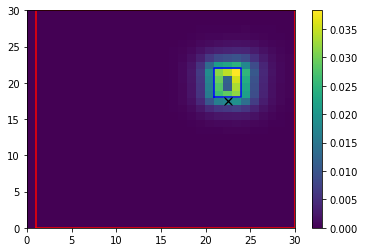

/home/ahaimovici/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Creating TL
Done in: 7.292527914047241  sec
Memory:  [9160.046875]
Iteration: 0  Time: 24.69679880142212  Distance: 0.99673939124  marginal-improvement: 0.00326060875957
Iteration: 1  Time: 14.156136989593506  Distance: 1.30041292534  marginal-improvement: -0.30466693377
Iteration: 2  Time: 14.158744812011719  Distance: 0.634952766846  marginal-improvement: 0.51172988635
Iteration: 3  Time: 14.342474460601807  Distance: 0.384265292009  marginal-improvement: 0.394812792268
Iteration: 4  Time: 14.456363201141357  Distance: 0.256676850437  marginal-improvement: 0.332032177315
Iteration: 5  Time: 14.287184715270996  Distance: 0.182035598881  marginal-improvement: 0.290798532975
Iteration: 6  Time: 14.883273124694824  Distance: 0.134909835424  marginal-improvement: 0.258882129358
Iteration: 7  Time: 13.975965976715088  Distance: 0.105554788816  marginal-improvement: 0.217590115023
Iteration: 8  Time: 14.037248134613037  Distance: 0.0833438446339  marginal-improvement: 0.210420999667
Iterati

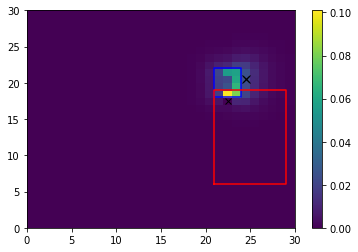

Creating TL
Done in: 6.776552677154541  sec
Memory:  [8654.65625]
Iteration: 0  Time: 13.207285642623901  Distance: 0.99721434191  marginal-improvement: 0.00278565809038
Iteration: 1  Time: 13.17233920097351  Distance: 1.75735147704  marginal-improvement: -0.762260532349
Iteration: 2  Time: 13.214623212814331  Distance: 0.936545880518  marginal-improvement: 0.467069682557
Iteration: 3  Time: 13.297628402709961  Distance: 0.616693391033  marginal-improvement: 0.341523566691
Iteration: 4  Time: 13.247608184814453  Distance: 0.445189221001  marginal-improvement: 0.278102818233
Iteration: 5  Time: 13.209858179092407  Distance: 0.339466165596  marginal-improvement: 0.237478920014
Iteration: 6  Time: 13.25311827659607  Distance: 0.268059049562  marginal-improvement: 0.210351202184
Iteration: 7  Time: 13.20041298866272  Distance: 0.216509784848  marginal-improvement: 0.192305631161
Iteration: 8  Time: 13.276663780212402  Distance: 0.177249728311  marginal-improvement: 0.181331557667
Iteration

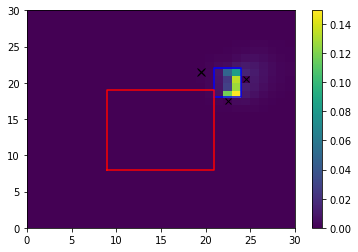

Creating TL
Done in: 6.074611186981201  sec
Memory:  [8287.1875]
Iteration: 0  Time: 11.865118741989136  Distance: 0.997176790259  marginal-improvement: 0.00282320974069
Iteration: 1  Time: 11.980575561523438  Distance: 2.01485132983  marginal-improvement: -1.0205557826
Iteration: 2  Time: 11.884140491485596  Distance: 1.14116706842  marginal-improvement: 0.433622197566
Iteration: 3  Time: 12.003729820251465  Distance: 0.796829517002  marginal-improvement: 0.301741577501
Iteration: 4  Time: 11.938791751861572  Distance: 0.608198416416  marginal-improvement: 0.23672704959
Iteration: 5  Time: 11.940772771835327  Distance: 0.488095490023  marginal-improvement: 0.197473263907
Iteration: 6  Time: 11.953967094421387  Distance: 0.404293946615  marginal-improvement: 0.171690878366
Iteration: 7  Time: 11.920295476913452  Distance: 0.341576177412  marginal-improvement: 0.155129132474
Iteration: 8  Time: 11.894661664962769  Distance: 0.292500437174  marginal-improvement: 0.143674364559
Iteration:

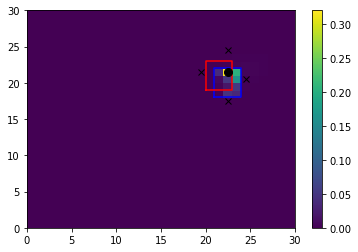

Creating TL
Done in: 0.004965543746948242  sec
Memory:  [5033.54296875]
Iteration: 0  Time: 0.022992372512817383  Distance: 14323780974.9  marginal-improvement: -14323780973.9
Iteration: 1  Time: 0.01754283905029297  Distance: 1.74747977563  marginal-improvement: 0.999999999878
Iteration: 2  Time: 0.012931108474731445  Distance: 0.127852391938  marginal-improvement: 0.926836124961
Iteration: 3  Time: 0.012908697128295898  Distance: 0.0388423011685  marginal-improvement: 0.696194176897
Iteration: 4  Time: 0.012948274612426758  Distance: 0.0140896177006  marginal-improvement: 0.637260994411
Iteration: 5  Time: 0.013043642044067383  Distance: 0.0050554892738  marginal-improvement: 0.641190458023
Total SK iteration time: 0.0955815315246582
Non-zeros in M: 0.337792  x 10^6
Memory after updating: [3472.26171875]
###########################################
############### NEW TRIAL #################
###########################################
True hypothesis: (19, 24, 20, 25)
FALTAN: 5 Exampl

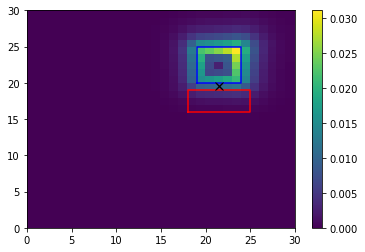

Creating TL
Done in: 7.196930885314941  sec
Memory:  [9646.87890625]
Iteration: 0  Time: 13.949574708938599  Distance: 0.996538401489  marginal-improvement: 0.00346159851144
Iteration: 1  Time: 13.820740461349487  Distance: 1.42867502181  marginal-improvement: -0.433637699935
Iteration: 2  Time: 13.968015432357788  Distance: 0.707616391006  marginal-improvement: 0.504704442785
Iteration: 3  Time: 13.773335456848145  Distance: 0.436841254258  marginal-improvement: 0.382658090159
Iteration: 4  Time: 13.917435884475708  Distance: 0.297361877945  marginal-improvement: 0.319290760554
Iteration: 5  Time: 13.82650351524353  Distance: 0.214514635877  marginal-improvement: 0.27860747531
Iteration: 6  Time: 13.859010457992554  Distance: 0.160835336169  marginal-improvement: 0.250236071253
Iteration: 7  Time: 13.82023310661316  Distance: 0.123883770047  marginal-improvement: 0.229747809173
Iteration: 8  Time: 13.76079535484314  Distance: 0.0993884058603  marginal-improvement: 0.197728598161
Itera

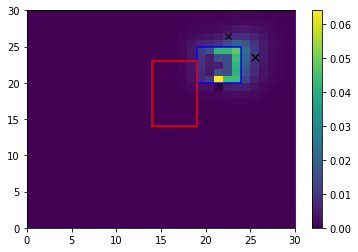

Creating TL
Done in: 6.750399589538574  sec
Memory:  [9067.5859375]
Iteration: 0  Time: 13.130207300186157  Distance: 1.67407555772  marginal-improvement: -0.674075557725
Iteration: 1  Time: 13.096635580062866  Distance: 2.35607168825  marginal-improvement: -0.407386708074
Iteration: 2  Time: 13.31113600730896  Distance: 1.29534411266  marginal-improvement: 0.450210229547
Iteration: 3  Time: 13.191131353378296  Distance: 0.872114663353  marginal-improvement: 0.326731287206
Iteration: 4  Time: 13.258639097213745  Distance: 0.641415674046  marginal-improvement: 0.264528277073
Iteration: 5  Time: 13.15055775642395  Distance: 0.496597545404  marginal-improvement: 0.225778905166
Iteration: 6  Time: 13.26549744606018  Distance: 0.397288165282  marginal-improvement: 0.199979603285
Iteration: 7  Time: 13.086433172225952  Distance: 0.324803697858  marginal-improvement: 0.182448091229
Iteration: 8  Time: 13.195535659790039  Distance: 0.269299865523  marginal-improvement: 0.170884237777
Iteration

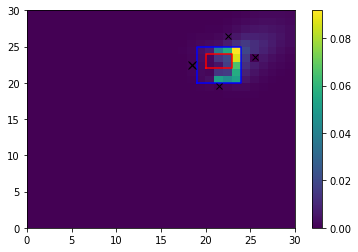

Creating TL
Done in: 6.097163677215576  sec
Memory:  [8737.45703125]
Iteration: 0  Time: 11.973548412322998  Distance: 1.52479695274  marginal-improvement: -0.524796952736
Iteration: 1  Time: 12.157888174057007  Distance: 2.54606276266  marginal-improvement: -0.66977167556
Iteration: 2  Time: 12.103105068206787  Distance: 1.47560900967  marginal-improvement: 0.420434943193
Iteration: 3  Time: 12.138060808181763  Distance: 1.04144747648  marginal-improvement: 0.294225320087
Iteration: 4  Time: 12.180539608001709  Distance: 0.800037901273  marginal-improvement: 0.231801968567
Iteration: 5  Time: 12.161350965499878  Distance: 0.64543116603  marginal-improvement: 0.193249263563
Iteration: 6  Time: 12.116995096206665  Distance: 0.536842944341  marginal-improvement: 0.168241367017
Iteration: 7  Time: 12.123940467834473  Distance: 0.4551285804  marginal-improvement: 0.152212792964
Iteration: 8  Time: 12.105211973190308  Distance: 0.390444724226  marginal-improvement: 0.142122158352
Iteration:

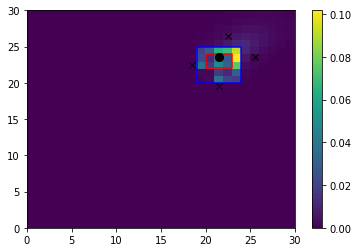

Creating TL
Done in: 0.01633429527282715  sec
Memory:  [5478.9765625]
Iteration: 0  Time: 0.06618738174438477  Distance: 350831713.197  marginal-improvement: -350831712.197
Iteration: 1  Time: 0.05346393585205078  Distance: 1.98692132146  marginal-improvement: 0.999999994337
Iteration: 2  Time: 0.04615211486816406  Distance: 0.707391445713  marginal-improvement: 0.643976116178
Iteration: 3  Time: 0.03909754753112793  Distance: 0.404539507944  marginal-improvement: 0.428124964763
Iteration: 4  Time: 0.03835654258728027  Distance: 0.264128944562  marginal-improvement: 0.347087393505
Iteration: 5  Time: 0.0385892391204834  Distance: 0.18118167209  marginal-improvement: 0.314040828088
Iteration: 6  Time: 0.04005002975463867  Distance: 0.128297699953  marginal-improvement: 0.291883674141
Iteration: 7  Time: 0.03922128677368164  Distance: 0.0927402967556  marginal-improvement: 0.277147627826
Iteration: 8  Time: 0.03872370719909668  Distance: 0.0679578837359  marginal-improvement: 0.267223783

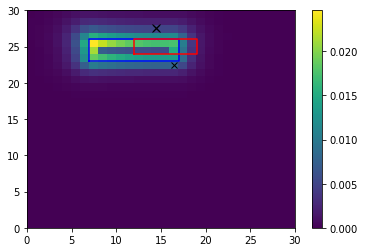

Creating TL
Done in: 9.252470970153809  sec
Memory:  [9091.9375]
Iteration: 0  Time: 18.653801679611206  Distance: 0.997282295198  marginal-improvement: 0.0027177048024
Iteration: 1  Time: 15.98961353302002  Distance: 1.02973822977  marginal-improvement: -0.0325443805878
Iteration: 2  Time: 16.069281816482544  Distance: 0.486321108504  marginal-improvement: 0.527723556875
Iteration: 3  Time: 16.05498957633972  Distance: 0.286967682472  marginal-improvement: 0.409921392567
Iteration: 4  Time: 16.012227296829224  Distance: 0.204414149044  marginal-improvement: 0.287675367192
Iteration: 5  Time: 16.00485849380493  Distance: 0.145964403117  marginal-improvement: 0.285937867809
Iteration: 6  Time: 15.896406412124634  Distance: 0.104894278064  marginal-improvement: 0.281370828609
Iteration: 7  Time: 15.914435148239136  Distance: 0.0759150355669  marginal-improvement: 0.276270956169
Iteration: 8  Time: 15.943803071975708  Distance: 0.0552945011181  marginal-improvement: 0.27162648736
Iteratio

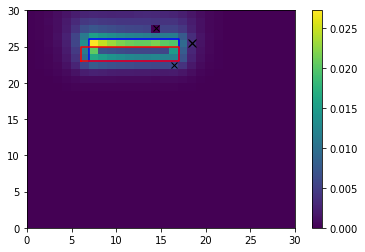

Creating TL
Done in: 7.411777496337891  sec
Memory:  [8576.890625]
Iteration: 0  Time: 14.394182682037354  Distance: 0.997803361738  marginal-improvement: 0.00219663826176
Iteration: 1  Time: 14.73813533782959  Distance: 1.46883823581  marginal-improvement: -0.472071845147
Iteration: 2  Time: 14.577481985092163  Distance: 0.747346715837  marginal-improvement: 0.491198759933
Iteration: 3  Time: 14.614044189453125  Distance: 0.457477200097  marginal-improvement: 0.387864841843
Iteration: 4  Time: 14.611647129058838  Distance: 0.350345583788  marginal-improvement: 0.234179137859
Iteration: 5  Time: 14.714441776275635  Distance: 0.290111507343  marginal-improvement: 0.171927603008
Iteration: 6  Time: 14.468386888504028  Distance: 0.24321670809  marginal-improvement: 0.161644050877
Iteration: 7  Time: 14.6163969039917  Distance: 0.205979865764  marginal-improvement: 0.153101497912
Iteration: 8  Time: 14.516084432601929  Distance: 0.175694052542  marginal-improvement: 0.147032881635
Iteratio

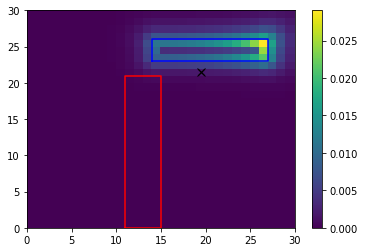

Creating TL
Done in: 7.321017503738403  sec
Memory:  [9749.6953125]
Iteration: 0  Time: 14.505934953689575  Distance: 0.996538412321  marginal-improvement: 0.00346158767883
Iteration: 1  Time: 14.023229360580444  Distance: 1.42865434954  marginal-improvement: -0.43361694028
Iteration: 2  Time: 13.99306845664978  Distance: 0.707605161235  marginal-improvement: 0.504705136367
Iteration: 3  Time: 14.020614862442017  Distance: 0.436831016361  marginal-improvement: 0.382662761253
Iteration: 4  Time: 14.028747081756592  Distance: 0.297352440558  marginal-improvement: 0.319296411148
Iteration: 5  Time: 13.977981567382812  Distance: 0.214506139617  marginal-improvement: 0.278613152747
Iteration: 6  Time: 13.837834596633911  Distance: 0.160827965929  marginal-improvement: 0.250240733363
Iteration: 7  Time: 13.873021125793457  Distance: 0.123877449834  marginal-improvement: 0.229751808905
Iteration: 8  Time: 13.966739177703857  Distance: 0.099383930539  marginal-improvement: 0.197723793376
Itera

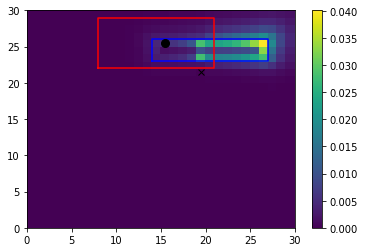

Creating TL
Done in: 0.3691389560699463  sec
Memory:  [6057.03515625]
Iteration: 0  Time: 0.8092868328094482  Distance: 13552.6314427  marginal-improvement: -13551.6314427
Iteration: 1  Time: 0.7852718830108643  Distance: 7.39552706433  marginal-improvement: 0.999454310619
Iteration: 2  Time: 0.7955119609832764  Distance: 2.69399448218  marginal-improvement: 0.635726506205
Iteration: 3  Time: 0.7843849658966064  Distance: 1.5555318483  marginal-improvement: 0.422592786068
Iteration: 4  Time: 0.7827582359313965  Distance: 1.11470528577  marginal-improvement: 0.2833928235
Iteration: 5  Time: 0.7787377834320068  Distance: 0.890833621206  marginal-improvement: 0.200834846144
Iteration: 6  Time: 0.7832558155059814  Distance: 0.749278943444  marginal-improvement: 0.158901364286
Iteration: 7  Time: 0.7826156616210938  Distance: 0.641575240522  marginal-improvement: 0.143743133135
Iteration: 8  Time: 0.7780413627624512  Distance: 0.555376833903  marginal-improvement: 0.13435432226
Iteration: 9

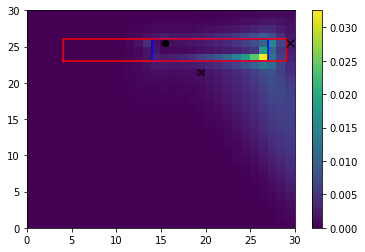

Creating TL
Done in: 0.3574821949005127  sec
Memory:  [4395.828125]
Iteration: 0  Time: 0.7738087177276611  Distance: 13091.0637476  marginal-improvement: -13090.0637476
Iteration: 1  Time: 0.7538220882415771  Distance: 7.28339700576  marginal-improvement: 0.999443635968
Iteration: 2  Time: 0.7572073936462402  Distance: 2.62639331725  marginal-improvement: 0.639399950987
Iteration: 3  Time: 0.7569634914398193  Distance: 1.5013362334  marginal-improvement: 0.428365803578
Iteration: 4  Time: 0.757819414138794  Distance: 1.05561913781  marginal-improvement: 0.296880262845
Iteration: 5  Time: 0.7567574977874756  Distance: 0.835303386257  marginal-improvement: 0.208707614005
Iteration: 6  Time: 0.7545044422149658  Distance: 0.701595667097  marginal-improvement: 0.160070845349
Iteration: 7  Time: 0.7571280002593994  Distance: 0.599802116139  marginal-improvement: 0.145088625446
Iteration: 8  Time: 0.7590830326080322  Distance: 0.517788514365  marginal-improvement: 0.136734432186
Iteration: 9

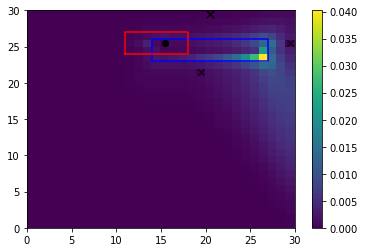

Creating TL
Done in: 0.34677553176879883  sec
Memory:  [4380.43359375]
Iteration: 0  Time: 0.7625827789306641  Distance: 12354.4335951  marginal-improvement: -12353.4335951
Iteration: 1  Time: 0.7224330902099609  Distance: 7.07813824845  marginal-improvement: 0.999427077074
Iteration: 2  Time: 0.7234928607940674  Distance: 2.48750690405  marginal-improvement: 0.648564803804
Iteration: 3  Time: 0.7240750789642334  Distance: 1.38929498428  marginal-improvement: 0.441491003694
Iteration: 4  Time: 0.7256608009338379  Distance: 0.945264951083  marginal-improvement: 0.319608174091
Iteration: 5  Time: 0.7262403964996338  Distance: 0.724733543274  marginal-improvement: 0.233301158111
Iteration: 6  Time: 0.7258622646331787  Distance: 0.602670299644  marginal-improvement: 0.168424995313
Iteration: 7  Time: 0.7223196029663086  Distance: 0.513313918308  marginal-improvement: 0.148267438081
Iteration: 8  Time: 0.7214698791503906  Distance: 0.44068780747  marginal-improvement: 0.141484787861
Iterati

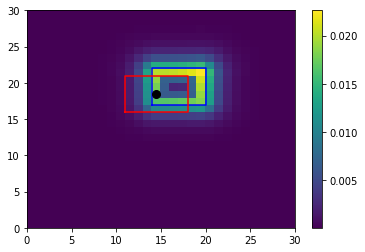

Creating TL
Done in: 2.0734403133392334  sec
Memory:  [7316.3046875]
Iteration: 0  Time: 4.660382509231567  Distance: 0.998593632307  marginal-improvement: 0.00140636769305
Iteration: 1  Time: 4.143869400024414  Distance: 2.75022377585  marginal-improvement: -1.75409704896
Iteration: 2  Time: 4.1377112865448  Distance: 0.814612014843  marginal-improvement: 0.703801551715
Iteration: 3  Time: 4.056315183639526  Distance: 0.356823133365  marginal-improvement: 0.561971678709
Iteration: 4  Time: 4.149532794952393  Distance: 0.181017870587  marginal-improvement: 0.492695810162
Iteration: 5  Time: 4.046143293380737  Distance: 0.0994525403128  marginal-improvement: 0.450592695682
Iteration: 6  Time: 4.226294994354248  Distance: 0.0598218437722  marginal-improvement: 0.398488529463
Iteration: 7  Time: 4.040804147720337  Distance: 0.0358517716983  marginal-improvement: 0.400690961067
Iteration: 8  Time: 4.179032564163208  Distance: 0.0214266431564  marginal-improvement: 0.402354691514
Iteration:

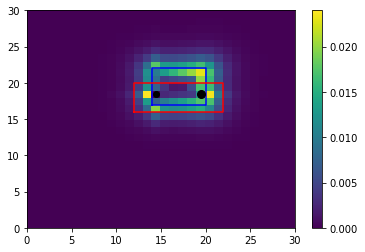

Creating TL
Done in: 1.3298029899597168  sec
Memory:  [5310.71484375]
Iteration: 0  Time: 2.703751802444458  Distance: 0.998341656968  marginal-improvement: 0.00165834303215
Iteration: 1  Time: 2.7010891437530518  Distance: 2.0475669592  marginal-improvement: -1.05096816797
Iteration: 2  Time: 2.7314555644989014  Distance: 0.658435398761  marginal-improvement: 0.678430345927
Iteration: 3  Time: 2.691012144088745  Distance: 0.287636289028  marginal-improvement: 0.563151845164
Iteration: 4  Time: 2.74346923828125  Distance: 0.143247298302  marginal-improvement: 0.501984611239
Iteration: 5  Time: 2.6872684955596924  Distance: 0.0760383920113  marginal-improvement: 0.469180969465
Iteration: 6  Time: 2.717758893966675  Distance: 0.0434170922979  marginal-improvement: 0.429010909496
Iteration: 7  Time: 2.6900925636291504  Distance: 0.0251767186495  marginal-improvement: 0.42011965065
Iteration: 8  Time: 2.7150869369506836  Distance: 0.0145599774125  marginal-improvement: 0.4216888382
Iterati

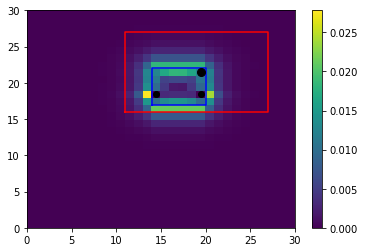

Creating TL
Done in: 0.9215083122253418  sec
Memory:  [4940.9765625]
Iteration: 0  Time: 1.9984025955200195  Distance: 0.998061881274  marginal-improvement: 0.0019381187264
Iteration: 1  Time: 1.9636211395263672  Distance: 1.71679780099  marginal-improvement: -0.720131620298
Iteration: 2  Time: 1.9562468528747559  Distance: 0.59176690582  marginal-improvement: 0.655307744757
Iteration: 3  Time: 1.954632043838501  Distance: 0.266262189412  marginal-improvement: 0.550055626982
Iteration: 4  Time: 1.9525949954986572  Distance: 0.1349367792  marginal-improvement: 0.493218396883
Iteration: 5  Time: 1.9545924663543701  Distance: 0.0739066760536  marginal-improvement: 0.452286644961
Iteration: 6  Time: 1.963562250137329  Distance: 0.0432115608742  marginal-improvement: 0.415322631438
Iteration: 7  Time: 1.9603025913238525  Distance: 0.0251982287592  marginal-improvement: 0.41686372236
Iteration: 8  Time: 1.9545862674713135  Distance: 0.0146646916032  marginal-improvement: 0.418026888187
Itera

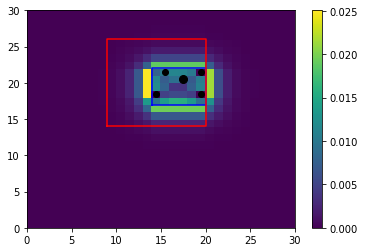

Creating TL
Done in: 0.9265835285186768  sec
Memory:  [4846.66796875]
Iteration: 0  Time: 1.9559211730957031  Distance: 0.998061880833  marginal-improvement: 0.0019381191668
Iteration: 1  Time: 1.971013069152832  Distance: 1.72356644225  marginal-improvement: -0.726913406221
Iteration: 2  Time: 1.974137306213379  Distance: 0.593270025301  marginal-improvement: 0.655789292041
Iteration: 3  Time: 1.9670789241790771  Distance: 0.266862410188  marginal-improvement: 0.550183898044
Iteration: 4  Time: 1.9601178169250488  Distance: 0.135253207318  marginal-improvement: 0.493172503305
Iteration: 5  Time: 1.9545681476593018  Distance: 0.0740846355851  marginal-improvement: 0.452252282557
Iteration: 6  Time: 1.9542794227600098  Distance: 0.0433321827042  marginal-improvement: 0.415098928922
Iteration: 7  Time: 1.9456636905670166  Distance: 0.0252788272789  marginal-improvement: 0.416626957117
Iteration: 8  Time: 1.946913480758667  Distance: 0.0147178013363  marginal-improvement: 0.417781482744
I

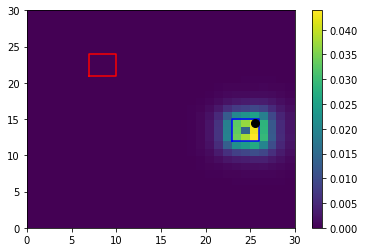

Creating TL
Done in: 1.0256931781768799  sec
Memory:  [7171.81640625]
Iteration: 0  Time: 2.5466134548187256  Distance: 0.999020540533  marginal-improvement: 0.000979459467429
Iteration: 1  Time: 2.1768765449523926  Distance: 4.68090222152  marginal-improvement: -3.6854914705
Iteration: 2  Time: 2.185089588165283  Distance: 1.54504598283  marginal-improvement: 0.669925602007
Iteration: 3  Time: 2.1937899589538574  Distance: 0.801035625904  marginal-improvement: 0.481545769637
Iteration: 4  Time: 2.192751169204712  Distance: 0.497117229874  marginal-improvement: 0.379406840597
Iteration: 5  Time: 2.1641387939453125  Distance: 0.338518766314  marginal-improvement: 0.319036344004
Iteration: 6  Time: 2.1678502559661865  Distance: 0.243708917695  marginal-improvement: 0.280072651956
Iteration: 7  Time: 2.1764113903045654  Distance: 0.181958048333  marginal-improvement: 0.253379605253
Iteration: 8  Time: 2.1981303691864014  Distance: 0.139316082236  marginal-improvement: 0.234350535676
Itera

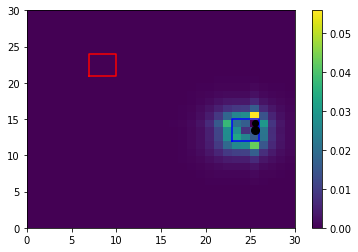

Creating TL
Done in: 0.9504275321960449  sec
Memory:  [5227.3203125]
Iteration: 0  Time: 1.996701955795288  Distance: 0.998973529721  marginal-improvement: 0.00102647027932
Iteration: 1  Time: 2.0138862133026123  Distance: 4.60585989729  marginal-improvement: -3.61059253349
Iteration: 2  Time: 2.0092084407806396  Distance: 1.52201902045  marginal-improvement: 0.669547260579
Iteration: 3  Time: 2.0109708309173584  Distance: 0.787529798468  marginal-improvement: 0.482575586844
Iteration: 4  Time: 2.0157971382141113  Distance: 0.488683677517  marginal-improvement: 0.379472778722
Iteration: 5  Time: 2.0237817764282227  Distance: 0.332831224717  marginal-improvement: 0.318922976088
Iteration: 6  Time: 2.016822576522827  Distance: 0.239609367661  marginal-improvement: 0.28008747417
Iteration: 7  Time: 2.0174694061279297  Distance: 0.178850909831  marginal-improvement: 0.253572965127
Iteration: 8  Time: 2.0209646224975586  Distance: 0.136875605538  marginal-improvement: 0.234694385021
Iterati

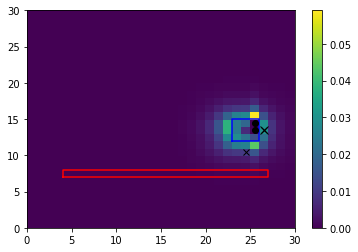

Creating TL
Done in: 0.16861796379089355  sec
Memory:  [4784.40234375]
Iteration: 0  Time: 0.3234682083129883  Distance: 0.99957624984  marginal-improvement: 0.000423750159608
Iteration: 1  Time: 0.32639408111572266  Distance: 5.44273329513  marginal-improvement: -4.44504063197
Iteration: 2  Time: 0.32604384422302246  Distance: 1.8500771329  marginal-improvement: 0.660083080948
Iteration: 3  Time: 0.3284130096435547  Distance: 0.980572957566  marginal-improvement: 0.469982661735
Iteration: 4  Time: 0.326979398727417  Distance: 0.627809040513  marginal-improvement: 0.359752850954
Iteration: 5  Time: 0.3256254196166992  Distance: 0.443236541923  marginal-improvement: 0.293994649135
Iteration: 6  Time: 0.3304424285888672  Distance: 0.331652962424  marginal-improvement: 0.251747247677
Iteration: 7  Time: 0.3288285732269287  Distance: 0.25774112406  marginal-improvement: 0.222858972294
Iteration: 8  Time: 0.3263883590698242  Distance: 0.205635703205  marginal-improvement: 0.20216184377
Iter

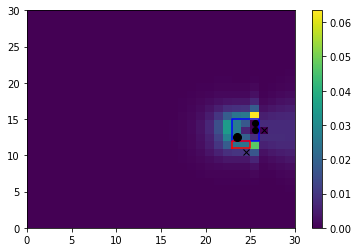

Creating TL
Done in: 0.12489104270935059  sec
Memory:  [4522.0]
Iteration: 0  Time: 0.27667689323425293  Distance: 0.999528170803  marginal-improvement: 0.000471829196938
Iteration: 1  Time: 0.28234028816223145  Distance: 3.58001098355  marginal-improvement: -2.58170093463
Iteration: 2  Time: 0.2890501022338867  Distance: 1.31916058795  marginal-improvement: 0.631520519348
Iteration: 3  Time: 0.2856473922729492  Distance: 0.696796012079  marginal-improvement: 0.471788333851
Iteration: 4  Time: 0.28427767753601074  Distance: 0.432260887027  marginal-improvement: 0.379645004371
Iteration: 5  Time: 0.2853550910949707  Distance: 0.292258747156  marginal-improvement: 0.323883432606
Iteration: 6  Time: 0.2854745388031006  Distance: 0.208170887375  marginal-improvement: 0.287717170484
Iteration: 7  Time: 0.28496885299682617  Distance: 0.153429390046  marginal-improvement: 0.262964231065
Iteration: 8  Time: 0.28656959533691406  Distance: 0.116270117226  marginal-improvement: 0.242191361179
Ite

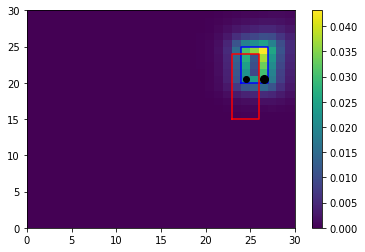

Creating TL
Done in: 0.7123847007751465  sec
Memory:  [6699.01171875]
Iteration: 0  Time: 3.165005922317505  Distance: 1.12009605137  marginal-improvement: -0.120096051369
Iteration: 1  Time: 1.541914463043213  Distance: 6.60431965803  marginal-improvement: -4.89620832067
Iteration: 2  Time: 1.548588514328003  Distance: 2.22174122617  marginal-improvement: 0.663592717917
Iteration: 3  Time: 1.536376953125  Distance: 1.17870778248  marginal-improvement: 0.469466664884
Iteration: 4  Time: 1.5491509437561035  Distance: 0.74871203718  marginal-improvement: 0.364802669239
Iteration: 5  Time: 1.5455958843231201  Distance: 0.520811104418  marginal-improvement: 0.304390635443
Iteration: 6  Time: 1.5514516830444336  Distance: 0.38241161297  marginal-improvement: 0.265738365165
Iteration: 7  Time: 1.558044195175171  Distance: 0.291017378518  marginal-improvement: 0.238994401198
Iteration: 8  Time: 1.5476641654968262  Distance: 0.227157485007  marginal-improvement: 0.21943670112
Iteration: 9  Tim

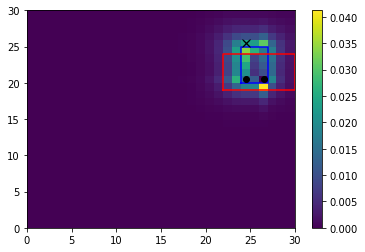

Creating TL
Done in: 0.37720561027526855  sec
Memory:  [4510.91015625]
Iteration: 0  Time: 0.7931292057037354  Distance: 35.782852394  marginal-improvement: -34.782852394
Iteration: 1  Time: 0.800025224685669  Distance: 7.55994945057  marginal-improvement: 0.788727031391
Iteration: 2  Time: 0.7979354858398438  Distance: 2.65048807524  marginal-improvement: 0.649403995017
Iteration: 3  Time: 0.7972972393035889  Distance: 1.46122691001  marginal-improvement: 0.448695157824
Iteration: 4  Time: 0.7973203659057617  Distance: 1.03731100913  marginal-improvement: 0.290109563393
Iteration: 5  Time: 0.8020613193511963  Distance: 0.791090563716  marginal-improvement: 0.237364149466
Iteration: 6  Time: 0.8032898902893066  Distance: 0.6125035281  marginal-improvement: 0.225747902714
Iteration: 7  Time: 0.8043150901794434  Distance: 0.482404768811  marginal-improvement: 0.212404914128
Iteration: 8  Time: 0.7999434471130371  Distance: 0.386599229458  marginal-improvement: 0.198599901052
Iteration: 9

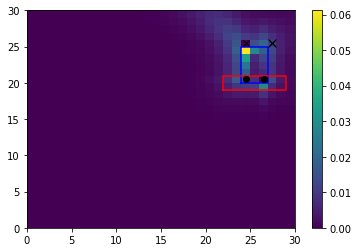

Creating TL
Done in: 0.36045312881469727  sec
Memory:  [4389.5546875]
Iteration: 0  Time: 0.7594661712646484  Distance: 29.9751194372  marginal-improvement: -28.9751194372
Iteration: 1  Time: 0.7533495426177979  Distance: 7.53266150431  marginal-improvement: 0.748702869389
Iteration: 2  Time: 0.7501194477081299  Distance: 2.52716819742  marginal-improvement: 0.66450527533
Iteration: 3  Time: 0.7563228607177734  Distance: 1.34656541318  marginal-improvement: 0.467164308827
Iteration: 4  Time: 0.751823902130127  Distance: 0.86244549168  marginal-improvement: 0.359522023039
Iteration: 5  Time: 0.7549211978912354  Distance: 0.624807537003  marginal-improvement: 0.275539679863
Iteration: 6  Time: 0.7481472492218018  Distance: 0.49994367077  marginal-improvement: 0.199843726008
Iteration: 7  Time: 0.7571353912353516  Distance: 0.400848367115  marginal-improvement: 0.198212937675
Iteration: 8  Time: 0.7505502700805664  Distance: 0.322344350985  marginal-improvement: 0.19584466988
Iteration: 9

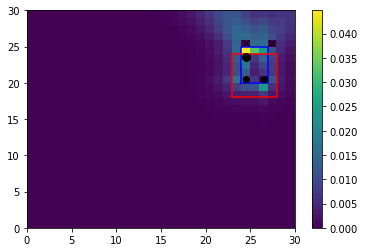

Creating TL
Done in: 0.10976696014404297  sec
Memory:  [4270.3359375]
Iteration: 0  Time: 0.22530817985534668  Distance: 3.4699907986  marginal-improvement: -2.4699907986
Iteration: 1  Time: 0.21393251419067383  Distance: 4.7368994808  marginal-improvement: -0.365104334778
Iteration: 2  Time: 0.2362840175628662  Distance: 1.86928583445  marginal-improvement: 0.605377770411
Iteration: 3  Time: 0.21460437774658203  Distance: 1.01454252445  marginal-improvement: 0.457256613328
Iteration: 4  Time: 0.21342968940734863  Distance: 0.639604669018  marginal-improvement: 0.369563469639
Iteration: 5  Time: 0.21741962432861328  Distance: 0.436526927942  marginal-improvement: 0.317505094808
Iteration: 6  Time: 0.21963071823120117  Distance: 0.312297057962  marginal-improvement: 0.284586956789
Iteration: 7  Time: 0.23275995254516602  Distance: 0.230323963263  marginal-improvement: 0.262484364195
Iteration: 8  Time: 0.21551513671875  Distance: 0.173448685058  marginal-improvement: 0.246936000056
Iter

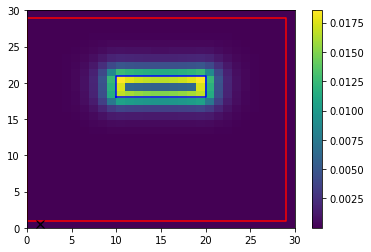

Creating TL
Done in: 10.547525882720947  sec
Memory:  [8816.1015625]
Iteration: 0  Time: 19.947330474853516  Distance: 1.66647879617  marginal-improvement: -0.66647879617
Iteration: 1  Time: 17.736847400665283  Distance: 0.906878053819  marginal-improvement: 0.455811825567
Iteration: 2  Time: 17.661587238311768  Distance: 0.788224637055  marginal-improvement: 0.130837234691
Iteration: 3  Time: 17.52756667137146  Distance: 0.766256493812  marginal-improvement: 0.0278704092848
Iteration: 4  Time: 17.636394023895264  Distance: 0.756779328721  marginal-improvement: 0.0123681367377
Iteration: 5  Time: 17.489186763763428  Distance: 0.75254026155  marginal-improvement: 0.00560145739951
Iteration: 6  Time: 17.689574480056763  Distance: 0.750559604587  marginal-improvement: 0.00263196145664
Iteration: 7  Time: 17.5048930644989  Distance: 0.74959769598  marginal-improvement: 0.00128158856506
Iteration: 8  Time: 17.522655487060547  Distance: 0.749117897462  marginal-improvement: 0.000640074697394

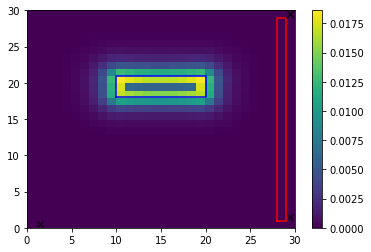

Creating TL
Done in: 9.084374189376831  sec
Memory:  [8419.046875]
Iteration: 0  Time: 17.5486741065979  Distance: 1.6664139058  marginal-improvement: -0.666413905805
Iteration: 1  Time: 17.391352891921997  Distance: 0.905411134192  marginal-improvement: 0.456670920089
Iteration: 2  Time: 17.418665409088135  Distance: 0.787701906548  marginal-improvement: 0.13000638406
Iteration: 3  Time: 17.471391677856445  Distance: 0.765595930149  marginal-improvement: 0.0280638858628
Iteration: 4  Time: 17.344305276870728  Distance: 0.756050132387  marginal-improvement: 0.0124684541619
Iteration: 5  Time: 17.35820198059082  Distance: 0.751780714684  marginal-improvement: 0.00564700344689
Iteration: 6  Time: 17.33692193031311  Distance: 0.749787703103  marginal-improvement: 0.00265105441197
Iteration: 7  Time: 17.446263313293457  Distance: 0.748821212938  marginal-improvement: 0.00128901842568
Iteration: 8  Time: 17.373884916305542  Distance: 0.748339987859  marginal-improvement: 0.000642643491988
I

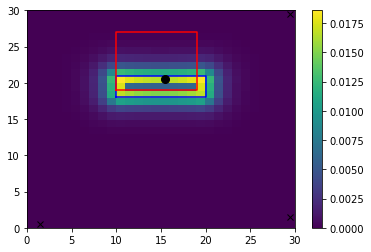

Creating TL
Done in: 1.7585246562957764  sec
Memory:  [5059.62890625]
Iteration: 0  Time: 3.646425247192383  Distance: 0.998674273002  marginal-improvement: 0.00132572699781
Iteration: 1  Time: 3.6319468021392822  Distance: 3.30209105537  marginal-improvement: -2.30647453793
Iteration: 2  Time: 3.6838274002075195  Distance: 0.985820721133  marginal-improvement: 0.701455621725
Iteration: 3  Time: 3.603832244873047  Distance: 0.449439026927  marginal-improvement: 0.544096591507
Iteration: 4  Time: 3.694995164871216  Distance: 0.240957945966  marginal-improvement: 0.463869553979
Iteration: 5  Time: 3.621783971786499  Distance: 0.139943735736  marginal-improvement: 0.419219253487
Iteration: 6  Time: 3.6810405254364014  Distance: 0.0905999616693  marginal-improvement: 0.352597233505
Iteration: 7  Time: 3.6333420276641846  Distance: 0.0599219405744  marginal-improvement: 0.338609647616
Iteration: 8  Time: 3.748572826385498  Distance: 0.0396870350466  marginal-improvement: 0.337687753999
Iter

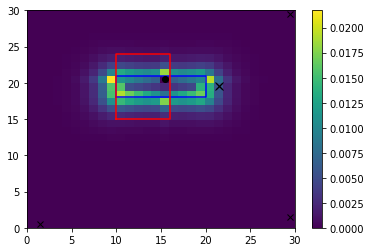

Creating TL
Done in: 0.6955277919769287  sec
Memory:  [2799.60546875]
Iteration: 0  Time: 1.4640915393829346  Distance: 1480.30269539  marginal-improvement: -1479.30269539
Iteration: 1  Time: 1.4741864204406738  Distance: 7.31319849378  marginal-improvement: 0.995059660084
Iteration: 2  Time: 1.4751770496368408  Distance: 2.41316308771  marginal-improvement: 0.670026310681
Iteration: 3  Time: 1.475579023361206  Distance: 1.19014808163  marginal-improvement: 0.50680992607
Iteration: 4  Time: 1.4701571464538574  Distance: 0.666339597348  marginal-improvement: 0.44012042902
Iteration: 5  Time: 1.4789247512817383  Distance: 0.524493989984  marginal-improvement: 0.212872847312
Iteration: 6  Time: 1.4856138229370117  Distance: 0.472649514098  marginal-improvement: 0.0988466538728
Iteration: 7  Time: 1.4815418720245361  Distance: 0.429649018926  marginal-improvement: 0.0909775507832
Iteration: 8  Time: 1.480813980102539  Distance: 0.393149452119  marginal-improvement: 0.0849520543508
Iteratio

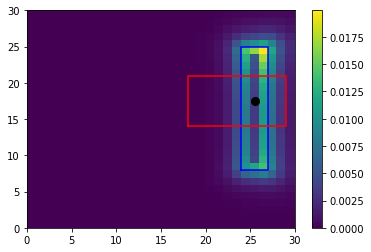

Creating TL
Done in: 0.9945588111877441  sec
Memory:  [8192.8984375]
Iteration: 0  Time: 2.2712786197662354  Distance: 0.999031975404  marginal-improvement: 0.000968024596399
Iteration: 1  Time: 2.116633653640747  Distance: 5.1357139422  marginal-improvement: -4.14069025681
Iteration: 2  Time: 2.123020887374878  Distance: 1.69436726698  marginal-improvement: 0.670081455849
Iteration: 3  Time: 2.111593008041382  Distance: 0.877830642811  marginal-improvement: 0.48191241656
Iteration: 4  Time: 2.1290082931518555  Distance: 0.543638478215  marginal-improvement: 0.380702322633
Iteration: 5  Time: 2.1198577880859375  Distance: 0.368918148975  marginal-improvement: 0.321390659863
Iteration: 6  Time: 2.1131324768066406  Distance: 0.264473724841  marginal-improvement: 0.283110018914
Iteration: 7  Time: 2.114516496658325  Distance: 0.196592098775  marginal-improvement: 0.256666805395
Iteration: 8  Time: 2.124934196472168  Distance: 0.149891029528  marginal-improvement: 0.237553134322
Iteration:

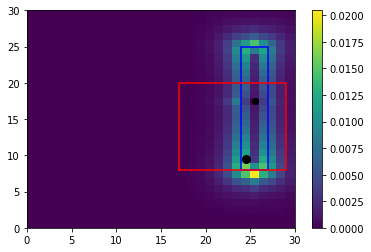

Creating TL
Done in: 0.5055031776428223  sec
Memory:  [5991.87890625]
Iteration: 0  Time: 1.0972630977630615  Distance: 0.998713046094  marginal-improvement: 0.00128695390579
Iteration: 1  Time: 1.0860347747802734  Distance: 2.45048688739  marginal-improvement: -1.45364461491
Iteration: 2  Time: 1.0868418216705322  Distance: 0.989146404281  marginal-improvement: 0.596346991542
Iteration: 3  Time: 1.0900461673736572  Distance: 0.528892010425  marginal-improvement: 0.46530462211
Iteration: 4  Time: 1.085066318511963  Distance: 0.327481562667  marginal-improvement: 0.380815825893
Iteration: 5  Time: 1.0880355834960938  Distance: 0.220216041178  marginal-improvement: 0.327546749855
Iteration: 6  Time: 1.0840799808502197  Distance: 0.155642776472  marginal-improvement: 0.293226889199
Iteration: 7  Time: 1.0808022022247314  Distance: 0.113560152427  marginal-improvement: 0.270379551166
Iteration: 8  Time: 1.0831775665283203  Distance: 0.0846403976351  marginal-improvement: 0.254664635208
Ite

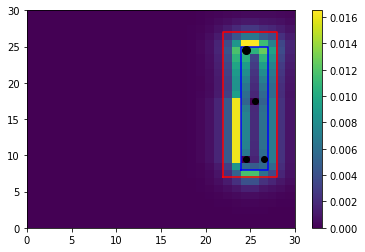

Creating TL
Done in: 0.20925283432006836  sec
Memory:  [5701.44921875]
Iteration: 0  Time: 0.4294121265411377  Distance: 0.998458038962  marginal-improvement: 0.0015419610378
Iteration: 1  Time: 0.4296603202819824  Distance: 1.4716267951  marginal-improvement: -0.473899490687
Iteration: 2  Time: 0.4294464588165283  Distance: 0.700335313583  marginal-improvement: 0.524108071479
Iteration: 3  Time: 0.43061232566833496  Distance: 0.403348866449  marginal-improvement: 0.424063218538
Iteration: 4  Time: 0.4287419319152832  Distance: 0.259350106715  marginal-improvement: 0.35700796931
Iteration: 5  Time: 0.4320063591003418  Distance: 0.178257247942  marginal-improvement: 0.312677175269
Iteration: 6  Time: 0.4289712905883789  Distance: 0.127763019764  marginal-improvement: 0.283266059367
Iteration: 7  Time: 0.4305613040924072  Distance: 0.0941087453019  marginal-improvement: 0.26341170179
Iteration: 8  Time: 0.42743754386901855  Distance: 0.0706105603225  marginal-improvement: 0.249691831551


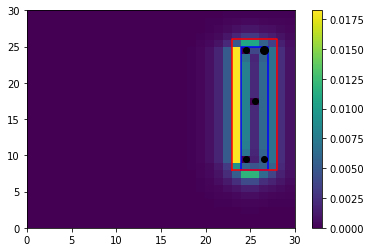

Creating TL
Done in: 0.1482546329498291  sec
Memory:  [5575.51171875]
Iteration: 0  Time: 0.3326144218444824  Distance: 0.998400182642  marginal-improvement: 0.0015998173584
Iteration: 1  Time: 0.33472728729248047  Distance: 1.40051043584  marginal-improvement: -0.402754586977
Iteration: 2  Time: 0.3482673168182373  Distance: 0.693435662027  marginal-improvement: 0.504869336007
Iteration: 3  Time: 0.3435800075531006  Distance: 0.411283681022  marginal-improvement: 0.406889919939
Iteration: 4  Time: 0.34534144401550293  Distance: 0.269487344958  marginal-improvement: 0.344765286362
Iteration: 5  Time: 0.3471508026123047  Distance: 0.187566137037  marginal-improvement: 0.303989072045
Iteration: 6  Time: 0.3459155559539795  Distance: 0.135718332028  marginal-improvement: 0.276424123393
Iteration: 7  Time: 0.3489654064178467  Distance: 0.10079849118  marginal-improvement: 0.257296419181
Iteration: 8  Time: 0.3476219177246094  Distance: 0.0762322438407  marginal-improvement: 0.243716419281


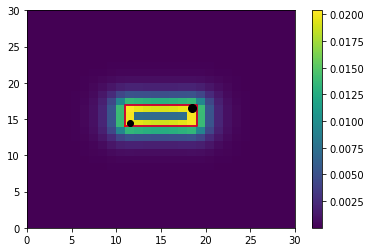

Creating TL
Done in: 2.0491669178009033  sec
Memory:  [7334.03515625]
Iteration: 0  Time: 4.9011313915252686  Distance: 0.998600355491  marginal-improvement: 0.00139964450883
Iteration: 1  Time: 4.09003472328186  Distance: 2.90501383676  marginal-improvement: -1.90908552234
Iteration: 2  Time: 4.0061750411987305  Distance: 0.865692780876  marginal-improvement: 0.702000462125
Iteration: 3  Time: 4.104129076004028  Distance: 0.382796552052  marginal-improvement: 0.557814780823
Iteration: 4  Time: 3.9436256885528564  Distance: 0.196220336093  marginal-improvement: 0.487403073405
Iteration: 5  Time: 4.034393310546875  Distance: 0.108090132388  marginal-improvement: 0.449138990687
Iteration: 6  Time: 3.937436103820801  Distance: 0.0660027765301  marginal-improvement: 0.389372784805
Iteration: 7  Time: 4.000845193862915  Distance: 0.040090109567  marginal-improvement: 0.392599649976
Iteration: 8  Time: 3.973395824432373  Distance: 0.0242456939464  marginal-improvement: 0.395220062797
Iterati

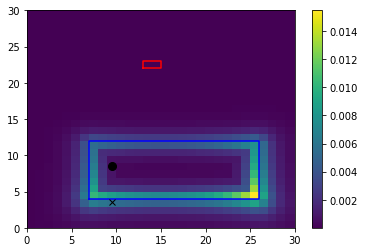

Creating TL
Done in: 1.4789211750030518  sec
Memory:  [7747.33203125]
Iteration: 0  Time: 3.1474080085754395  Distance: 0.998801115656  marginal-improvement: 0.00119888434365
Iteration: 1  Time: 3.0190863609313965  Distance: 4.42282789679  marginal-improvement: -3.42813672058
Iteration: 2  Time: 3.0479960441589355  Distance: 1.40523149042  marginal-improvement: 0.682277600846
Iteration: 3  Time: 3.0304887294769287  Distance: 0.691528778615  marginal-improvement: 0.507889779491
Iteration: 4  Time: 3.0602755546569824  Distance: 0.40182942591  marginal-improvement: 0.41892595314
Iteration: 5  Time: 3.030876874923706  Distance: 0.253024295843  marginal-improvement: 0.370319146563
Iteration: 6  Time: 3.0166852474212646  Distance: 0.166610587852  marginal-improvement: 0.341523361238
Iteration: 7  Time: 3.0616376399993896  Distance: 0.117734039179  marginal-improvement: 0.293357999049
Iteration: 8  Time: 3.0302112102508545  Distance: 0.0854375994927  marginal-improvement: 0.274316925774
Itera

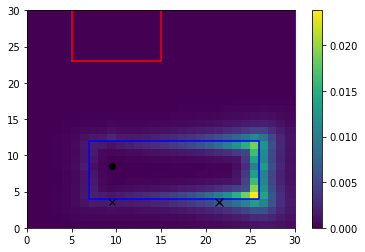

Creating TL
Done in: 1.1123766899108887  sec
Memory:  [5813.9296875]
Iteration: 0  Time: 2.3335866928100586  Distance: 10.944734584  marginal-improvement: -9.94473458398
Iteration: 1  Time: 2.3615221977233887  Distance: 6.21811299259  marginal-improvement: 0.431862605267
Iteration: 2  Time: 2.352125644683838  Distance: 2.06223682363  marginal-improvement: 0.668350056346
Iteration: 3  Time: 2.3553645610809326  Distance: 1.09802855171  marginal-improvement: 0.467554579991
Iteration: 4  Time: 2.3545212745666504  Distance: 0.698967567795  marginal-improvement: 0.363434068536
Iteration: 5  Time: 2.353732109069824  Distance: 0.485714859962  marginal-improvement: 0.30509671358
Iteration: 6  Time: 2.365989923477173  Distance: 0.355047420317  marginal-improvement: 0.269020881212
Iteration: 7  Time: 2.353219747543335  Distance: 0.268098329375  marginal-improvement: 0.24489430416
Iteration: 8  Time: 2.3565821647644043  Distance: 0.211951813822  marginal-improvement: 0.209425085503
Iteration: 9  T

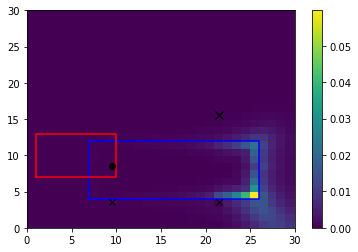

Creating TL
Done in: 0.8497903347015381  sec
Memory:  [5592.921875]
Iteration: 0  Time: 1.8224055767059326  Distance: 2872.86143964  marginal-improvement: -2871.86143964
Iteration: 1  Time: 1.8362503051757812  Distance: 5.79602091362  marginal-improvement: 0.997982492008
Iteration: 2  Time: 1.846177101135254  Distance: 1.84130402116  marginal-improvement: 0.682315842436
Iteration: 3  Time: 1.8378288745880127  Distance: 0.973773858451  marginal-improvement: 0.471149876795
Iteration: 4  Time: 1.8324854373931885  Distance: 0.62664345298  marginal-improvement: 0.356479486955
Iteration: 5  Time: 1.8459291458129883  Distance: 0.445147042507  marginal-improvement: 0.289632660503
Iteration: 6  Time: 1.8436148166656494  Distance: 0.337114607236  marginal-improvement: 0.242689324998
Iteration: 7  Time: 1.8418285846710205  Distance: 0.265334290589  marginal-improvement: 0.212925560348
Iteration: 8  Time: 1.8488130569458008  Distance: 0.214177285479  marginal-improvement: 0.192802087496
Iteration:

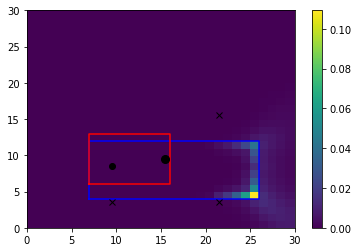

Creating TL
Done in: 0.43968772888183594  sec
Memory:  [5259.60546875]
Iteration: 0  Time: 0.9686801433563232  Distance: 491.989687865  marginal-improvement: -490.989687865
Iteration: 1  Time: 0.9379215240478516  Distance: 2.25985165143  marginal-improvement: 0.995406709313
Iteration: 2  Time: 0.936739444732666  Distance: 0.738390303971  marginal-improvement: 0.67325717885
Iteration: 3  Time: 0.9347434043884277  Distance: 0.357022588795  marginal-improvement: 0.516485269545
Iteration: 4  Time: 0.9351706504821777  Distance: 0.205452636579  marginal-improvement: 0.42453883024
Iteration: 5  Time: 0.9365081787109375  Distance: 0.127983518437  marginal-improvement: 0.377065582766
Iteration: 6  Time: 0.9404079914093018  Distance: 0.0835823279145  marginal-improvement: 0.346928972296
Iteration: 7  Time: 0.9365072250366211  Distance: 0.057297907937  marginal-improvement: 0.314473413619
Iteration: 8  Time: 0.9380395412445068  Distance: 0.0403185768226  marginal-improvement: 0.296334224507
Itera

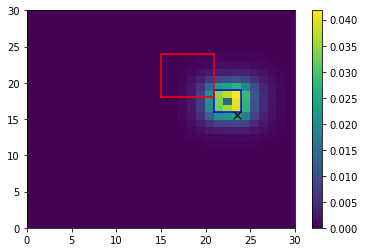

Creating TL
Done in: 7.319744825363159  sec
Memory:  [9122.8359375]
Iteration: 0  Time: 14.205861330032349  Distance: 0.996914541915  marginal-improvement: 0.00308545808534
Iteration: 1  Time: 14.135891675949097  Distance: 1.16600474762  marginal-improvement: -0.169613541181
Iteration: 2  Time: 14.114108085632324  Distance: 0.560997415359  marginal-improvement: 0.518872100219
Iteration: 3  Time: 14.097628355026245  Distance: 0.329987274905  marginal-improvement: 0.411784678733
Iteration: 4  Time: 14.170730590820312  Distance: 0.213639111378  marginal-improvement: 0.352583788454
Iteration: 5  Time: 14.088640689849854  Distance: 0.150377021815  marginal-improvement: 0.296116610644
Iteration: 6  Time: 14.12609314918518  Distance: 0.112737140825  marginal-improvement: 0.250303407635
Iteration: 7  Time: 14.122484922409058  Distance: 0.0861591812767  marginal-improvement: 0.235751584206
Iteration: 8  Time: 14.124566078186035  Distance: 0.0666224714601  marginal-improvement: 0.226751340102
It

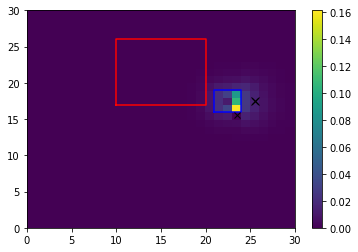

Creating TL
Done in: 6.9744791984558105  sec
Memory:  [8601.37890625]
Iteration: 0  Time: 13.420171022415161  Distance: 0.997302534924  marginal-improvement: 0.00269746507644
Iteration: 1  Time: 13.649554967880249  Distance: 1.39505862248  marginal-improvement: -0.398831922742
Iteration: 2  Time: 13.659461736679077  Distance: 0.715543258294  marginal-improvement: 0.48708731894
Iteration: 3  Time: 13.655243635177612  Distance: 0.446848100661  marginal-improvement: 0.375512108482
Iteration: 4  Time: 13.590903759002686  Distance: 0.307049861477  marginal-improvement: 0.312854052592
Iteration: 5  Time: 13.678030014038086  Distance: 0.22415602248  marginal-improvement: 0.269968657852
Iteration: 6  Time: 13.583457231521606  Distance: 0.171102382458  marginal-improvement: 0.236681751554
Iteration: 7  Time: 13.645496845245361  Distance: 0.139119975696  marginal-improvement: 0.186919704463
Iteration: 8  Time: 13.652578592300415  Distance: 0.113801627244  marginal-improvement: 0.181989310486
Ite

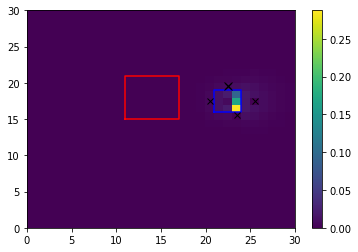

Creating TL
Done in: 6.613013744354248  sec
Memory:  [8342.76953125]
Iteration: 0  Time: 12.693071603775024  Distance: 0.997447878014  marginal-improvement: 0.00255212198593
Iteration: 1  Time: 12.877439975738525  Distance: 1.70058571931  marginal-improvement: -0.704936926327
Iteration: 2  Time: 12.787747621536255  Distance: 0.929610259922  marginal-improvement: 0.45335877553
Iteration: 3  Time: 12.742205619812012  Distance: 0.629127538231  marginal-improvement: 0.323235160632
Iteration: 4  Time: 12.725605964660645  Distance: 0.458314242925  marginal-improvement: 0.271508215625
Iteration: 5  Time: 12.717358350753784  Distance: 0.356994058191  marginal-improvement: 0.221071429261
Iteration: 6  Time: 12.766471862792969  Distance: 0.287964422921  marginal-improvement: 0.193363541174
Iteration: 7  Time: 12.782147407531738  Distance: 0.237202561666  marginal-improvement: 0.17627823861
Iteration: 8  Time: 12.797306060791016  Distance: 0.197690815182  marginal-improvement: 0.166573860781
Iter

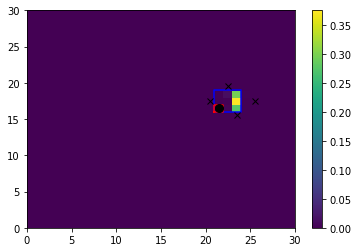

Creating TL
Done in: 0.1868896484375  sec
Memory:  [5109.94140625]
Iteration: 0  Time: 0.3818039894104004  Distance: 95.0261449964  marginal-improvement: -94.0261449964
Iteration: 1  Time: 0.37911128997802734  Distance: 4.23477893168  marginal-improvement: 0.955435644245
Iteration: 2  Time: 0.37831592559814453  Distance: 1.40417791954  marginal-improvement: 0.668417657168
Iteration: 3  Time: 0.3820638656616211  Distance: 0.75852322845  marginal-improvement: 0.459809744981
Iteration: 4  Time: 0.3833887577056885  Distance: 0.482441140261  marginal-improvement: 0.363973149185
Iteration: 5  Time: 0.3830258846282959  Distance: 0.336932472181  marginal-improvement: 0.301609162108
Iteration: 6  Time: 0.3800690174102783  Distance: 0.238167730386  marginal-improvement: 0.293129187445
Iteration: 7  Time: 0.38138818740844727  Distance: 0.170801384623  marginal-improvement: 0.282852532768
Iteration: 8  Time: 0.3795011043548584  Distance: 0.125877659912  marginal-improvement: 0.26301733332
Iteratio

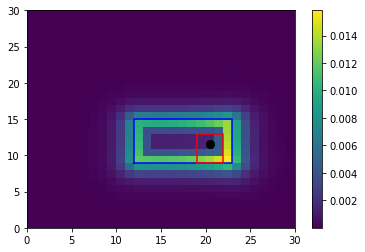

Creating TL
Done in: 1.7013404369354248  sec
Memory:  [7913.84375]
Iteration: 0  Time: 3.5756702423095703  Distance: 0.998705213928  marginal-improvement: 0.0012947860722
Iteration: 1  Time: 3.536872386932373  Distance: 3.68675906051  marginal-improvement: -2.69153881355
Iteration: 2  Time: 3.4823288917541504  Distance: 1.14092215001  marginal-improvement: 0.690535201436
Iteration: 3  Time: 3.533203125  Distance: 0.537850132632  marginal-improvement: 0.528582968938
Iteration: 4  Time: 3.5455052852630615  Distance: 0.297553217299  marginal-improvement: 0.446772996331
Iteration: 5  Time: 3.498863697052002  Distance: 0.177770937134  marginal-improvement: 0.402557502998
Iteration: 6  Time: 3.535372257232666  Distance: 0.113772302349  marginal-improvement: 0.360006173206
Iteration: 7  Time: 3.5116193294525146  Distance: 0.0771842109433  marginal-improvement: 0.321590498307
Iteration: 8  Time: 3.52801775932312  Distance: 0.052194859598  marginal-improvement: 0.323762477323
Iteration: 9  Time

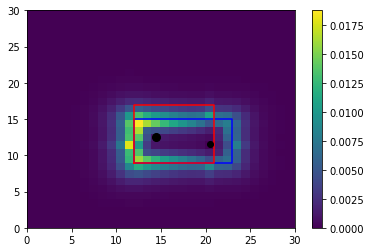

Creating TL
Done in: 1.0461375713348389  sec
Memory:  [5863.04296875]
Iteration: 0  Time: 2.2892165184020996  Distance: 0.998054478017  marginal-improvement: 0.0019455219835
Iteration: 1  Time: 2.2708635330200195  Distance: 1.69813589892  marginal-improvement: -0.701446099709
Iteration: 2  Time: 2.262573480606079  Distance: 0.558767566233  marginal-improvement: 0.670952385737
Iteration: 3  Time: 2.2684683799743652  Distance: 0.240652556393  marginal-improvement: 0.56931545255
Iteration: 4  Time: 2.255265951156616  Distance: 0.116327810581  marginal-improvement: 0.516615105509
Iteration: 5  Time: 2.26584792137146  Distance: 0.0598479925389  marginal-improvement: 0.485522918037
Iteration: 6  Time: 2.269819974899292  Distance: 0.0331103811318  marginal-improvement: 0.446758701049
Iteration: 7  Time: 2.272197961807251  Distance: 0.0182164476155  marginal-improvement: 0.44982670109
Iteration: 8  Time: 2.2606923580169678  Distance: 0.00998394800457  marginal-improvement: 0.45192673043
Total 

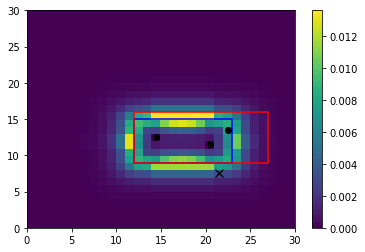

Creating TL
Done in: 0.399691104888916  sec
Memory:  [5297.55078125]
Iteration: 0  Time: 0.8518316745758057  Distance: 46.2273882983  marginal-improvement: -45.2273882983
Iteration: 1  Time: 0.858994722366333  Distance: 4.06442422847  marginal-improvement: 0.912077571801
Iteration: 2  Time: 0.8635129928588867  Distance: 1.46368902962  marginal-improvement: 0.639877889871
Iteration: 3  Time: 0.8583803176879883  Distance: 0.758794615252  marginal-improvement: 0.48158755043
Iteration: 4  Time: 0.85353684425354  Distance: 0.456247916135  marginal-improvement: 0.39872014513
Iteration: 5  Time: 0.8538100719451904  Distance: 0.337453641689  marginal-improvement: 0.260372201702
Iteration: 6  Time: 0.8563356399536133  Distance: 0.275568461279  marginal-improvement: 0.183388687408
Iteration: 7  Time: 0.8546586036682129  Distance: 0.226191980005  marginal-improvement: 0.179180451364
Iteration: 8  Time: 0.8551681041717529  Distance: 0.186709080318  marginal-improvement: 0.174554817048
Iteration: 9

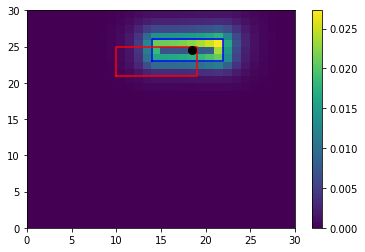

Creating TL
Done in: 1.3903329372406006  sec
Memory:  [6895.65625]
Iteration: 0  Time: 3.563436985015869  Distance: 0.998944826945  marginal-improvement: 0.00105517305547
Iteration: 1  Time: 2.480207681655884  Distance: 4.93428385193  marginal-improvement: -3.93949587488
Iteration: 2  Time: 2.432852029800415  Distance: 1.60809495848  marginal-improvement: 0.674097598205
Iteration: 3  Time: 2.428278923034668  Distance: 0.820443601687  marginal-improvement: 0.489804008551
Iteration: 4  Time: 2.4376189708709717  Distance: 0.498397134358  marginal-improvement: 0.39252724583
Iteration: 5  Time: 2.4557290077209473  Distance: 0.330625480124  marginal-improvement: 0.336622429522
Iteration: 6  Time: 2.4249050617218018  Distance: 0.231051547256  marginal-improvement: 0.301168357716
Iteration: 7  Time: 2.4478847980499268  Distance: 0.167043697624  marginal-improvement: 0.277028439725
Iteration: 8  Time: 2.432129144668579  Distance: 0.126262685206  marginal-improvement: 0.244133798506
Iteration: 9

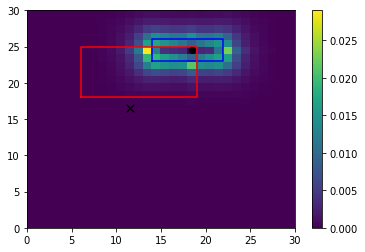

Creating TL
Done in: 0.6541333198547363  sec
Memory:  [4723.05859375]
Iteration: 0  Time: 1.314035177230835  Distance: 53230.4272032  marginal-improvement: -53229.4272032
Iteration: 1  Time: 1.315040111541748  Distance: 6.12443620113  marginal-improvement: 0.999884944823
Iteration: 2  Time: 1.3179724216461182  Distance: 1.96677442155  marginal-improvement: 0.678864411848
Iteration: 3  Time: 1.3163435459136963  Distance: 1.11243281698  marginal-improvement: 0.434387185032
Iteration: 4  Time: 1.3205246925354004  Distance: 0.755540495665  marginal-improvement: 0.320821460736
Iteration: 5  Time: 1.3258605003356934  Distance: 0.563056040255  marginal-improvement: 0.25476391605
Iteration: 6  Time: 1.31266450881958  Distance: 0.44387441905  marginal-improvement: 0.211669199305
Iteration: 7  Time: 1.317960262298584  Distance: 0.366976356872  marginal-improvement: 0.173242833735
Iteration: 8  Time: 1.319009780883789  Distance: 0.314197255008  marginal-improvement: 0.143821532028
Iteration: 9  T

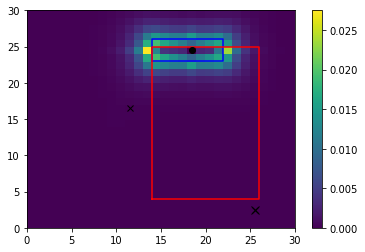

Creating TL
Done in: 0.575068473815918  sec
Memory:  [4560.19921875]
Iteration: 0  Time: 1.2852263450622559  Distance: 67775.6968582  marginal-improvement: -67774.6968582
Iteration: 1  Time: 1.252985954284668  Distance: 6.88797904204  marginal-improvement: 0.999898370959
Iteration: 2  Time: 1.2589337825775146  Distance: 2.22031553987  marginal-improvement: 0.67765355755
Iteration: 3  Time: 1.2613298892974854  Distance: 1.21648718376  marginal-improvement: 0.452110674398
Iteration: 4  Time: 1.256047248840332  Distance: 0.817393709019  marginal-improvement: 0.32807043105
Iteration: 5  Time: 1.2557005882263184  Distance: 0.609225792814  marginal-improvement: 0.254672765287
Iteration: 6  Time: 1.2546522617340088  Distance: 0.490880897525  marginal-improvement: 0.194254571434
Iteration: 7  Time: 1.252100944519043  Distance: 0.413143335353  marginal-improvement: 0.158363388277
Iteration: 8  Time: 1.256986141204834  Distance: 0.358474437144  marginal-improvement: 0.132324289249
Iteration: 9  

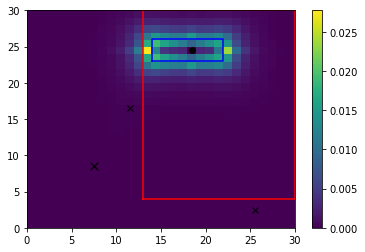

Creating TL
Done in: 0.5984249114990234  sec
Memory:  [4558.2109375]
Iteration: 0  Time: 1.2856006622314453  Distance: 67806.1602316  marginal-improvement: -67805.1602316
Iteration: 1  Time: 1.2808218002319336  Distance: 6.87947714751  marginal-improvement: 0.999898542004
Iteration: 2  Time: 1.2806754112243652  Distance: 2.21829187336  marginal-improvement: 0.677549350656
Iteration: 3  Time: 1.283585786819458  Distance: 1.21554149322  marginal-improvement: 0.452037169763
Iteration: 4  Time: 1.2822265625  Distance: 0.816841379345  marginal-improvement: 0.328002060068
Iteration: 5  Time: 1.2906670570373535  Distance: 0.608872818275  marginal-improvement: 0.254600913137
Iteration: 6  Time: 1.2817716598510742  Distance: 0.490551313576  marginal-improvement: 0.194328768091
Iteration: 7  Time: 1.2860510349273682  Distance: 0.412878560725  marginal-improvement: 0.15833767172
Iteration: 8  Time: 1.2850158214569092  Distance: 0.358247549884  marginal-improvement: 0.13231738346
Iteration: 9  Tim

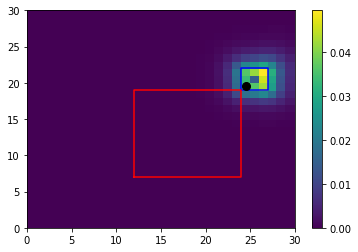

Creating TL
Done in: 1.1068248748779297  sec
Memory:  [7474.3828125]
Iteration: 0  Time: 2.7200870513916016  Distance: 0.998959821263  marginal-improvement: 0.00104017873673
Iteration: 1  Time: 2.3491413593292236  Distance: 5.20161541724  marginal-improvement: -4.20703166085
Iteration: 2  Time: 2.3460652828216553  Distance: 1.70091377807  marginal-improvement: 0.673002780554
Iteration: 3  Time: 2.341752290725708  Distance: 0.87234293896  marginal-improvement: 0.487132769333
Iteration: 4  Time: 2.349010705947876  Distance: 0.532501820055  marginal-improvement: 0.389572843118
Iteration: 5  Time: 2.3310859203338623  Distance: 0.354620250944  marginal-improvement: 0.334048753284
Iteration: 6  Time: 2.3440358638763428  Distance: 0.248542734624  marginal-improvement: 0.299129889052
Iteration: 7  Time: 2.3378875255584717  Distance: 0.180070492469  marginal-improvement: 0.275494845013
Iteration: 8  Time: 2.346796989440918  Distance: 0.135887842407  marginal-improvement: 0.245363076739
Iteratio

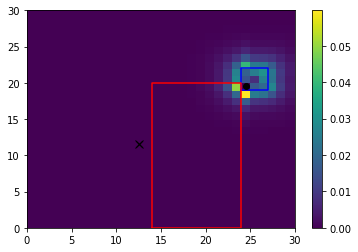

Creating TL
Done in: 0.7072098255157471  sec
Memory:  [5380.00390625]
Iteration: 0  Time: 1.537790298461914  Distance: 44892.1481507  marginal-improvement: -44891.1481507
Iteration: 1  Time: 1.5557630062103271  Distance: 6.34642280186  marginal-improvement: 0.999858629559
Iteration: 2  Time: 1.55271315574646  Distance: 2.0481328444  marginal-improvement: 0.677277592693
Iteration: 3  Time: 1.535470962524414  Distance: 1.10267233406  marginal-improvement: 0.461620696589
Iteration: 4  Time: 1.535017490386963  Distance: 0.736220655286  marginal-improvement: 0.332330527807
Iteration: 5  Time: 1.533118486404419  Distance: 0.552377154479  marginal-improvement: 0.249712500576
Iteration: 6  Time: 1.5348711013793945  Distance: 0.436896875281  marginal-improvement: 0.209060563533
Iteration: 7  Time: 1.5395958423614502  Distance: 0.357563348741  marginal-improvement: 0.181584101486
Iteration: 8  Time: 1.5455796718597412  Distance: 0.299661653765  marginal-improvement: 0.161934088547
Iteration: 9  

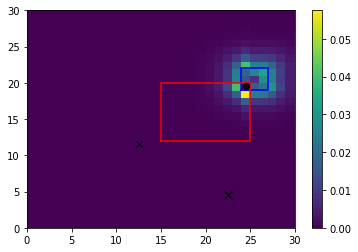

Creating TL
Done in: 0.601811408996582  sec
Memory:  [5231.234375]
Iteration: 0  Time: 1.3039982318878174  Distance: 52927.6947177  marginal-improvement: -52926.6947177
Iteration: 1  Time: 1.3239331245422363  Distance: 5.87762069432  marginal-improvement: 0.999888949996
Iteration: 2  Time: 1.314420223236084  Distance: 1.88184573904  marginal-improvement: 0.679828652288
Iteration: 3  Time: 1.3075783252716064  Distance: 0.983435263748  marginal-improvement: 0.477409203451
Iteration: 4  Time: 1.3081142902374268  Distance: 0.62152893753  marginal-improvement: 0.368002185359
Iteration: 5  Time: 1.3134093284606934  Distance: 0.443184428345  marginal-improvement: 0.286944820129
Iteration: 6  Time: 1.3094549179077148  Distance: 0.335266778308  marginal-improvement: 0.243505058244
Iteration: 7  Time: 1.3102240562438965  Distance: 0.267616487043  marginal-improvement: 0.201780479435
Iteration: 8  Time: 1.3167273998260498  Distance: 0.223605843978  marginal-improvement: 0.164454154343
Iteration: 

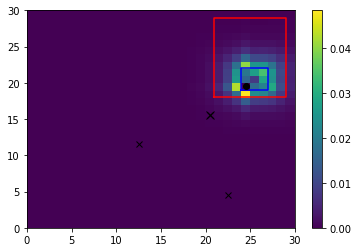

Creating TL
Done in: 0.3098902702331543  sec
Memory:  [5007.83984375]
Iteration: 0  Time: 0.6588795185089111  Distance: 2000509.13903  marginal-improvement: -2000508.13903
Iteration: 1  Time: 0.6622731685638428  Distance: 5.47586461348  marginal-improvement: 0.999997262765
Iteration: 2  Time: 0.6673905849456787  Distance: 1.99325710019  marginal-improvement: 0.635992260421
Iteration: 3  Time: 0.6639742851257324  Distance: 1.11405472374  marginal-improvement: 0.441088295318
Iteration: 4  Time: 0.659287691116333  Distance: 0.740298847298  marginal-improvement: 0.335491487515
Iteration: 5  Time: 0.6650428771972656  Distance: 0.538670366442  marginal-improvement: 0.272360927742
Iteration: 6  Time: 0.6616301536560059  Distance: 0.414246588639  marginal-improvement: 0.230983149537
Iteration: 7  Time: 0.6581344604492188  Distance: 0.330344890172  marginal-improvement: 0.202540469296
Iteration: 8  Time: 0.6628494262695312  Distance: 0.271110849655  marginal-improvement: 0.179309692019
Iteratio

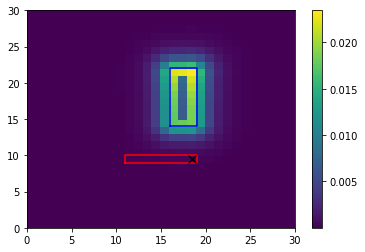

Creating TL
Done in: 6.993738412857056  sec
Memory:  [9397.734375]
Iteration: 0  Time: 15.915941715240479  Distance: 0.996504760432  marginal-improvement: 0.00349523956825
Iteration: 1  Time: 13.673346519470215  Distance: 1.25880089332  marginal-improvement: -0.26321613634
Iteration: 2  Time: 13.491527318954468  Distance: 0.611971939918  marginal-improvement: 0.513845324414
Iteration: 3  Time: 13.51792860031128  Distance: 0.370762550322  marginal-improvement: 0.394151061286
Iteration: 4  Time: 13.429158210754395  Distance: 0.248394905334  marginal-improvement: 0.330043163425
Iteration: 5  Time: 13.445860624313354  Distance: 0.176865803161  marginal-improvement: 0.287965254669
Iteration: 6  Time: 13.408207178115845  Distance: 0.131164046917  marginal-improvement: 0.258397923326
Iteration: 7  Time: 13.425055027008057  Distance: 0.100957652627  marginal-improvement: 0.230294772077
Iteration: 8  Time: 13.416716575622559  Distance: 0.0799713931037  marginal-improvement: 0.207871904483
Itera

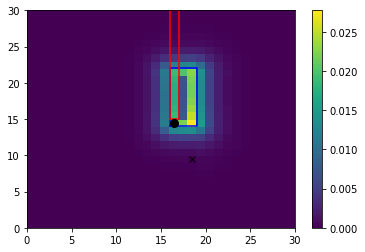

Creating TL
Done in: 0.7749226093292236  sec
Memory:  [5968.28125]
Iteration: 0  Time: 1.6680378913879395  Distance: 2194.43608863  marginal-improvement: -2193.43608863
Iteration: 1  Time: 1.6806831359863281  Distance: 5.8747034451  marginal-improvement: 0.997322909755
Iteration: 2  Time: 1.6733624935150146  Distance: 1.91173825862  marginal-improvement: 0.674581316914
Iteration: 3  Time: 1.6901068687438965  Distance: 1.0077820292  marginal-improvement: 0.472845184402
Iteration: 4  Time: 1.6727774143218994  Distance: 0.636717510422  marginal-improvement: 0.368199181991
Iteration: 5  Time: 1.6864562034606934  Distance: 0.442484006593  marginal-improvement: 0.305054440391
Iteration: 6  Time: 1.6802403926849365  Distance: 0.325042550412  marginal-improvement: 0.265414013685
Iteration: 7  Time: 1.6823227405548096  Distance: 0.271823514221  marginal-improvement: 0.163729444415
Iteration: 8  Time: 1.6967122554779053  Distance: 0.232054030247  marginal-improvement: 0.146306268198
Iteration: 9

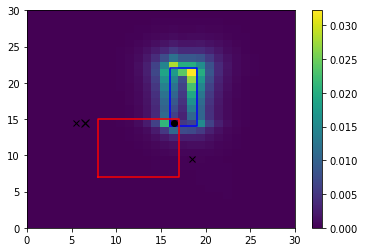

Creating TL
Done in: 0.4388918876647949  sec
Memory:  [4280.5234375]
Iteration: 0  Time: 0.9954628944396973  Distance: 2538.58990787  marginal-improvement: -2537.58990787
Iteration: 1  Time: 0.962695837020874  Distance: 6.40748692575  marginal-improvement: 0.997475966124
Iteration: 2  Time: 0.9591314792633057  Distance: 1.69752461436  marginal-improvement: 0.735071700648
Iteration: 3  Time: 0.9593510627746582  Distance: 0.758237130083  marginal-improvement: 0.55332775521
Iteration: 4  Time: 0.9656190872192383  Distance: 0.411820393871  marginal-improvement: 0.456871237859
Iteration: 5  Time: 0.9637172222137451  Distance: 0.247602606745  marginal-improvement: 0.398760696579
Iteration: 6  Time: 0.9608218669891357  Distance: 0.170315651621  marginal-improvement: 0.312141120567
Iteration: 7  Time: 0.9588935375213623  Distance: 0.122625737693  marginal-improvement: 0.280008991975
Iteration: 8  Time: 0.9615011215209961  Distance: 0.0896489992829  marginal-improvement: 0.268921835091
Iteratio

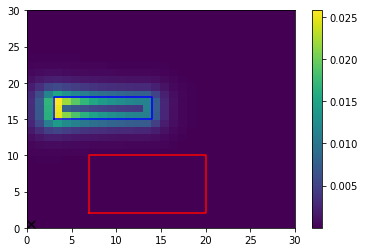

Creating TL
Done in: 9.327192306518555  sec
Memory:  [8556.5625]
Iteration: 0  Time: 17.987539052963257  Distance: 0.996215876073  marginal-improvement: 0.00378412392665
Iteration: 1  Time: 17.501851081848145  Distance: 0.808341943196  marginal-improvement: 0.18858757162
Iteration: 2  Time: 17.525328397750854  Distance: 0.322497436005  marginal-improvement: 0.601038349279
Iteration: 3  Time: 17.58815836906433  Distance: 0.160635716637  marginal-improvement: 0.50190079454
Iteration: 4  Time: 17.492109298706055  Distance: 0.0874728518711  marginal-improvement: 0.455458264809
Iteration: 5  Time: 17.548588752746582  Distance: 0.0467288365907  marginal-improvement: 0.465790407068
Iteration: 6  Time: 17.537890434265137  Distance: 0.0246766331775  marginal-improvement: 0.47191852017
Iteration: 7  Time: 17.535994291305542  Distance: 0.0129387888611  marginal-improvement: 0.475666361452
Iteration: 8  Time: 17.496869325637817  Distance: 0.00675383455759  marginal-improvement: 0.478016479741
Tota

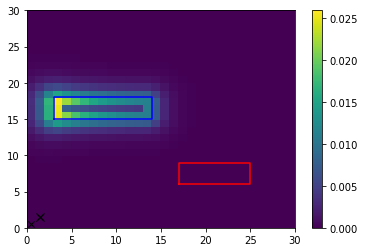

Creating TL
Done in: 9.174122333526611  sec
Memory:  [8392.01171875]
Iteration: 0  Time: 17.696388959884644  Distance: 1.65310751446  marginal-improvement: -0.653107514461
Iteration: 1  Time: 17.331079959869385  Distance: 0.898445573804  marginal-improvement: 0.45651110654
Iteration: 2  Time: 17.311651945114136  Distance: 0.793705554968  marginal-improvement: 0.116579147241
Iteration: 3  Time: 17.256221532821655  Distance: 0.772470983832  marginal-improvement: 0.0267537136454
Iteration: 4  Time: 17.360722303390503  Distance: 0.763349270241  marginal-improvement: 0.0118084870268
Iteration: 5  Time: 17.281984567642212  Distance: 0.759261989439  marginal-improvement: 0.0053544045443
Iteration: 6  Time: 17.280205249786377  Distance: 0.757343799076  marginal-improvement: 0.00252638797917
Iteration: 7  Time: 17.230692625045776  Distance: 0.756408263825  marginal-improvement: 0.00123528475729
Iteration: 8  Time: 17.30102562904358  Distance: 0.755940578986  marginal-improvement: 0.000618296838

/home/ahaimovici/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log


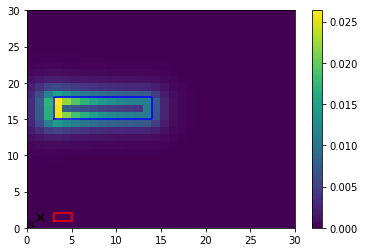

Repeated sample: Skipping the Actualization of M and TL
Non-zeros in M: 191.0944  x 10^6
Memory after updating: [6186.29296875]
FALTAN: 2 Examples
Move:  749
Selected sample: (4, 2)
FALTAN: 1 Examples
Move:  750
Selected sample: (5, 2)
Selected box: (9, 11, 1, 12)


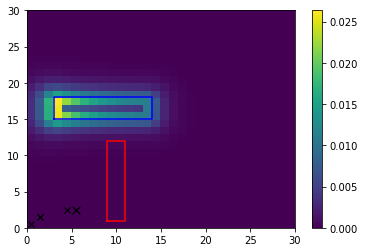

Creating TL
Done in: 8.478019714355469  sec
Memory:  [8174.02734375]
Iteration: 0  Time: 16.354094982147217  Distance: 2.17059266273  marginal-improvement: -1.17059266273
Iteration: 1  Time: 16.35310959815979  Distance: 1.32145514466  marginal-improvement: 0.391200768645
Iteration: 2  Time: 16.441927433013916  Distance: 0.822512580017  marginal-improvement: 0.377570564281
Iteration: 3  Time: 16.405619144439697  Distance: 0.786585727817  marginal-improvement: 0.0436793953944
Iteration: 4  Time: 16.506326913833618  Distance: 0.766174375016  marginal-improvement: 0.0259493047984
Iteration: 5  Time: 16.490512132644653  Distance: 0.755296800188  marginal-improvement: 0.0141972574171
Iteration: 6  Time: 16.547523975372314  Distance: 0.749806467896  marginal-improvement: 0.00726910572124
Iteration: 7  Time: 16.527263164520264  Distance: 0.747128200954  marginal-improvement: 0.00357194430371
Iteration: 8  Time: 16.597645044326782  Distance: 0.745841881768  marginal-improvement: 0.0017216846916

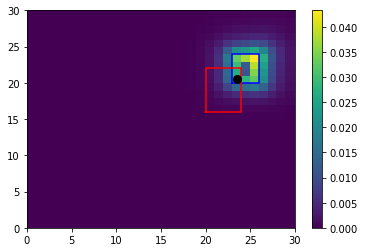

Creating TL
Done in: 1.202026605606079  sec
Memory:  [8518.359375]
Iteration: 0  Time: 2.7140703201293945  Distance: 0.99890687901  marginal-improvement: 0.00109312098951
Iteration: 1  Time: 2.5322530269622803  Distance: 5.08295235775  marginal-improvement: -4.08851471999
Iteration: 2  Time: 2.5255260467529297  Distance: 1.65021747944  marginal-improvement: 0.675342721454
Iteration: 3  Time: 2.5437331199645996  Distance: 0.838795163287  marginal-improvement: 0.491706290998
Iteration: 4  Time: 2.5100245475769043  Distance: 0.506033011473  marginal-improvement: 0.396714438016
Iteration: 5  Time: 2.5120413303375244  Distance: 0.332094423103  marginal-improvement: 0.343729725978
Iteration: 6  Time: 2.497408151626587  Distance: 0.228738995177  marginal-improvement: 0.311223015913
Iteration: 7  Time: 2.5098354816436768  Distance: 0.162441822607  marginal-improvement: 0.289837648883
Iteration: 8  Time: 2.5060207843780518  Distance: 0.123317596034  marginal-improvement: 0.240850699319
Iteratio

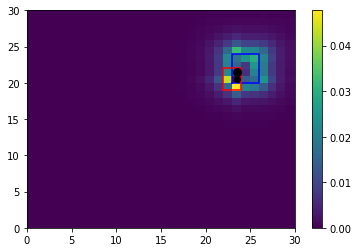

Creating TL
Done in: 1.0556623935699463  sec
Memory:  [6585.546875]
Iteration: 0  Time: 2.23337984085083  Distance: 0.998879140106  marginal-improvement: 0.00112085989425
Iteration: 1  Time: 2.248920202255249  Distance: 4.91630408113  marginal-improvement: -3.92182075261
Iteration: 2  Time: 2.240415096282959  Distance: 1.62416218598  marginal-improvement: 0.669637565297
Iteration: 3  Time: 2.2554805278778076  Distance: 0.828447382483  marginal-improvement: 0.489923241881
Iteration: 4  Time: 2.2417659759521484  Distance: 0.500871439336  marginal-improvement: 0.395409473278
Iteration: 5  Time: 2.241670608520508  Distance: 0.329149764282  marginal-improvement: 0.342845811456
Iteration: 6  Time: 2.2645230293273926  Distance: 0.22688185362  marginal-improvement: 0.310703277837
Iteration: 7  Time: 2.2615416049957275  Distance: 0.161179037137  marginal-improvement: 0.289590442932
Iteration: 8  Time: 2.228362560272217  Distance: 0.121903330766  marginal-improvement: 0.243677509609
Iteration: 9

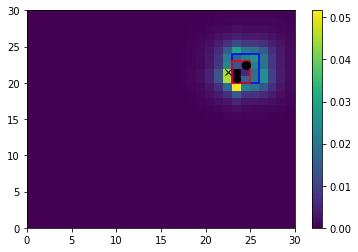

Creating TL
Done in: 0.7722635269165039  sec
Memory:  [6393.375]
Iteration: 0  Time: 1.6878762245178223  Distance: 0.998842090034  marginal-improvement: 0.00115790996585
Iteration: 1  Time: 1.671194314956665  Distance: 4.30358200069  marginal-improvement: -3.30857093791
Iteration: 2  Time: 1.6630980968475342  Distance: 1.5446270533  marginal-improvement: 0.641083392147
Iteration: 3  Time: 1.6544921398162842  Distance: 0.806503612389  marginal-improvement: 0.47786515155
Iteration: 4  Time: 1.6575539112091064  Distance: 0.492401581991  marginal-improvement: 0.389461405471
Iteration: 5  Time: 1.6383256912231445  Distance: 0.325349506792  marginal-improvement: 0.339259826347
Iteration: 6  Time: 1.647221565246582  Distance: 0.225069947242  marginal-improvement: 0.308221028329
Iteration: 7  Time: 1.643941879272461  Distance: 0.160318402479  marginal-improvement: 0.287695205673
Iteration: 8  Time: 1.651658535003662  Distance: 0.121443442765  marginal-improvement: 0.24248594742
Iteration: 9  T

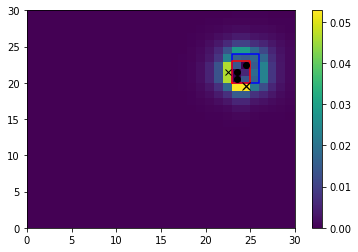

Creating TL
Done in: 0.021197080612182617  sec
Memory:  [5849.4375]
Iteration: 0  Time: 0.0533144474029541  Distance: 5054616.31526  marginal-improvement: -5054615.31526
Iteration: 1  Time: 0.053157806396484375  Distance: 1.95342328247  marginal-improvement: 0.999999613537
Iteration: 2  Time: 0.051787376403808594  Distance: 0.650961327124  marginal-improvement: 0.666758693333
Iteration: 3  Time: 0.051856279373168945  Distance: 0.308853427524  marginal-improvement: 0.525542586549
Iteration: 4  Time: 0.05315589904785156  Distance: 0.16798137221  marginal-improvement: 0.456112973857
Iteration: 5  Time: 0.052161216735839844  Distance: 0.0973142349463  marginal-improvement: 0.420684367166
Iteration: 6  Time: 0.051833391189575195  Distance: 0.0582507337481  marginal-improvement: 0.401416105463
Iteration: 7  Time: 0.05241966247558594  Distance: 0.0355056951216  marginal-improvement: 0.390467847578
Iteration: 8  Time: 0.05325007438659668  Distance: 0.0218696625178  marginal-improvement: 0.3840

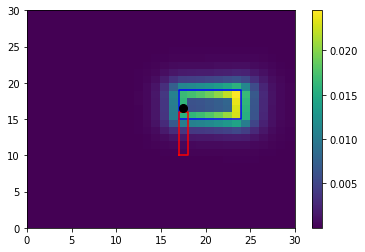

Creating TL
Done in: 2.2072982788085938  sec
Memory:  [7331.6171875]
Iteration: 0  Time: 4.773429870605469  Distance: 0.998571520443  marginal-improvement: 0.00142847955726
Iteration: 1  Time: 4.2082836627960205  Distance: 2.73355230981  marginal-improvement: -1.73746271934
Iteration: 2  Time: 4.164500951766968  Distance: 0.805460289758  marginal-improvement: 0.705343012143
Iteration: 3  Time: 4.2043616771698  Distance: 0.349232047494  marginal-improvement: 0.566419286047
Iteration: 4  Time: 4.141136407852173  Distance: 0.174690629637  marginal-improvement: 0.499786371582
Iteration: 5  Time: 4.207986831665039  Distance: 0.094644444874  marginal-improvement: 0.45821681981
Iteration: 6  Time: 4.128019094467163  Distance: 0.0557907393075  marginal-improvement: 0.410522832251
Iteration: 7  Time: 4.0813117027282715  Distance: 0.0326595954186  marginal-improvement: 0.414605437676
Iteration: 8  Time: 4.101054430007935  Distance: 0.0190124656636  marginal-improvement: 0.417859730965
Iteration:

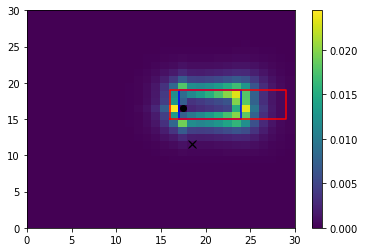

Creating TL
Done in: 0.6017258167266846  sec
Memory:  [4937.171875]
Iteration: 0  Time: 1.3039255142211914  Distance: 9273.31657284  marginal-improvement: -9272.31657284
Iteration: 1  Time: 1.3093907833099365  Distance: 11.6270232819  marginal-improvement: 0.998746185015
Iteration: 2  Time: 1.3160836696624756  Distance: 4.34646853513  marginal-improvement: 0.626175296141
Iteration: 3  Time: 1.3161280155181885  Distance: 2.59319612643  marginal-improvement: 0.403378603694
Iteration: 4  Time: 1.316347599029541  Distance: 1.7909061789  marginal-improvement: 0.309382672351
Iteration: 5  Time: 1.3166756629943848  Distance: 1.28483133789  marginal-improvement: 0.282580319937
Iteration: 6  Time: 1.321528434753418  Distance: 0.912362908937  marginal-improvement: 0.289896749845
Iteration: 7  Time: 1.3236210346221924  Distance: 0.656780277926  marginal-improvement: 0.28013264076
Iteration: 8  Time: 1.3143794536590576  Distance: 0.537352979159  marginal-improvement: 0.181837522807
Iteration: 9  T

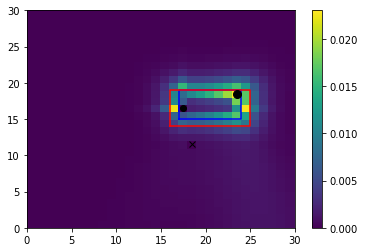

Creating TL
Done in: 0.20657968521118164  sec
Memory:  [4325.55078125]
Iteration: 0  Time: 0.4281456470489502  Distance: 4697.31451842  marginal-improvement: -4696.31451842
Iteration: 1  Time: 0.43263792991638184  Distance: 1.76019840622  marginal-improvement: 0.999625275591
Iteration: 2  Time: 0.4322481155395508  Distance: 0.521706046604  marginal-improvement: 0.703609522221
Iteration: 3  Time: 0.43381190299987793  Distance: 0.215362898822  marginal-improvement: 0.587194934343
Iteration: 4  Time: 0.43638062477111816  Distance: 0.0993234462427  marginal-improvement: 0.538808927694
Iteration: 5  Time: 0.4361996650695801  Distance: 0.0508778733926  marginal-improvement: 0.48775565773
Iteration: 6  Time: 0.4324476718902588  Distance: 0.0266734812657  marginal-improvement: 0.475735138144
Iteration: 7  Time: 0.4367673397064209  Distance: 0.0139027000687  marginal-improvement: 0.478781943378
Iteration: 8  Time: 0.43247056007385254  Distance: 0.00721500463606  marginal-improvement: 0.48103572

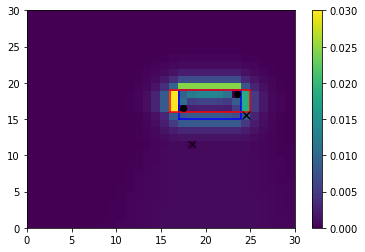

Creating TL
Done in: 0.04724287986755371  sec
Memory:  [4088.0703125]
Iteration: 0  Time: 0.1172642707824707  Distance: 11078.3117765  marginal-improvement: -11077.3117765
Iteration: 1  Time: 0.11048173904418945  Distance: 2.5398591791  marginal-improvement: 0.9997707359
Iteration: 2  Time: 0.1119537353515625  Distance: 0.586855866737  marginal-improvement: 0.768941572995
Iteration: 3  Time: 0.11098670959472656  Distance: 0.225599302358  marginal-improvement: 0.615579710207
Iteration: 4  Time: 0.11179804801940918  Distance: 0.113129008241  marginal-improvement: 0.498540079429
Iteration: 5  Time: 0.1133573055267334  Distance: 0.0559366527171  marginal-improvement: 0.505549871013
Iteration: 6  Time: 0.11135435104370117  Distance: 0.0287140993664  marginal-improvement: 0.486667543165
Iteration: 7  Time: 0.11180257797241211  Distance: 0.014865407343  marginal-improvement: 0.482295887003
Iteration: 8  Time: 0.11217141151428223  Distance: 0.00768386137605  marginal-improvement: 0.48310455282

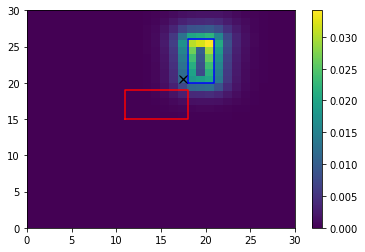

Creating TL
Done in: 7.169721364974976  sec
Memory:  [9382.73828125]
Iteration: 0  Time: 14.764954090118408  Distance: 0.996534753905  marginal-improvement: 0.00346524609547
Iteration: 1  Time: 13.38659930229187  Distance: 1.17178769817  marginal-improvement: -0.175862350591
Iteration: 2  Time: 13.429993867874146  Distance: 0.562865342336  marginal-improvement: 0.519652456486
Iteration: 3  Time: 13.355414628982544  Distance: 0.336162985618  marginal-improvement: 0.402764817207
Iteration: 4  Time: 13.352860927581787  Distance: 0.222659209842  marginal-improvement: 0.337645072872
Iteration: 5  Time: 13.325804948806763  Distance: 0.156860016911  marginal-improvement: 0.295515253907
Iteration: 6  Time: 13.33391284942627  Distance: 0.115398566811  marginal-improvement: 0.264321341512
Iteration: 7  Time: 13.29490041732788  Distance: 0.0892644232777  marginal-improvement: 0.226468527781
Iteration: 8  Time: 13.364028692245483  Distance: 0.069927896057  marginal-improvement: 0.216620760104
Iter

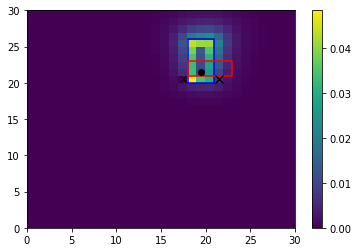

Creating TL
Done in: 6.348615884780884  sec
Memory:  [9538.421875]
Iteration: 0  Time: 12.506850481033325  Distance: 0.996704875412  marginal-improvement: 0.0032951245882
Iteration: 1  Time: 12.716349124908447  Distance: 1.48518929657  marginal-improvement: -0.490099359611
Iteration: 2  Time: 12.578203678131104  Distance: 0.777658268745  marginal-improvement: 0.47639114385
Iteration: 3  Time: 12.666860103607178  Distance: 0.505163954469  marginal-improvement: 0.350403673732
Iteration: 4  Time: 12.63447904586792  Distance: 0.361113948775  marginal-improvement: 0.285154956959
Iteration: 5  Time: 12.679449558258057  Distance: 0.272875860058  marginal-improvement: 0.244349710158
Iteration: 6  Time: 12.657181739807129  Distance: 0.213851779469  marginal-improvement: 0.216303782154
Iteration: 7  Time: 12.715673923492432  Distance: 0.171671681044  marginal-improvement: 0.197239875812
Iteration: 8  Time: 12.628437042236328  Distance: 0.139863642608  marginal-improvement: 0.185284132143
Iterati

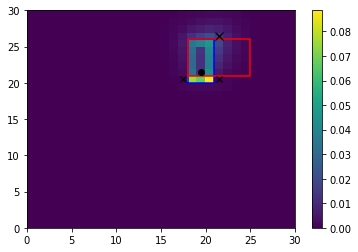

Creating TL
Done in: 6.146644353866577  sec
Memory:  [9387.6796875]
Iteration: 0  Time: 12.089855909347534  Distance: 1.13439770688  marginal-improvement: -0.134397706883
Iteration: 1  Time: 12.297008514404297  Distance: 2.02822440971  marginal-improvement: -0.787930632622
Iteration: 2  Time: 12.273979425430298  Distance: 1.13509633457  marginal-improvement: 0.440349731948
Iteration: 3  Time: 12.189284324645996  Distance: 0.77639338071  marginal-improvement: 0.31601102297
Iteration: 4  Time: 12.2552170753479  Distance: 0.581562529342  marginal-improvement: 0.250943472997
Iteration: 5  Time: 12.141509056091309  Distance: 0.45917535545  marginal-improvement: 0.210445425414
Iteration: 6  Time: 12.230377912521362  Distance: 0.375011372577  marginal-improvement: 0.183293771919
Iteration: 7  Time: 12.22253131866455  Distance: 0.312757465998  marginal-improvement: 0.166005383121
Iteration: 8  Time: 12.23938798904419  Distance: 0.264578265114  marginal-improvement: 0.154046525253
Iteration: 9 

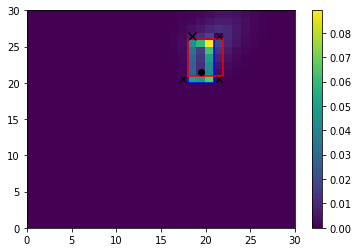

Creating TL
Done in: 5.912820100784302  sec
Memory:  [9301.37109375]
Iteration: 0  Time: 11.761738777160645  Distance: 1.13393192792  marginal-improvement: -0.133931927922
Iteration: 1  Time: 11.922294855117798  Distance: 2.07680171306  marginal-improvement: -0.831504750792
Iteration: 2  Time: 11.932260513305664  Distance: 1.1798010177  marginal-improvement: 0.431914462378
Iteration: 3  Time: 11.96932339668274  Distance: 0.818882607979  marginal-improvement: 0.305914645187
Iteration: 4  Time: 11.904723405838013  Distance: 0.621670334947  marginal-improvement: 0.240830945865
Iteration: 5  Time: 11.945725679397583  Distance: 0.496987592943  marginal-improvement: 0.200560868028
Iteration: 6  Time: 11.985867500305176  Distance: 0.41026055093  marginal-improvement: 0.174505446906
Iteration: 7  Time: 12.09618353843689  Distance: 0.345360109728  marginal-improvement: 0.158193228802
Iteration: 8  Time: 12.026230096817017  Distance: 0.294587473789  marginal-improvement: 0.147013608431
Iteration

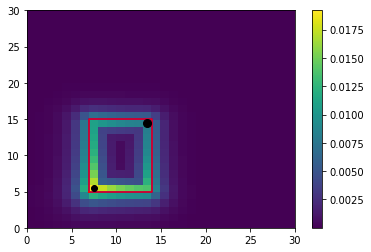

Creating TL
Done in: 2.1099166870117188  sec
Memory:  [7118.59375]
Iteration: 0  Time: 5.3421385288238525  Distance: 0.998540488132  marginal-improvement: 0.00145951186773
Iteration: 1  Time: 4.300277948379517  Distance: 2.43235925262  marginal-improvement: -1.43591449874
Iteration: 2  Time: 4.374589204788208  Distance: 0.703820064096  marginal-improvement: 0.710643046113
Iteration: 3  Time: 4.306212663650513  Distance: 0.296037218739  marginal-improvement: 0.579385081727
Iteration: 4  Time: 4.264241695404053  Distance: 0.142755165318  marginal-improvement: 0.517779669982
Iteration: 5  Time: 4.293724536895752  Distance: 0.075384441074  marginal-improvement: 0.471931954924
Iteration: 6  Time: 4.295179128646851  Distance: 0.0421610858144  marginal-improvement: 0.440718997001
Iteration: 7  Time: 4.295445442199707  Distance: 0.0234163039598  marginal-improvement: 0.444599124822
Iteration: 8  Time: 4.311794996261597  Distance: 0.012937154057  marginal-improvement: 0.447515112582
Iteration: 

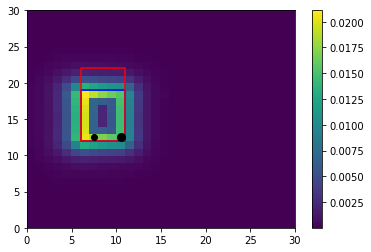

Creating TL
Done in: 1.9136321544647217  sec
Memory:  [7914.43359375]
Iteration: 0  Time: 3.9925079345703125  Distance: 0.998647481149  marginal-improvement: 0.00135251885086
Iteration: 1  Time: 3.971668004989624  Distance: 3.27000385648  marginal-improvement: -2.27443258828
Iteration: 2  Time: 3.7710723876953125  Distance: 0.99302710483  marginal-improvement: 0.696322344434
Iteration: 3  Time: 3.897035837173462  Distance: 0.453435822621  marginal-improvement: 0.543380215489
Iteration: 4  Time: 3.879157304763794  Distance: 0.241577838602  marginal-improvement: 0.467228157657
Iteration: 5  Time: 3.86972713470459  Distance: 0.138478888318  marginal-improvement: 0.426773212646
Iteration: 6  Time: 3.8520212173461914  Distance: 0.087156788655  marginal-improvement: 0.370613169173
Iteration: 7  Time: 3.964524269104004  Distance: 0.0559968905433  marginal-improvement: 0.357515445355
Iteration: 8  Time: 3.7553956508636475  Distance: 0.0358375064802  marginal-improvement: 0.360008990989
Iterati

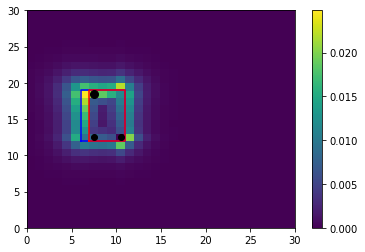

Creating TL
Done in: 0.7951059341430664  sec
Memory:  [5677.91015625]
Iteration: 0  Time: 1.7210075855255127  Distance: 0.998117049051  marginal-improvement: 0.00188295094931
Iteration: 1  Time: 1.7018489837646484  Distance: 1.55588568643  marginal-improvement: -0.558820869662
Iteration: 2  Time: 1.7025883197784424  Distance: 0.558741759073  marginal-improvement: 0.640885083045
Iteration: 3  Time: 1.69529128074646  Distance: 0.259772749283  marginal-improvement: 0.535075470797
Iteration: 4  Time: 1.7019548416137695  Distance: 0.13643808723  marginal-improvement: 0.474779061288
Iteration: 5  Time: 1.7037522792816162  Distance: 0.0792475686131  marginal-improvement: 0.419168281952
Iteration: 6  Time: 1.7040371894836426  Distance: 0.0480215105671  marginal-improvement: 0.394031748765
Iteration: 7  Time: 1.6996517181396484  Distance: 0.0292172579157  marginal-improvement: 0.391579782255
Iteration: 8  Time: 1.7079846858978271  Distance: 0.0178184773501  marginal-improvement: 0.390138615967


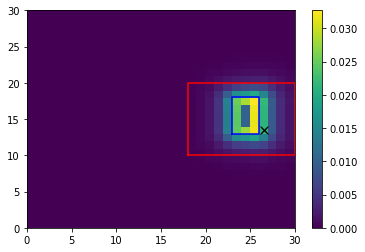

Creating TL
Done in: 8.109724283218384  sec
Memory:  [9433.31640625]
Iteration: 0  Time: 15.819823265075684  Distance: 0.997219643491  marginal-improvement: 0.00278035650862
Iteration: 1  Time: 15.403844833374023  Distance: 1.1741145238  marginal-improvement: -0.177388082415
Iteration: 2  Time: 15.404281854629517  Distance: 0.566110925378  marginal-improvement: 0.517840113631
Iteration: 3  Time: 15.36180853843689  Distance: 0.32222835785  marginal-improvement: 0.430803499094
Iteration: 4  Time: 15.374090671539307  Distance: 0.22137320048  marginal-improvement: 0.312992804366
Iteration: 5  Time: 15.368216276168823  Distance: 0.161188203465  marginal-improvement: 0.271871197075
Iteration: 6  Time: 15.378949403762817  Distance: 0.118596539653  marginal-improvement: 0.264235613379
Iteration: 7  Time: 15.41755223274231  Distance: 0.0881246358415  marginal-improvement: 0.256937545572
Iteration: 8  Time: 15.394456148147583  Distance: 0.0660448015498  marginal-improvement: 0.250552346467
Itera

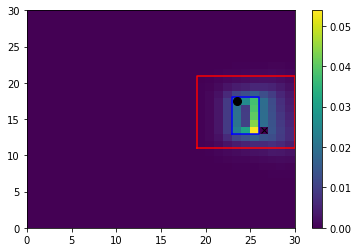

Creating TL
Done in: 0.6769535541534424  sec
Memory:  [5722.8359375]
Iteration: 0  Time: 1.4875891208648682  Distance: 5.5412250711  marginal-improvement: -4.5412250711
Iteration: 1  Time: 1.4691064357757568  Distance: 6.0485913157  marginal-improvement: -0.0915621073119
Iteration: 2  Time: 1.4662187099456787  Distance: 1.9427954963  marginal-improvement: 0.678801989604
Iteration: 3  Time: 1.4667649269104004  Distance: 1.01162273962  marginal-improvement: 0.479295303313
Iteration: 4  Time: 1.460073709487915  Distance: 0.628507832338  marginal-improvement: 0.378713222113
Iteration: 5  Time: 1.470405101776123  Distance: 0.425498444524  marginal-improvement: 0.323002160624
Iteration: 6  Time: 1.4696934223175049  Distance: 0.302684390272  marginal-improvement: 0.288635730243
Iteration: 7  Time: 1.4669289588928223  Distance: 0.222234818702  marginal-improvement: 0.265786985242
Iteration: 8  Time: 1.4664430618286133  Distance: 0.17069962981  marginal-improvement: 0.231895205227
Iteration: 9 

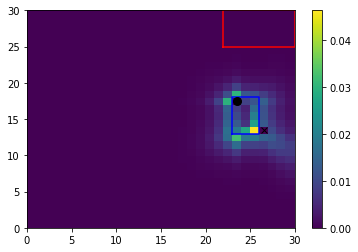

Repeated sample: Skipping the Actualization of M and TL
Non-zeros in M: 19.61232  x 10^6
Memory after updating: [3762.72265625]
FALTAN: 2 Examples
Move:  821
Selected sample: (26, 15)
FALTAN: 1 Examples
Move:  822
Selected sample: (23, 14)
Selected box: (21, 25, 12, 20)


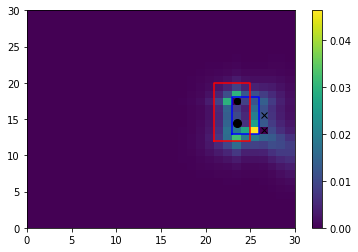

Creating TL
Done in: 0.4736466407775879  sec
Memory:  [3852.3671875]
Iteration: 0  Time: 1.0189709663391113  Distance: 1.28487474948  marginal-improvement: -0.284874749477
Iteration: 1  Time: 1.0136442184448242  Distance: 4.10479673935  marginal-improvement: -2.19470574157
Iteration: 2  Time: 1.0150728225708008  Distance: 1.34062672807  marginal-improvement: 0.673399972472
Iteration: 3  Time: 1.025496006011963  Distance: 0.671866330669  marginal-improvement: 0.498841611462
Iteration: 4  Time: 1.016442060470581  Distance: 0.404815298703  marginal-improvement: 0.397476432105
Iteration: 5  Time: 1.02237868309021  Distance: 0.267753830845  marginal-improvement: 0.338577786703
Iteration: 6  Time: 1.0184738636016846  Distance: 0.186905600371  marginal-improvement: 0.301949855278
Iteration: 7  Time: 1.0253698825836182  Distance: 0.134993959293  marginal-improvement: 0.277742566167
Iteration: 8  Time: 1.0180742740631104  Distance: 0.101540278725  marginal-improvement: 0.247816130019
Iteration:

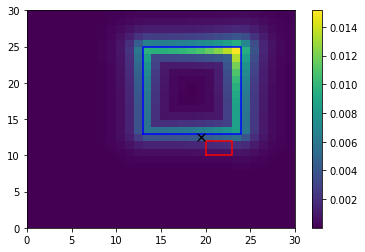

Creating TL
Done in: 6.799719572067261  sec
Memory:  [9587.0390625]
Iteration: 0  Time: 13.23205280303955  Distance: 0.996487746933  marginal-improvement: 0.00351225306675
Iteration: 1  Time: 13.133085250854492  Distance: 1.09658301877  marginal-improvement: -0.100448070878
Iteration: 2  Time: 13.152705669403076  Distance: 0.520200435904  marginal-improvement: 0.525616914541
Iteration: 3  Time: 13.115562915802002  Distance: 0.306801522053  marginal-improvement: 0.410224404139
Iteration: 4  Time: 13.113611221313477  Distance: 0.200833218391  marginal-improvement: 0.34539692943
Iteration: 5  Time: 13.13353943824768  Distance: 0.140247326868  marginal-improvement: 0.301672661566
Iteration: 6  Time: 13.144346475601196  Distance: 0.103239420288  marginal-improvement: 0.263876021077
Iteration: 7  Time: 13.0665442943573  Distance: 0.0791392584545  marginal-improvement: 0.23343953081
Iteration: 8  Time: 13.22289776802063  Distance: 0.0615917933188  marginal-improvement: 0.221728955747
Iteratio

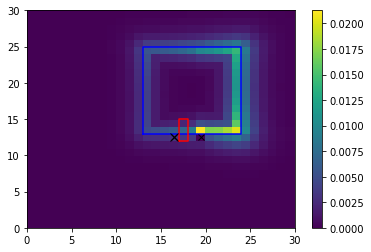

Creating TL
Done in: 6.043651342391968  sec
Memory:  [9431.84375]
Iteration: 0  Time: 11.979346513748169  Distance: 0.996368815038  marginal-improvement: 0.00363118496203
Iteration: 1  Time: 12.020934820175171  Distance: 0.98993123943  marginal-improvement: 0.00646103682801
Iteration: 2  Time: 12.082393646240234  Distance: 0.474217511915  marginal-improvement: 0.520959140366
Iteration: 3  Time: 12.05684232711792  Distance: 0.28420291361  marginal-improvement: 0.400690808607
Iteration: 4  Time: 12.047702312469482  Distance: 0.189817990914  marginal-improvement: 0.332103993928
Iteration: 5  Time: 12.08634328842163  Distance: 0.135350946752  marginal-improvement: 0.286943528904
Iteration: 6  Time: 12.070464134216309  Distance: 0.101071180115  marginal-improvement: 0.25326580611
Iteration: 7  Time: 12.142005443572998  Distance: 0.0780652686546  marginal-improvement: 0.227620884947
Iteration: 8  Time: 12.134196758270264  Distance: 0.062153919769  marginal-improvement: 0.203821099444
Iterati

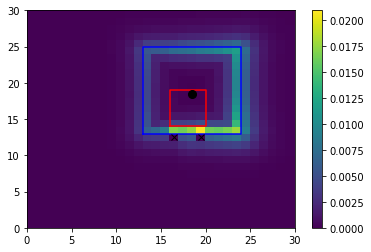

Creating TL
Done in: 0.5132901668548584  sec
Memory:  [6514.5859375]
Iteration: 0  Time: 1.1534972190856934  Distance: 57537.7584842  marginal-improvement: -57536.7584842
Iteration: 1  Time: 1.1127722263336182  Distance: 24.678623154  marginal-improvement: 0.999571088207
Iteration: 2  Time: 1.117366075515747  Distance: 7.60188989064  marginal-improvement: 0.691964586387
Iteration: 3  Time: 1.1229889392852783  Distance: 3.237305847  marginal-improvement: 0.574144601728
Iteration: 4  Time: 1.1220107078552246  Distance: 1.34611597508  marginal-improvement: 0.584186345468
Iteration: 5  Time: 1.1154115200042725  Distance: 0.594480862159  marginal-improvement: 0.558373221056
Iteration: 6  Time: 1.1176564693450928  Distance: 0.52406344869  marginal-improvement: 0.118451943453
Iteration: 7  Time: 1.1128759384155273  Distance: 0.466832640508  marginal-improvement: 0.109205876359
Iteration: 8  Time: 1.1144382953643799  Distance: 0.420720593559  marginal-improvement: 0.098776398537
Iteration: 9  

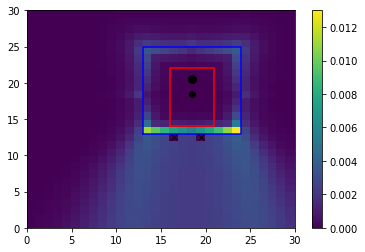

Creating TL
Done in: 0.4371635913848877  sec
Memory:  [5061.82421875]
Iteration: 0  Time: 0.9254074096679688  Distance: 34013.233442  marginal-improvement: -34012.233442
Iteration: 1  Time: 0.9299056529998779  Distance: 22.5190507029  marginal-improvement: 0.999337932668
Iteration: 2  Time: 0.9376752376556396  Distance: 7.45084675387  marginal-improvement: 0.669131401133
Iteration: 3  Time: 0.9320838451385498  Distance: 3.26010556683  marginal-improvement: 0.56245166831
Iteration: 4  Time: 0.9323410987854004  Distance: 1.37086903033  marginal-improvement: 0.579501644278
Iteration: 5  Time: 0.9346809387207031  Distance: 0.595898670396  marginal-improvement: 0.565313201181
Iteration: 6  Time: 0.9332406520843506  Distance: 0.526076553647  marginal-improvement: 0.117171123578
Iteration: 7  Time: 0.9315598011016846  Distance: 0.469004687641  marginal-improvement: 0.10848585745
Iteration: 8  Time: 0.9339618682861328  Distance: 0.422840415497  marginal-improvement: 0.0984303000807
Iteration: 

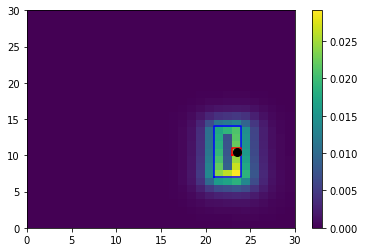

Creating TL
Done in: 1.277137041091919  sec
Memory:  [6883.49609375]
Iteration: 0  Time: 3.267991304397583  Distance: 0.998884014372  marginal-improvement: 0.00111598562834
Iteration: 1  Time: 2.644413471221924  Distance: 4.66931788009  marginal-improvement: -3.67453459352
Iteration: 2  Time: 2.6352410316467285  Distance: 1.53942831539  marginal-improvement: 0.670309806502
Iteration: 3  Time: 2.630432367324829  Distance: 0.779264824659  marginal-improvement: 0.49379596512
Iteration: 4  Time: 2.6400671005249023  Distance: 0.466673366715  marginal-improvement: 0.40113636347
Iteration: 5  Time: 2.6502842903137207  Distance: 0.303948626972  marginal-improvement: 0.348690864637
Iteration: 6  Time: 2.6301324367523193  Distance: 0.207843946238  marginal-improvement: 0.316187250759
Iteration: 7  Time: 2.656414031982422  Distance: 0.146837220212  marginal-improvement: 0.293521784636
Iteration: 8  Time: 2.6485331058502197  Distance: 0.111564728815  marginal-improvement: 0.240214921984
Iteration:

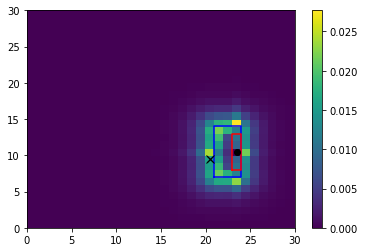

Creating TL
Done in: 0.2010185718536377  sec
Memory:  [4482.2578125]
Iteration: 0  Time: 0.4263882637023926  Distance: 2722.9435732  marginal-improvement: -2721.9435732
Iteration: 1  Time: 0.42983031272888184  Distance: 13.7159163992  marginal-improvement: 0.994962834877
Iteration: 2  Time: 0.4319431781768799  Distance: 5.59516777203  marginal-improvement: 0.592067521469
Iteration: 3  Time: 0.4308505058288574  Distance: 3.64164157156  marginal-improvement: 0.349145241047
Iteration: 4  Time: 0.42877984046936035  Distance: 2.79007836952  marginal-improvement: 0.233840476968
Iteration: 5  Time: 0.4296689033508301  Distance: 2.29605559963  marginal-improvement: 0.17706411952
Iteration: 6  Time: 0.438018798828125  Distance: 1.95136872892  marginal-improvement: 0.150121308374
Iteration: 7  Time: 0.43053436279296875  Distance: 1.68709819666  marginal-improvement: 0.135428291097
Iteration: 8  Time: 0.43059396743774414  Distance: 1.4748615894  marginal-improvement: 0.125799794985
Iteration: 9  

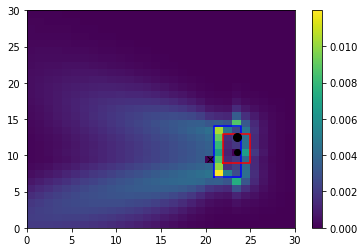

Creating TL
Done in: 0.1670818328857422  sec
Memory:  [4161.66015625]
Iteration: 0  Time: 0.3779442310333252  Distance: 2183.88384145  marginal-improvement: -2182.88384145
Iteration: 1  Time: 0.37432432174682617  Distance: 11.325227104  marginal-improvement: 0.99481418064
Iteration: 2  Time: 0.3995704650878906  Distance: 4.90273904591  marginal-improvement: 0.567095741139
Iteration: 3  Time: 0.3923459053039551  Distance: 3.2669354896  marginal-improvement: 0.333650953271
Iteration: 4  Time: 0.3935375213623047  Distance: 2.52878244427  marginal-improvement: 0.225946624192
Iteration: 5  Time: 0.3951599597930908  Distance: 2.10161013834  marginal-improvement: 0.168924102944
Iteration: 6  Time: 0.39119505882263184  Distance: 1.79691559455  marginal-improvement: 0.14498147788
Iteration: 7  Time: 0.3942301273345947  Distance: 1.56302306922  marginal-improvement: 0.13016333435
Iteration: 8  Time: 0.39197278022766113  Distance: 1.37453614994  marginal-improvement: 0.120591258694
Iteration: 9  

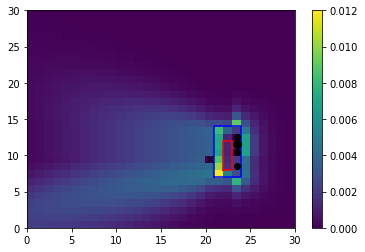

Creating TL
Done in: 0.18283963203430176  sec
Memory:  [4181.0078125]
Iteration: 0  Time: 0.37882232666015625  Distance: 2218.72180712  marginal-improvement: -2217.72180712
Iteration: 1  Time: 0.3846588134765625  Distance: 11.3918046451  marginal-improvement: 0.994865600271
Iteration: 2  Time: 0.3844130039215088  Distance: 4.91398726044  marginal-improvement: 0.568638384037
Iteration: 3  Time: 0.389096736907959  Distance: 3.272675235  marginal-improvement: 0.334008197102
Iteration: 4  Time: 0.3856813907623291  Distance: 2.5330697605  marginal-improvement: 0.225994155054
Iteration: 5  Time: 0.3883943557739258  Distance: 2.10514511708  marginal-improvement: 0.168935198744
Iteration: 6  Time: 0.38689160346984863  Distance: 1.79991411539  marginal-improvement: 0.144992855463
Iteration: 7  Time: 0.38341641426086426  Distance: 1.56552878508  marginal-improvement: 0.130220285683
Iteration: 8  Time: 0.38274073600769043  Distance: 1.37659793281  marginal-improvement: 0.120681813113
Iteration: 9

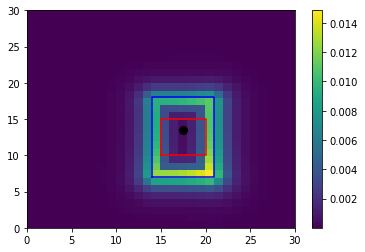

Creating TL
Done in: 2.0089359283447266  sec
Memory:  [7980.390625]
Iteration: 0  Time: 4.199398994445801  Distance: 0.998571486993  marginal-improvement: 0.00142851300684
Iteration: 1  Time: 4.1278369426727295  Distance: 2.73334471725  marginal-improvement: -1.73725492151
Iteration: 2  Time: 4.0948779582977295  Distance: 0.805368194563  marginal-improvement: 0.705354326704
Iteration: 3  Time: 4.0912086963653564  Distance: 0.349182952849  marginal-improvement: 0.566430664625
Iteration: 4  Time: 4.083997964859009  Distance: 0.174662319115  marginal-improvement: 0.499797118701
Iteration: 5  Time: 4.130585193634033  Distance: 0.0946315337224  marginal-improvement: 0.458202924353
Iteration: 6  Time: 4.065187692642212  Distance: 0.0557816226246  marginal-improvement: 0.410538745063
Iteration: 7  Time: 4.113590478897095  Distance: 0.0326533877577  marginal-improvement: 0.41462104863
Iteration: 8  Time: 4.09186863899231  Distance: 0.0190083446321  marginal-improvement: 0.417875266936
Iteratio

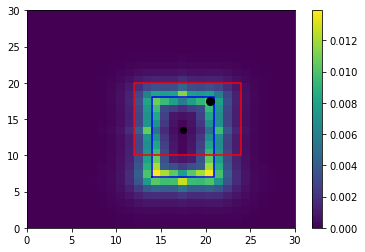

Creating TL
Done in: 1.0770583152770996  sec
Memory:  [5859.71875]
Iteration: 0  Time: 2.282144784927368  Distance: 0.997956670848  marginal-improvement: 0.00204332915202
Iteration: 1  Time: 2.302823781967163  Distance: 1.56438241069  marginal-improvement: -0.567585503851
Iteration: 2  Time: 2.280648708343506  Distance: 0.51282907503  marginal-improvement: 0.672184325569
Iteration: 3  Time: 2.3027217388153076  Distance: 0.220280750764  marginal-improvement: 0.570459707747
Iteration: 4  Time: 2.2960588932037354  Distance: 0.106293934283  marginal-improvement: 0.517461539811
Iteration: 5  Time: 2.2861361503601074  Distance: 0.0568584145062  marginal-improvement: 0.465083168765
Iteration: 6  Time: 2.303532123565674  Distance: 0.0312270654214  marginal-improvement: 0.45079253981
Iteration: 7  Time: 2.291743516921997  Distance: 0.0171197635215  marginal-improvement: 0.451765214231
Iteration: 8  Time: 2.2712950706481934  Distance: 0.00937276870738  marginal-improvement: 0.452517629954
Total 

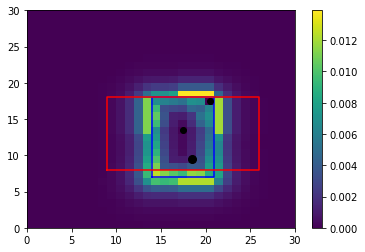

Creating TL
Done in: 0.7352597713470459  sec
Memory:  [5431.6640625]
Iteration: 0  Time: 1.6216011047363281  Distance: 0.9979155932  marginal-improvement: 0.00208440679969
Iteration: 1  Time: 1.5923562049865723  Distance: 1.23492755029  marginal-improvement: -0.237507018336
Iteration: 2  Time: 1.5941169261932373  Distance: 0.430496445879  marginal-improvement: 0.65139943167
Iteration: 3  Time: 1.5901803970336914  Distance: 0.186395965644  marginal-improvement: 0.567020895461
Iteration: 4  Time: 1.5857627391815186  Distance: 0.0893311287222  marginal-improvement: 0.520745374431
Iteration: 5  Time: 1.5801353454589844  Distance: 0.0461318365576  marginal-improvement: 0.483586100193
Iteration: 6  Time: 1.585519552230835  Distance: 0.0248001116734  marginal-improvement: 0.462407883058
Iteration: 7  Time: 1.5846178531646729  Distance: 0.0133450815248  marginal-improvement: 0.461894297067
Iteration: 8  Time: 1.59086012840271  Distance: 0.00718453535577  marginal-improvement: 0.461634210147
To

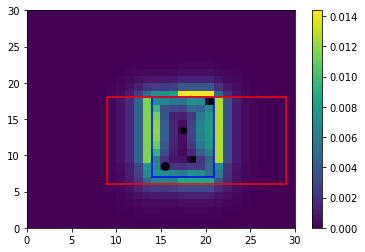

Creating TL
Done in: 0.5869836807250977  sec
Memory:  [5240.03125]
Iteration: 0  Time: 1.2521336078643799  Distance: 0.997764009654  marginal-improvement: 0.00223599034631
Iteration: 1  Time: 1.2567882537841797  Distance: 0.940179503169  marginal-improvement: 0.0577135534326
Iteration: 2  Time: 1.2688813209533691  Distance: 0.32299247156  marginal-improvement: 0.656456591032
Iteration: 3  Time: 1.2645056247711182  Distance: 0.132228280668  marginal-improvement: 0.590614976166
Iteration: 4  Time: 1.2681167125701904  Distance: 0.0583958095105  marginal-improvement: 0.558371256016
Iteration: 5  Time: 1.2676198482513428  Distance: 0.0272871984812  marginal-improvement: 0.532719921003
Iteration: 6  Time: 1.261505365371704  Distance: 0.0131060097874  marginal-improvement: 0.519701159631
Iteration: 7  Time: 1.2640724182128906  Distance: 0.00627182324672  marginal-improvement: 0.521454405388
Total SK iteration time: 10.10809850692749
Non-zeros in M: 16.771328  x 10^6
Memory after updating: [49

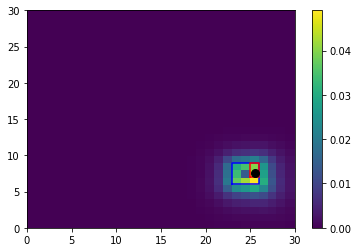

Creating TL
Done in: 0.8620233535766602  sec
Memory:  [6735.18359375]
Iteration: 0  Time: 3.8505780696868896  Distance: 1.21655275302  marginal-improvement: -0.216552753016
Iteration: 1  Time: 1.637556552886963  Distance: 6.72768878308  marginal-improvement: -4.53012499163
Iteration: 2  Time: 1.6378059387207031  Distance: 2.25804335694  marginal-improvement: 0.664365664088
Iteration: 3  Time: 1.6291179656982422  Distance: 1.19860747748  marginal-improvement: 0.469183143095
Iteration: 4  Time: 1.6289896965026855  Distance: 0.759571714241  marginal-improvement: 0.366288189829
Iteration: 5  Time: 1.6259212493896484  Distance: 0.525304717233  marginal-improvement: 0.308419853736
Iteration: 6  Time: 1.6275227069854736  Distance: 0.382286833823  marginal-improvement: 0.272256994308
Iteration: 7  Time: 1.623979091644287  Distance: 0.287547265159  marginal-improvement: 0.247823258041
Iteration: 8  Time: 1.6348340511322021  Distance: 0.221300233849  marginal-improvement: 0.230386581049
Iteratio

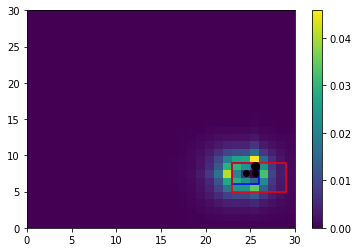

Creating TL
Done in: 0.7068336009979248  sec
Memory:  [4767.85546875]
Iteration: 0  Time: 1.5530133247375488  Distance: 0.999058573292  marginal-improvement: 0.000941426708077
Iteration: 1  Time: 1.547051191329956  Distance: 6.01719376789  marginal-improvement: -5.02286385278
Iteration: 2  Time: 1.5486915111541748  Distance: 2.0781715825  marginal-improvement: 0.654627777886
Iteration: 3  Time: 1.5537636280059814  Distance: 1.10228000375  marginal-improvement: 0.469591436513
Iteration: 4  Time: 1.553368330001831  Distance: 0.695370365558  marginal-improvement: 0.369152698779
Iteration: 5  Time: 1.5483241081237793  Distance: 0.478379786648  marginal-improvement: 0.312050368635
Iteration: 6  Time: 1.5590879917144775  Distance: 0.346259813062  marginal-improvement: 0.276182182596
Iteration: 7  Time: 1.5493876934051514  Distance: 0.259063513565  marginal-improvement: 0.251823330942
Iteration: 8  Time: 1.542067289352417  Distance: 0.198355333375  marginal-improvement: 0.234337052543
Iterati

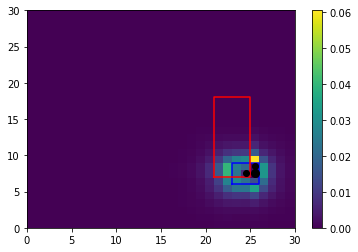

Repeated sample: Skipping the Actualization of M and TL
Non-zeros in M: 20.544444  x 10^6
Memory after updating: [4521.82421875]
FALTAN: 1 Examples
Move:  915
Selected sample: (24, 8)
Selected box: (21, 29, 5, 23)


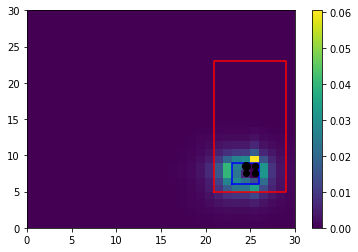

Creating TL
Done in: 0.6743853092193604  sec
Memory:  [4738.36328125]
Iteration: 0  Time: 1.4632811546325684  Distance: 0.998980191235  marginal-improvement: 0.001019808765
Iteration: 1  Time: 1.4762568473815918  Distance: 5.30839058376  marginal-improvement: -4.31380965342
Iteration: 2  Time: 1.4740476608276367  Distance: 1.86552353685  marginal-improvement: 0.648570784795
Iteration: 3  Time: 1.47709321975708  Distance: 0.985399812445  marginal-improvement: 0.471783768482
Iteration: 4  Time: 1.473346471786499  Distance: 0.61452449207  marginal-improvement: 0.376370398787
Iteration: 5  Time: 1.4744040966033936  Distance: 0.416458254767  marginal-improvement: 0.32230812581
Iteration: 6  Time: 1.4791367053985596  Distance: 0.296259371164  marginal-improvement: 0.288621685912
Iteration: 7  Time: 1.474778175354004  Distance: 0.217443928515  marginal-improvement: 0.266035272873
Iteration: 8  Time: 1.4773459434509277  Distance: 0.163064043864  marginal-improvement: 0.250086930557
Iteration: 

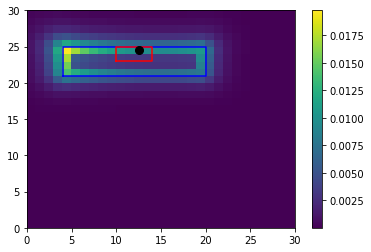

Creating TL
Done in: 1.2008614540100098  sec
Memory:  [7567.06640625]
Iteration: 0  Time: 2.617072343826294  Distance: 0.998932592834  marginal-improvement: 0.00106740716615
Iteration: 1  Time: 2.490696430206299  Distance: 4.69059611117  marginal-improvement: -3.69560823705
Iteration: 2  Time: 2.496067523956299  Distance: 1.5251240593  marginal-improvement: 0.67485496019
Iteration: 3  Time: 2.505990743637085  Distance: 0.775394706736  marginal-improvement: 0.491585814275
Iteration: 4  Time: 2.5075550079345703  Distance: 0.469670977437  marginal-improvement: 0.394281424213
Iteration: 5  Time: 2.505319356918335  Distance: 0.310994208323  marginal-improvement: 0.337846655929
Iteration: 6  Time: 2.492924213409424  Distance: 0.21713181795  marginal-improvement: 0.301813949782
Iteration: 7  Time: 2.4991824626922607  Distance: 0.156940928886  marginal-improvement: 0.277208976704
Iteration: 8  Time: 2.4784576892852783  Distance: 0.118631517964  marginal-improvement: 0.244100829487
Iteration: 9

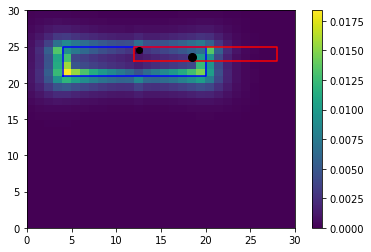

Creating TL
Done in: 0.6997060775756836  sec
Memory:  [5446.21875]
Iteration: 0  Time: 1.5184571743011475  Distance: 0.998609778991  marginal-improvement: 0.00139022100925
Iteration: 1  Time: 1.5196137428283691  Distance: 2.42944948713  marginal-improvement: -1.43283166081
Iteration: 2  Time: 1.5209753513336182  Distance: 0.916327384085  marginal-improvement: 0.622825093117
Iteration: 3  Time: 1.5224871635437012  Distance: 0.472378896254  marginal-improvement: 0.484486762637
Iteration: 4  Time: 1.517317295074463  Distance: 0.283473355193  marginal-improvement: 0.399902583623
Iteration: 5  Time: 1.5184922218322754  Distance: 0.184671095463  marginal-improvement: 0.34854161042
Iteration: 6  Time: 1.5215702056884766  Distance: 0.126256566935  marginal-improvement: 0.316316575592
Iteration: 7  Time: 1.5169646739959717  Distance: 0.0896399949418  marginal-improvement: 0.290017168076
Iteration: 8  Time: 1.5241703987121582  Distance: 0.0662881025106  marginal-improvement: 0.260507516163
Itera

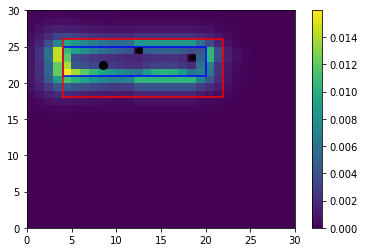

Creating TL
Done in: 0.4593782424926758  sec
Memory:  [5160.23828125]
Iteration: 0  Time: 1.0192146301269531  Distance: 0.998403687588  marginal-improvement: 0.00159631241233
Iteration: 1  Time: 0.9857861995697021  Distance: 1.66965350204  marginal-improvement: -0.672323052088
Iteration: 2  Time: 0.9874577522277832  Distance: 0.693084526712  marginal-improvement: 0.584893197383
Iteration: 3  Time: 0.9837453365325928  Distance: 0.362985708037  marginal-improvement: 0.47627497939
Iteration: 4  Time: 0.9829297065734863  Distance: 0.215098173557  marginal-improvement: 0.407419717101
Iteration: 5  Time: 0.9876387119293213  Distance: 0.136817405858  marginal-improvement: 0.363930415605
Iteration: 6  Time: 0.99149489402771  Distance: 0.090818421344  marginal-improvement: 0.336207109219
Iteration: 7  Time: 0.992560863494873  Distance: 0.0628347953707  marginal-improvement: 0.308127201059
Iteration: 8  Time: 0.9824607372283936  Distance: 0.0445473090337  marginal-improvement: 0.291040755828
Ite

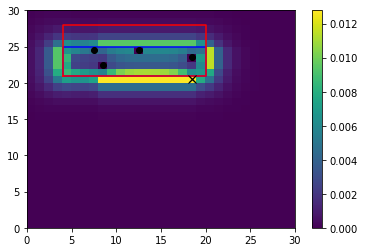

Creating TL
Done in: 0.023291587829589844  sec
Memory:  [4808.77734375]
Iteration: 0  Time: 0.06115412712097168  Distance: 7329529.1333  marginal-improvement: -7329528.1333
Iteration: 1  Time: 0.05909085273742676  Distance: 0.467086215011  marginal-improvement: 0.999999936273
Iteration: 2  Time: 0.05861711502075195  Distance: 0.0663987794113  marginal-improvement: 0.857844703446
Iteration: 3  Time: 0.058324575424194336  Distance: 0.0184003498808  marginal-improvement: 0.722881202878
Iteration: 4  Time: 0.05816221237182617  Distance: 0.00483946306482  marginal-improvement: 0.73699070419
Total SK iteration time: 0.2982347011566162
Non-zeros in M: 1.16032  x 10^6
Memory after updating: [4667.859375]
31
32
33
###########################################
############### NEW TRIAL #################
###########################################
True hypothesis: (3, 6, 8, 20)
FALTAN: 5 Examples
Move:  1009
Selected sample: (4, 14)
FALTAN: 4 Examples
Move:  1010
Selected sample: (7, 8)
Selected bo

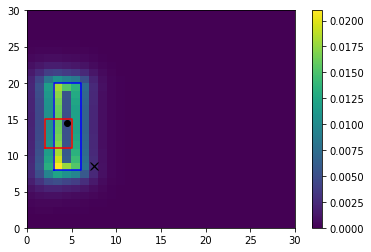

Creating TL
Done in: 8.724310398101807  sec
Memory:  [9523.046875]
Iteration: 0  Time: 16.795339107513428  Distance: 0.996738982573  marginal-improvement: 0.00326101742735
Iteration: 1  Time: 14.7093825340271  Distance: 1.70251638077  marginal-improvement: -0.708086480554
Iteration: 2  Time: 14.606986045837402  Distance: 0.860910802246  marginal-improvement: 0.494330385323
Iteration: 3  Time: 14.564523458480835  Distance: 0.541597353688  marginal-improvement: 0.370901895673
Iteration: 4  Time: 14.435003519058228  Distance: 0.37422694054  marginal-improvement: 0.309031076331
Iteration: 5  Time: 14.400784492492676  Distance: 0.273363768413  marginal-improvement: 0.269524080713
Iteration: 6  Time: 14.323044776916504  Distance: 0.207156380296  marginal-improvement: 0.242195183733
Iteration: 7  Time: 14.43794846534729  Distance: 0.161083734835  marginal-improvement: 0.222405148205
Iteration: 8  Time: 14.347724914550781  Distance: 0.131826171425  marginal-improvement: 0.18162953224
Iteration

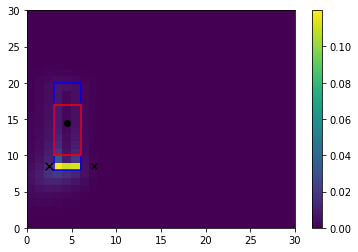

Creating TL
Done in: 7.227796792984009  sec
Memory:  [9094.5703125]
Iteration: 0  Time: 14.125646591186523  Distance: 1.63315052815  marginal-improvement: -0.633150528154
Iteration: 1  Time: 14.135728120803833  Distance: 2.15984581095  marginal-improvement: -0.322502594656
Iteration: 2  Time: 14.186051607131958  Distance: 1.15038174592  marginal-improvement: 0.467377837767
Iteration: 3  Time: 14.226216316223145  Distance: 0.750881689655  marginal-improvement: 0.347276073946
Iteration: 4  Time: 14.287370204925537  Distance: 0.538201974978  marginal-improvement: 0.283239979889
Iteration: 5  Time: 14.130311250686646  Distance: 0.407600068409  marginal-improvement: 0.242663372935
Iteration: 6  Time: 14.17069697380066  Distance: 0.319860592488  marginal-improvement: 0.215258736988
Iteration: 7  Time: 14.178718328475952  Distance: 0.25714070427  marginal-improvement: 0.196085074843
Iteration: 8  Time: 14.221077919006348  Distance: 0.222776435993  marginal-improvement: 0.133639939949
Iteratio

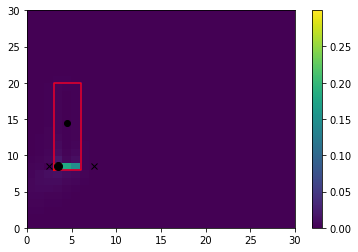

Creating TL
Done in: 0.013415098190307617  sec
Memory:  [5446.39453125]
Iteration: 0  Time: 0.04721808433532715  Distance: 799725621.036  marginal-improvement: -799725620.036
Iteration: 1  Time: 0.033640384674072266  Distance: 2.51295468137  marginal-improvement: 0.999999996858
Iteration: 2  Time: 0.03395962715148926  Distance: 0.448739360275  marginal-improvement: 0.821429585021
Iteration: 3  Time: 0.03419756889343262  Distance: 0.149210497874  marginal-improvement: 0.667489614054
Iteration: 4  Time: 0.03387904167175293  Distance: 0.0597477467278  marginal-improvement: 0.59957410786
Iteration: 5  Time: 0.03385162353515625  Distance: 0.0259981677974  marginal-improvement: 0.564867811404
Iteration: 6  Time: 0.1479356288909912  Distance: 0.0119604659926  marginal-improvement: 0.539949657767
Iteration: 7  Time: 0.0337221622467041  Distance: 0.00571269322803  marginal-improvement: 0.522368674301
Total SK iteration time: 0.4024994373321533
Non-zeros in M: 0.709527  x 10^6
Memory after updat

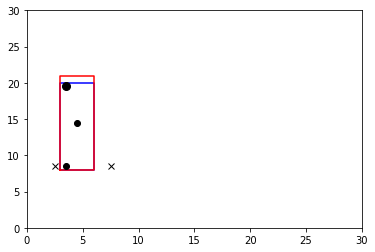

Creating TL
Done in: 0.006499767303466797  sec
Memory:  [3639.49609375]
Iteration: 0  Time: 0.015693187713623047  Distance: 190720497.273  marginal-improvement: -190720496.273
Iteration: 1  Time: 0.015814542770385742  Distance: 0.965782842277  marginal-improvement: 0.999999994936
Iteration: 2  Time: 0.01542806625366211  Distance: 0.289245344905  marginal-improvement: 0.700506850771
Iteration: 3  Time: 0.015101194381713867  Distance: 0.077413334326  marginal-improvement: 0.732361001864
Iteration: 4  Time: 0.015950441360473633  Distance: 0.0183237963698  marginal-improvement: 0.763299223198
Iteration: 5  Time: 0.01593327522277832  Distance: 0.00423962060034  marginal-improvement: 0.768627607796
Total SK iteration time: 0.09759402275085449
Non-zeros in M: 0.353024  x 10^6
Memory after updating: [3639.49609375]
###########################################
############### NEW TRIAL #################
###########################################
True hypothesis: (11, 24, 12, 22)
FALTAN: 5 Examp

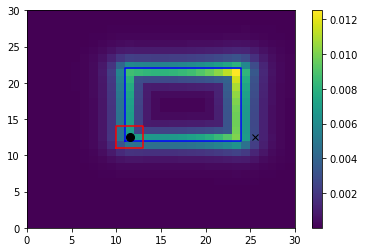

Creating TL
Done in: 2.063654899597168  sec
Memory:  [7927.83984375]
Iteration: 0  Time: 4.073477268218994  Distance: 0.998613770411  marginal-improvement: 0.00138622958924
Iteration: 1  Time: 3.9234235286712646  Distance: 3.07362189244  marginal-improvement: -2.07788855262
Iteration: 2  Time: 3.83849835395813  Distance: 0.922815756956  marginal-improvement: 0.69976275897
Iteration: 3  Time: 3.913909435272217  Distance: 0.413186501039  marginal-improvement: 0.552254609955
Iteration: 4  Time: 3.9126152992248535  Distance: 0.214895898327  marginal-improvement: 0.479905810603
Iteration: 5  Time: 3.971945285797119  Distance: 0.119848880554  marginal-improvement: 0.442293308122
Iteration: 6  Time: 3.9312431812286377  Distance: 0.0740926918218  marginal-improvement: 0.381782362262
Iteration: 7  Time: 3.8954193592071533  Distance: 0.0459186037767  marginal-improvement: 0.380254615568
Iteration: 8  Time: 3.9014499187469482  Distance: 0.0283092498576  marginal-improvement: 0.383490621901
Iterat

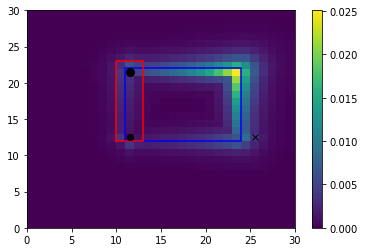

Creating TL
Done in: 0.842456579208374  sec
Memory:  [5701.57421875]
Iteration: 0  Time: 1.835561990737915  Distance: 0.998184579883  marginal-improvement: 0.00181542011691
Iteration: 1  Time: 1.8326928615570068  Distance: 1.52843754381  marginal-improvement: -0.531217346583
Iteration: 2  Time: 1.8331835269927979  Distance: 0.520140340031  marginal-improvement: 0.659691465878
Iteration: 3  Time: 1.838594913482666  Distance: 0.226806235978  marginal-improvement: 0.563951844296
Iteration: 4  Time: 1.8275666236877441  Distance: 0.111201808866  marginal-improvement: 0.509705681653
Iteration: 5  Time: 1.825390338897705  Distance: 0.0579551948076  marginal-improvement: 0.478828668357
Iteration: 6  Time: 1.8431591987609863  Distance: 0.0313351548059  marginal-improvement: 0.459321033948
Iteration: 7  Time: 1.850351095199585  Distance: 0.0177030730047  marginal-improvement: 0.435041150606
Iteration: 8  Time: 1.837541103363037  Distance: 0.0100027976049  marginal-improvement: 0.434968290409
Ite

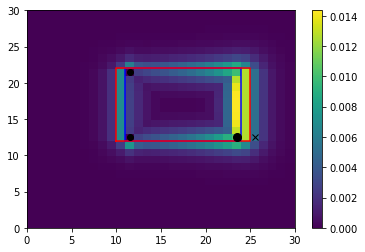

Creating TL
Done in: 0.305706262588501  sec
Memory:  [5080.484375]
Iteration: 0  Time: 0.6198649406433105  Distance: 0.997462394852  marginal-improvement: 0.00253760514764
Iteration: 1  Time: 0.6233646869659424  Distance: 0.513785205016  marginal-improvement: 0.484907694097
Iteration: 2  Time: 0.6294078826904297  Distance: 0.167069534061  marginal-improvement: 0.674826109374
Iteration: 3  Time: 0.630779504776001  Distance: 0.0627370776932  marginal-improvement: 0.624485229782
Iteration: 4  Time: 0.6323802471160889  Distance: 0.0244436522014  marginal-improvement: 0.610379490086
Iteration: 5  Time: 0.6279251575469971  Distance: 0.00966205237249  marginal-improvement: 0.604721410169
Total SK iteration time: 3.7673795223236084
Non-zeros in M: 8.814819  x 10^6
Memory after updating: [4806.34765625]
FALTAN: 1 Examples
Move:  1032
Selected sample: (10, 12)
Selected box: (11, 25, 12, 23)


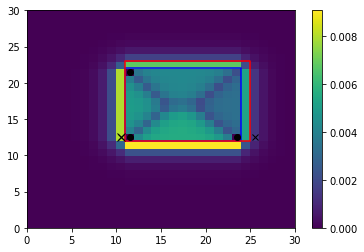

Creating TL
Done in: 0.013637065887451172  sec
Memory:  [4715.25]
Iteration: 0  Time: 0.05488944053649902  Distance: 157.174498643  marginal-improvement: -156.174498643
Iteration: 1  Time: 0.04629397392272949  Distance: 0.288179052667  marginal-improvement: 0.998166502485
Iteration: 2  Time: 0.033987998962402344  Distance: 0.0865548549117  marginal-improvement: 0.699649040725
Iteration: 3  Time: 0.03357434272766113  Distance: 0.0292396577428  marginal-improvement: 0.662183504638
Iteration: 4  Time: 0.03351402282714844  Distance: 0.0101188372335  marginal-improvement: 0.653934484375
Iteration: 5  Time: 0.03331446647644043  Distance: 0.0035662387904  marginal-improvement: 0.647564368503
Total SK iteration time: 0.2385876178741455
Non-zeros in M: 0.732928  x 10^6
Memory after updating: [4614.546875]
34
35
36
###########################################
############### NEW TRIAL #################
###########################################
True hypothesis: (9, 12, 23, 26)
FALTAN: 3 Examples

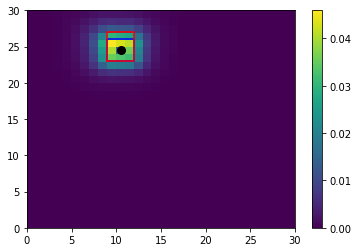

Creating TL
Done in: 1.2164318561553955  sec
Memory:  [6797.73828125]
Iteration: 0  Time: 4.315705299377441  Distance: 0.998959736212  marginal-improvement: 0.00104026378782
Iteration: 1  Time: 2.340331792831421  Distance: 5.20040398253  marginal-improvement: -4.20581940795
Iteration: 2  Time: 2.341644048690796  Distance: 1.70048760944  marginal-improvement: 0.673008555652
Iteration: 3  Time: 2.34420108795166  Distance: 0.872130843748  marginal-improvement: 0.487128962949
Iteration: 4  Time: 2.3479557037353516  Distance: 0.532374980463  marginal-improvement: 0.389569828565
Iteration: 5  Time: 2.346916437149048  Distance: 0.354535003309  marginal-improvement: 0.334050215881
Iteration: 6  Time: 2.3487634658813477  Distance: 0.24848091544  marginal-improvement: 0.299135732381
Iteration: 7  Time: 2.346086263656616  Distance: 0.180023386699  marginal-improvement: 0.275504171498
Iteration: 8  Time: 2.331324815750122  Distance: 0.135860626547  marginal-improvement: 0.245316794453
Iteration: 9

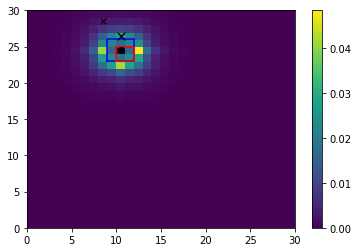

Creating TL
Done in: 0.35209012031555176  sec
Memory:  [4472.40234375]
Iteration: 0  Time: 0.729377031326294  Distance: 2.63459799526  marginal-improvement: -1.63459799526
Iteration: 1  Time: 0.7302951812744141  Distance: 5.98091733016  marginal-improvement: -1.27014418933
Iteration: 2  Time: 0.7287638187408447  Distance: 1.97593626201  marginal-improvement: 0.669626555103
Iteration: 3  Time: 0.7285242080688477  Distance: 1.03087372849  marginal-improvement: 0.47828594054
Iteration: 4  Time: 0.7328295707702637  Distance: 0.645703745425  marginal-improvement: 0.373634493167
Iteration: 5  Time: 0.728114128112793  Distance: 0.443409965045  marginal-improvement: 0.313291942029
Iteration: 6  Time: 0.7309918403625488  Distance: 0.321533528553  marginal-improvement: 0.274861744434
Iteration: 7  Time: 0.728118896484375  Distance: 0.241665597001  marginal-improvement: 0.24839689942
Iteration: 8  Time: 0.7348942756652832  Distance: 0.186288339942  marginal-improvement: 0.229148284847
Iteration: 

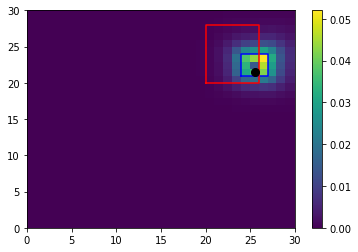

Creating TL
Done in: 0.826756477355957  sec
Memory:  [7362.7578125]
Iteration: 0  Time: 1.8830995559692383  Distance: 1.10957190102  marginal-improvement: -0.109571901021
Iteration: 1  Time: 1.772005558013916  Distance: 6.3402218154  marginal-improvement: -4.71411533544
Iteration: 2  Time: 1.7726104259490967  Distance: 2.11649931919  marginal-improvement: 0.666178979094
Iteration: 3  Time: 1.7727952003479004  Distance: 1.11549705859  marginal-improvement: 0.472951846248
Iteration: 4  Time: 1.7769818305969238  Distance: 0.701705891358  marginal-improvement: 0.370947788744
Iteration: 5  Time: 1.7776947021484375  Distance: 0.481920993677  marginal-improvement: 0.313215123869
Iteration: 6  Time: 1.7730886936187744  Distance: 0.348454645731  marginal-improvement: 0.276946532101
Iteration: 7  Time: 1.76837158203125  Distance: 0.260534177583  marginal-improvement: 0.252315385157
Iteration: 8  Time: 1.7693853378295898  Distance: 0.199402584013  marginal-improvement: 0.234639440159
Iteration: 9

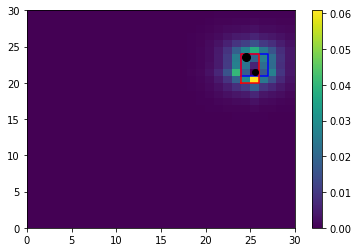

Creating TL
Done in: 0.6077873706817627  sec
Memory:  [5267.9609375]
Iteration: 0  Time: 1.3288588523864746  Distance: 0.999081827744  marginal-improvement: 0.000918172256055
Iteration: 1  Time: 1.3063652515411377  Distance: 5.0224496708  marginal-improvement: -4.02706538276
Iteration: 2  Time: 1.3059651851654053  Distance: 1.83073984041  marginal-improvement: 0.635488663817
Iteration: 3  Time: 1.3049004077911377  Distance: 0.97433811768  marginal-improvement: 0.467789963286
Iteration: 4  Time: 1.3095595836639404  Distance: 0.609208960017  marginal-improvement: 0.374745841344
Iteration: 5  Time: 1.3065531253814697  Distance: 0.413387692164  marginal-improvement: 0.321435304969
Iteration: 6  Time: 1.2907252311706543  Distance: 0.294283972165  marginal-improvement: 0.288116270166
Iteration: 7  Time: 1.2893450260162354  Distance: 0.216074408687  marginal-improvement: 0.26576222586
Iteration: 8  Time: 1.284330129623413  Distance: 0.162060293265  marginal-improvement: 0.249979235167
Iterati

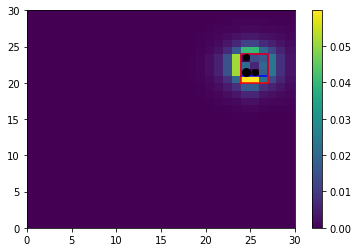

Creating TL
Done in: 0.5963430404663086  sec
Memory:  [5202.0625]
Iteration: 0  Time: 1.2805733680725098  Distance: 0.999081717892  marginal-improvement: 0.000918282108241
Iteration: 1  Time: 1.2976562976837158  Distance: 5.06239006894  marginal-improvement: -4.06704304391
Iteration: 2  Time: 1.2870144844055176  Distance: 1.8354992035  marginal-improvement: 0.637424382851
Iteration: 3  Time: 1.2830336093902588  Distance: 0.975906855979  marginal-improvement: 0.468315293126
Iteration: 4  Time: 1.2863447666168213  Distance: 0.610158331554  marginal-improvement: 0.374778107341
Iteration: 5  Time: 1.2859113216400146  Distance: 0.414085145395  marginal-improvement: 0.321348043645
Iteration: 6  Time: 1.2853386402130127  Distance: 0.294831525674  marginal-improvement: 0.287992991411
Iteration: 7  Time: 1.3061778545379639  Distance: 0.216518254929  marginal-improvement: 0.26562041005
Iteration: 8  Time: 1.3009512424468994  Distance: 0.162426975259  marginal-improvement: 0.249823183211
Iteratio

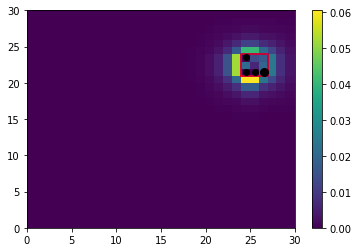

Creating TL
Done in: 0.48571085929870605  sec
Memory:  [5122.4609375]
Iteration: 0  Time: 1.0426311492919922  Distance: 0.999149431622  marginal-improvement: 0.000850568377784
Iteration: 1  Time: 1.0283830165863037  Distance: 4.72922798776  marginal-improvement: -3.73325394389
Iteration: 2  Time: 1.0343201160430908  Distance: 1.79684608275  marginal-improvement: 0.620055094109
Iteration: 3  Time: 1.0305635929107666  Distance: 0.969172120628  marginal-improvement: 0.460625965722
Iteration: 4  Time: 1.0288386344909668  Distance: 0.609570885767  marginal-improvement: 0.371039598856
Iteration: 5  Time: 1.0152812004089355  Distance: 0.415172185999  marginal-improvement: 0.318910735908
Iteration: 6  Time: 1.016887903213501  Distance: 0.296404515429  marginal-improvement: 0.286068466472
Iteration: 7  Time: 1.0206692218780518  Distance: 0.218162572977  marginal-improvement: 0.263970143431
Iteration: 8  Time: 1.023653268814087  Distance: 0.163995959763  marginal-improvement: 0.248285544469
Iter

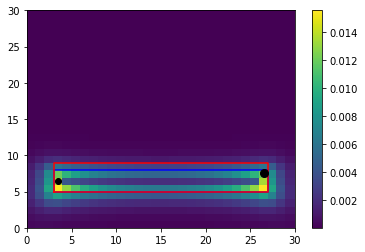

Creating TL
Done in: 0.6902306079864502  sec
Memory:  [6666.96484375]
Iteration: 0  Time: 1.9867796897888184  Distance: 1.34278874935  marginal-improvement: -0.342788749348
Iteration: 1  Time: 1.3248119354248047  Distance: 7.3995300976  marginal-improvement: -4.5105690312
Iteration: 2  Time: 1.3279674053192139  Distance: 2.51016488745  marginal-improvement: 0.660766987316
Iteration: 3  Time: 1.3322784900665283  Distance: 1.34517001014  marginal-improvement: 0.46411089691
Iteration: 4  Time: 1.3365447521209717  Distance: 0.863085225498  marginal-improvement: 0.358382049117
Iteration: 5  Time: 1.3235290050506592  Distance: 0.605637907722  marginal-improvement: 0.298287249243
Iteration: 6  Time: 1.317596197128296  Distance: 0.447954329003  marginal-improvement: 0.260359493202
Iteration: 7  Time: 1.318779468536377  Distance: 0.342940479247  marginal-improvement: 0.234429813391
Iteration: 8  Time: 1.3184010982513428  Distance: 0.268979748523  marginal-improvement: 0.215666377111
Iteration: 

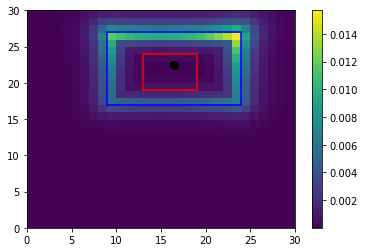

Creating TL
Done in: 1.6079108715057373  sec
Memory:  [7661.796875]
Iteration: 0  Time: 3.3396923542022705  Distance: 0.998780509873  marginal-improvement: 0.0012194901267
Iteration: 1  Time: 3.2457528114318848  Distance: 3.80556862576  marginal-improvement: -2.81021514551
Iteration: 2  Time: 3.2672464847564697  Distance: 1.19849886286  marginal-improvement: 0.68506707388
Iteration: 3  Time: 3.2619876861572266  Distance: 0.581456306366  marginal-improvement: 0.51484617601
Iteration: 4  Time: 3.2657175064086914  Distance: 0.333755985637  marginal-improvement: 0.425999886865
Iteration: 5  Time: 3.2895236015319824  Distance: 0.208474307928  marginal-improvement: 0.375369081306
Iteration: 6  Time: 3.266679286956787  Distance: 0.136786160817  marginal-improvement: 0.343870416571
Iteration: 7  Time: 3.2736520767211914  Distance: 0.096750055607  marginal-improvement: 0.292691197491
Iteration: 8  Time: 3.2259676456451416  Distance: 0.0695103042284  marginal-improvement: 0.281547656047
Iteratio

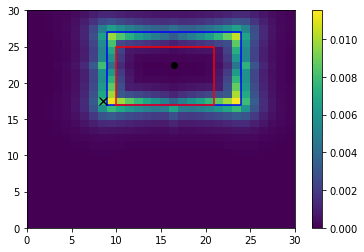

Creating TL
Done in: 0.8157262802124023  sec
Memory:  [5517.98046875]
Iteration: 0  Time: 1.7540867328643799  Distance: 2374.63508853  marginal-improvement: -2373.63508853
Iteration: 1  Time: 1.73941969871521  Distance: 4.45561384392  marginal-improvement: 0.998123663772
Iteration: 2  Time: 1.7557897567749023  Distance: 1.37782986542  marginal-improvement: 0.6907654223
Iteration: 3  Time: 1.7505743503570557  Distance: 0.702674574666  marginal-improvement: 0.49001354064
Iteration: 4  Time: 1.7583324909210205  Distance: 0.425321462388  marginal-improvement: 0.394710613245
Iteration: 5  Time: 1.7414424419403076  Distance: 0.281757412307  marginal-improvement: 0.33754245383
Iteration: 6  Time: 1.7471044063568115  Distance: 0.197418688888  marginal-improvement: 0.299330983802
Iteration: 7  Time: 1.7482953071594238  Distance: 0.143760922673  marginal-improvement: 0.271796791466
Iteration: 8  Time: 1.7570161819458008  Distance: 0.113539471332  marginal-improvement: 0.210220209909
Iteration: 9

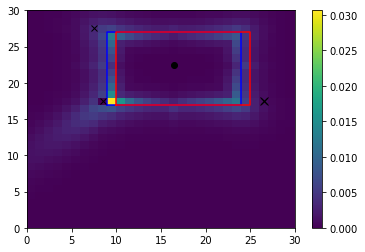

Creating TL
Done in: 0.6493470668792725  sec
Memory:  [5236.33203125]
Iteration: 0  Time: 1.4469163417816162  Distance: 2989.07151893  marginal-improvement: -2988.07151893
Iteration: 1  Time: 1.4153306484222412  Distance: 5.24298923323  marginal-improvement: 0.998245947211
Iteration: 2  Time: 1.4272985458374023  Distance: 1.64395820982  marginal-improvement: 0.68644638837
Iteration: 3  Time: 1.4195284843444824  Distance: 0.834822618518  marginal-improvement: 0.492187445197
Iteration: 4  Time: 1.4190139770507812  Distance: 0.514489048832  marginal-improvement: 0.383714531183
Iteration: 5  Time: 1.417736291885376  Distance: 0.352113505364  marginal-improvement: 0.315605441626
Iteration: 6  Time: 1.4247078895568848  Distance: 0.260540978856  marginal-improvement: 0.260065362767
Iteration: 7  Time: 1.431060552597046  Distance: 0.210724424767  marginal-improvement: 0.191204294649
Iteration: 8  Time: 1.4301764965057373  Distance: 0.174168812705  marginal-improvement: 0.173475913397
Iteration

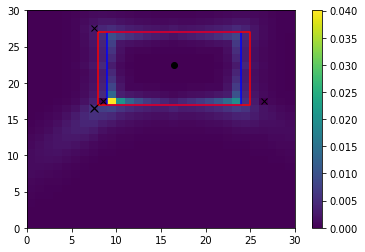

Creating TL
Done in: 0.6702532768249512  sec
Memory:  [5188.53125]
Iteration: 0  Time: 1.4413068294525146  Distance: 2989.09510139  marginal-improvement: -2988.09510139
Iteration: 1  Time: 1.4331116676330566  Distance: 5.24426580437  marginal-improvement: 0.998245533974
Iteration: 2  Time: 1.4310708045959473  Distance: 1.64497932808  marginal-improvement: 0.686328002919
Iteration: 3  Time: 1.4319276809692383  Distance: 0.835653034534  marginal-improvement: 0.491997850509
Iteration: 4  Time: 1.4375970363616943  Distance: 0.515185129934  marginal-improvement: 0.383493975797
Iteration: 5  Time: 1.4431602954864502  Distance: 0.352710193395  marginal-improvement: 0.315371945149
Iteration: 6  Time: 1.445105791091919  Distance: 0.261071196859  marginal-improvement: 0.259813859231
Iteration: 7  Time: 1.4492809772491455  Distance: 0.211208554391  marginal-improvement: 0.190992507284
Iteration: 8  Time: 1.427490472793579  Distance: 0.174624070298  marginal-improvement: 0.173214973222
Iteration: 

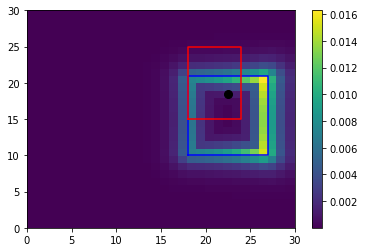

Creating TL
Done in: 1.6046504974365234  sec
Memory:  [6923.06640625]
Iteration: 0  Time: 3.5396533012390137  Distance: 0.998803945089  marginal-improvement: 0.00119605491064
Iteration: 1  Time: 3.0867178440093994  Distance: 4.22429528136  marginal-improvement: -3.22935382076
Iteration: 2  Time: 3.074540853500366  Distance: 1.34020628161  marginal-improvement: 0.682738494271
Iteration: 3  Time: 3.0982465744018555  Distance: 0.657655375227  marginal-improvement: 0.509287947496
Iteration: 4  Time: 3.0916025638580322  Distance: 0.381621585613  marginal-improvement: 0.419724068276
Iteration: 5  Time: 3.093106508255005  Distance: 0.240552015362  marginal-improvement: 0.36965825721
Iteration: 6  Time: 3.0983774662017822  Distance: 0.158984770644  marginal-improvement: 0.339083605661
Iteration: 7  Time: 3.1063201427459717  Distance: 0.112721592944  marginal-improvement: 0.290991253515
Iteration: 8  Time: 3.0984551906585693  Distance: 0.0820103043269  marginal-improvement: 0.272452578209
Itera

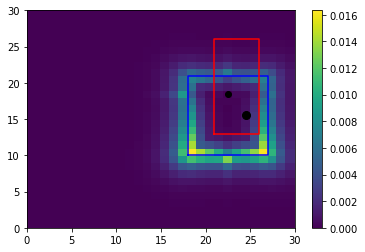

Creating TL
Done in: 0.8619606494903564  sec
Memory:  [4816.19140625]
Iteration: 0  Time: 1.863107681274414  Distance: 0.998687597925  marginal-improvement: 0.00131240207459
Iteration: 1  Time: 1.8321709632873535  Distance: 2.78927403831  marginal-improvement: -1.7929394979
Iteration: 2  Time: 1.8324663639068604  Distance: 0.999753401833  marginal-improvement: 0.64157218398
Iteration: 3  Time: 1.8320872783660889  Distance: 0.500480901018  marginal-improvement: 0.499395650867
Iteration: 4  Time: 1.8342258930206299  Distance: 0.290875884057  marginal-improvement: 0.418807224282
Iteration: 5  Time: 1.8433117866516113  Distance: 0.182854576044  marginal-improvement: 0.371365637145
Iteration: 6  Time: 1.8400747776031494  Distance: 0.120391813447  marginal-improvement: 0.341598028051
Iteration: 7  Time: 1.8265306949615479  Distance: 0.0845073930772  marginal-improvement: 0.298063625279
Iteration: 8  Time: 1.8380227088928223  Distance: 0.0604430037059  marginal-improvement: 0.284760758734
Ite

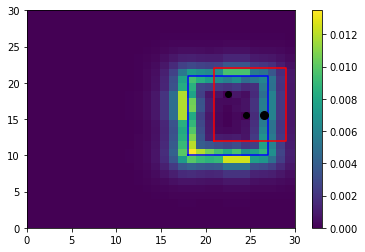

Creating TL
Done in: 0.5509512424468994  sec
Memory:  [4475.39453125]
Iteration: 0  Time: 1.1924471855163574  Distance: 0.998929066378  marginal-improvement: 0.0010709336219
Iteration: 1  Time: 1.1901249885559082  Distance: 2.55320368387  marginal-improvement: -1.55594092695
Iteration: 2  Time: 1.1871237754821777  Distance: 0.97407210173  marginal-improvement: 0.618490248983
Iteration: 3  Time: 1.1885027885437012  Distance: 0.498308273982  marginal-improvement: 0.488427732303
Iteration: 4  Time: 1.1890509128570557  Distance: 0.292765521263  marginal-improvement: 0.412481115508
Iteration: 5  Time: 1.1854019165039062  Distance: 0.185433597826  marginal-improvement: 0.366613947485
Iteration: 6  Time: 1.1910641193389893  Distance: 0.122863672137  marginal-improvement: 0.337424967333
Iteration: 7  Time: 1.1911571025848389  Distance: 0.0873186783506  marginal-improvement: 0.289304341699
Iteration: 8  Time: 1.1909432411193848  Distance: 0.0628088921587  marginal-improvement: 0.280693508593
It

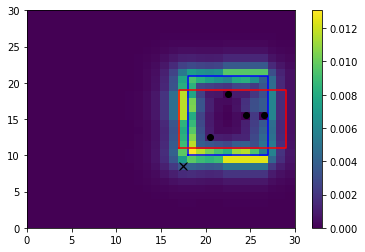

Creating TL
Done in: 0.3045008182525635  sec
Memory:  [4227.20703125]
Iteration: 0  Time: 0.6338624954223633  Distance: 684.363955721  marginal-improvement: -683.363955721
Iteration: 1  Time: 0.6407864093780518  Distance: 3.08829790028  marginal-improvement: 0.995487345769
Iteration: 2  Time: 0.6360988616943359  Distance: 1.09694466109  marginal-improvement: 0.644806072304
Iteration: 3  Time: 0.643155574798584  Distance: 0.607295377446  marginal-improvement: 0.446375556592
Iteration: 4  Time: 0.6497049331665039  Distance: 0.390693344973  marginal-improvement: 0.356666690573
Iteration: 5  Time: 0.6393704414367676  Distance: 0.27992267881  marginal-improvement: 0.283523299253
Iteration: 6  Time: 0.6394846439361572  Distance: 0.214906204214  marginal-improvement: 0.232265834521
Iteration: 7  Time: 0.6347939968109131  Distance: 0.172948752904  marginal-improvement: 0.195236109929
Iteration: 8  Time: 0.6411910057067871  Distance: 0.142662997178  marginal-improvement: 0.175114045156
Iteratio

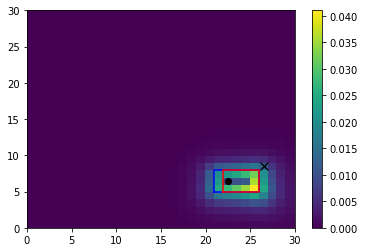

Creating TL
Done in: 8.716909646987915  sec
Memory:  [9149.30078125]
Iteration: 0  Time: 17.49734902381897  Distance: 1.46918225607  marginal-improvement: -0.469182256068
Iteration: 1  Time: 15.88232159614563  Distance: 1.54156729389  marginal-improvement: -0.0492689300619
Iteration: 2  Time: 15.649008512496948  Distance: 0.761638570302  marginal-improvement: 0.505932323992
Iteration: 3  Time: 15.69664454460144  Distance: 0.443238010466  marginal-improvement: 0.418046790501
Iteration: 4  Time: 15.698242902755737  Distance: 0.325485840973  marginal-improvement: 0.265663518725
Iteration: 5  Time: 15.681588172912598  Distance: 0.26192877084  marginal-improvement: 0.195268310113
Iteration: 6  Time: 15.704137563705444  Distance: 0.212540333131  marginal-improvement: 0.1885567498
Iteration: 7  Time: 15.694549798965454  Distance: 0.173541004326  marginal-improvement: 0.183491425983
Iteration: 8  Time: 15.707041263580322  Distance: 0.142371670125  marginal-improvement: 0.179607893372
Iteration

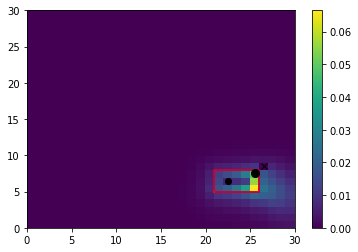

Creating TL
Done in: 0.15732336044311523  sec
Memory:  [5929.53125]
Iteration: 0  Time: 0.3149576187133789  Distance: 3.5334975752  marginal-improvement: -2.5334975752
Iteration: 1  Time: 0.3154566287994385  Distance: 9.16678045076  marginal-improvement: -1.59425123569
Iteration: 2  Time: 0.3172464370727539  Distance: 3.20433682805  marginal-improvement: 0.650440321413
Iteration: 3  Time: 0.3164527416229248  Distance: 1.77929880651  marginal-improvement: 0.444721668792
Iteration: 4  Time: 0.3157634735107422  Distance: 1.18669944528  marginal-improvement: 0.333052188345
Iteration: 5  Time: 0.3152470588684082  Distance: 0.857346866175  marginal-improvement: 0.277536641998
Iteration: 6  Time: 0.31421422958374023  Distance: 0.651182559993  marginal-improvement: 0.240467790011
Iteration: 7  Time: 0.31409716606140137  Distance: 0.511476364865  marginal-improvement: 0.214542286159
Iteration: 8  Time: 0.3134434223175049  Distance: 0.411388429986  marginal-improvement: 0.195684379092
Iteration:

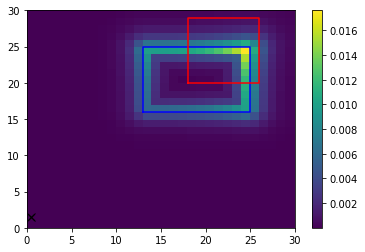

Creating TL
Done in: 9.220333814620972  sec
Memory:  [9310.25390625]
Iteration: 0  Time: 18.059057474136353  Distance: 1.66647968631  marginal-improvement: -0.666479686308
Iteration: 1  Time: 17.42151403427124  Distance: 0.907060685813  marginal-improvement: 0.45570252475
Iteration: 2  Time: 17.477407217025757  Distance: 0.788222856113  marginal-improvement: 0.131014199556
Iteration: 3  Time: 17.421135663986206  Distance: 0.766256229115  marginal-improvement: 0.0278685486312
Iteration: 4  Time: 17.507604837417603  Distance: 0.756779403387  marginal-improvement: 0.0123676981248
Iteration: 5  Time: 17.41819715499878  Distance: 0.752540366585  marginal-improvement: 0.00560141671837
Iteration: 6  Time: 17.472379207611084  Distance: 0.750559678097  marginal-improvement: 0.0026320029813
Iteration: 7  Time: 17.525577068328857  Distance: 0.749597738879  marginal-improvement: 0.00128162922347
Iteration: 8  Time: 17.497702836990356  Distance: 0.749117920486  marginal-improvement: 0.0006401011753

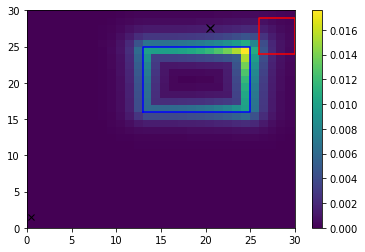

Creating TL
Done in: 8.137576341629028  sec
Memory:  [8735.92578125]
Iteration: 0  Time: 16.086501121520996  Distance: 1.66445959643  marginal-improvement: -0.664459596435
Iteration: 1  Time: 15.987689971923828  Distance: 1.25607493039  marginal-improvement: 0.245355709999
Iteration: 2  Time: 15.955286502838135  Distance: 0.7745202895  marginal-improvement: 0.383380504807
Iteration: 3  Time: 15.875401735305786  Distance: 0.749544302792  marginal-improvement: 0.0322470399383
Iteration: 4  Time: 15.970872402191162  Distance: 0.738348037704  marginal-improvement: 0.0149374293772
Iteration: 5  Time: 15.966662406921387  Distance: 0.733097298429  marginal-improvement: 0.00711146912672
Iteration: 6  Time: 15.881479263305664  Distance: 0.730477289413  marginal-improvement: 0.0035738898794
Iteration: 7  Time: 15.945373773574829  Distance: 0.729094987512  marginal-improvement: 0.00189232700449
Iteration: 8  Time: 15.9039945602417  Distance: 0.728318232595  marginal-improvement: 0.00106536861524


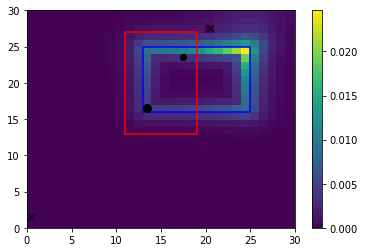

Creating TL
Done in: 1.8862614631652832  sec
Memory:  [5519.84375]
Iteration: 0  Time: 3.600963592529297  Distance: 5.15212232692  marginal-improvement: -4.15212232692
Iteration: 1  Time: 3.6326024532318115  Distance: 2.88119658529  marginal-improvement: 0.440774810365
Iteration: 2  Time: 3.703913927078247  Distance: 0.846664240589  marginal-improvement: 0.706141453551
Iteration: 3  Time: 3.629711627960205  Distance: 0.369139163044  marginal-improvement: 0.564007613234
Iteration: 4  Time: 3.623581647872925  Distance: 0.186175215226  marginal-improvement: 0.495650329563
Iteration: 5  Time: 3.6273040771484375  Distance: 0.105938689024  marginal-improvement: 0.430973188911
Iteration: 6  Time: 3.5957047939300537  Distance: 0.0636896787253  marginal-improvement: 0.398806240553
Iteration: 7  Time: 3.6843461990356445  Distance: 0.0380173723283  marginal-improvement: 0.40308425024
Iteration: 8  Time: 3.605210304260254  Distance: 0.0225672401427  marginal-improvement: 0.406396634996
Iteration: 

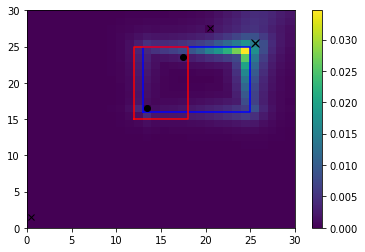

Creating TL
Done in: 1.7487072944641113  sec
Memory:  [3951.5078125]
Iteration: 0  Time: 3.496765613555908  Distance: 30.1021984498  marginal-improvement: -29.1021984498
Iteration: 1  Time: 3.4420197010040283  Distance: 3.11563814839  marginal-improvement: 0.896497986565
Iteration: 2  Time: 3.398833990097046  Distance: 0.918067035931  marginal-improvement: 0.705335795684
Iteration: 3  Time: 3.459110975265503  Distance: 0.407015011541  marginal-improvement: 0.556660902078
Iteration: 4  Time: 3.3898961544036865  Distance: 0.210207743718  marginal-improvement: 0.483538106072
Iteration: 5  Time: 3.4023454189300537  Distance: 0.126684299664  marginal-improvement: 0.39733761743
Iteration: 6  Time: 3.402982234954834  Distance: 0.0797732923799  marginal-improvement: 0.370298509036
Iteration: 7  Time: 3.4487857818603516  Distance: 0.049990034274  marginal-improvement: 0.373348738875
Iteration: 8  Time: 3.3986763954162598  Distance: 0.0312042240487  marginal-improvement: 0.37579110513
Iteration:

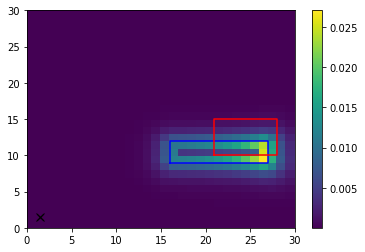

Creating TL
Done in: 9.310579776763916  sec
Memory:  [8475.046875]
Iteration: 0  Time: 17.962412118911743  Distance: 1.58338431936  marginal-improvement: -0.58338431936
Iteration: 1  Time: 17.486472129821777  Distance: 0.93279850374  marginal-improvement: 0.410883073468
Iteration: 2  Time: 17.425764799118042  Distance: 0.760856980586  marginal-improvement: 0.184328686704
Iteration: 3  Time: 17.486836671829224  Distance: 0.719789018155  marginal-improvement: 0.0539759290883
Iteration: 4  Time: 17.38561177253723  Distance: 0.697019259076  marginal-improvement: 0.0316339350901
Iteration: 5  Time: 17.456388473510742  Distance: 0.684627554301  marginal-improvement: 0.0177781382857
Iteration: 6  Time: 17.524872541427612  Distance: 0.678036198915  marginal-improvement: 0.00962765133245
Iteration: 7  Time: 17.380345821380615  Distance: 0.674587821428  marginal-improvement: 0.00508583095287
Iteration: 8  Time: 17.411602020263672  Distance: 0.672808069085  marginal-improvement: 0.00263828116335


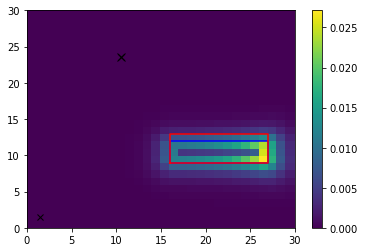

Creating TL
Done in: 7.3519065380096436  sec
Memory:  [9014.48828125]
Iteration: 0  Time: 14.509463787078857  Distance: 1.55591718343  marginal-improvement: -0.555917183426
Iteration: 1  Time: 14.27992868423462  Distance: 1.56993254455  marginal-improvement: -0.00900778092241
Iteration: 2  Time: 14.281362056732178  Distance: 0.787825344922  marginal-improvement: 0.498178856373
Iteration: 3  Time: 14.223595380783081  Distance: 0.679642426437  marginal-improvement: 0.137318403352
Iteration: 4  Time: 14.162559986114502  Distance: 0.649689975776  marginal-improvement: 0.044070895953
Iteration: 5  Time: 14.300248146057129  Distance: 0.632009292256  marginal-improvement: 0.0272140315844
Iteration: 6  Time: 14.249216079711914  Distance: 0.621695129513  marginal-improvement: 0.0163196378105
Iteration: 7  Time: 14.19254994392395  Distance: 0.615714365835  marginal-improvement: 0.00962009093308
Iteration: 8  Time: 14.146205425262451  Distance: 0.612247559412  marginal-improvement: 0.005630543340

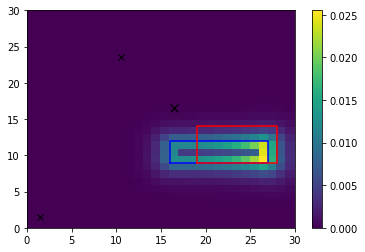

Creating TL
Done in: 5.528123378753662  sec
Memory:  [7870.8046875]
Iteration: 0  Time: 10.781250476837158  Distance: 1.52888792147  marginal-improvement: -0.528887921471
Iteration: 1  Time: 10.944610118865967  Distance: 1.19802674499  marginal-improvement: 0.216406429693
Iteration: 2  Time: 10.880142211914062  Distance: 0.667373397089  marginal-improvement: 0.442939483712
Iteration: 3  Time: 10.84578561782837  Distance: 0.607054235447  marginal-improvement: 0.0903829279156
Iteration: 4  Time: 10.755045413970947  Distance: 0.569214406379  marginal-improvement: 0.0623335228692
Iteration: 5  Time: 10.800724744796753  Distance: 0.54545872016  marginal-improvement: 0.0417341619473
Iteration: 6  Time: 10.788289546966553  Distance: 0.530807101244  marginal-improvement: 0.0268610957615
Iteration: 7  Time: 10.80533766746521  Distance: 0.521274419069  marginal-improvement: 0.0179588444707
Iteration: 8  Time: 10.793912887573242  Distance: 0.514650448209  marginal-improvement: 0.0127072624672
Ite

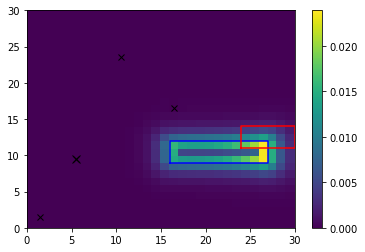

Creating TL
Done in: 4.6511852741241455  sec
Memory:  [7152.828125]
Iteration: 0  Time: 9.345598459243774  Distance: 1.43698889353  marginal-improvement: -0.436988893526
Iteration: 1  Time: 9.442697286605835  Distance: 1.2770785277  marginal-improvement: 0.111281560039
Iteration: 2  Time: 9.377931356430054  Distance: 0.702592828994  marginal-improvement: 0.449843675423
Iteration: 3  Time: 9.36690902709961  Distance: 0.604363401081  marginal-improvement: 0.139809892528
Iteration: 4  Time: 9.384151220321655  Distance: 0.557108194705  marginal-improvement: 0.0781900530237
Iteration: 5  Time: 9.40630030632019  Distance: 0.523366841324  marginal-improvement: 0.0605651715435
Iteration: 6  Time: 9.348844528198242  Distance: 0.499524801605  marginal-improvement: 0.0455551208762
Iteration: 7  Time: 9.368463039398193  Distance: 0.482305936039  marginal-improvement: 0.0344704917761
Iteration: 8  Time: 9.36515212059021  Distance: 0.469589720305  marginal-improvement: 0.026365455584
Iteration: 9  T

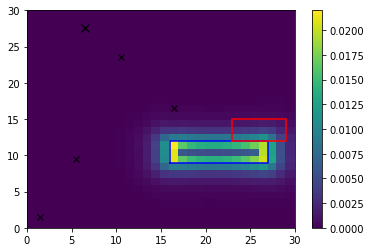

Creating TL
Done in: 4.584272146224976  sec
Memory:  [6957.90625]
Iteration: 0  Time: 9.111446142196655  Distance: 1.43673110719  marginal-improvement: -0.436731107191
Iteration: 1  Time: 9.085326194763184  Distance: 1.90517278376  marginal-improvement: -0.326046867242
Iteration: 2  Time: 9.057082653045654  Distance: 1.12038309923  marginal-improvement: 0.411925727274
Iteration: 3  Time: 9.057976007461548  Distance: 0.773563743798  marginal-improvement: 0.309554254851
Iteration: 4  Time: 9.122466087341309  Distance: 0.576672710771  marginal-improvement: 0.254524639509
Iteration: 5  Time: 9.125964403152466  Distance: 0.521724340016  marginal-improvement: 0.0952851933668
Iteration: 6  Time: 9.08686351776123  Distance: 0.496917991998  marginal-improvement: 0.0475468482386
Iteration: 7  Time: 9.104968070983887  Distance: 0.478467399713  marginal-improvement: 0.0371300548228
Iteration: 8  Time: 9.084633588790894  Distance: 0.464746250526  marginal-improvement: 0.0286772916936
Iteration: 9  

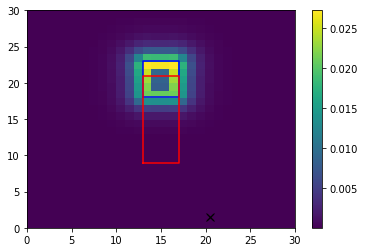

Creating TL
Done in: 10.573803424835205  sec
Memory:  [9452.73046875]
Iteration: 0  Time: 18.628934621810913  Distance: 1.27843298981  marginal-improvement: -0.278432989812
Iteration: 1  Time: 16.7057683467865  Distance: 1.0831756373  marginal-improvement: 0.152731784982
Iteration: 2  Time: 16.656567096710205  Distance: 0.488417924707  marginal-improvement: 0.549087047484
Iteration: 3  Time: 16.8844256401062  Distance: 0.368362948518  marginal-improvement: 0.245803788345
Iteration: 4  Time: 16.717394590377808  Distance: 0.287663501643  marginal-improvement: 0.219075906521
Iteration: 5  Time: 16.617207527160645  Distance: 0.228246567569  marginal-improvement: 0.206550131437
Iteration: 6  Time: 16.478741884231567  Distance: 0.183865712617  marginal-improvement: 0.194442595239
Iteration: 7  Time: 16.528534173965454  Distance: 0.149911840424  marginal-improvement: 0.184666688036
Iteration: 8  Time: 16.414979457855225  Distance: 0.123325269683  marginal-improvement: 0.177348037793
Iteration

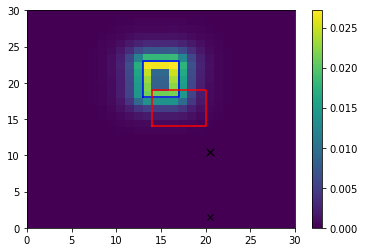

Creating TL
Done in: 6.696911096572876  sec
Memory:  [9237.67578125]
Iteration: 0  Time: 13.298891544342041  Distance: 1.00459997389  marginal-improvement: -0.00459997389119
Iteration: 1  Time: 13.267294645309448  Distance: 1.7032989426  marginal-improvement: -0.695499688304
Iteration: 2  Time: 13.292318344116211  Distance: 0.887166653868  marginal-improvement: 0.4791480041
Iteration: 3  Time: 13.186108350753784  Distance: 0.564161750923  marginal-improvement: 0.36408593756
Iteration: 4  Time: 13.223087310791016  Distance: 0.396221334831  marginal-improvement: 0.297681322452
Iteration: 5  Time: 13.180882215499878  Distance: 0.295530098135  marginal-improvement: 0.25412876048
Iteration: 6  Time: 13.242269277572632  Distance: 0.235902713743  marginal-improvement: 0.201764168078
Iteration: 7  Time: 13.195215463638306  Distance: 0.198516979874  marginal-improvement: 0.158479456533
Iteration: 8  Time: 13.227041482925415  Distance: 0.1682528789  marginal-improvement: 0.152450943963
Iteration

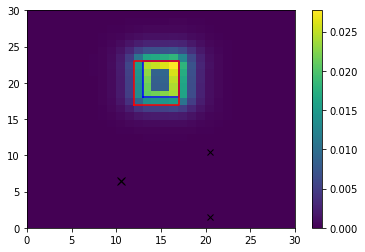

Creating TL
Done in: 5.814245223999023  sec
Memory:  [8419.5625]
Iteration: 0  Time: 11.364283084869385  Distance: 0.997063957806  marginal-improvement: 0.00293604219354
Iteration: 1  Time: 11.445775032043457  Distance: 1.70158248126  marginal-improvement: -0.70659311064
Iteration: 2  Time: 11.417741537094116  Distance: 0.914113952565  marginal-improvement: 0.462785987378
Iteration: 3  Time: 11.44913935661316  Distance: 0.604623169395  marginal-improvement: 0.338569149177
Iteration: 4  Time: 11.422918558120728  Distance: 0.442389283553  marginal-improvement: 0.26832231058
Iteration: 5  Time: 11.449744701385498  Distance: 0.343636489202  marginal-improvement: 0.223226009358
Iteration: 6  Time: 11.538612842559814  Distance: 0.277259528531  marginal-improvement: 0.193160396981
Iteration: 7  Time: 11.43497371673584  Distance: 0.228626138457  marginal-improvement: 0.17540746149
Iteration: 8  Time: 11.335571050643921  Distance: 0.190751995497  marginal-improvement: 0.165659723844
Iteration: 

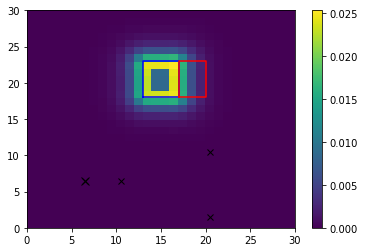

Creating TL
Done in: 5.473961114883423  sec
Memory:  [8110.02734375]
Iteration: 0  Time: 10.893360137939453  Distance: 1.1799565776  marginal-improvement: -0.1799565776
Iteration: 1  Time: 11.299171209335327  Distance: 2.02878556869  marginal-improvement: -0.719373074572
Iteration: 2  Time: 11.198545932769775  Distance: 1.13063158811  marginal-improvement: 0.442705229395
Iteration: 3  Time: 11.198814630508423  Distance: 0.772071445606  marginal-improvement: 0.317132606478
Iteration: 4  Time: 11.122750759124756  Distance: 0.575615066163  marginal-improvement: 0.254453626749
Iteration: 5  Time: 11.294642210006714  Distance: 0.452123077902  marginal-improvement: 0.214539186898
Iteration: 6  Time: 11.108381748199463  Distance: 0.367019396716  marginal-improvement: 0.188231225844
Iteration: 7  Time: 11.225603342056274  Distance: 0.303600580722  marginal-improvement: 0.172794180803
Iteration: 8  Time: 11.128499746322632  Distance: 0.253903476217  marginal-improvement: 0.163692389475
Iteratio

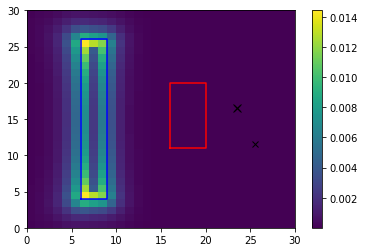

Creating TL
Done in: 7.360100030899048  sec
Memory:  [8891.9375]
Iteration: 0  Time: 14.457170248031616  Distance: 0.99690732127  marginal-improvement: 0.0030926787296
Iteration: 1  Time: 14.245017290115356  Distance: 1.24993131549  marginal-improvement: -0.253808943738
Iteration: 2  Time: 14.235640525817871  Distance: 0.606122928348  marginal-improvement: 0.515075011852
Iteration: 3  Time: 14.246424436569214  Distance: 0.36157866391  marginal-improvement: 0.403456548171
Iteration: 4  Time: 14.174970149993896  Distance: 0.237668201515  marginal-improvement: 0.34269295941
Iteration: 5  Time: 14.221585273742676  Distance: 0.166104058813  marginal-improvement: 0.301109455305
Iteration: 6  Time: 14.273643016815186  Distance: 0.126264876422  marginal-improvement: 0.239844725507
Iteration: 7  Time: 14.226537942886353  Distance: 0.0976151775776  marginal-improvement: 0.226901571174
Iteration: 8  Time: 14.144327878952026  Distance: 0.0762282425252  marginal-improvement: 0.219094361994
Iteratio

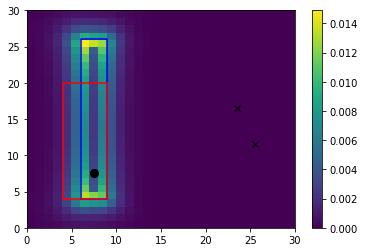

Creating TL
Done in: 0.8759033679962158  sec
Memory:  [5436.10546875]
Iteration: 0  Time: 1.8930926322937012  Distance: 580.766338097  marginal-improvement: -579.766338097
Iteration: 1  Time: 1.905470848083496  Distance: 6.691900247  marginal-improvement: 0.988477465363
Iteration: 2  Time: 1.9072065353393555  Distance: 2.03604646521  marginal-improvement: 0.695744647998
Iteration: 3  Time: 1.9092662334442139  Distance: 1.00856746904  marginal-improvement: 0.504644178671
Iteration: 4  Time: 1.9039638042449951  Distance: 0.600310582601  marginal-improvement: 0.404788870323
Iteration: 5  Time: 1.9040226936340332  Distance: 0.390882599964  marginal-improvement: 0.348866051519
Iteration: 6  Time: 1.935166835784912  Distance: 0.267823293813  marginal-improvement: 0.314824211061
Iteration: 7  Time: 1.9097037315368652  Distance: 0.189404790287  marginal-improvement: 0.292799414156
Iteration: 8  Time: 1.9033355712890625  Distance: 0.136761009051  marginal-improvement: 0.277943240801
Iteration: 

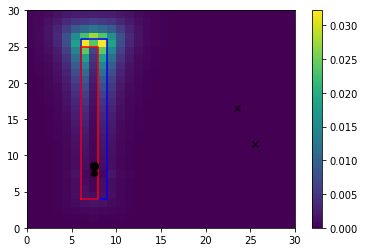

Creating TL
Done in: 0.839972972869873  sec
Memory:  [3875.703125]
Iteration: 0  Time: 1.7844834327697754  Distance: 429.018946245  marginal-improvement: -428.018946245
Iteration: 1  Time: 1.7907874584197998  Distance: 5.98546941643  marginal-improvement: 0.98604847299
Iteration: 2  Time: 1.7941899299621582  Distance: 1.8438529452  marginal-improvement: 0.691945139652
Iteration: 3  Time: 1.7726736068725586  Distance: 0.906376948185  marginal-improvement: 0.508433169496
Iteration: 4  Time: 1.7808210849761963  Distance: 0.533006196225  marginal-improvement: 0.411937607976
Iteration: 5  Time: 1.7714474201202393  Distance: 0.342215591168  marginal-improvement: 0.35795194579
Iteration: 6  Time: 1.7815797328948975  Distance: 0.230954882736  marginal-improvement: 0.325118759355
Iteration: 7  Time: 1.7881548404693604  Distance: 0.170496052415  marginal-improvement: 0.261777666723
Iteration: 8  Time: 1.7779736518859863  Distance: 0.138376945441  marginal-improvement: 0.18838622079
Iteration: 9 

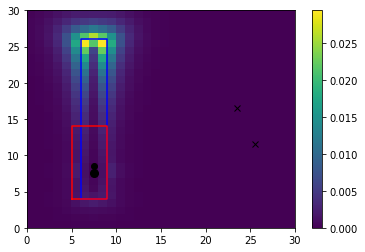

Repeated sample: Skipping the Actualization of M and TL
Non-zeros in M: 23.42067  x 10^6
Memory after updating: [3592.65625]
46
###########################################
############### NEW TRIAL #################
###########################################
True hypothesis: (3, 20, 16, 24)
FALTAN: 5 Examples
Move:  1691
Selected sample: (11, 21)
Selected box: (9, 24, 19, 25)


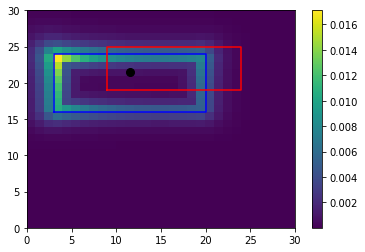

Creating TL
Done in: 1.639756441116333  sec
Memory:  [7133.23046875]
Iteration: 0  Time: 3.749009370803833  Distance: 0.998750652762  marginal-improvement: 0.00124934723846
Iteration: 1  Time: 3.3962206840515137  Distance: 3.93925678394  marginal-improvement: -2.94418443988
Iteration: 2  Time: 3.3442375659942627  Distance: 1.23391871749  marginal-improvement: 0.686763573646
Iteration: 3  Time: 3.355940580368042  Distance: 0.593383405663  marginal-improvement: 0.519106568973
Iteration: 4  Time: 3.344808340072632  Distance: 0.336174267365  marginal-improvement: 0.433461967159
Iteration: 5  Time: 3.309615135192871  Distance: 0.206287636764  marginal-improvement: 0.386366962644
Iteration: 6  Time: 3.3860268592834473  Distance: 0.132846882585  marginal-improvement: 0.356011418481
Iteration: 7  Time: 3.416294574737549  Distance: 0.093319282187  marginal-improvement: 0.29754255146
Iteration: 8  Time: 3.287259817123413  Distance: 0.0654595847199  marginal-improvement: 0.298541703431
Iteration:

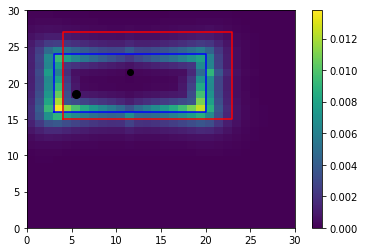

Creating TL
Done in: 0.6117494106292725  sec
Memory:  [4850.8125]
Iteration: 0  Time: 1.3088209629058838  Distance: 0.9985930984  marginal-improvement: 0.00140690159983
Iteration: 1  Time: 1.3201053142547607  Distance: 2.09843298214  marginal-improvement: -1.10138943029
Iteration: 2  Time: 1.3224949836730957  Distance: 0.792253673179  marginal-improvement: 0.622454622129
Iteration: 3  Time: 1.318028450012207  Distance: 0.384887061748  marginal-improvement: 0.514187090854
Iteration: 4  Time: 1.3128993511199951  Distance: 0.210071360705  marginal-improvement: 0.454199993758
Iteration: 5  Time: 1.317441463470459  Distance: 0.121602184357  marginal-improvement: 0.421138683785
Iteration: 6  Time: 1.3144488334655762  Distance: 0.0768400579154  marginal-improvement: 0.368102980042
Iteration: 7  Time: 1.299743890762329  Distance: 0.0491010671605  marginal-improvement: 0.360996484222
Iteration: 8  Time: 1.3027164936065674  Distance: 0.0311957352899  marginal-improvement: 0.364662784458
Iteratio

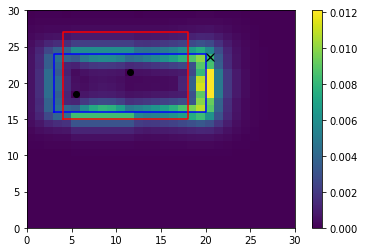

Creating TL
Done in: 0.3548407554626465  sec
Memory:  [4422.6171875]
Iteration: 0  Time: 0.749225378036499  Distance: 37.5034940171  marginal-improvement: -36.5034940171
Iteration: 1  Time: 0.7561652660369873  Distance: 5.62803420865  marginal-improvement: 0.849933070074
Iteration: 2  Time: 0.7538907527923584  Distance: 2.56100966932  marginal-improvement: 0.544954850242
Iteration: 3  Time: 0.7575280666351318  Distance: 1.60391399933  marginal-improvement: 0.373718100893
Iteration: 4  Time: 0.7574965953826904  Distance: 1.14639241665  marginal-improvement: 0.285253188681
Iteration: 5  Time: 0.7517147064208984  Distance: 0.871499693863  marginal-improvement: 0.239789376478
Iteration: 6  Time: 0.7520978450775146  Distance: 0.682247530126  marginal-improvement: 0.217156890667
Iteration: 7  Time: 0.7510089874267578  Distance: 0.541609964742  marginal-improvement: 0.206138621504
Iteration: 8  Time: 0.7587480545043945  Distance: 0.432718452523  marginal-improvement: 0.201051530266
Iteration:

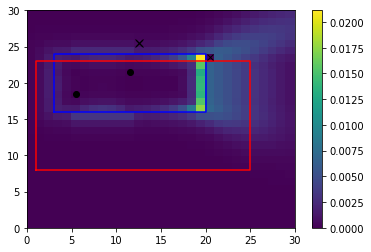

Creating TL
Done in: 0.19097018241882324  sec
Memory:  [4274.12109375]
Iteration: 0  Time: 0.3922107219696045  Distance: 27.1071353779  marginal-improvement: -26.1071353779
Iteration: 1  Time: 0.3932077884674072  Distance: 3.66153754012  marginal-improvement: 0.864923479037
Iteration: 2  Time: 0.39745402336120605  Distance: 1.48439077859  marginal-improvement: 0.59459905509
Iteration: 3  Time: 0.395890474319458  Distance: 0.827385584393  marginal-improvement: 0.442609320721
Iteration: 4  Time: 0.3981189727783203  Distance: 0.532449187046  marginal-improvement: 0.356467894667
Iteration: 5  Time: 0.39507389068603516  Distance: 0.370939121966  marginal-improvement: 0.303334231715
Iteration: 6  Time: 0.39365434646606445  Distance: 0.273345960365  marginal-improvement: 0.263097516068
Iteration: 7  Time: 0.39533233642578125  Distance: 0.20896736114  marginal-improvement: 0.235520580361
Iteration: 8  Time: 0.39315128326416016  Distance: 0.171675984245  marginal-improvement: 0.178455509473
Ite

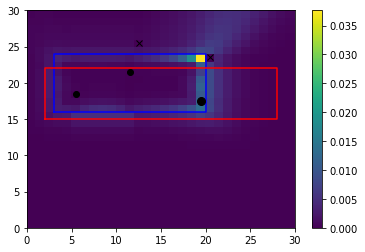

Creating TL
Done in: 0.05579495429992676  sec
Memory:  [4134.1875]
Iteration: 0  Time: 0.1332411766052246  Distance: 4.80497422803  marginal-improvement: -3.80497422803
Iteration: 1  Time: 0.12468481063842773  Distance: 0.959661885922  marginal-improvement: 0.800277412452
Iteration: 2  Time: 0.1269526481628418  Distance: 0.387187973054  marginal-improvement: 0.596537094226
Iteration: 3  Time: 0.12622833251953125  Distance: 0.191420264246  marginal-improvement: 0.505614126556
Iteration: 4  Time: 0.12675261497497559  Distance: 0.104018056119  marginal-improvement: 0.456598513594
Iteration: 5  Time: 0.12409400939941406  Distance: 0.0603872231872  marginal-improvement: 0.419454415511
Iteration: 6  Time: 0.12489557266235352  Distance: 0.0364368473365  marginal-improvement: 0.396613299744
Iteration: 7  Time: 0.12409710884094238  Distance: 0.0220990740829  marginal-improvement: 0.393496537207
Iteration: 8  Time: 0.12473893165588379  Distance: 0.0134513534848  marginal-improvement: 0.391315969

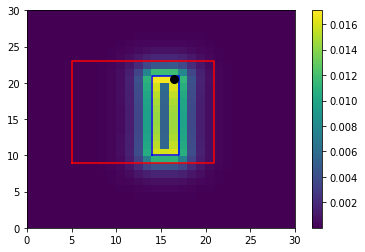

Creating TL
Done in: 2.1717705726623535  sec
Memory:  [7296.30859375]
Iteration: 0  Time: 11.519107103347778  Distance: 0.998675857393  marginal-improvement: 0.00132414260733
Iteration: 1  Time: 3.6466612815856934  Distance: 3.3046151902  marginal-improvement: -2.30899677381
Iteration: 2  Time: 3.8417489528656006  Distance: 1.01075069147  marginal-improvement: 0.69413967034
Iteration: 3  Time: 3.7259161472320557  Distance: 0.467515702605  marginal-improvement: 0.537456954965
Iteration: 4  Time: 3.668816089630127  Distance: 0.25337327018  marginal-improvement: 0.458043294017
Iteration: 5  Time: 3.7796144485473633  Distance: 0.148335543008  marginal-improvement: 0.414557254192
Iteration: 6  Time: 3.8159334659576416  Distance: 0.0944635996738  marginal-improvement: 0.363176230335
Iteration: 7  Time: 3.6111459732055664  Distance: 0.0623333765203  marginal-improvement: 0.340133376925
Iteration: 8  Time: 3.778101682662964  Distance: 0.0411066361187  marginal-improvement: 0.340535706334
Itera

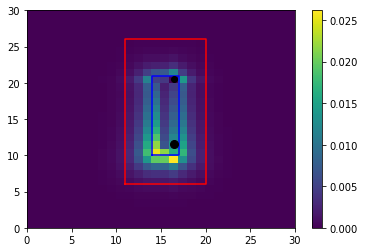

Creating TL
Done in: 0.9316847324371338  sec
Memory:  [5184.42578125]
Iteration: 0  Time: 1.954979658126831  Distance: 0.998068991935  marginal-improvement: 0.00193100806535
Iteration: 1  Time: 1.974776268005371  Distance: 1.24888839839  marginal-improvement: -0.251304677811
Iteration: 2  Time: 1.9710776805877686  Distance: 0.404549652658  marginal-improvement: 0.676072214955
Iteration: 3  Time: 1.9775903224945068  Distance: 0.164396318139  marginal-improvement: 0.593631295791
Iteration: 4  Time: 1.967395544052124  Distance: 0.0738758809348  marginal-improvement: 0.550623263518
Iteration: 5  Time: 1.9656014442443848  Distance: 0.0348594399931  marginal-improvement: 0.52813503471
Iteration: 6  Time: 1.9824347496032715  Distance: 0.0168634675074  marginal-improvement: 0.516243877964
Iteration: 7  Time: 1.9648048877716064  Distance: 0.00835515901497  marginal-improvement: 0.504540865554
Total SK iteration time: 15.763415098190308
Non-zeros in M: 25.645084  x 10^6
Memory after updating: [4

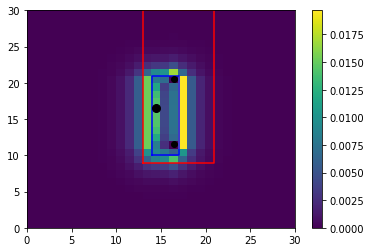

Creating TL
Done in: 0.8046069145202637  sec
Memory:  [4894.32421875]
Iteration: 0  Time: 1.6831035614013672  Distance: 0.997576813915  marginal-improvement: 0.00242318608525
Iteration: 1  Time: 1.704387903213501  Distance: 0.93694797824  marginal-improvement: 0.060776107493
Iteration: 2  Time: 1.6908762454986572  Distance: 0.297279164455  marginal-improvement: 0.682715400044
Iteration: 3  Time: 1.6944615840911865  Distance: 0.113858416009  marginal-improvement: 0.616998331458
Iteration: 4  Time: 1.6892709732055664  Distance: 0.0471591890524  marginal-improvement: 0.585808491762
Iteration: 5  Time: 1.7007534503936768  Distance: 0.0202359866494  marginal-improvement: 0.57090045321
Iteration: 6  Time: 1.7016279697418213  Distance: 0.00891552835309  marginal-improvement: 0.559422107379
Total SK iteration time: 11.868440866470337
Non-zeros in M: 22.601709  x 10^6
Memory after updating: [4600.83203125]
FALTAN: 2 Examples
Move:  1699
Selected sample: (16, 16)
Selected box: (12, 20, 8, 23)


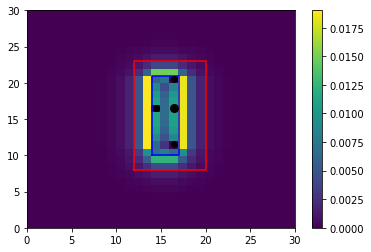

Creating TL
Done in: 0.8285233974456787  sec
Memory:  [4859.25390625]
Iteration: 0  Time: 1.726902961730957  Distance: 0.997576761321  marginal-improvement: 0.00242323867877
Iteration: 1  Time: 1.7350847721099854  Distance: 0.941584418846  marginal-improvement: 0.0561283548757
Iteration: 2  Time: 1.7336421012878418  Distance: 0.297971866688  marginal-improvement: 0.683542058764
Iteration: 3  Time: 1.7352547645568848  Distance: 0.114046666018  marginal-improvement: 0.617256933396
Iteration: 4  Time: 1.7366292476654053  Distance: 0.0472393507955  marginal-improvement: 0.585789287447
Iteration: 5  Time: 1.7495782375335693  Distance: 0.0202768244648  marginal-improvement: 0.570764116708
Iteration: 6  Time: 1.7371668815612793  Distance: 0.00893881553784  marginal-improvement: 0.559160974474
Total SK iteration time: 12.15816593170166
Non-zeros in M: 22.575616  x 10^6
Memory after updating: [4600.59765625]
FALTAN: 1 Examples
Move:  1700
Selected sample: (15, 11)
Selected box: (7, 20, 9, 23)


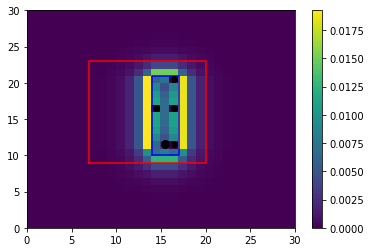

Creating TL
Done in: 0.8012378215789795  sec
Memory:  [4858.65625]
Iteration: 0  Time: 1.6971919536590576  Distance: 0.997576708709  marginal-improvement: 0.00242329129087
Iteration: 1  Time: 1.712435245513916  Distance: 0.945244090907  marginal-improvement: 0.0524597430404
Iteration: 2  Time: 1.71122407913208  Distance: 0.29871415889  marginal-improvement: 0.683981987548
Iteration: 3  Time: 1.7190427780151367  Distance: 0.114296111093  marginal-improvement: 0.617372971145
Iteration: 4  Time: 1.6972415447235107  Distance: 0.0473441984094  marginal-improvement: 0.585775946735
Iteration: 5  Time: 1.6974120140075684  Distance: 0.0203253384153  marginal-improvement: 0.570689987408
Iteration: 6  Time: 1.7088875770568848  Distance: 0.00896092920703  marginal-improvement: 0.559125214846
Total SK iteration time: 11.94765305519104
Non-zeros in M: 22.549525  x 10^6
Memory after updating: [4600.29296875]
###########################################
############### NEW TRIAL #################
#####

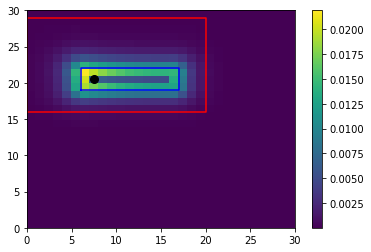

Creating TL
Done in: 1.3865041732788086  sec
Memory:  [7167.70703125]
Iteration: 0  Time: 3.518972873687744  Distance: 0.998848649272  marginal-improvement: 0.00115135072817
Iteration: 1  Time: 2.8014814853668213  Distance: 4.7304524299  marginal-improvement: -3.73590511771
Iteration: 2  Time: 2.787985324859619  Distance: 1.51884683348  marginal-improvement: 0.67892144441
Iteration: 3  Time: 2.7939422130584717  Distance: 0.75963042817  marginal-improvement: 0.499863704868
Iteration: 4  Time: 2.7744123935699463  Distance: 0.44973623483  marginal-improvement: 0.407953896853
Iteration: 5  Time: 2.7875068187713623  Distance: 0.28907010253  marginal-improvement: 0.357245247009
Iteration: 6  Time: 2.7730157375335693  Distance: 0.194634723438  marginal-improvement: 0.326686773434
Iteration: 7  Time: 2.769914150238037  Distance: 0.137479589618  marginal-improvement: 0.293653325627
Iteration: 8  Time: 2.8003811836242676  Distance: 0.102635334726  marginal-improvement: 0.253450384807
Iteration: 

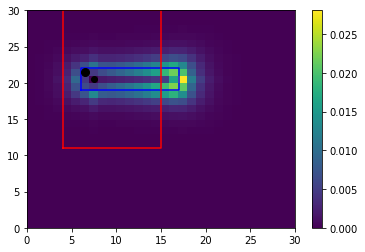

Creating TL
Done in: 0.9931268692016602  sec
Memory:  [5176.42578125]
Iteration: 0  Time: 2.095304489135742  Distance: 0.998759018991  marginal-improvement: 0.00124098100905
Iteration: 1  Time: 2.1174144744873047  Distance: 4.26006624431  marginal-improvement: -3.26535947441
Iteration: 2  Time: 2.134840488433838  Distance: 1.45078618932  marginal-improvement: 0.659445157395
Iteration: 3  Time: 2.123106002807617  Distance: 0.737712635234  marginal-improvement: 0.491508369278
Iteration: 4  Time: 2.1225945949554443  Distance: 0.440280200304  marginal-improvement: 0.403181971848
Iteration: 5  Time: 2.1336722373962402  Distance: 0.28433085326  marginal-improvement: 0.354204769909
Iteration: 6  Time: 2.1164190769195557  Distance: 0.192030189418  marginal-improvement: 0.32462415803
Iteration: 7  Time: 2.1378960609436035  Distance: 0.135446499162  marginal-improvement: 0.294660388699
Iteration: 8  Time: 2.1169261932373047  Distance: 0.10128437278  marginal-improvement: 0.252218599919
Iteration

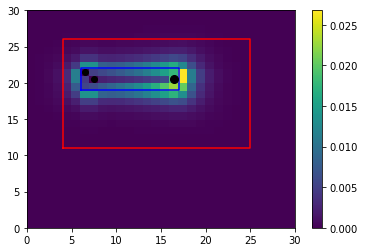

Creating TL
Done in: 0.5747795104980469  sec
Memory:  [4847.04296875]
Iteration: 0  Time: 1.240696907043457  Distance: 0.998215988949  marginal-improvement: 0.00178401105086
Iteration: 1  Time: 1.245875597000122  Distance: 1.67300555986  marginal-improvement: -0.67599555445
Iteration: 2  Time: 1.2481708526611328  Distance: 0.630330815969  marginal-improvement: 0.623234476267
Iteration: 3  Time: 1.2462573051452637  Distance: 0.302047953928  marginal-improvement: 0.520810427991
Iteration: 4  Time: 1.248659372329712  Distance: 0.163365578182  marginal-improvement: 0.459140258832
Iteration: 5  Time: 1.2450578212738037  Distance: 0.0944567189429  marginal-improvement: 0.421807702736
Iteration: 6  Time: 1.2420141696929932  Distance: 0.0578163610856  marginal-improvement: 0.387906315902
Iteration: 7  Time: 1.2442522048950195  Distance: 0.0367152672496  marginal-improvement: 0.364967518532
Iteration: 8  Time: 1.2449157238006592  Distance: 0.0233815415802  marginal-improvement: 0.363165698313
I

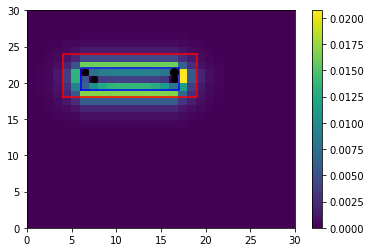

Creating TL
Done in: 0.5885281562805176  sec
Memory:  [4724.81640625]
Iteration: 0  Time: 1.2561442852020264  Distance: 0.998215881279  marginal-improvement: 0.0017841187215
Iteration: 1  Time: 1.2621924877166748  Distance: 1.67903119053  marginal-improvement: -0.682032135551
Iteration: 2  Time: 1.260204553604126  Distance: 0.631910739365  marginal-improvement: 0.623645621993
Iteration: 3  Time: 1.2529292106628418  Distance: 0.302726077902  marginal-improvement: 0.520935380516
Iteration: 4  Time: 1.257964849472046  Distance: 0.163742594811  marginal-improvement: 0.459106410831
Iteration: 5  Time: 1.2630829811096191  Distance: 0.0946952053827  marginal-improvement: 0.421682516442
Iteration: 6  Time: 1.2553281784057617  Distance: 0.0579619920562  marginal-improvement: 0.387909959939
Iteration: 7  Time: 1.2462260723114014  Distance: 0.0368227720481  marginal-improvement: 0.364708307258
Iteration: 8  Time: 1.2665047645568848  Distance: 0.0234600319695  marginal-improvement: 0.362893376444


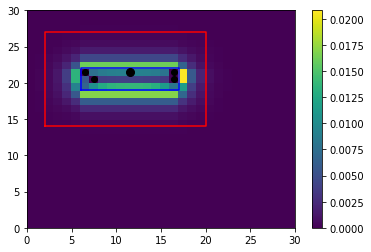

Creating TL
Done in: 0.569251298904419  sec
Memory:  [4737.765625]
Iteration: 0  Time: 1.2624235153198242  Distance: 0.998215868039  marginal-improvement: 0.00178413196137
Iteration: 1  Time: 1.2325527667999268  Distance: 1.68722292165  marginal-improvement: -0.690238530238
Iteration: 2  Time: 1.2346572875976562  Distance: 0.633991914927  marginal-improvement: 0.624239389597
Iteration: 3  Time: 1.2348358631134033  Distance: 0.303575014907  marginal-improvement: 0.521168949067
Iteration: 4  Time: 1.2370903491973877  Distance: 0.164200144454  marginal-improvement: 0.459111796456
Iteration: 5  Time: 1.2347297668457031  Distance: 0.0949792835956  marginal-improvement: 0.421563946175
Iteration: 6  Time: 1.238112449645996  Distance: 0.0581339943162  marginal-improvement: 0.387929745146
Iteration: 7  Time: 1.2383003234863281  Distance: 0.0369480980557  marginal-improvement: 0.364432145248
Iteration: 8  Time: 1.2394485473632812  Distance: 0.0235506235449  marginal-improvement: 0.362602548325
I

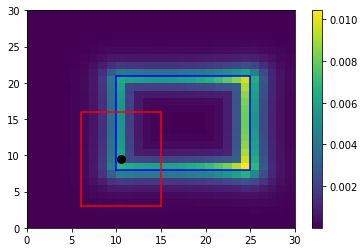

Creating TL
Done in: 1.861783504486084  sec
Memory:  [7058.28125]
Iteration: 0  Time: 5.271953344345093  Distance: 0.998729582691  marginal-improvement: 0.0012704173089
Iteration: 1  Time: 3.5104196071624756  Distance: 3.90709559602  marginal-improvement: -2.91206555181
Iteration: 2  Time: 3.4275705814361572  Distance: 1.21851929103  marginal-improvement: 0.688126573541
Iteration: 3  Time: 3.459265947341919  Distance: 0.581849817024  marginal-improvement: 0.522494373863
Iteration: 4  Time: 3.4272689819335938  Distance: 0.326599223579  marginal-improvement: 0.438688104691
Iteration: 5  Time: 3.3529000282287598  Distance: 0.198111132492  marginal-improvement: 0.393412114331
Iteration: 6  Time: 3.4458446502685547  Distance: 0.126910170584  marginal-improvement: 0.359399095911
Iteration: 7  Time: 3.4455089569091797  Distance: 0.087863978523  marginal-improvement: 0.307667950343
Iteration: 8  Time: 3.3755228519439697  Distance: 0.0606060281624  marginal-improvement: 0.31022895638
Iteration:

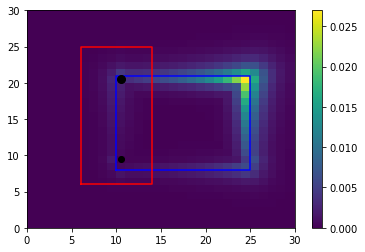

Creating TL
Done in: 0.6788876056671143  sec
Memory:  [4841.6328125]
Iteration: 0  Time: 1.4621663093566895  Distance: 0.997984686807  marginal-improvement: 0.00201531319253
Iteration: 1  Time: 1.4778060913085938  Distance: 1.25013837321  marginal-improvement: -0.252662881243
Iteration: 2  Time: 1.471949577331543  Distance: 0.455669200585  marginal-improvement: 0.635504988609
Iteration: 3  Time: 1.4737224578857422  Distance: 0.209032808997  marginal-improvement: 0.541261931399
Iteration: 4  Time: 1.4664835929870605  Distance: 0.107848369789  marginal-improvement: 0.484060084605
Iteration: 5  Time: 1.4692320823669434  Distance: 0.0592858155345  marginal-improvement: 0.450285473479
Iteration: 6  Time: 1.472771406173706  Distance: 0.0344565496908  marginal-improvement: 0.418806178508
Iteration: 7  Time: 1.471996784210205  Distance: 0.0204757816251  marginal-improvement: 0.405750668338
Iteration: 8  Time: 1.4777956008911133  Distance: 0.0121948310924  marginal-improvement: 0.404426589632
I

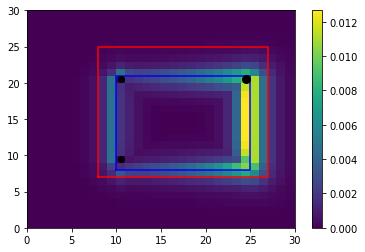

Creating TL
Done in: 0.18093061447143555  sec
Memory:  [4300.8203125]
Iteration: 0  Time: 0.41092467308044434  Distance: 0.997096958075  marginal-improvement: 0.00290304192459
Iteration: 1  Time: 0.3756082057952881  Distance: 0.281794566788  marginal-improvement: 0.717384989989
Iteration: 2  Time: 0.3731071949005127  Distance: 0.0802075473057  marginal-improvement: 0.715368723322
Iteration: 3  Time: 0.37521958351135254  Distance: 0.0270501446238  marginal-improvement: 0.662748138642
Iteration: 4  Time: 0.37569260597229004  Distance: 0.00964864247103  marginal-improvement: 0.643305327746
Total SK iteration time: 1.9131555557250977
Non-zeros in M: 5.919303  x 10^6
Memory after updating: [4074.734375]
FALTAN: 1 Examples
Move:  1709
Selected sample: (24, 9)
Selected box: (10, 26, 9, 21)


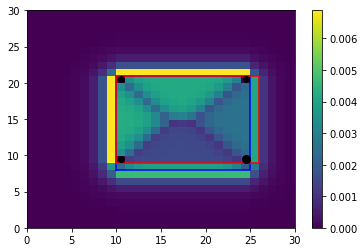

Creating TL
Done in: 0.16495966911315918  sec
Memory:  [4142.46484375]
Iteration: 0  Time: 0.3735661506652832  Distance: 0.996871283881  marginal-improvement: 0.00312871611935
Iteration: 1  Time: 0.38063716888427734  Distance: 0.28185834103  marginal-improvement: 0.717257036502
Iteration: 2  Time: 0.395416259765625  Distance: 0.0802863015191  marginal-improvement: 0.71515371436
Iteration: 3  Time: 0.38318753242492676  Distance: 0.0270894755392  marginal-improvement: 0.662589071527
Iteration: 4  Time: 0.3858144283294678  Distance: 0.00966595862113  marginal-improvement: 0.643183988294
Total SK iteration time: 1.9212539196014404
Non-zeros in M: 5.911808  x 10^6
Memory after updating: [4098.125]
###########################################
############### NEW TRIAL #################
###########################################
True hypothesis: (4, 17, 16, 20)
FALTAN: 3 Examples
Move:  1710
Selected sample: (16, 19)
Selected box: (4, 17, 17, 29)


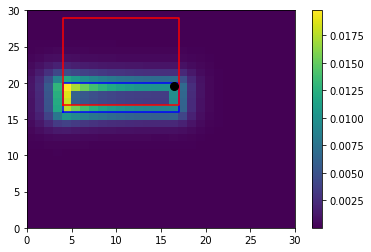

Creating TL
Done in: 1.9790985584259033  sec
Memory:  [7643.05859375]
Iteration: 0  Time: 4.0379650592803955  Distance: 0.998634849548  marginal-improvement: 0.00136515045238
Iteration: 1  Time: 3.8946142196655273  Distance: 3.09469823858  marginal-improvement: -2.09892874256
Iteration: 2  Time: 3.9305453300476074  Distance: 0.933830700614  marginal-improvement: 0.698248220466
Iteration: 3  Time: 3.8887851238250732  Distance: 0.422024884311  marginal-improvement: 0.548071310963
Iteration: 4  Time: 3.9052836894989014  Distance: 0.2222734573  marginal-improvement: 0.473316703438
Iteration: 5  Time: 3.900165319442749  Distance: 0.125935320542  marginal-improvement: 0.43342168664
Iteration: 6  Time: 3.871965169906616  Distance: 0.0788134399709  marginal-improvement: 0.374175254156
Iteration: 7  Time: 3.941909074783325  Distance: 0.0498590831827  marginal-improvement: 0.367378416662
Iteration: 8  Time: 3.8656046390533447  Distance: 0.0314608212479  marginal-improvement: 0.369005219518
Itera

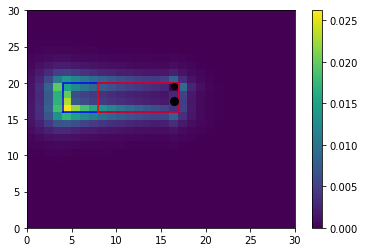

Creating TL
Done in: 1.775470495223999  sec
Memory:  [5851.50390625]
Iteration: 0  Time: 3.4888603687286377  Distance: 0.998480336731  marginal-improvement: 0.00151966326892
Iteration: 1  Time: 3.530626058578491  Distance: 2.45997746538  marginal-improvement: -1.46372149243
Iteration: 2  Time: 3.564427137374878  Distance: 0.754174781589  marginal-improvement: 0.693422077152
Iteration: 3  Time: 3.4944708347320557  Distance: 0.329027075446  marginal-improvement: 0.563725699297
Iteration: 4  Time: 3.5063893795013428  Distance: 0.164612231526  marginal-improvement: 0.49970004352
Iteration: 5  Time: 3.483323812484741  Distance: 0.0885978523275  marginal-improvement: 0.461778438297
Iteration: 6  Time: 3.470611810684204  Distance: 0.0520326793864  marginal-improvement: 0.412709472978
Iteration: 7  Time: 3.5540342330932617  Distance: 0.0303420474678  marginal-improvement: 0.416865557845
Iteration: 8  Time: 3.474172592163086  Distance: 0.0175926175822  marginal-improvement: 0.420190163472
Itera

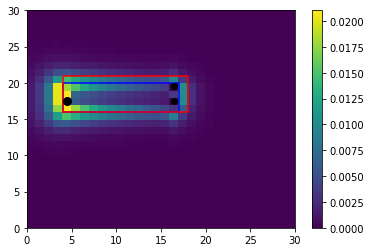

Creating TL
Done in: 0.42197704315185547  sec
Memory:  [5113.12890625]
Iteration: 0  Time: 0.9075827598571777  Distance: 0.998332170209  marginal-improvement: 0.00166782979094
Iteration: 1  Time: 0.9116570949554443  Distance: 1.15408569745  marginal-improvement: -0.156013731591
Iteration: 2  Time: 0.9032852649688721  Distance: 0.42837624098  marginal-improvement: 0.628817650261
Iteration: 3  Time: 0.9091453552246094  Distance: 0.191025108956  marginal-improvement: 0.554071653183
Iteration: 4  Time: 0.9070494174957275  Distance: 0.0928742230685  marginal-improvement: 0.513811437793
Iteration: 5  Time: 0.909142255783081  Distance: 0.0472334487902  marginal-improvement: 0.491425637495
Iteration: 6  Time: 0.9053833484649658  Distance: 0.0254540911036  marginal-improvement: 0.461100305915
Iteration: 7  Time: 0.9080791473388672  Distance: 0.0137715200383  marginal-improvement: 0.458966341316
Iteration: 8  Time: 0.9061501026153564  Distance: 0.00743875777637  marginal-improvement: 0.459844827

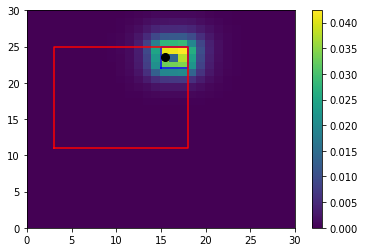

Creating TL
Done in: 1.4669995307922363  sec
Memory:  [7051.52734375]
Iteration: 0  Time: 3.446901798248291  Distance: 0.998842929111  marginal-improvement: 0.00115707088941
Iteration: 1  Time: 2.9275708198547363  Distance: 3.91796782248  marginal-improvement: -2.92250644049
Iteration: 2  Time: 2.944110155105591  Distance: 1.25189091121  marginal-improvement: 0.680474427577
Iteration: 3  Time: 2.96140193939209  Distance: 0.621022090519  marginal-improvement: 0.503932742896
Iteration: 4  Time: 2.9405176639556885  Distance: 0.366262881443  marginal-improvement: 0.410225679513
Iteration: 5  Time: 2.9376955032348633  Distance: 0.235968054448  marginal-improvement: 0.355741282004
Iteration: 6  Time: 2.8950462341308594  Distance: 0.160177920109  marginal-improvement: 0.321188113858
Iteration: 7  Time: 2.9346346855163574  Distance: 0.113572667862  marginal-improvement: 0.290959279628
Iteration: 8  Time: 2.944491147994995  Distance: 0.0847486135188  marginal-improvement: 0.253793935509
Iterati

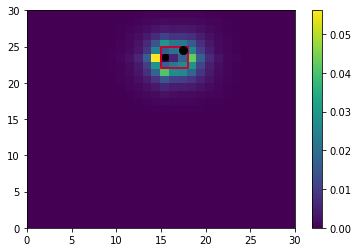

Creating TL
Done in: 0.9836547374725342  sec
Memory:  [5031.39453125]
Iteration: 0  Time: 2.0695292949676514  Distance: 0.998737372581  marginal-improvement: 0.00126262741877
Iteration: 1  Time: 2.0817809104919434  Distance: 3.35682568628  marginal-improvement: -2.36106946474
Iteration: 2  Time: 2.09765887260437  Distance: 1.15610498525  marginal-improvement: 0.655595764183
Iteration: 3  Time: 2.0874838829040527  Distance: 0.584068463388  marginal-improvement: 0.494796345628
Iteration: 4  Time: 2.109283447265625  Distance: 0.347192987906  marginal-improvement: 0.40556114622
Iteration: 5  Time: 2.0905487537384033  Distance: 0.224563093655  marginal-improvement: 0.35320383338
Iteration: 6  Time: 2.0937976837158203  Distance: 0.152697195983  marginal-improvement: 0.320025416919
Iteration: 7  Time: 2.093517780303955  Distance: 0.107695658796  marginal-improvement: 0.2947109598
Iteration: 8  Time: 2.120520830154419  Distance: 0.0802065347219  marginal-improvement: 0.255248209461
Iteration: 

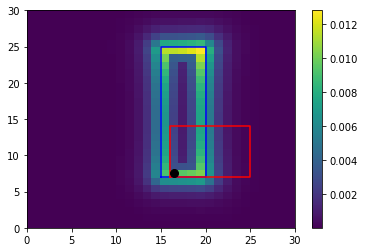

Creating TL
Done in: 1.6366298198699951  sec
Memory:  [7547.734375]
Iteration: 0  Time: 3.333181858062744  Distance: 0.998780595994  marginal-improvement: 0.00121940400647
Iteration: 1  Time: 3.266981601715088  Distance: 3.80558893142  marginal-improvement: -2.81023514743
Iteration: 2  Time: 3.2005465030670166  Distance: 1.19856845076  marginal-improvement: 0.685050468572
Iteration: 3  Time: 3.2705891132354736  Distance: 0.581497079114  marginal-improvement: 0.514840325769
Iteration: 4  Time: 3.2051806449890137  Distance: 0.33377970354  marginal-improvement: 0.425999346294
Iteration: 5  Time: 3.27095365524292  Distance: 0.208488812089  marginal-improvement: 0.375370012383
Iteration: 6  Time: 3.2198455333709717  Distance: 0.136795496706  marginal-improvement: 0.343871283376
Iteration: 7  Time: 3.2679784297943115  Distance: 0.0967548712457  marginal-improvement: 0.292704266037
Iteration: 8  Time: 3.2644412517547607  Distance: 0.0695139216666  marginal-improvement: 0.281546026865
Iteratio

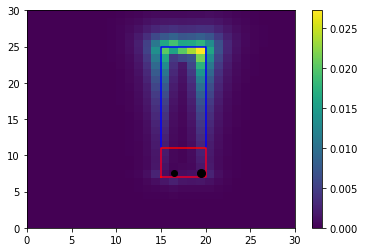

Creating TL
Done in: 1.1325082778930664  sec
Memory:  [5593.71875]
Iteration: 0  Time: 2.4009482860565186  Distance: 0.998650522901  marginal-improvement: 0.00134947709898
Iteration: 1  Time: 2.403333902359009  Distance: 3.36509395214  marginal-improvement: -2.36964120578
Iteration: 2  Time: 2.431682825088501  Distance: 1.11942706753  marginal-improvement: 0.667341511575
Iteration: 3  Time: 2.4045779705047607  Distance: 0.546575404666  marginal-improvement: 0.511736476166
Iteration: 4  Time: 2.4238767623901367  Distance: 0.314061630447  marginal-improvement: 0.425401092391
Iteration: 5  Time: 2.4090261459350586  Distance: 0.195962745903  marginal-improvement: 0.376037290437
Iteration: 6  Time: 2.413128614425659  Distance: 0.128230322486  marginal-improvement: 0.345639285188
Iteration: 7  Time: 2.4110641479492188  Distance: 0.08902306203  marginal-improvement: 0.305756545688
Iteration: 8  Time: 2.4088029861450195  Distance: 0.063554467849  marginal-improvement: 0.286089846835
Iteration:

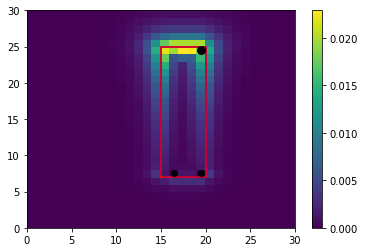

Creating TL
Done in: 0.2565650939941406  sec
Memory:  [5014.9921875]
Iteration: 0  Time: 0.5131607055664062  Distance: 0.997270271093  marginal-improvement: 0.00272972890734
Iteration: 1  Time: 0.5136713981628418  Distance: 0.488309608246  marginal-improvement: 0.510353790341
Iteration: 2  Time: 0.5138468742370605  Distance: 0.183479684852  marginal-improvement: 0.624255427798
Iteration: 3  Time: 0.5142717361450195  Distance: 0.0822762841653  marginal-improvement: 0.55157823477
Iteration: 4  Time: 0.5177140235900879  Distance: 0.0391247989393  marginal-improvement: 0.524470516185
Iteration: 5  Time: 0.5180389881134033  Distance: 0.019100916938  marginal-improvement: 0.511795141296
Iteration: 6  Time: 0.5168309211730957  Distance: 0.00955666935588  marginal-improvement: 0.499674838287
Total SK iteration time: 3.611499786376953
Non-zeros in M: 8.050575  x 10^6
Memory after updating: [4662.23046875]
###########################################
############### NEW TRIAL #################
##

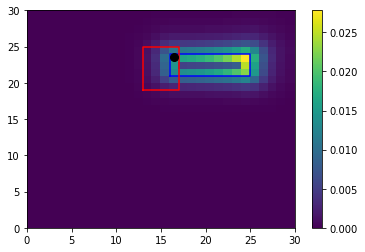

Creating TL
Done in: 1.493044376373291  sec
Memory:  [6888.69140625]
Iteration: 0  Time: 3.9198575019836426  Distance: 0.998846821348  marginal-improvement: 0.00115317865182
Iteration: 1  Time: 2.8930017948150635  Distance: 4.11093038458  marginal-improvement: -3.11567649485
Iteration: 2  Time: 2.889188051223755  Distance: 1.31465542961  marginal-improvement: 0.6802048912
Iteration: 3  Time: 2.9082446098327637  Distance: 0.652781082877  marginal-improvement: 0.503458420986
Iteration: 4  Time: 2.873887062072754  Distance: 0.385058924813  marginal-improvement: 0.41012548477
Iteration: 5  Time: 2.8899693489074707  Distance: 0.247906792467  marginal-improvement: 0.356184790192
Iteration: 6  Time: 2.8488786220550537  Distance: 0.168068944096  marginal-improvement: 0.32204784539
Iteration: 7  Time: 2.881072759628296  Distance: 0.119221778679  marginal-improvement: 0.290637664677
Iteration: 8  Time: 2.8686575889587402  Distance: 0.0890751241659  marginal-improvement: 0.252861975783
Iteration:

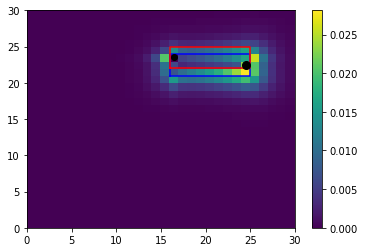

Creating TL
Done in: 0.5104284286499023  sec
Memory:  [4608.35546875]
Iteration: 0  Time: 1.1299018859863281  Distance: 0.998728111003  marginal-improvement: 0.00127188899667
Iteration: 1  Time: 1.0964643955230713  Distance: 2.4968528037  marginal-improvement: -1.50003256761
Iteration: 2  Time: 1.105616807937622  Distance: 0.978021061338  marginal-improvement: 0.608298470823
Iteration: 3  Time: 1.097562551498413  Distance: 0.500383196119  marginal-improvement: 0.488371758135
Iteration: 4  Time: 1.0980274677276611  Distance: 0.292212413032  marginal-improvement: 0.416022729584
Iteration: 5  Time: 1.0990796089172363  Distance: 0.183519107618  marginal-improvement: 0.371966763104
Iteration: 6  Time: 1.0949366092681885  Distance: 0.120403202953  marginal-improvement: 0.343920071781
Iteration: 7  Time: 1.094435453414917  Distance: 0.0849078371689  marginal-improvement: 0.294804165614
Iteration: 8  Time: 1.0903818607330322  Distance: 0.0604443505681  marginal-improvement: 0.288118122148
Iter

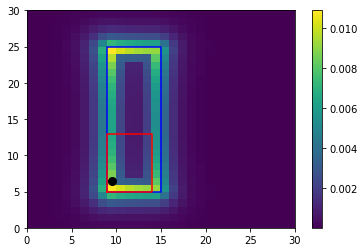

Creating TL
Done in: 1.1765837669372559  sec
Memory:  [7425.62890625]
Iteration: 0  Time: 2.7562255859375  Distance: 0.998906966511  marginal-improvement: 0.00109303348902
Iteration: 1  Time: 2.501237154006958  Distance: 5.08311031218  marginal-improvement: -4.08867240153
Iteration: 2  Time: 2.518648386001587  Distance: 1.65029967189  marginal-improvement: 0.675336640259
Iteration: 3  Time: 2.5040271282196045  Distance: 0.838836330337  marginal-improvement: 0.491706661143
Iteration: 4  Time: 2.5061028003692627  Distance: 0.506055832442  marginal-improvement: 0.396716839579
Iteration: 5  Time: 2.5068228244781494  Distance: 0.332108294225  marginal-improvement: 0.343731910722
Iteration: 6  Time: 2.5119516849517822  Distance: 0.228748071251  marginal-improvement: 0.311224455309
Iteration: 7  Time: 2.508767604827881  Distance: 0.162448098466  marginal-improvement: 0.28983839043
Iteration: 8  Time: 2.5097246170043945  Distance: 0.12331816338  marginal-improvement: 0.240876535061
Iteration: 

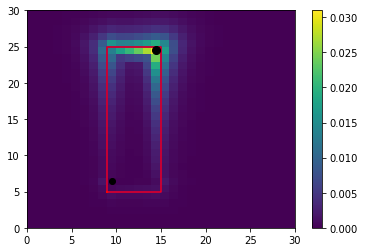

Creating TL
Done in: 0.1852421760559082  sec
Memory:  [5004.91015625]
Iteration: 0  Time: 0.4008369445800781  Distance: 0.997175854839  marginal-improvement: 0.00282414516109
Iteration: 1  Time: 0.4118642807006836  Distance: 0.346056250494  marginal-improvement: 0.65296366853
Iteration: 2  Time: 0.39129185676574707  Distance: 0.127282088346  marginal-improvement: 0.632192488463
Iteration: 3  Time: 0.39134907722473145  Distance: 0.0558418568303  marginal-improvement: 0.561274822279
Iteration: 4  Time: 0.39188098907470703  Distance: 0.0265074362357  marginal-improvement: 0.525312413656
Iteration: 5  Time: 0.39188122749328613  Distance: 0.0129890006814  marginal-improvement: 0.509986534877
Iteration: 6  Time: 0.39382386207580566  Distance: 0.00638186270681  marginal-improvement: 0.508671770573
Total SK iteration time: 2.777421474456787
Non-zeros in M: 6.033662  x 10^6
Memory after updating: [4642.77734375]
47
###########################################
############### NEW TRIAL ##########

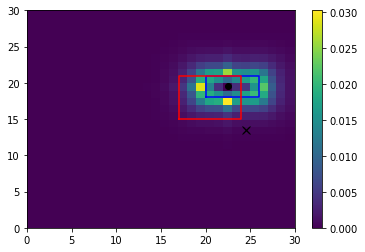

Creating TL
Done in: 0.6017513275146484  sec
Memory:  [4803.62890625]
Iteration: 0  Time: 1.3133018016815186  Distance: 52.6673459324  marginal-improvement: -51.6673459324
Iteration: 1  Time: 1.2935092449188232  Distance: 9.22861481  marginal-improvement: 0.82477539647
Iteration: 2  Time: 1.2967596054077148  Distance: 3.22904601046  marginal-improvement: 0.650105018257
Iteration: 3  Time: 1.2960054874420166  Distance: 1.86241950005  marginal-improvement: 0.423229184712
Iteration: 4  Time: 1.2959351539611816  Distance: 1.29192477908  marginal-improvement: 0.306319130012
Iteration: 5  Time: 1.29180908203125  Distance: 0.97555297462  marginal-improvement: 0.244884074973
Iteration: 6  Time: 1.2944128513336182  Distance: 0.773379755692  marginal-improvement: 0.207239610957
Iteration: 7  Time: 1.3073515892028809  Distance: 0.632590088  marginal-improvement: 0.18204467683
Iteration: 8  Time: 1.2999863624572754  Distance: 0.528669588199  marginal-improvement: 0.164277787104
Iteration: 9  Time:

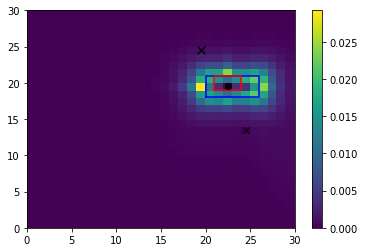

Creating TL
Done in: 0.3127143383026123  sec
Memory:  [4397.12890625]
Iteration: 0  Time: 0.6500861644744873  Distance: 111.849055172  marginal-improvement: -110.849055172
Iteration: 1  Time: 0.6550402641296387  Distance: 11.1704918959  marginal-improvement: 0.900128866724
Iteration: 2  Time: 0.6533167362213135  Distance: 4.19780626509  marginal-improvement: 0.624205782142
Iteration: 3  Time: 0.6648385524749756  Distance: 2.53321730343  marginal-improvement: 0.396537823936
Iteration: 4  Time: 0.664863109588623  Distance: 1.80509512676  marginal-improvement: 0.287429813339
Iteration: 5  Time: 0.6594319343566895  Distance: 1.39184619424  marginal-improvement: 0.228934711746
Iteration: 6  Time: 0.6594095230102539  Distance: 1.14058673663  marginal-improvement: 0.180522430312
Iteration: 7  Time: 0.664283275604248  Distance: 0.961598558746  marginal-improvement: 0.156926406505
Iteration: 8  Time: 0.6604108810424805  Distance: 0.825322858591  marginal-improvement: 0.141717870639
Iteration: 9

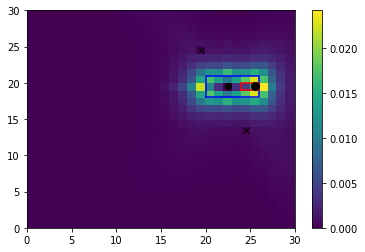

Creating TL
Done in: 0.10284972190856934  sec
Memory:  [4211.8046875]
Iteration: 0  Time: 0.20754551887512207  Distance: 174729.725172  marginal-improvement: -174728.725172
Iteration: 1  Time: 0.19727396965026855  Distance: 4.59366780571  marginal-improvement: 0.999973709866
Iteration: 2  Time: 0.1928396224975586  Distance: 1.18866156277  marginal-improvement: 0.741239111523
Iteration: 3  Time: 0.21120834350585938  Distance: 0.504720904302  marginal-improvement: 0.575387208513
Iteration: 4  Time: 0.19440197944641113  Distance: 0.275345364305  marginal-improvement: 0.4544601542
Iteration: 5  Time: 0.21943306922912598  Distance: 0.181493043496  marginal-improvement: 0.340853099327
Iteration: 6  Time: 0.1930232048034668  Distance: 0.13139407653  marginal-improvement: 0.276037946145
Iteration: 7  Time: 0.1953110694885254  Distance: 0.101397839805  marginal-improvement: 0.228292153777
Iteration: 8  Time: 0.19345331192016602  Distance: 0.077723393795  marginal-improvement: 0.233480772921
Ite

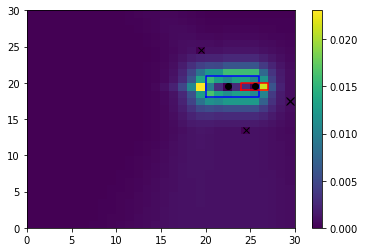

Creating TL
Done in: 0.07595372200012207  sec
Memory:  [4141.65625]
Iteration: 0  Time: 0.17665624618530273  Distance: 198273.624741  marginal-improvement: -198272.624741
Iteration: 1  Time: 0.16607117652893066  Distance: 4.86135983289  marginal-improvement: 0.999975481561
Iteration: 2  Time: 0.16683697700500488  Distance: 1.22619207798  marginal-improvement: 0.747767678155
Iteration: 3  Time: 0.16512227058410645  Distance: 0.5195549665  marginal-improvement: 0.576285823541
Iteration: 4  Time: 0.1656951904296875  Distance: 0.283083607622  marginal-improvement: 0.455142139187
Iteration: 5  Time: 0.16566991806030273  Distance: 0.181913387243  marginal-improvement: 0.35738636097
Iteration: 6  Time: 0.16604399681091309  Distance: 0.128099429724  marginal-improvement: 0.295821865203
Iteration: 7  Time: 0.16884136199951172  Distance: 0.0956801196467  marginal-improvement: 0.253079269337
Iteration: 8  Time: 0.16641020774841309  Distance: 0.0761017735598  marginal-improvement: 0.204622926468
I

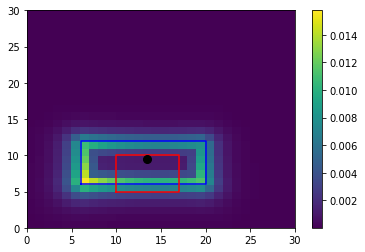

Creating TL
Done in: 1.840775728225708  sec
Memory:  [7769.37890625]
Iteration: 0  Time: 3.948939800262451  Distance: 0.998675857337  marginal-improvement: 0.00132414266306
Iteration: 1  Time: 3.637277364730835  Distance: 3.30436700907  marginal-improvement: -2.30874826381
Iteration: 2  Time: 3.6685638427734375  Distance: 1.01066781761  marginal-improvement: 0.694141778188
Iteration: 3  Time: 3.6442952156066895  Distance: 0.467470041904  marginal-improvement: 0.537464205588
Iteration: 4  Time: 3.715535879135132  Distance: 0.253344821277  marginal-improvement: 0.458051214909
Iteration: 5  Time: 3.6636881828308105  Distance: 0.14831680418  marginal-improvement: 0.414565478653
Iteration: 6  Time: 3.595470666885376  Distance: 0.0944505650562  marginal-improvement: 0.363183655564
Iteration: 7  Time: 3.621890068054199  Distance: 0.0623238933465  marginal-improvement: 0.340142715828
Iteration: 8  Time: 3.6211459636688232  Distance: 0.0410997654148  marginal-improvement: 0.340545604455
Iterati

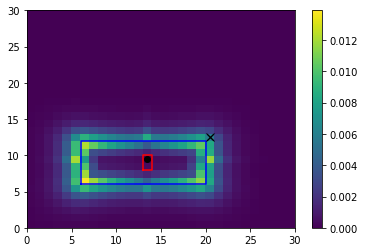

Creating TL
Done in: 0.7814686298370361  sec
Memory:  [5543.34765625]
Iteration: 0  Time: 1.683556318283081  Distance: 5001.4033507  marginal-improvement: -5000.4033507
Iteration: 1  Time: 1.6951074600219727  Distance: 4.06563699167  marginal-improvement: 0.999187100758
Iteration: 2  Time: 1.694185733795166  Distance: 1.32208415681  marginal-improvement: 0.674815002049
Iteration: 3  Time: 1.6943020820617676  Distance: 0.667461961048  marginal-improvement: 0.495144119524
Iteration: 4  Time: 1.6932618618011475  Distance: 0.402280394762  marginal-improvement: 0.397298395656
Iteration: 5  Time: 1.6972122192382812  Distance: 0.272239779844  marginal-improvement: 0.323258643999
Iteration: 6  Time: 1.686779499053955  Distance: 0.212287323994  marginal-improvement: 0.220219307716
Iteration: 7  Time: 1.6931564807891846  Distance: 0.167338857585  marginal-improvement: 0.211734104341
Iteration: 8  Time: 1.6960575580596924  Distance: 0.133164108548  marginal-improvement: 0.204224825785
Iteration: 

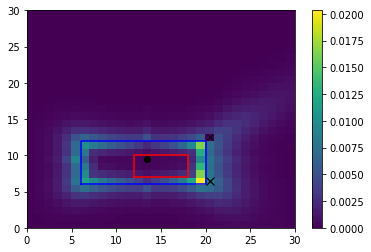

Creating TL
Done in: 0.6805999279022217  sec
Memory:  [5222.8984375]
Iteration: 0  Time: 1.478379487991333  Distance: 4187.11181492  marginal-improvement: -4186.11181492
Iteration: 1  Time: 1.4560611248016357  Distance: 6.17648709251  marginal-improvement: 0.998524881263
Iteration: 2  Time: 1.454024076461792  Distance: 2.05224528291  marginal-improvement: 0.667732603959
Iteration: 3  Time: 1.4591574668884277  Distance: 1.08399101974  marginal-improvement: 0.471802406483
Iteration: 4  Time: 1.4530093669891357  Distance: 0.679449719852  marginal-improvement: 0.373196172772
Iteration: 5  Time: 1.4530787467956543  Distance: 0.45783928797  marginal-improvement: 0.326161635522
Iteration: 6  Time: 1.4549074172973633  Distance: 0.320844314824  marginal-improvement: 0.299220658309
Iteration: 7  Time: 1.4569272994995117  Distance: 0.24456559304  marginal-improvement: 0.237743722609
Iteration: 8  Time: 1.4516746997833252  Distance: 0.202777098299  marginal-improvement: 0.170868249381
Iteration: 9

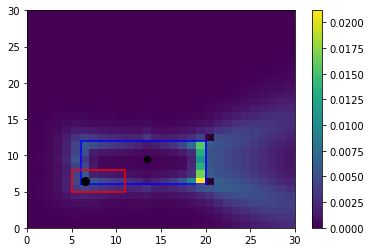

Creating TL
Done in: 0.20106911659240723  sec
Memory:  [4918.0390625]
Iteration: 0  Time: 0.4158163070678711  Distance: 770.09521987  marginal-improvement: -769.09521987
Iteration: 1  Time: 0.4160029888153076  Distance: 2.26076473984  marginal-improvement: 0.997064304931
Iteration: 2  Time: 0.4136083126068115  Distance: 0.74286113795  marginal-improvement: 0.671411569342
Iteration: 3  Time: 0.41588902473449707  Distance: 0.33053091662  marginal-improvement: 0.555056928227
Iteration: 4  Time: 0.41466522216796875  Distance: 0.167747649539  marginal-improvement: 0.492490290306
Iteration: 5  Time: 0.41626548767089844  Distance: 0.0912900756925  marginal-improvement: 0.455789240901
Iteration: 6  Time: 0.4132668972015381  Distance: 0.0517829220462  marginal-improvement: 0.432765044246
Iteration: 7  Time: 0.4173088073730469  Distance: 0.0301589918343  marginal-improvement: 0.417588064895
Iteration: 8  Time: 0.41570448875427246  Distance: 0.0182247383172  marginal-improvement: 0.395711288448
I

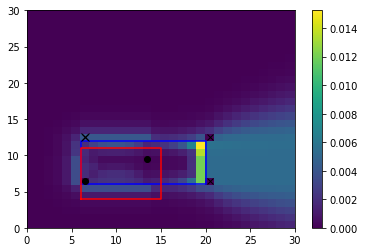

Creating TL
Done in: 0.019036293029785156  sec
Memory:  [4625.47265625]
Iteration: 0  Time: 0.07072257995605469  Distance: 12936935.48  marginal-improvement: -12936934.48
Iteration: 1  Time: 0.052327632904052734  Distance: 1.08824480681  marginal-improvement: 0.999999915881
Iteration: 2  Time: 0.04717516899108887  Distance: 0.191183863035  marginal-improvement: 0.824319066961
Iteration: 3  Time: 0.046324968338012695  Distance: 0.0680132376512  marginal-improvement: 0.64425220533
Iteration: 4  Time: 0.04618334770202637  Distance: 0.0244801167045  marginal-improvement: 0.640068352134
Iteration: 5  Time: 0.04632902145385742  Distance: 0.00891673226615  marginal-improvement: 0.635756137367
Total SK iteration time: 0.31232500076293945
Non-zeros in M: 0.92006  x 10^6
Memory after updating: [4576.23046875]
###########################################
############### NEW TRIAL #################
###########################################
True hypothesis: (5, 8, 5, 13)
FALTAN: 5 Examples
Move:  

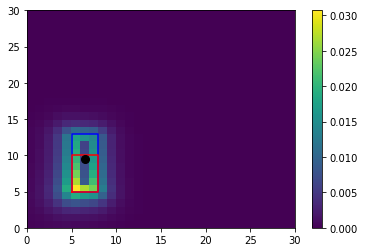

Creating TL
Done in: 1.2395384311676025  sec
Memory:  [6945.8359375]
Iteration: 0  Time: 7.680926084518433  Distance: 0.998906934324  marginal-improvement: 0.00109306567567
Iteration: 1  Time: 2.5226826667785645  Distance: 5.08221226648  marginal-improvement: -4.08777353709
Iteration: 2  Time: 2.546215057373047  Distance: 1.65012033984  marginal-improvement: 0.675314557261
Iteration: 3  Time: 2.5235073566436768  Distance: 0.838768523791  marginal-improvement: 0.491692512635
Iteration: 4  Time: 2.5205421447753906  Distance: 0.506022364019  marginal-improvement: 0.396707971668
Iteration: 5  Time: 2.5268783569335938  Distance: 0.332088950551  marginal-improvement: 0.343726731931
Iteration: 6  Time: 2.5332303047180176  Distance: 0.228735681095  marginal-improvement: 0.311221644938
Iteration: 7  Time: 2.530360221862793  Distance: 0.162439606116  marginal-improvement: 0.289837049741
Iteration: 8  Time: 2.5329091548919678  Distance: 0.123317157864  marginal-improvement: 0.240843038143
Iterati

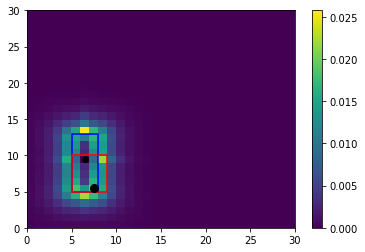

Creating TL
Done in: 0.6214208602905273  sec
Memory:  [4810.453125]
Iteration: 0  Time: 1.3485534191131592  Distance: 0.998916972706  marginal-improvement: 0.00108302729415
Iteration: 1  Time: 1.3460233211517334  Distance: 3.69239430522  marginal-improvement: -2.69639760472
Iteration: 2  Time: 1.3490090370178223  Distance: 1.3797589072  marginal-improvement: 0.626324061532
Iteration: 3  Time: 1.3498618602752686  Distance: 0.716695153402  marginal-improvement: 0.480564938076
Iteration: 4  Time: 1.3512756824493408  Distance: 0.431132886751  marginal-improvement: 0.398443139032
Iteration: 5  Time: 1.351147174835205  Distance: 0.279601660151  marginal-improvement: 0.351472205571
Iteration: 6  Time: 1.344243049621582  Distance: 0.189338625611  marginal-improvement: 0.322827248204
Iteration: 7  Time: 1.3482110500335693  Distance: 0.134224253852  marginal-improvement: 0.291088897374
Iteration: 8  Time: 1.3506758213043213  Distance: 0.100420570051  marginal-improvement: 0.251844825588
Iteratio

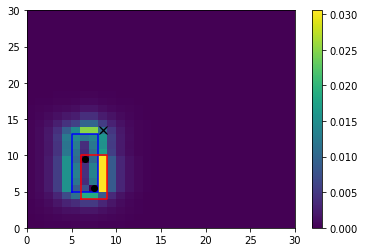

Creating TL
Done in: 0.10557174682617188  sec
Memory:  [4337.73828125]
Iteration: 0  Time: 0.2485816478729248  Distance: 1509751.24047  marginal-improvement: -1509750.24047
Iteration: 1  Time: 0.22796392440795898  Distance: 7.67243002656  marginal-improvement: 0.999994918083
Iteration: 2  Time: 0.22379851341247559  Distance: 3.37564077157  marginal-improvement: 0.560029774155
Iteration: 3  Time: 0.2446587085723877  Distance: 2.14274975452  marginal-improvement: 0.365231699841
Iteration: 4  Time: 0.22452640533447266  Distance: 1.57193354709  marginal-improvement: 0.266394247029
Iteration: 5  Time: 0.25614500045776367  Distance: 1.23654075106  marginal-improvement: 0.213363215417
Iteration: 6  Time: 0.2236621379852295  Distance: 1.01272852649  marginal-improvement: 0.180998664525
Iteration: 7  Time: 0.22555279731750488  Distance: 0.849177008197  marginal-improvement: 0.16149591328
Iteration: 8  Time: 0.22603178024291992  Distance: 0.723588138003  marginal-improvement: 0.14789480754
Itera

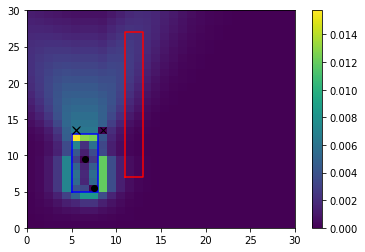

Creating TL
Done in: 0.07849860191345215  sec
Memory:  [4199.83203125]
Iteration: 0  Time: 0.2036428451538086  Distance: 997452.113967  marginal-improvement: -997451.113967
Iteration: 1  Time: 0.19330835342407227  Distance: 29.6740257025  marginal-improvement: 0.999970250175
Iteration: 2  Time: 0.1933145523071289  Distance: 12.8653738753  marginal-improvement: 0.566443259022
Iteration: 3  Time: 0.1991574764251709  Distance: 7.17669927742  marginal-improvement: 0.442169396164
Iteration: 4  Time: 0.22279715538024902  Distance: 3.84955919929  marginal-improvement: 0.463603106319
Iteration: 5  Time: 0.1929466724395752  Distance: 1.71840353845  marginal-improvement: 0.553610309782
Iteration: 6  Time: 0.19312834739685059  Distance: 0.695315324282  marginal-improvement: 0.595371338149
Iteration: 7  Time: 0.1967329978942871  Distance: 0.501789896357  marginal-improvement: 0.278327574795
Iteration: 8  Time: 0.21947216987609863  Distance: 0.442403542681  marginal-improvement: 0.118349042312
Iter

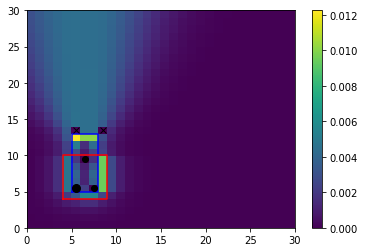

Creating TL
Done in: 0.06557440757751465  sec
Memory:  [4226.6953125]
Iteration: 0  Time: 0.16016483306884766  Distance: 711206.130555  marginal-improvement: -711205.130555
Iteration: 1  Time: 0.15912532806396484  Distance: 2.50100591796  marginal-improvement: 0.99999648343
Iteration: 2  Time: 0.15928173065185547  Distance: 0.711073705239  marginal-improvement: 0.715684916964
Iteration: 3  Time: 0.1590862274169922  Distance: 0.304483442475  marginal-improvement: 0.571797634715
Iteration: 4  Time: 0.16102290153503418  Distance: 0.16059657886  marginal-improvement: 0.472560551883
Iteration: 5  Time: 0.16098475456237793  Distance: 0.0929842283943  marginal-improvement: 0.421007414639
Iteration: 6  Time: 0.16134262084960938  Distance: 0.0556176215941  marginal-improvement: 0.401859621201
Iteration: 7  Time: 0.16276264190673828  Distance: 0.0338691116208  marginal-improvement: 0.391036318166
Iteration: 8  Time: 0.16050124168395996  Distance: 0.0208396394986  marginal-improvement: 0.38470073

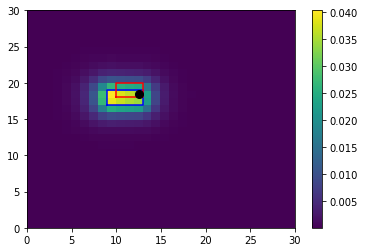

Creating TL
Done in: 1.9908263683319092  sec
Memory:  [7742.27734375]
Iteration: 0  Time: 4.043675422668457  Distance: 0.998613770411  marginal-improvement: 0.00138622958924
Iteration: 1  Time: 3.9930665493011475  Distance: 3.07286982804  marginal-improvement: -2.07713544424
Iteration: 2  Time: 3.947340965270996  Distance: 0.922659068977  marginal-improvement: 0.69974026867
Iteration: 3  Time: 3.9888150691986084  Distance: 0.413139755454  marginal-improvement: 0.552229236838
Iteration: 4  Time: 4.040381193161011  Distance: 0.214878360989  marginal-improvement: 0.479889412354
Iteration: 5  Time: 3.896899461746216  Distance: 0.119841215826  marginal-improvement: 0.442283460866
Iteration: 6  Time: 3.99310040473938  Distance: 0.0740805784491  marginal-improvement: 0.38184390121
Iteration: 7  Time: 3.954813003540039  Distance: 0.0459117577471  marginal-improvement: 0.380245690459
Iteration: 8  Time: 3.993872880935669  Distance: 0.0283053173176  marginal-improvement: 0.383484346788
Iteration

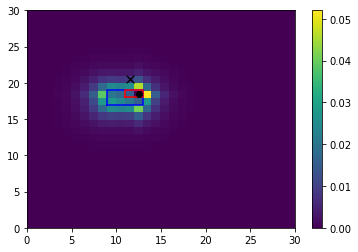

Creating TL
Done in: 0.3898184299468994  sec
Memory:  [5226.87109375]
Iteration: 0  Time: 0.816601037979126  Distance: 1060.80758864  marginal-improvement: -1059.80758864
Iteration: 1  Time: 0.8254570960998535  Distance: 5.3702421427  marginal-improvement: 0.994937590756
Iteration: 2  Time: 0.8283109664916992  Distance: 1.64817948295  marginal-improvement: 0.693090285473
Iteration: 3  Time: 0.8201508522033691  Distance: 0.826978062278  marginal-improvement: 0.498247569011
Iteration: 4  Time: 0.8197174072265625  Distance: 0.495317587249  marginal-improvement: 0.401051116296
Iteration: 5  Time: 0.8210148811340332  Distance: 0.323641324421  marginal-improvement: 0.346598358806
Iteration: 6  Time: 0.820429801940918  Distance: 0.25107469714  marginal-improvement: 0.224219287851
Iteration: 7  Time: 0.8262581825256348  Distance: 0.197952253717  marginal-improvement: 0.211580234998
Iteration: 8  Time: 0.8287503719329834  Distance: 0.156117630648  marginal-improvement: 0.211336937485
Iteration:

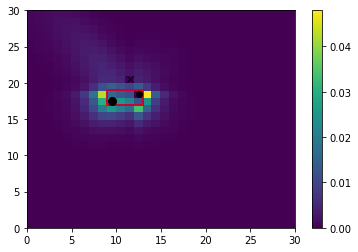

Creating TL
Done in: 0.1852867603302002  sec
Memory:  [4707.390625]
Iteration: 0  Time: 0.37343931198120117  Distance: 406.051006778  marginal-improvement: -405.051006778
Iteration: 1  Time: 0.3738231658935547  Distance: 2.5808877082  marginal-improvement: 0.993643932252
Iteration: 2  Time: 0.3770625591278076  Distance: 0.856746589092  marginal-improvement: 0.668041896449
Iteration: 3  Time: 0.37581324577331543  Distance: 0.408357473703  marginal-improvement: 0.523362591807
Iteration: 4  Time: 0.37680745124816895  Distance: 0.224378882564  marginal-improvement: 0.450533179839
Iteration: 5  Time: 0.377044677734375  Distance: 0.131924241055  marginal-improvement: 0.412046982554
Iteration: 6  Time: 0.3741166591644287  Distance: 0.0869162232929  marginal-improvement: 0.341165637203
Iteration: 7  Time: 0.3765296936035156  Distance: 0.0571676470006  marginal-improvement: 0.342267245001
Iteration: 8  Time: 0.37514638900756836  Distance: 0.0374770069484  marginal-improvement: 0.344436776487
It

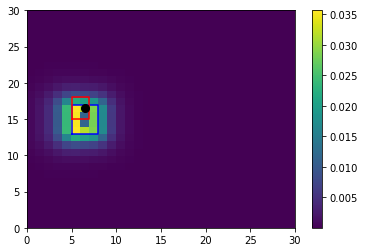

Creating TL
Done in: 1.608872413635254  sec
Memory:  [7029.27734375]
Iteration: 0  Time: 4.525374174118042  Distance: 0.998846821347  marginal-improvement: 0.00115317865284
Iteration: 1  Time: 2.9128077030181885  Distance: 4.10984222159  marginal-improvement: -3.11458707557
Iteration: 2  Time: 2.970379590988159  Distance: 1.31435528302  marginal-improvement: 0.680193250214
Iteration: 3  Time: 2.935991048812866  Distance: 0.652674644458  marginal-improvement: 0.503426012061
Iteration: 4  Time: 2.934319496154785  Distance: 0.385013395924  marginal-improvement: 0.410099045224
Iteration: 5  Time: 2.937373161315918  Distance: 0.247884192294  marginal-improvement: 0.356167356985
Iteration: 6  Time: 2.964625597000122  Distance: 0.168056366514  marginal-improvement: 0.322036774678
Iteration: 7  Time: 2.8844573497772217  Distance: 0.119209164969  marginal-improvement: 0.2906596314
Iteration: 8  Time: 2.894618272781372  Distance: 0.0890663249727  marginal-improvement: 0.252856732986
Iteration: 9

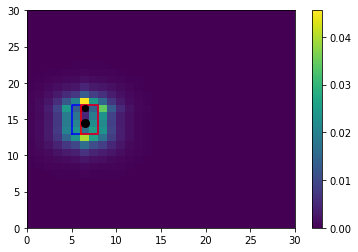

Creating TL
Done in: 1.1963245868682861  sec
Memory:  [5122.17578125]
Iteration: 0  Time: 2.4747209548950195  Distance: 0.998712279321  marginal-improvement: 0.00128772067934
Iteration: 1  Time: 2.5093328952789307  Distance: 3.47453718666  marginal-improvement: -2.47901718903
Iteration: 2  Time: 2.507464647293091  Distance: 1.1392108969  marginal-improvement: 0.672125858582
Iteration: 3  Time: 2.5007989406585693  Distance: 0.566025662042  marginal-improvement: 0.503142338629
Iteration: 4  Time: 2.5064284801483154  Distance: 0.334309049073  marginal-improvement: 0.409374748369
Iteration: 5  Time: 2.489183187484741  Distance: 0.215682006321  marginal-improvement: 0.354842452161
Iteration: 6  Time: 2.4986188411712646  Distance: 0.146519455626  marginal-improvement: 0.320669080721
Iteration: 7  Time: 2.4954278469085693  Distance: 0.102845881903  marginal-improvement: 0.298073546181
Iteration: 8  Time: 2.4884021282196045  Distance: 0.0760982894465  marginal-improvement: 0.260074511118
Itera

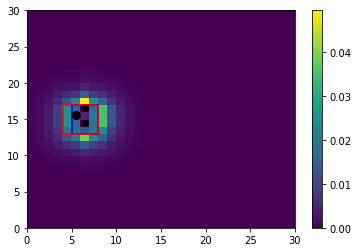

Creating TL
Done in: 0.9820244312286377  sec
Memory:  [4970.0078125]
Iteration: 0  Time: 2.0895206928253174  Distance: 0.998766002356  marginal-improvement: 0.00123399764444
Iteration: 1  Time: 2.102470874786377  Distance: 3.22317924302  marginal-improvement: -2.22716155277
Iteration: 2  Time: 2.098422050476074  Distance: 1.1043565836  marginal-improvement: 0.65737040967
Iteration: 3  Time: 2.0891880989074707  Distance: 0.557550928387  marginal-improvement: 0.495135052691
Iteration: 4  Time: 2.0873167514801025  Distance: 0.331822821892  marginal-improvement: 0.404856480372
Iteration: 5  Time: 2.084367275238037  Distance: 0.21508178845  marginal-improvement: 0.351817372826
Iteration: 6  Time: 2.0900766849517822  Distance: 0.146615536739  marginal-improvement: 0.318326587319
Iteration: 7  Time: 2.0806591510772705  Distance: 0.103206905543  marginal-improvement: 0.296071154265
Iteration: 8  Time: 2.099034547805786  Distance: 0.0768263702804  marginal-improvement: 0.255608237878
Iteration:

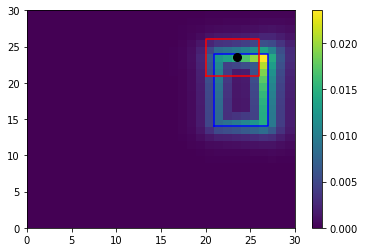

Creating TL
Done in: 0.9031634330749512  sec
Memory:  [7305.87109375]
Iteration: 0  Time: 2.165782928466797  Distance: 1.10332871488  marginal-improvement: -0.103328714877
Iteration: 1  Time: 1.936716079711914  Distance: 6.14944951289  marginal-improvement: -4.57354252633
Iteration: 2  Time: 1.9314372539520264  Distance: 2.04000510303  marginal-improvement: 0.668262159279
Iteration: 3  Time: 1.9329776763916016  Distance: 1.06901138674  marginal-improvement: 0.47597612126
Iteration: 4  Time: 1.9380054473876953  Distance: 0.666749870777  marginal-improvement: 0.376293013295
Iteration: 5  Time: 1.9285719394683838  Distance: 0.452744781862  marginal-improvement: 0.32096757464
Iteration: 6  Time: 1.9465000629425049  Distance: 0.322813448498  marginal-improvement: 0.286985821967
Iteration: 7  Time: 1.9324090480804443  Distance: 0.237416842553  marginal-improvement: 0.264538563501
Iteration: 8  Time: 1.9315521717071533  Distance: 0.178308980803  marginal-improvement: 0.248962378215
Iteration:

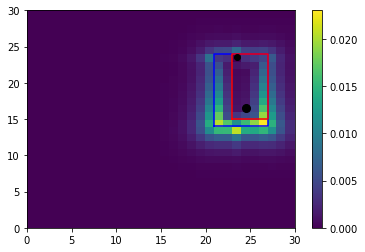

Creating TL
Done in: 0.530942440032959  sec
Memory:  [5146.69921875]
Iteration: 0  Time: 1.1369998455047607  Distance: 0.998779914645  marginal-improvement: 0.00122008535509
Iteration: 1  Time: 1.145413875579834  Distance: 2.83864815407  marginal-improvement: -1.84211577791
Iteration: 2  Time: 1.1490404605865479  Distance: 1.10790000977  marginal-improvement: 0.609708583228
Iteration: 3  Time: 1.145528793334961  Distance: 0.575716475336  marginal-improvement: 0.480353398087
Iteration: 4  Time: 1.140634298324585  Distance: 0.344599943659  marginal-improvement: 0.401441580324
Iteration: 5  Time: 1.1366870403289795  Distance: 0.222974393047  marginal-improvement: 0.352947099528
Iteration: 6  Time: 1.1402816772460938  Distance: 0.15126370633  marginal-improvement: 0.321609516395
Iteration: 7  Time: 1.1409542560577393  Distance: 0.107409382062  marginal-improvement: 0.289919672949
Iteration: 8  Time: 1.1433465480804443  Distance: 0.0796915155929  marginal-improvement: 0.258058150388
Iterati

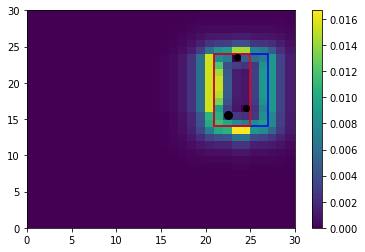

Creating TL
Done in: 0.4826829433441162  sec
Memory:  [4998.98828125]
Iteration: 0  Time: 1.0725171566009521  Distance: 0.998663419713  marginal-improvement: 0.00133658028666
Iteration: 1  Time: 1.0312013626098633  Distance: 2.26678059953  marginal-improvement: -1.2698143887
Iteration: 2  Time: 1.0332679748535156  Distance: 0.908177214129  marginal-improvement: 0.599353720287
Iteration: 3  Time: 1.0348615646362305  Distance: 0.468407998339  marginal-improvement: 0.484232822568
Iteration: 4  Time: 1.034874677658081  Distance: 0.274540147022  marginal-improvement: 0.413886722695
Iteration: 5  Time: 1.030534267425537  Distance: 0.172930895265  marginal-improvement: 0.370107078545
Iteration: 6  Time: 1.0318787097930908  Distance: 0.113831567951  marginal-improvement: 0.341751121011
Iteration: 7  Time: 1.0305333137512207  Distance: 0.0803051764872  marginal-improvement: 0.294526308184
Iteration: 8  Time: 1.032064437866211  Distance: 0.0571845842022  marginal-improvement: 0.287909114909
Iter

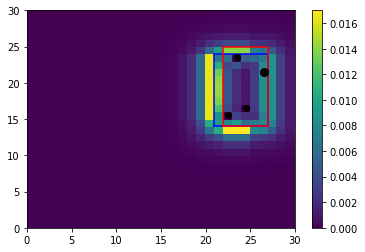

Creating TL
Done in: 0.3218870162963867  sec
Memory:  [4875.54296875]
Iteration: 0  Time: 0.6709597110748291  Distance: 0.998841619273  marginal-improvement: 0.00115838072686
Iteration: 1  Time: 0.6757705211639404  Distance: 2.10981760365  marginal-improvement: -1.11226441003
Iteration: 2  Time: 0.6744697093963623  Distance: 0.898671532997  marginal-improvement: 0.574052500348
Iteration: 3  Time: 0.6754097938537598  Distance: 0.47624116825  marginal-improvement: 0.470060916849
Iteration: 4  Time: 0.6709754467010498  Distance: 0.283406091926  marginal-improvement: 0.404910556206
Iteration: 5  Time: 0.6713666915893555  Distance: 0.180530791645  marginal-improvement: 0.362996079519
Iteration: 6  Time: 0.6713681221008301  Distance: 0.120266133605  marginal-improvement: 0.333819275322
Iteration: 7  Time: 0.6717891693115234  Distance: 0.0860586205307  marginal-improvement: 0.284431801778
Iteration: 8  Time: 0.6674633026123047  Distance: 0.0618669145457  marginal-improvement: 0.28110729449
It

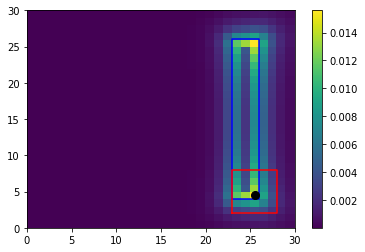

Creating TL
Done in: 0.5123157501220703  sec
Memory:  [6567.95703125]
Iteration: 0  Time: 2.1745665073394775  Distance: 1.5730822592  marginal-improvement: -0.573082259199
Iteration: 1  Time: 1.1253087520599365  Distance: 8.32874449747  marginal-improvement: -4.29453844436
Iteration: 2  Time: 1.1133887767791748  Distance: 2.85738382481  marginal-improvement: 0.656925023252
Iteration: 3  Time: 1.1138465404510498  Distance: 1.54846651022  marginal-improvement: 0.458082426037
Iteration: 4  Time: 1.1141626834869385  Distance: 1.00540289352  marginal-improvement: 0.350710598592
Iteration: 5  Time: 1.1129608154296875  Distance: 0.713397974444  marginal-improvement: 0.290435725778
Iteration: 6  Time: 1.1117198467254639  Distance: 0.53303130962  marginal-improvement: 0.252827553884
Iteration: 7  Time: 1.116682767868042  Distance: 0.411807167246  marginal-improvement: 0.227424055934
Iteration: 8  Time: 1.1159183979034424  Distance: 0.325615342546  marginal-improvement: 0.209301419587
Iteration:

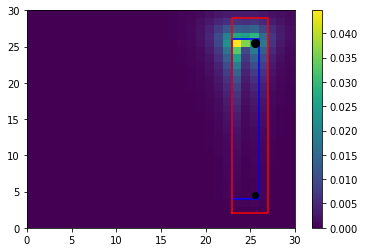

Creating TL
Done in: 0.06992483139038086  sec
Memory:  [4283.5625]
Iteration: 0  Time: 0.16304731369018555  Distance: 0.997793506651  marginal-improvement: 0.00220649334855
Iteration: 1  Time: 0.1550459861755371  Distance: 0.901848440419  marginal-improvement: 0.0961572365353
Iteration: 2  Time: 0.1560819149017334  Distance: 0.541118810287  marginal-improvement: 0.399989193267
Iteration: 3  Time: 0.15487337112426758  Distance: 0.345304603286  marginal-improvement: 0.361869155679
Iteration: 4  Time: 0.1548137664794922  Distance: 0.233412115294  marginal-improvement: 0.324039954656
Iteration: 5  Time: 0.15449857711791992  Distance: 0.165569791211  marginal-improvement: 0.290654681735
Iteration: 6  Time: 0.1535489559173584  Distance: 0.12185666729  marginal-improvement: 0.26401630153
Iteration: 7  Time: 0.1539745330810547  Distance: 0.0921291727814  marginal-improvement: 0.243954599857
Iteration: 8  Time: 0.15409016609191895  Distance: 0.0710081272324  marginal-improvement: 0.229254696546

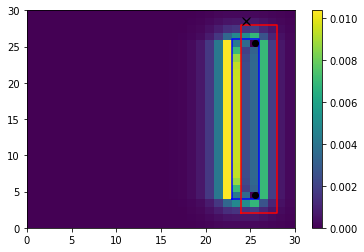

Creating TL
Done in: 0.04086947441101074  sec
Memory:  [4105.47265625]
Iteration: 0  Time: 0.09832286834716797  Distance: 0.998036116035  marginal-improvement: 0.00196388396467
Iteration: 1  Time: 0.09282636642456055  Distance: 1.00406620447  marginal-improvement: -0.00604195412848
Iteration: 2  Time: 0.09360527992248535  Distance: 0.553409757301  marginal-improvement: 0.448831406894
Iteration: 3  Time: 0.09581232070922852  Distance: 0.383651185258  marginal-improvement: 0.306750233084
Iteration: 4  Time: 0.09290838241577148  Distance: 0.289341488719  marginal-improvement: 0.24582146534
Iteration: 5  Time: 0.0928497314453125  Distance: 0.21461137988  marginal-improvement: 0.258276506318
Iteration: 6  Time: 0.0932626724243164  Distance: 0.160225268863  marginal-improvement: 0.253416715586
Iteration: 7  Time: 0.09255194664001465  Distance: 0.121547365211  marginal-improvement: 0.241397027615
Iteration: 8  Time: 0.09261536598205566  Distance: 0.0938561482433  marginal-improvement: 0.22782

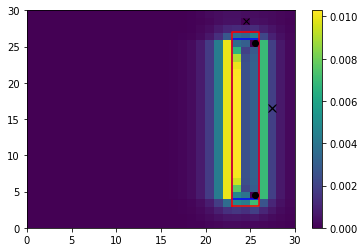

Creating TL
Done in: 0.014511823654174805  sec
Memory:  [4139.50390625]
Iteration: 0  Time: 0.04479074478149414  Distance: 0.998507996334  marginal-improvement: 0.00149200366614
Iteration: 1  Time: 0.03511238098144531  Distance: 1.34572293569  marginal-improvement: -0.347733759395
Iteration: 2  Time: 0.03384256362915039  Distance: 0.774188897506  marginal-improvement: 0.424704092517
Iteration: 3  Time: 0.033870697021484375  Distance: 0.497398760377  marginal-improvement: 0.35752274157
Iteration: 4  Time: 0.03421759605407715  Distance: 0.344806522934  marginal-improvement: 0.306780494039
Iteration: 5  Time: 0.033608198165893555  Distance: 0.254354719681  marginal-improvement: 0.262326253236
Iteration: 6  Time: 0.03336620330810547  Distance: 0.196323434495  marginal-improvement: 0.228151006039
Iteration: 7  Time: 0.03389406204223633  Distance: 0.156448381355  marginal-improvement: 0.203108983105
Iteration: 8  Time: 0.033603668212890625  Distance: 0.12751663177  marginal-improvement: 0.18

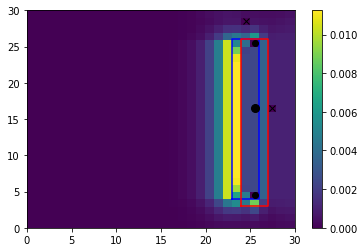

Creating TL
Done in: 0.013666152954101562  sec
Memory:  [4139.72265625]
Iteration: 0  Time: 0.03268861770629883  Distance: 0.998506952341  marginal-improvement: 0.00149304765897
Iteration: 1  Time: 0.03294563293457031  Distance: 1.34119942342  marginal-improvement: -0.343204892344
Iteration: 2  Time: 0.03306984901428223  Distance: 0.772790228223  marginal-improvement: 0.423806620606
Iteration: 3  Time: 0.03296661376953125  Distance: 0.496862428399  marginal-improvement: 0.357053945232
Iteration: 4  Time: 0.0328216552734375  Distance: 0.344370954908  marginal-improvement: 0.306908843928
Iteration: 5  Time: 0.03314471244812012  Distance: 0.253866691353  marginal-improvement: 0.262810385909
Iteration: 6  Time: 0.032958269119262695  Distance: 0.195786868965  marginal-improvement: 0.22878079073
Iteration: 7  Time: 0.03261375427246094  Distance: 0.155891204315  marginal-improvement: 0.203770890565
Iteration: 8  Time: 0.03322744369506836  Distance: 0.126961375168  marginal-improvement: 0.1855

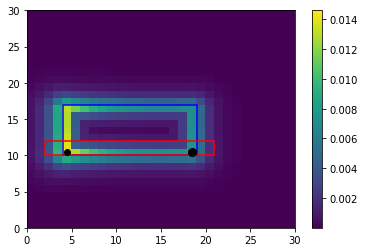

Creating TL
Done in: 1.866994857788086  sec
Memory:  [7450.3984375]
Iteration: 0  Time: 5.620524883270264  Distance: 0.998666837149  marginal-improvement: 0.00133316285051
Iteration: 1  Time: 3.7155895233154297  Distance: 3.46199181853  marginal-improvement: -2.4666133787
Iteration: 2  Time: 3.71305513381958  Distance: 1.05947107059  marginal-improvement: 0.693970660207
Iteration: 3  Time: 3.7268874645233154  Distance: 0.490076697228  marginal-improvement: 0.537432676709
Iteration: 4  Time: 3.7001073360443115  Distance: 0.265016391307  marginal-improvement: 0.459234865062
Iteration: 5  Time: 3.7475903034210205  Distance: 0.154329268152  marginal-improvement: 0.417661423164
Iteration: 6  Time: 3.7193031311035156  Distance: 0.0976963479138  marginal-improvement: 0.366961632852
Iteration: 7  Time: 3.6888060569763184  Distance: 0.0640876744554  marginal-improvement: 0.344011564159
Iteration: 8  Time: 3.757662057876587  Distance: 0.0418479308943  marginal-improvement: 0.347020604977
Iterati

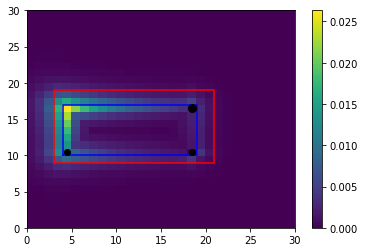

Creating TL
Done in: 1.2044665813446045  sec
Memory:  [5437.078125]
Iteration: 0  Time: 2.4923079013824463  Distance: 0.998276674455  marginal-improvement: 0.00172332554469
Iteration: 1  Time: 2.5015084743499756  Distance: 1.85003757898  marginal-improvement: -0.853231299815
Iteration: 2  Time: 2.521042823791504  Distance: 0.601626496688  marginal-improvement: 0.674803093988
Iteration: 3  Time: 2.493715763092041  Distance: 0.261329187619  marginal-improvement: 0.565628859338
Iteration: 4  Time: 2.5101351737976074  Distance: 0.128989917841  marginal-improvement: 0.506408300519
Iteration: 5  Time: 2.5112221240997314  Distance: 0.0678507653533  marginal-improvement: 0.473983963328
Iteration: 6  Time: 2.5001792907714844  Distance: 0.0379766434724  marginal-improvement: 0.440291597676
Iteration: 7  Time: 2.503782272338867  Distance: 0.0217502093117  marginal-improvement: 0.427274047335
Iteration: 8  Time: 2.5130629539489746  Distance: 0.0124440044598  marginal-improvement: 0.427867369849
It

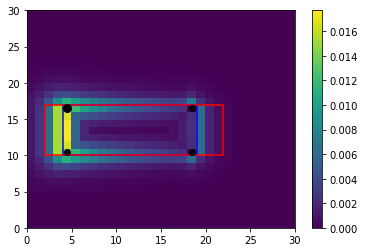

Creating TL
Done in: 0.26541805267333984  sec
Memory:  [4793.9296875]
Iteration: 0  Time: 0.5604605674743652  Distance: 0.997850913474  marginal-improvement: 0.00214908652599
Iteration: 1  Time: 0.5725982189178467  Distance: 0.577797515539  marginal-improvement: 0.420958073259
Iteration: 2  Time: 0.5725219249725342  Distance: 0.190312113183  marginal-improvement: 0.67062490221
Iteration: 3  Time: 0.5727119445800781  Distance: 0.0743552602631  marginal-improvement: 0.60929833094
Iteration: 4  Time: 0.5733475685119629  Distance: 0.0304050746881  marginal-improvement: 0.591083743362
Iteration: 5  Time: 0.5767185688018799  Distance: 0.0126379250496  marginal-improvement: 0.584348166243
Iteration: 6  Time: 0.577143669128418  Distance: 0.00529129789605  marginal-improvement: 0.581315930007
Total SK iteration time: 4.0094664096832275
Non-zeros in M: 8.286486  x 10^6
Memory after updating: [4433.09765625]
FALTAN: 1 Examples
Move:  1741
Selected sample: (12, 13)
Selected box: (4, 20, 10, 17)


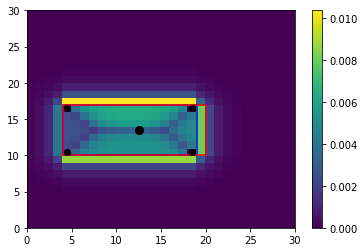

Creating TL
Done in: 0.22104382514953613  sec
Memory:  [4527.8828125]
Iteration: 0  Time: 0.557018518447876  Distance: 0.997850327538  marginal-improvement: 0.00214967246153
Iteration: 1  Time: 0.5523030757904053  Distance: 0.578583813558  marginal-improvement: 0.420169741302
Iteration: 2  Time: 0.5770549774169922  Distance: 0.190715481873  marginal-improvement: 0.67037535893
Iteration: 3  Time: 0.5738940238952637  Distance: 0.0745025893892  marginal-improvement: 0.609352168699
Iteration: 4  Time: 0.5756564140319824  Distance: 0.030457427758  marginal-improvement: 0.591189675315
Iteration: 5  Time: 0.5754036903381348  Distance: 0.0126584719803  marginal-improvement: 0.584388015925
Iteration: 6  Time: 0.574744462966919  Distance: 0.00529987888476  marginal-improvement: 0.581317642999
Total SK iteration time: 3.989964008331299
Non-zeros in M: 8.276352  x 10^6
Memory after updating: [4401.64453125]
###########################################
############### NEW TRIAL #################
###

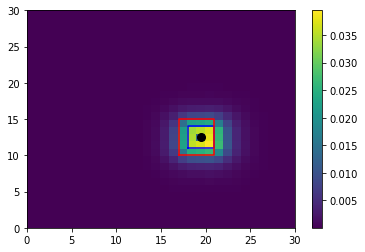

Creating TL
Done in: 2.0388448238372803  sec
Memory:  [7220.890625]
Iteration: 0  Time: 6.9971396923065186  Distance: 0.998647481143  marginal-improvement: 0.00135251885657
Iteration: 1  Time: 3.9269304275512695  Distance: 3.26991043  marginal-improvement: -2.27433903529
Iteration: 2  Time: 3.825645923614502  Distance: 0.992942265247  marginal-improvement: 0.696339613423
Iteration: 3  Time: 3.90285325050354  Distance: 0.45339137691  marginal-improvement: 0.543385962327
Iteration: 4  Time: 3.86639666557312  Distance: 0.241553855273  marginal-improvement: 0.467228827952
Iteration: 5  Time: 3.8764803409576416  Distance: 0.138465186302  marginal-improvement: 0.426773022744
Iteration: 6  Time: 3.823258876800537  Distance: 0.0871519581291  marginal-improvement: 0.370585773534
Iteration: 7  Time: 3.9147112369537354  Distance: 0.0559935112988  marginal-improvement: 0.357518608867
Iteration: 8  Time: 3.8260183334350586  Distance: 0.0358351674016  marginal-improvement: 0.360012141222
Iteration: 

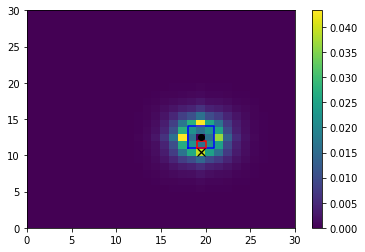

Creating TL
Done in: 0.2108917236328125  sec
Memory:  [4622.2890625]
Iteration: 0  Time: 0.47047901153564453  Distance: 2405.9349559  marginal-improvement: -2404.9349559
Iteration: 1  Time: 0.48209142684936523  Distance: 3.39059241968  marginal-improvement: 0.99859073812
Iteration: 2  Time: 0.46309447288513184  Distance: 1.07042041531  marginal-improvement: 0.684296936104
Iteration: 3  Time: 0.4649794101715088  Distance: 0.516605349668  marginal-improvement: 0.517380888596
Iteration: 4  Time: 0.4619932174682617  Distance: 0.291262911052  marginal-improvement: 0.436198422569
Iteration: 5  Time: 0.4630391597747803  Distance: 0.176625212627  marginal-improvement: 0.393588383809
Iteration: 6  Time: 0.4637603759765625  Distance: 0.119786799024  marginal-improvement: 0.321802378937
Iteration: 7  Time: 0.46329236030578613  Distance: 0.0825826630179  marginal-improvement: 0.310586277528
Iteration: 8  Time: 0.4640312194824219  Distance: 0.0567185687146  marginal-improvement: 0.313190364153
Iter

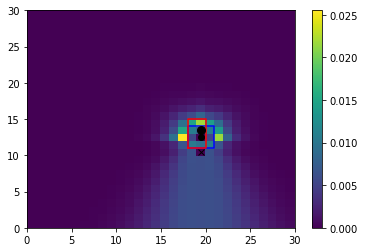

Creating TL
Done in: 0.17474007606506348  sec
Memory:  [4176.203125]
Iteration: 0  Time: 0.42885708808898926  Distance: 1883.91573914  marginal-improvement: -1882.91573914
Iteration: 1  Time: 0.4436991214752197  Distance: 3.09445898939  marginal-improvement: 0.998357432381
Iteration: 2  Time: 0.428239107131958  Distance: 0.972676311343  marginal-improvement: 0.685671610231
Iteration: 3  Time: 0.42840576171875  Distance: 0.458798261149  marginal-improvement: 0.52831352445
Iteration: 4  Time: 0.4259297847747803  Distance: 0.251735522866  marginal-improvement: 0.451315438216
Iteration: 5  Time: 0.4297759532928467  Distance: 0.148160773312  marginal-improvement: 0.411442725183
Iteration: 6  Time: 0.42798662185668945  Distance: 0.0985973706295  marginal-improvement: 0.334524459983
Iteration: 7  Time: 0.4273507595062256  Distance: 0.0653931773992  marginal-improvement: 0.336765504175
Iteration: 8  Time: 0.4286832809448242  Distance: 0.0431322962983  marginal-improvement: 0.340415957538
Itera

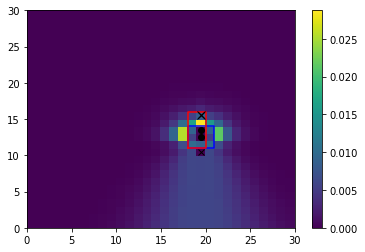

Creating TL
Done in: 0.02289438247680664  sec
Memory:  [3993.75]
Iteration: 0  Time: 0.04301190376281738  Distance: 83155.6083226  marginal-improvement: -83154.6083226
Iteration: 1  Time: 0.04176902770996094  Distance: 1.32741244703  marginal-improvement: 0.999984037006
Iteration: 2  Time: 0.04103493690490723  Distance: 0.314284586959  marginal-improvement: 0.763235166536
Iteration: 3  Time: 0.040569305419921875  Distance: 0.115310009772  marginal-improvement: 0.633103198322
Iteration: 4  Time: 0.0412445068359375  Distance: 0.0483159823277  marginal-improvement: 0.580990562543
Iteration: 5  Time: 0.04239964485168457  Distance: 0.0212108271483  marginal-improvement: 0.560997704559
Iteration: 6  Time: 0.04045581817626953  Distance: 0.00948602393637  marginal-improvement: 0.552774445333
Total SK iteration time: 0.29410266876220703
Non-zeros in M: 0.787584  x 10^6
Memory after updating: [3959.84765625]
FALTAN: 1 Examples
Move:  1746
Selected sample: (20, 13)
Selected box: (19, 21, 11, 15)


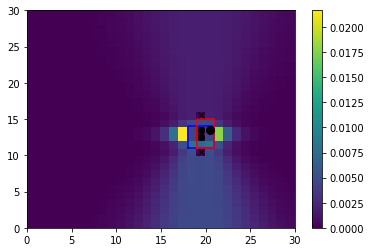

Creating TL
Done in: 0.014577150344848633  sec
Memory:  [3962.1015625]
Iteration: 0  Time: 0.053655385971069336  Distance: 76669.9641629  marginal-improvement: -76668.9641629
Iteration: 1  Time: 0.046625614166259766  Distance: 1.26686392278  marginal-improvement: 0.999983476399
Iteration: 2  Time: 0.035460710525512695  Distance: 0.308910479172  marginal-improvement: 0.756161278558
Iteration: 3  Time: 0.03494906425476074  Distance: 0.115162472161  marginal-improvement: 0.627197910315
Iteration: 4  Time: 0.034898996353149414  Distance: 0.048610489243  marginal-improvement: 0.577896442037
Iteration: 5  Time: 0.034699201583862305  Distance: 0.0214066816162  marginal-improvement: 0.559628344632
Iteration: 6  Time: 0.03474783897399902  Distance: 0.00958535799817  marginal-improvement: 0.552225881151
Total SK iteration time: 0.2788565158843994
Non-zeros in M: 0.715105  x 10^6
Memory after updating: [3962.1015625]
49
###########################################
############### NEW TRIAL #######

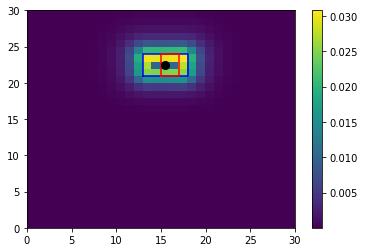

Creating TL
Done in: 1.5840568542480469  sec
Memory:  [7319.41796875]
Iteration: 0  Time: 3.8114678859710693  Distance: 0.998775928554  marginal-improvement: 0.00122407144646
Iteration: 1  Time: 3.2268826961517334  Distance: 3.62036923878  marginal-improvement: -2.62480626062
Iteration: 2  Time: 3.2272427082061768  Distance: 1.13819100078  marginal-improvement: 0.685614663668
Iteration: 3  Time: 3.2296252250671387  Distance: 0.550963421731  marginal-improvement: 0.51593061151
Iteration: 4  Time: 3.257516860961914  Distance: 0.31576836471  marginal-improvement: 0.426879621667
Iteration: 5  Time: 3.2387282848358154  Distance: 0.197120502559  marginal-improvement: 0.375743346743
Iteration: 6  Time: 3.22251558303833  Distance: 0.129355169336  marginal-improvement: 0.343776179257
Iteration: 7  Time: 3.2570300102233887  Distance: 0.0913206293927  marginal-improvement: 0.294031851518
Iteration: 8  Time: 3.2281527519226074  Distance: 0.0654635755536  marginal-improvement: 0.283145812847
Iterat

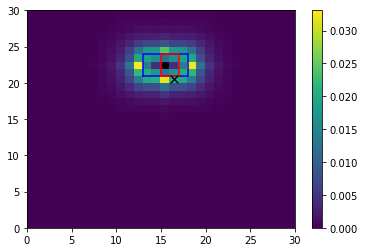

Creating TL
Done in: 0.1819148063659668  sec
Memory:  [4806.9140625]
Iteration: 0  Time: 0.3690643310546875  Distance: 144184.797862  marginal-improvement: -144183.797862
Iteration: 1  Time: 0.3735795021057129  Distance: 9.65527008198  marginal-improvement: 0.99993303545
Iteration: 2  Time: 0.3742403984069824  Distance: 3.65950683278  marginal-improvement: 0.620983483455
Iteration: 3  Time: 0.37120580673217773  Distance: 2.27193991592  marginal-improvement: 0.37916773496
Iteration: 4  Time: 0.37013792991638184  Distance: 1.69305368077  marginal-improvement: 0.254798214996
Iteration: 5  Time: 0.37203335762023926  Distance: 1.39536402773  marginal-improvement: 0.175830014382
Iteration: 6  Time: 0.3731262683868408  Distance: 1.19775929048  marginal-improvement: 0.141615186661
Iteration: 7  Time: 0.37515711784362793  Distance: 1.04813841588  marginal-improvement: 0.124917315014
Iteration: 8  Time: 0.3717789649963379  Distance: 0.923328201414  marginal-improvement: 0.119077988724
Iteration:

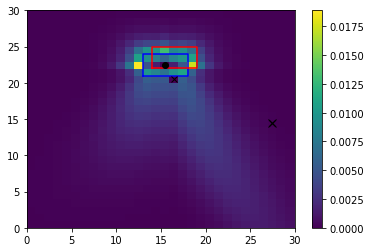

Creating TL
Done in: 0.16671133041381836  sec
Memory:  [4419.47265625]
Iteration: 0  Time: 0.37563633918762207  Distance: 144156.261362  marginal-improvement: -144155.261362
Iteration: 1  Time: 0.37031126022338867  Distance: 9.65848812255  marginal-improvement: 0.999932999871
Iteration: 2  Time: 0.3928043842315674  Distance: 3.66251759901  marginal-improvement: 0.620798042867
Iteration: 3  Time: 0.3830852508544922  Distance: 2.27455831423  marginal-improvement: 0.378963171441
Iteration: 4  Time: 0.3843367099761963  Distance: 1.69573846516  marginal-improvement: 0.254475713129
Iteration: 5  Time: 0.3839395046234131  Distance: 1.39750111304  marginal-improvement: 0.17587461643
Iteration: 6  Time: 0.383695125579834  Distance: 1.19958999021  marginal-improvement: 0.141617864189
Iteration: 7  Time: 0.3843357563018799  Distance: 1.04965763023  marginal-improvement: 0.124986337997
Iteration: 8  Time: 0.38408446311950684  Distance: 0.924599346312  marginal-improvement: 0.119141975743
Iteration

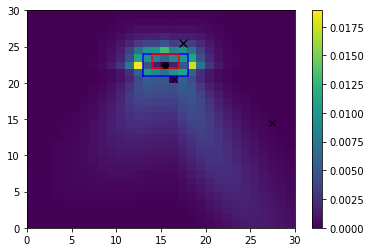

Creating TL
Done in: 0.10997962951660156  sec
Memory:  [4413.9296875]
Iteration: 0  Time: 0.24729466438293457  Distance: 102168.665745  marginal-improvement: -102167.665745
Iteration: 1  Time: 0.22454118728637695  Distance: 7.04928421578  marginal-improvement: 0.999931003462
Iteration: 2  Time: 0.2267603874206543  Distance: 2.39309693287  marginal-improvement: 0.660519159164
Iteration: 3  Time: 0.2240912914276123  Distance: 1.3238150259  marginal-improvement: 0.446819304426
Iteration: 4  Time: 0.22546982765197754  Distance: 0.901719466634  marginal-improvement: 0.318847838262
Iteration: 5  Time: 0.2234325408935547  Distance: 0.700807016886  marginal-improvement: 0.222810371943
Iteration: 6  Time: 0.2240464687347412  Distance: 0.576604527092  marginal-improvement: 0.177227805659
Iteration: 7  Time: 0.22381329536437988  Distance: 0.479874745974  marginal-improvement: 0.167757581797
Iteration: 8  Time: 0.22449588775634766  Distance: 0.403234201013  marginal-improvement: 0.159709477534
Ite

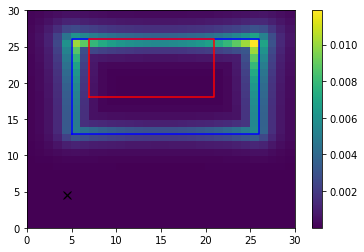

Creating TL
Done in: 8.679617881774902  sec
Memory:  [9502.02734375]
Iteration: 0  Time: 18.428219079971313  Distance: 2.75669577032  marginal-improvement: -1.75669577032
Iteration: 1  Time: 16.280821800231934  Distance: 1.86757248906  marginal-improvement: 0.322532247061
Iteration: 2  Time: 16.323259115219116  Distance: 0.904967627749  marginal-improvement: 0.515431056598
Iteration: 3  Time: 16.305389165878296  Distance: 0.509791943018  marginal-improvement: 0.436673835189
Iteration: 4  Time: 16.285770654678345  Distance: 0.415006295719  marginal-improvement: 0.185930061463
Iteration: 5  Time: 16.25222945213318  Distance: 0.356789899565  marginal-improvement: 0.140278344582
Iteration: 6  Time: 16.18957495689392  Distance: 0.309559625169  marginal-improvement: 0.13237559262
Iteration: 7  Time: 16.150648832321167  Distance: 0.270639920465  marginal-improvement: 0.125726036407
Iteration: 8  Time: 16.22884178161621  Distance: 0.23822411834  marginal-improvement: 0.119774651387
Iteration: 

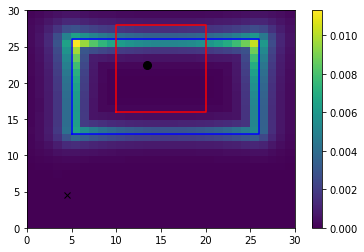

Creating TL
Done in: 1.388556957244873  sec
Memory:  [6068.1953125]
Iteration: 0  Time: 2.8804004192352295  Distance: 27.6696391335  marginal-improvement: -26.6696391335
Iteration: 1  Time: 2.930130958557129  Distance: 4.62906791707  marginal-improvement: 0.832702266382
Iteration: 2  Time: 2.9486939907073975  Distance: 1.4986319452  marginal-improvement: 0.676256220033
Iteration: 3  Time: 2.9141933917999268  Distance: 0.765100126332  marginal-improvement: 0.489467624933
Iteration: 4  Time: 2.9493117332458496  Distance: 0.466952804  marginal-improvement: 0.389684058426
Iteration: 5  Time: 2.8881149291992188  Distance: 0.312239628263  marginal-improvement: 0.331325081276
Iteration: 6  Time: 2.900273084640503  Distance: 0.220447065883  marginal-improvement: 0.293981141634
Iteration: 7  Time: 2.8770477771759033  Distance: 0.173486398022  marginal-improvement: 0.213024689954
Iteration: 8  Time: 2.9473094940185547  Distance: 0.137947947784  marginal-improvement: 0.204848625845
Iteration: 9  

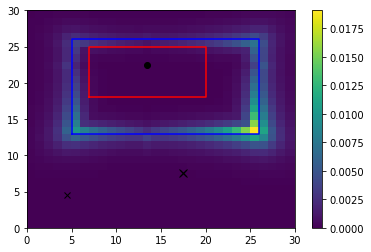

Creating TL
Done in: 1.148705005645752  sec
Memory:  [4246.75390625]
Iteration: 0  Time: 2.2121243476867676  Distance: 989.960461583  marginal-improvement: -988.960461583
Iteration: 1  Time: 2.2387187480926514  Distance: 7.52130315094  marginal-improvement: 0.992402420659
Iteration: 2  Time: 2.212958574295044  Distance: 2.54193829036  marginal-improvement: 0.662034857611
Iteration: 3  Time: 2.2115821838378906  Distance: 1.40475256399  marginal-improvement: 0.447369525328
Iteration: 4  Time: 2.207228660583496  Distance: 0.945067392258  marginal-improvement: 0.327235687988
Iteration: 5  Time: 2.2259724140167236  Distance: 0.702567703831  marginal-improvement: 0.256595127938
Iteration: 6  Time: 2.217639684677124  Distance: 0.554586045616  marginal-improvement: 0.210629747721
Iteration: 7  Time: 2.210683822631836  Distance: 0.451818341303  marginal-improvement: 0.185305247265
Iteration: 8  Time: 2.201019525527954  Distance: 0.375272108894  marginal-improvement: 0.169418160823
Iteration: 9 

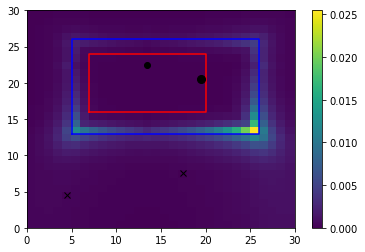

Creating TL
Done in: 0.5045089721679688  sec
Memory:  [3839.37890625]
Iteration: 0  Time: 1.0705139636993408  Distance: 176.781654872  marginal-improvement: -175.781654872
Iteration: 1  Time: 1.0764117240905762  Distance: 2.62334963366  marginal-improvement: 0.985160509808
Iteration: 2  Time: 1.0777404308319092  Distance: 0.880853746884  marginal-improvement: 0.664225562776
Iteration: 3  Time: 1.079939842224121  Distance: 0.432915269007  marginal-improvement: 0.508527640896
Iteration: 4  Time: 1.0786478519439697  Distance: 0.252172670803  marginal-improvement: 0.417501093501
Iteration: 5  Time: 1.079892873764038  Distance: 0.160464457392  marginal-improvement: 0.363672292954
Iteration: 6  Time: 1.080895185470581  Distance: 0.11373408807  marginal-improvement: 0.291219439378
Iteration: 7  Time: 1.0818359851837158  Distance: 0.0814803653154  marginal-improvement: 0.28358888089
Iteration: 8  Time: 1.0829744338989258  Distance: 0.0585717535672  marginal-improvement: 0.281154995557
Iteratio

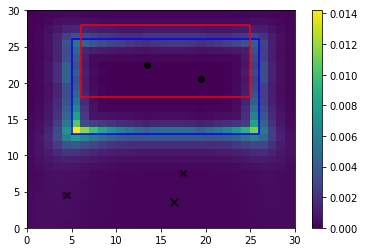

Creating TL
Done in: 0.4864804744720459  sec
Memory:  [3706.515625]
Iteration: 0  Time: 1.0521280765533447  Distance: 176.77804316  marginal-improvement: -175.77804316
Iteration: 1  Time: 1.0676851272583008  Distance: 2.61962846355  marginal-improvement: 0.985181256582
Iteration: 2  Time: 1.0588486194610596  Distance: 0.879420671856  marginal-improvement: 0.664295649519
Iteration: 3  Time: 1.060037612915039  Distance: 0.431964613228  marginal-improvement: 0.508807756001
Iteration: 4  Time: 1.0592095851898193  Distance: 0.25145692772  marginal-improvement: 0.417876094432
Iteration: 5  Time: 1.057358741760254  Distance: 0.159899887654  marginal-improvement: 0.364106254286
Iteration: 6  Time: 1.0615859031677246  Distance: 0.113296720596  marginal-improvement: 0.291452156355
Iteration: 7  Time: 1.0617880821228027  Distance: 0.081116547597  marginal-improvement: 0.284034461277
Iteration: 8  Time: 1.0657951831817627  Distance: 0.058275048434  marginal-improvement: 0.281588650401
Iteration: 9

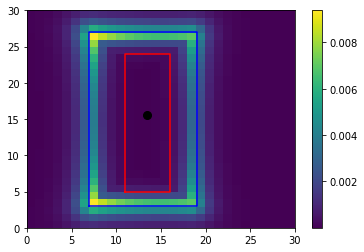

Creating TL
Done in: 2.242501735687256  sec
Memory:  [7590.12890625]
Iteration: 0  Time: 4.400724411010742  Distance: 0.998540546477  marginal-improvement: 0.00145945352291
Iteration: 1  Time: 4.373544454574585  Distance: 2.43239759708  marginal-improvement: -1.43595275692
Iteration: 2  Time: 4.295405626296997  Distance: 0.703812331295  marginal-improvement: 0.71065078664
Iteration: 3  Time: 4.375476360321045  Distance: 0.296032902236  marginal-improvement: 0.579386593452
Iteration: 4  Time: 4.303241491317749  Distance: 0.14275308907  marginal-improvement: 0.517779652222
Iteration: 5  Time: 4.372189521789551  Distance: 0.0753832162428  marginal-improvement: 0.471932854596
Iteration: 6  Time: 4.298376083374023  Distance: 0.0421604149406  marginal-improvement: 0.440718809279
Iteration: 7  Time: 4.292139291763306  Distance: 0.0234159363652  marginal-improvement: 0.444599006006
Iteration: 8  Time: 4.304182291030884  Distance: 0.0129369505233  marginal-improvement: 0.447515131512
Iteration:

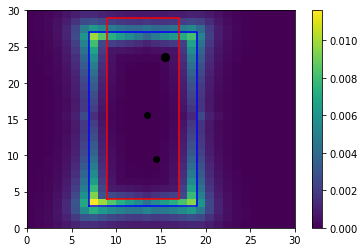

Creating TL
Done in: 0.7513222694396973  sec
Memory:  [5272.85546875]
Iteration: 0  Time: 1.6236772537231445  Distance: 0.998160320238  marginal-improvement: 0.00183967976212
Iteration: 1  Time: 1.6020598411560059  Distance: 1.29607435898  marginal-improvement: -0.298463115297
Iteration: 2  Time: 1.6113917827606201  Distance: 0.437165324168  marginal-improvement: 0.662700429849
Iteration: 3  Time: 1.606482744216919  Distance: 0.183466310839  marginal-improvement: 0.580327394018
Iteration: 4  Time: 1.6083407402038574  Distance: 0.0845194765471  marginal-improvement: 0.539318820111
Iteration: 5  Time: 1.6097626686096191  Distance: 0.0412698757385  marginal-improvement: 0.511711650089
Iteration: 6  Time: 1.60313081741333  Distance: 0.0210548465521  marginal-improvement: 0.489825298105
Iteration: 7  Time: 1.6103887557983398  Distance: 0.010689563931  marginal-improvement: 0.492299129108
Iteration: 8  Time: 1.6195461750030518  Distance: 0.00541059481044  marginal-improvement: 0.493843261955

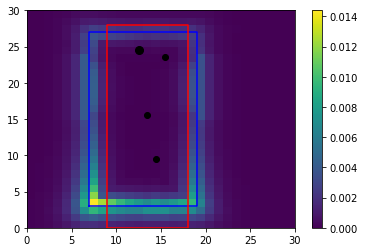

Creating TL
Done in: 0.5848250389099121  sec
Memory:  [4827.828125]
Iteration: 0  Time: 1.2426791191101074  Distance: 0.998166266409  marginal-improvement: 0.00183373359133
Iteration: 1  Time: 1.250699520111084  Distance: 1.18173894218  marginal-improvement: -0.183909917568
Iteration: 2  Time: 1.2545671463012695  Distance: 0.413736510812  marginal-improvement: 0.649891785704
Iteration: 3  Time: 1.256575345993042  Distance: 0.176076315452  marginal-improvement: 0.574424033532
Iteration: 4  Time: 1.2526960372924805  Distance: 0.0815732267747  marginal-improvement: 0.536716641501
Iteration: 5  Time: 1.2701756954193115  Distance: 0.0393436721246  marginal-improvement: 0.517688907498
Iteration: 6  Time: 1.25565505027771  Distance: 0.0198577328407  marginal-improvement: 0.495275052675
Iteration: 7  Time: 1.2589819431304932  Distance: 0.0101082281408  marginal-improvement: 0.490967663737
Iteration: 8  Time: 1.2523846626281738  Distance: 0.00512787863628  marginal-improvement: 0.492702522651
T

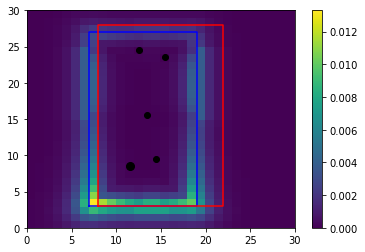

Creating TL
Done in: 0.304034948348999  sec
Memory:  [4593.328125]
Iteration: 0  Time: 0.6674995422363281  Distance: 0.997442423587  marginal-improvement: 0.00255757641306
Iteration: 1  Time: 0.6241707801818848  Distance: 0.458136833549  marginal-improvement: 0.540688442044
Iteration: 2  Time: 0.6291441917419434  Distance: 0.152983235087  marginal-improvement: 0.666075233676
Iteration: 3  Time: 0.6317398548126221  Distance: 0.0611976765832  marginal-improvement: 0.599971352755
Iteration: 4  Time: 0.6296913623809814  Distance: 0.025703187676  marginal-improvement: 0.579997328149
Iteration: 5  Time: 0.6294584274291992  Distance: 0.0110115744829  marginal-improvement: 0.571587204601
Iteration: 6  Time: 0.6275641918182373  Distance: 0.00476223815724  marginal-improvement: 0.567524320467
Total SK iteration time: 4.443011045455933
Non-zeros in M: 8.706432  x 10^6
Memory after updating: [4401.17578125]
50
###########################################
############### NEW TRIAL #################


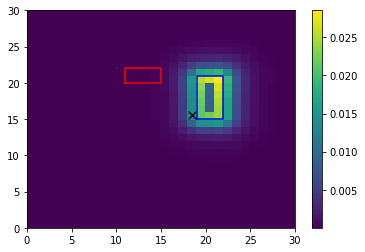

Creating TL
Done in: 6.698313236236572  sec
Memory:  [9294.66796875]
Iteration: 0  Time: 12.934043884277344  Distance: 0.996460384508  marginal-improvement: 0.00353961549237
Iteration: 1  Time: 12.857742309570312  Distance: 0.873189450797  marginal-improvement: 0.12370881535
Iteration: 2  Time: 12.819055795669556  Distance: 0.394230993854  marginal-improvement: 0.548516082628
Iteration: 3  Time: 12.949780702590942  Distance: 0.220567359988  marginal-improvement: 0.44051238125
Iteration: 4  Time: 12.746074914932251  Distance: 0.138892392995  marginal-improvement: 0.370294893122
Iteration: 5  Time: 12.780023574829102  Distance: 0.0950258660511  marginal-improvement: 0.315831025719
Iteration: 6  Time: 12.805145502090454  Distance: 0.0674201130718  marginal-improvement: 0.290507775687
Iteration: 7  Time: 12.86698293685913  Distance: 0.0495179113285  marginal-improvement: 0.26553206347
Iteration: 8  Time: 12.777957677841187  Distance: 0.0372966754734  marginal-improvement: 0.246804348713
It

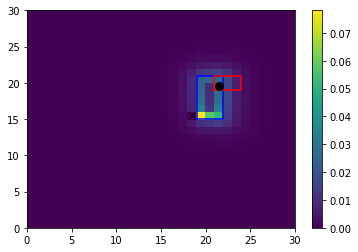

Creating TL
Done in: 0.4099619388580322  sec
Memory:  [5684.76953125]
Iteration: 0  Time: 0.8890161514282227  Distance: 1567430.7862  marginal-improvement: -1567429.7862
Iteration: 1  Time: 0.896636962890625  Distance: 4.05498298624  marginal-improvement: 0.999997412975
Iteration: 2  Time: 0.8879573345184326  Distance: 1.33656996279  marginal-improvement: 0.670388268626
Iteration: 3  Time: 0.8900833129882812  Distance: 0.669946082232  marginal-improvement: 0.498757191255
Iteration: 4  Time: 0.885638952255249  Distance: 0.396236306317  marginal-improvement: 0.40855493177
Iteration: 5  Time: 0.8913135528564453  Distance: 0.256488027921  marginal-improvement: 0.352689231571
Iteration: 6  Time: 0.8879885673522949  Distance: 0.179866819037  marginal-improvement: 0.298732106543
Iteration: 7  Time: 0.8920490741729736  Distance: 0.134644101281  marginal-improvement: 0.251423347553
Iteration: 8  Time: 0.88991379737854  Distance: 0.101142387344  marginal-improvement: 0.24881679642
Iteration: 9  

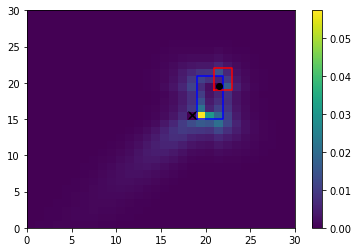

Repeated sample: Skipping the Actualization of M and TL
Non-zeros in M: 12.089774  x 10^6
Memory after updating: [4023.234375]
FALTAN: 2 Examples
Move:  1750
Selected sample: (20, 16)
Selected box: (20, 23, 16, 21)


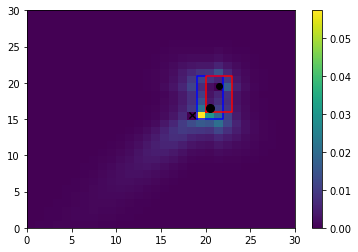

Creating TL
Done in: 0.14334654808044434  sec
Memory:  [4009.75]
Iteration: 0  Time: 0.2907741069793701  Distance: 471887.939992  marginal-improvement: -471886.939992
Iteration: 1  Time: 0.2916593551635742  Distance: 5.42466985172  marginal-improvement: 0.999988504326
Iteration: 2  Time: 0.29150843620300293  Distance: 2.274704075  marginal-improvement: 0.58067419084
Iteration: 3  Time: 0.2941164970397949  Distance: 1.41503868432  marginal-improvement: 0.377924056201
Iteration: 4  Time: 0.2978019714355469  Distance: 1.04135776368  marginal-improvement: 0.264078236713
Iteration: 5  Time: 0.291654109954834  Distance: 0.836919885204  marginal-improvement: 0.196318580999
Iteration: 6  Time: 0.2931694984436035  Distance: 0.715942794637  marginal-improvement: 0.144550383741
Iteration: 7  Time: 0.2982800006866455  Distance: 0.628753488448  marginal-improvement: 0.121782503912
Iteration: 8  Time: 0.29437923431396484  Distance: 0.55912661808  marginal-improvement: 0.110737946823
Iteration: 9  Ti

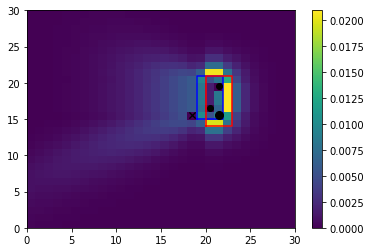

Creating TL
Done in: 0.06366395950317383  sec
Memory:  [3886.2265625]
Iteration: 0  Time: 0.16017889976501465  Distance: 2123395.71302  marginal-improvement: -2123394.71302
Iteration: 1  Time: 0.15217804908752441  Distance: 0.944678863313  marginal-improvement: 0.999999555109
Iteration: 2  Time: 0.15418553352355957  Distance: 0.239086502468  marginal-improvement: 0.746912404043
Iteration: 3  Time: 0.151777982711792  Distance: 0.0804042619095  marginal-improvement: 0.663702212046
Iteration: 4  Time: 0.1527254581451416  Distance: 0.0326201371124  marginal-improvement: 0.594298407351
Iteration: 5  Time: 0.15148353576660156  Distance: 0.0136031921035  marginal-improvement: 0.582981761954
Iteration: 6  Time: 0.15288066864013672  Distance: 0.00555345702926  marginal-improvement: 0.591753392363
Total SK iteration time: 1.0791447162628174
Non-zeros in M: 2.837632  x 10^6
Memory after updating: [3883.03125]
###########################################
############### NEW TRIAL #################


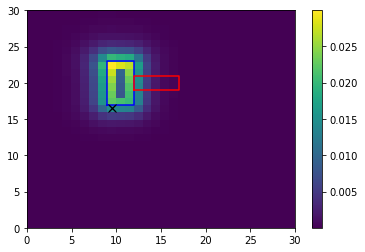

Creating TL
Done in: 6.810647964477539  sec
Memory:  [9602.953125]
Iteration: 0  Time: 13.370286703109741  Distance: 0.996554643373  marginal-improvement: 0.00344535662734
Iteration: 1  Time: 13.38632845878601  Distance: 1.0897782055  marginal-improvement: -0.0935458609797
Iteration: 2  Time: 13.281349658966064  Distance: 0.517021593877  marginal-improvement: 0.525571725267
Iteration: 3  Time: 13.428616046905518  Distance: 0.304188109401  marginal-improvement: 0.411652988959
Iteration: 4  Time: 13.281870365142822  Distance: 0.198487623582  marginal-improvement: 0.34748395007
Iteration: 5  Time: 13.374723434448242  Distance: 0.138220769457  marginal-improvement: 0.303630287057
Iteration: 6  Time: 13.35239028930664  Distance: 0.102627375838  marginal-improvement: 0.25751118127
Iteration: 7  Time: 13.353492736816406  Distance: 0.0785644563791  marginal-improvement: 0.234468817528
Iteration: 8  Time: 13.305312871932983  Distance: 0.0609188645634  marginal-improvement: 0.224600189818
Iterat

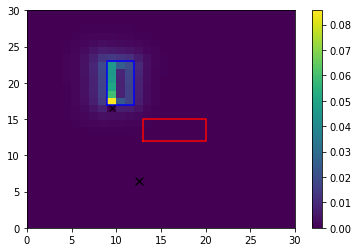

Creating TL
Done in: 5.751155376434326  sec
Memory:  [8824.35546875]
Iteration: 0  Time: 11.137354135513306  Distance: 0.996762715923  marginal-improvement: 0.00323728407683
Iteration: 1  Time: 11.321057558059692  Distance: 1.35784200412  marginal-improvement: -0.362252000832
Iteration: 2  Time: 11.297304391860962  Distance: 0.723553401057  marginal-improvement: 0.467129902551
Iteration: 3  Time: 11.343332290649414  Distance: 0.472711863033  marginal-improvement: 0.346680062118
Iteration: 4  Time: 11.359038352966309  Distance: 0.338437208135  marginal-improvement: 0.284051798566
Iteration: 5  Time: 11.329328060150146  Distance: 0.256633964977  marginal-improvement: 0.241708775487
Iteration: 6  Time: 11.382484436035156  Distance: 0.201860070089  marginal-improvement: 0.213431978474
Iteration: 7  Time: 11.354135513305664  Distance: 0.162394334018  marginal-improvement: 0.195510365437
Iteration: 8  Time: 11.384730815887451  Distance: 0.132360987449  marginal-improvement: 0.184940852468
It

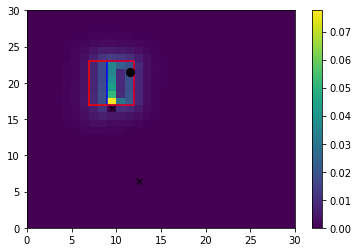

Creating TL
Done in: 0.4210939407348633  sec
Memory:  [5915.375]
Iteration: 0  Time: 0.9495832920074463  Distance: 29216.3891382  marginal-improvement: -29215.3891382
Iteration: 1  Time: 0.9199583530426025  Distance: 16.4251942834  marginal-improvement: 0.999437808889
Iteration: 2  Time: 0.9110019207000732  Distance: 5.78238472382  marginal-improvement: 0.647956387971
Iteration: 3  Time: 0.9121015071868896  Distance: 3.24402674187  marginal-improvement: 0.438981164898
Iteration: 4  Time: 0.9126546382904053  Distance: 2.1195671448  marginal-improvement: 0.346624638617
Iteration: 5  Time: 0.9153437614440918  Distance: 1.48300227421  marginal-improvement: 0.300327768408
Iteration: 6  Time: 0.9164266586303711  Distance: 1.0709936018  marginal-improvement: 0.27782066122
Iteration: 7  Time: 0.9164102077484131  Distance: 0.772748728118  marginal-improvement: 0.278474935033
Iteration: 8  Time: 0.91365647315979  Distance: 0.553306965651  marginal-improvement: 0.283975572501
Iteration: 9  Time: 

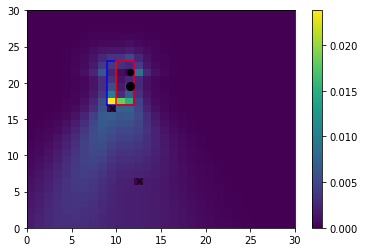

Creating TL
Done in: 0.2955613136291504  sec
Memory:  [4496.39453125]
Iteration: 0  Time: 0.6275877952575684  Distance: 12905.3436319  marginal-improvement: -12904.3436319
Iteration: 1  Time: 0.6323003768920898  Distance: 9.92133378883  marginal-improvement: 0.999231222812
Iteration: 2  Time: 0.6350111961364746  Distance: 3.46610415407  marginal-improvement: 0.650641312161
Iteration: 3  Time: 0.6368145942687988  Distance: 1.92541724524  marginal-improvement: 0.444501042191
Iteration: 4  Time: 0.6387863159179688  Distance: 1.25391151489  marginal-improvement: 0.348758551949
Iteration: 5  Time: 0.6306147575378418  Distance: 0.891907687489  marginal-improvement: 0.28869965951
Iteration: 6  Time: 0.6342957019805908  Distance: 0.669512455413  marginal-improvement: 0.2493478139
Iteration: 7  Time: 0.6351361274719238  Distance: 0.515152237493  marginal-improvement: 0.23055615571
Iteration: 8  Time: 0.6367049217224121  Distance: 0.401018070084  marginal-improvement: 0.221554249603
Iteration: 9

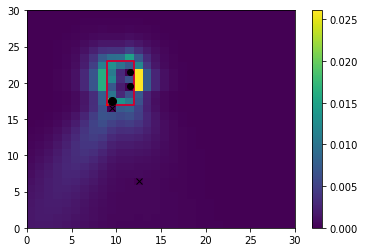

Creating TL
Done in: 0.03307485580444336  sec
Memory:  [4296.3984375]
Iteration: 0  Time: 0.08275914192199707  Distance: 168643.265652  marginal-improvement: -168642.265652
Iteration: 1  Time: 0.07765889167785645  Distance: 1.23726801251  marginal-improvement: 0.999992663401
Iteration: 2  Time: 0.07775235176086426  Distance: 0.373036862644  marginal-improvement: 0.698499549919
Iteration: 3  Time: 0.07956361770629883  Distance: 0.148918448698  marginal-improvement: 0.600794281716
Iteration: 4  Time: 0.07687759399414062  Distance: 0.0663424406077  marginal-improvement: 0.554504890511
Iteration: 5  Time: 0.07735085487365723  Distance: 0.0309766493777  marginal-improvement: 0.53307944215
Iteration: 6  Time: 0.08001518249511719  Distance: 0.0150362595627  marginal-improvement: 0.514593738676
Iteration: 7  Time: 0.07657003402709961  Distance: 0.0073475225607  marginal-improvement: 0.511346387042
Total SK iteration time: 0.632784366607666
Non-zeros in M: 1.52866  x 10^6
Memory after updating:

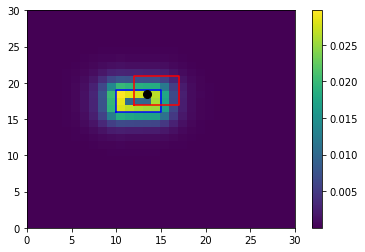

Creating TL
Done in: 2.105686664581299  sec
Memory:  [7210.8671875]
Iteration: 0  Time: 9.119605541229248  Distance: 0.99860032245  marginal-improvement: 0.00139967755018
Iteration: 1  Time: 4.119103908538818  Distance: 2.90513221474  marginal-improvement: -1.90920416249
Iteration: 2  Time: 4.076357364654541  Distance: 0.865693641526  marginal-improvement: 0.702012308723
Iteration: 3  Time: 4.077360153198242  Distance: 0.382790248318  marginal-improvement: 0.557822502146
Iteration: 4  Time: 4.121538162231445  Distance: 0.196215771844  marginal-improvement: 0.487406555662
Iteration: 5  Time: 4.122522592544556  Distance: 0.108091916813  marginal-improvement: 0.449117082703
Iteration: 6  Time: 4.109124422073364  Distance: 0.0660033754715  marginal-improvement: 0.38937732425
Iteration: 7  Time: 4.190816402435303  Distance: 0.0400902261025  marginal-improvement: 0.392603396173
Iteration: 8  Time: 4.111340045928955  Distance: 0.0242456308644  marginal-improvement: 0.39522339429
Iteration: 9 

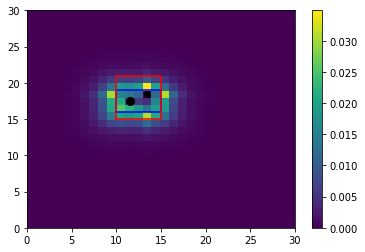

Creating TL
Done in: 1.5776596069335938  sec
Memory:  [5358.80078125]
Iteration: 0  Time: 3.1670475006103516  Distance: 0.998311490215  marginal-improvement: 0.00168850978486
Iteration: 1  Time: 3.2822654247283936  Distance: 2.29123251542  marginal-improvement: -1.29510782745
Iteration: 2  Time: 3.2149250507354736  Distance: 0.715982498253  marginal-improvement: 0.687512073335
Iteration: 3  Time: 3.2976956367492676  Distance: 0.31376658779  marginal-improvement: 0.561767796621
Iteration: 4  Time: 3.2210426330566406  Distance: 0.156976998468  marginal-improvement: 0.499701355796
Iteration: 5  Time: 3.263383150100708  Distance: 0.0839379996685  marginal-improvement: 0.465284720133
Iteration: 6  Time: 3.2079997062683105  Distance: 0.0490499800628  marginal-improvement: 0.415640350538
Iteration: 7  Time: 3.292205810546875  Distance: 0.0284501372873  marginal-improvement: 0.419976577954
Iteration: 8  Time: 3.219353199005127  Distance: 0.0163968885978  marginal-improvement: 0.423662232901
It

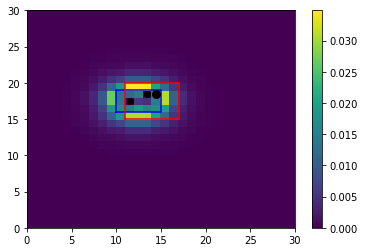

Creating TL
Done in: 1.4925978183746338  sec
Memory:  [5199.11328125]
Iteration: 0  Time: 3.0242621898651123  Distance: 0.998227921597  marginal-improvement: 0.00177207840291
Iteration: 1  Time: 3.0357749462127686  Distance: 2.06778872862  marginal-improvement: -1.0714595173
Iteration: 2  Time: 3.061596155166626  Distance: 0.649437187035  marginal-improvement: 0.685926720634
Iteration: 3  Time: 3.0463993549346924  Distance: 0.280851201532  marginal-improvement: 0.567546781832
Iteration: 4  Time: 3.0460848808288574  Distance: 0.137997789947  marginal-improvement: 0.508644473676
Iteration: 5  Time: 3.028595209121704  Distance: 0.0723195248392  marginal-improvement: 0.475937079377
Iteration: 6  Time: 3.0387251377105713  Distance: 0.0411989432126  marginal-improvement: 0.430320604233
Iteration: 7  Time: 3.024116039276123  Distance: 0.0233033705384  marginal-improvement: 0.434369701715
Iteration: 8  Time: 3.041966199874878  Distance: 0.0131054772164  marginal-improvement: 0.437614520405
Ite

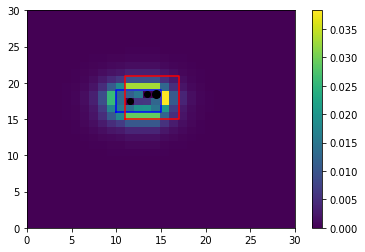

Repeated sample: Skipping the Actualization of M and TL
Non-zeros in M: 37.19859  x 10^6
Memory after updating: [4746.34375]
FALTAN: 1 Examples
Move:  1761
Selected sample: (11, 18)
Selected box: (10, 16, 16, 20)


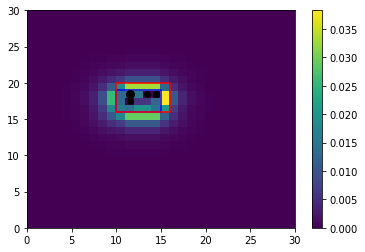

Creating TL
Done in: 1.4778704643249512  sec
Memory:  [5171.6640625]
Iteration: 0  Time: 2.953579902648926  Distance: 0.99812654667  marginal-improvement: 0.00187345332964
Iteration: 1  Time: 3.024355173110962  Distance: 2.07816296491  marginal-improvement: -1.08206361392
Iteration: 2  Time: 3.016392946243286  Distance: 0.651216060071  marginal-improvement: 0.686638598095
Iteration: 3  Time: 3.024914026260376  Distance: 0.281505977631  marginal-improvement: 0.567722611755
Iteration: 4  Time: 3.0115091800689697  Distance: 0.138328683232  marginal-improvement: 0.508611915112
Iteration: 5  Time: 3.014256000518799  Distance: 0.0724828374463  marginal-improvement: 0.476010067092
Iteration: 6  Time: 3.0072989463806152  Distance: 0.041303987766  marginal-improvement: 0.430154927412
Iteration: 7  Time: 3.0107479095458984  Distance: 0.0233716713573  marginal-improvement: 0.434154602948
Iteration: 8  Time: 3.0265767574310303  Distance: 0.0131489918072  marginal-improvement: 0.437396170508
Iterat

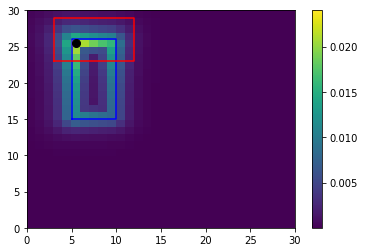

Creating TL
Done in: 0.621485710144043  sec
Memory:  [6977.51953125]
Iteration: 0  Time: 1.4647724628448486  Distance: 1.44657742571  marginal-improvement: -0.446577425705
Iteration: 1  Time: 1.3225691318511963  Distance: 7.70521870579  marginal-improvement: -4.32651662391
Iteration: 2  Time: 1.3221533298492432  Distance: 2.62162603197  marginal-improvement: 0.65975968599
Iteration: 3  Time: 1.3160617351531982  Distance: 1.41150817037  marginal-improvement: 0.461590572738
Iteration: 4  Time: 1.3266642093658447  Distance: 0.909019856431  marginal-improvement: 0.355993910971
Iteration: 5  Time: 1.3212454319000244  Distance: 0.639186237419  marginal-improvement: 0.296840181327
Iteration: 6  Time: 1.3174166679382324  Distance: 0.473005349448  marginal-improvement: 0.259988213516
Iteration: 7  Time: 1.3214349746704102  Distance: 0.361776025375  marginal-improvement: 0.235154473841
Iteration: 8  Time: 1.319521427154541  Distance: 0.28309265262  marginal-improvement: 0.217491948708
Iteration:

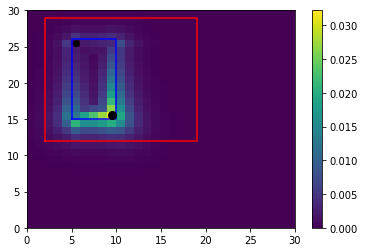

Creating TL
Done in: 0.3112623691558838  sec
Memory:  [4758.81640625]
Iteration: 0  Time: 0.6531467437744141  Distance: 0.998471057599  marginal-improvement: 0.00152894240103
Iteration: 1  Time: 0.6502280235290527  Distance: 1.64932990474  marginal-improvement: -0.651855496652
Iteration: 2  Time: 0.6485426425933838  Distance: 0.69075932044  marginal-improvement: 0.581187900338
Iteration: 3  Time: 0.6477608680725098  Distance: 0.352653740945  marginal-improvement: 0.489469442526
Iteration: 4  Time: 0.65016770362854  Distance: 0.198666068007  marginal-improvement: 0.436654017977
Iteration: 5  Time: 0.6468462944030762  Distance: 0.118400179702  marginal-improvement: 0.404024145188
Iteration: 6  Time: 0.6517558097839355  Distance: 0.0765377059944  marginal-improvement: 0.353567653472
Iteration: 7  Time: 0.655224084854126  Distance: 0.0501286599072  marginal-improvement: 0.3450462193
Iteration: 8  Time: 0.6516520977020264  Distance: 0.0328545240995  marginal-improvement: 0.34459600236
Itera

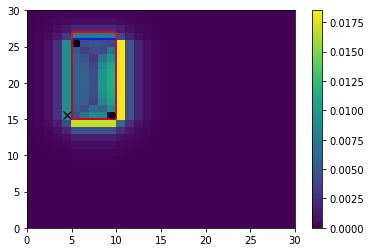

Creating TL
Done in: 0.03197646141052246  sec
Memory:  [4494.19140625]
Iteration: 0  Time: 0.08298373222351074  Distance: 0.999303457429  marginal-improvement: 0.000696542571399
Iteration: 1  Time: 0.07451558113098145  Distance: 1.87227827805  marginal-improvement: -0.873583308582
Iteration: 2  Time: 0.07413029670715332  Distance: 0.814974696548  marginal-improvement: 0.564714975277
Iteration: 3  Time: 0.07495760917663574  Distance: 0.433521398605  marginal-improvement: 0.468055388173
Iteration: 4  Time: 0.074859619140625  Distance: 0.256623884059  marginal-improvement: 0.408047942074
Iteration: 5  Time: 0.0737910270690918  Distance: 0.161826907925  marginal-improvement: 0.369400441745
Iteration: 6  Time: 0.07671070098876953  Distance: 0.107916359295  marginal-improvement: 0.333137111262
Iteration: 7  Time: 0.07482004165649414  Distance: 0.0760443501027  marginal-improvement: 0.295339922512
Iteration: 8  Time: 0.07395648956298828  Distance: 0.0537692493392  marginal-improvement: 0.2929

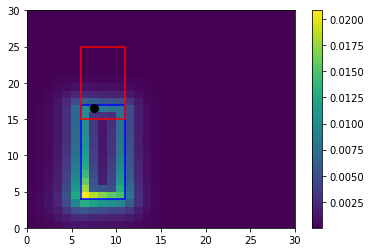

Creating TL
Done in: 1.768754005432129  sec
Memory:  [7102.9609375]
Iteration: 0  Time: 5.239507436752319  Distance: 0.998780509883  marginal-improvement: 0.00121949011719
Iteration: 1  Time: 3.251613140106201  Distance: 3.80562419884  marginal-improvement: -2.81027078641
Iteration: 2  Time: 3.269913673400879  Distance: 1.19854581061  marginal-improvement: 0.685059336396
Iteration: 3  Time: 3.2866291999816895  Distance: 0.581483783962  marginal-improvement: 0.514842253993
Iteration: 4  Time: 3.2820444107055664  Distance: 0.333771832035  marginal-improvement: 0.425999759166
Iteration: 5  Time: 3.2558207511901855  Distance: 0.208483755609  marginal-improvement: 0.375370430939
Iteration: 6  Time: 3.25415301322937  Distance: 0.136792042037  marginal-improvement: 0.343871940347
Iteration: 7  Time: 3.2776050567626953  Distance: 0.0967529184141  marginal-improvement: 0.292700679268
Iteration: 8  Time: 3.28385066986084  Distance: 0.0695123712562  marginal-improvement: 0.281547550238
Iteration:

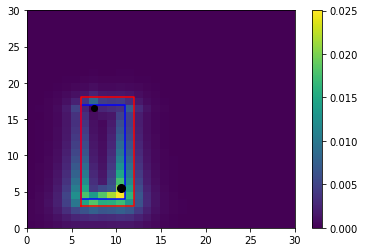

Creating TL
Done in: 0.3803839683532715  sec
Memory:  [4659.7265625]
Iteration: 0  Time: 0.861398458480835  Distance: 0.998324176519  marginal-improvement: 0.00167582348054
Iteration: 1  Time: 0.8577296733856201  Distance: 1.33370179768  marginal-improvement: -0.335940598303
Iteration: 2  Time: 0.8569552898406982  Distance: 0.528429605685  marginal-improvement: 0.60378728843
Iteration: 3  Time: 0.860767126083374  Distance: 0.255206581288  marginal-improvement: 0.517047155302
Iteration: 4  Time: 0.8598604202270508  Distance: 0.135886965839  marginal-improvement: 0.46754129477
Iteration: 5  Time: 0.8653197288513184  Distance: 0.0764899058285  marginal-improvement: 0.437106382083
Iteration: 6  Time: 0.8589937686920166  Distance: 0.0463784932224  marginal-improvement: 0.393665180784
Iteration: 7  Time: 0.857088565826416  Distance: 0.0281922543679  marginal-improvement: 0.39212655675
Iteration: 8  Time: 0.8631253242492676  Distance: 0.0171753462378  marginal-improvement: 0.390777835157
Iter

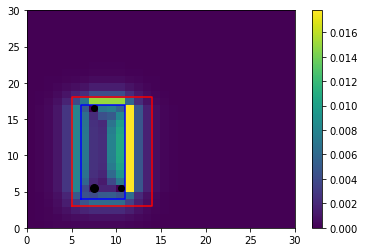

Creating TL
Done in: 0.4127941131591797  sec
Memory:  [4367.22265625]
Iteration: 0  Time: 0.892719030380249  Distance: 0.998168101383  marginal-improvement: 0.00183189861674
Iteration: 1  Time: 0.8820390701293945  Distance: 1.33602708385  marginal-improvement: -0.338479041754
Iteration: 2  Time: 0.8825578689575195  Distance: 0.529417645149  marginal-improvement: 0.603737340695
Iteration: 3  Time: 0.8792555332183838  Distance: 0.255705518176  marginal-improvement: 0.517006052747
Iteration: 4  Time: 0.8772823810577393  Distance: 0.136179151779  marginal-improvement: 0.46743757135
Iteration: 5  Time: 0.8770852088928223  Distance: 0.0766468890106  marginal-improvement: 0.437161356865
Iteration: 6  Time: 0.8742060661315918  Distance: 0.0464917185266  marginal-improvement: 0.393429803522
Iteration: 7  Time: 0.873450517654419  Distance: 0.0282725343544  marginal-improvement: 0.391880204681
Iteration: 8  Time: 0.8724710941314697  Distance: 0.0172314868243  marginal-improvement: 0.390522030737


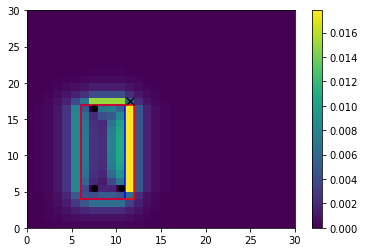

Creating TL
Done in: 0.03198885917663574  sec
Memory:  [4134.7109375]
Iteration: 0  Time: 0.07717776298522949  Distance: 6827.36672083  marginal-improvement: -6826.36672083
Iteration: 1  Time: 0.07442378997802734  Distance: 1.52197910454  marginal-improvement: 0.999777076702
Iteration: 2  Time: 0.07390284538269043  Distance: 0.722387979777  marginal-improvement: 0.525362748002
Iteration: 3  Time: 0.07553720474243164  Distance: 0.444842767786  marginal-improvement: 0.384205191339
Iteration: 4  Time: 0.07443594932556152  Distance: 0.313819348601  marginal-improvement: 0.294538719459
Iteration: 5  Time: 0.07386326789855957  Distance: 0.239237302207  marginal-improvement: 0.237659171515
Iteration: 6  Time: 0.07604861259460449  Distance: 0.194045413009  marginal-improvement: 0.188899844552
Iteration: 7  Time: 0.07442522048950195  Distance: 0.162824911186  marginal-improvement: 0.16089275876
Iteration: 8  Time: 0.07378506660461426  Distance: 0.139178168197  marginal-improvement: 0.1452280416

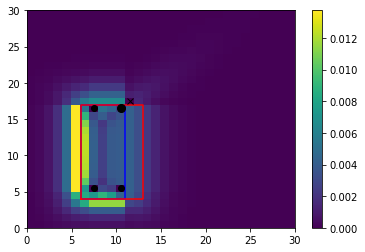

Creating TL
Done in: 0.03150629997253418  sec
Memory:  [4021.2265625]
Iteration: 0  Time: 0.07557106018066406  Distance: 6832.54445037  marginal-improvement: -6831.54445037
Iteration: 1  Time: 0.07455229759216309  Distance: 1.52162875194  marginal-improvement: 0.999777296911
Iteration: 2  Time: 0.07407426834106445  Distance: 0.722253258903  marginal-improvement: 0.525342000812
Iteration: 3  Time: 0.07462167739868164  Distance: 0.444762155682  marginal-improvement: 0.384201939971
Iteration: 4  Time: 0.07451152801513672  Distance: 0.313867754018  marginal-improvement: 0.29430202186
Iteration: 5  Time: 0.07397818565368652  Distance: 0.239318758897  marginal-improvement: 0.237517215982
Iteration: 6  Time: 0.07430887222290039  Distance: 0.194159135704  marginal-improvement: 0.188700724511
Iteration: 7  Time: 0.07657575607299805  Distance: 0.162939474005  marginal-improvement: 0.160794193822
Iteration: 8  Time: 0.07398152351379395  Distance: 0.139286241152  marginal-improvement: 0.1451657616

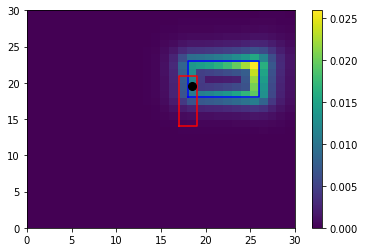

Creating TL
Done in: 1.8509690761566162  sec
Memory:  [7512.75390625]
Iteration: 0  Time: 3.906871795654297  Distance: 0.998666748115  marginal-improvement: 0.00133325188466
Iteration: 1  Time: 3.6819612979888916  Distance: 3.46152396335  marginal-improvement: -2.46614520799
Iteration: 2  Time: 3.713566303253174  Distance: 1.0592903986  marginal-improvement: 0.693981492021
Iteration: 3  Time: 3.694395065307617  Distance: 0.489990421564  marginal-improvement: 0.537435228137
Iteration: 4  Time: 3.6788980960845947  Distance: 0.26496896797  marginal-improvement: 0.459236433389
Iteration: 5  Time: 3.731996536254883  Distance: 0.154300785607  marginal-improvement: 0.417664691871
Iteration: 6  Time: 3.706432580947876  Distance: 0.0976791493896  marginal-improvement: 0.366956240663
Iteration: 7  Time: 3.7402520179748535  Distance: 0.0640757269712  marginal-improvement: 0.344018376781
Iteration: 8  Time: 3.6674227714538574  Distance: 0.0418396144145  marginal-improvement: 0.347028642636
Iterati

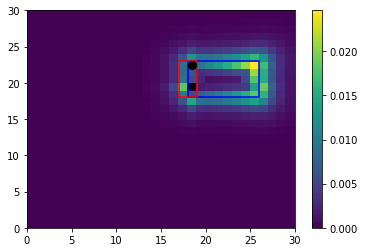

Creating TL
Done in: 1.2455556392669678  sec
Memory:  [5524.984375]
Iteration: 0  Time: 2.6028316020965576  Distance: 0.998637134827  marginal-improvement: 0.00136286517283
Iteration: 1  Time: 2.6128270626068115  Distance: 2.97973479134  marginal-improvement: -1.98380131023
Iteration: 2  Time: 2.6355013847351074  Distance: 0.98621633348  marginal-improvement: 0.669025466177
Iteration: 3  Time: 2.630659818649292  Distance: 0.464735937661  marginal-improvement: 0.528768768186
Iteration: 4  Time: 2.6169724464416504  Distance: 0.253351010551  marginal-improvement: 0.454849539233
Iteration: 5  Time: 2.5859732627868652  Distance: 0.148225762133  marginal-improvement: 0.414939132035
Iteration: 6  Time: 2.6158525943756104  Distance: 0.0935470674887  marginal-improvement: 0.368887930528
Iteration: 7  Time: 2.6224093437194824  Distance: 0.0614816872565  marginal-improvement: 0.342772692859
Iteration: 8  Time: 2.6197516918182373  Distance: 0.0402090182571  marginal-improvement: 0.346000084718
Ite

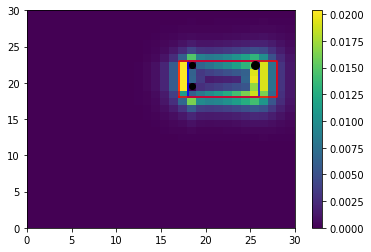

Creating TL
Done in: 0.4703209400177002  sec
Memory:  [4946.09765625]
Iteration: 0  Time: 1.0081164836883545  Distance: 0.998603909783  marginal-improvement: 0.00139609021718
Iteration: 1  Time: 1.0036628246307373  Distance: 2.15312924844  marginal-improvement: -1.15613941359
Iteration: 2  Time: 1.0032081604003906  Distance: 0.847998867812  marginal-improvement: 0.606155149105
Iteration: 3  Time: 1.0056126117706299  Distance: 0.424202543757  marginal-improvement: 0.499760483346
Iteration: 4  Time: 1.0140628814697266  Distance: 0.237779928199  marginal-improvement: 0.439466048239
Iteration: 5  Time: 1.0013740062713623  Distance: 0.141431877386  marginal-improvement: 0.405198418315
Iteration: 6  Time: 1.0114023685455322  Distance: 0.091142665662  marginal-improvement: 0.355571973259
Iteration: 7  Time: 1.0018107891082764  Distance: 0.0602298276728  marginal-improvement: 0.339169781404
Iteration: 8  Time: 1.0079548358917236  Distance: 0.0396038725014  marginal-improvement: 0.342454162138


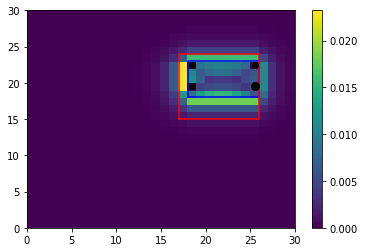

Creating TL
Done in: 0.47064924240112305  sec
Memory:  [4730.1171875]
Iteration: 0  Time: 1.002859115600586  Distance: 0.99860365955  marginal-improvement: 0.00139634044966
Iteration: 1  Time: 1.011904001235962  Distance: 2.15958164567  marginal-improvement: -1.16260137345
Iteration: 2  Time: 1.0069282054901123  Distance: 0.849859601742  marginal-improvement: 0.606470260828
Iteration: 3  Time: 1.005967140197754  Distance: 0.425016784828  marginal-improvement: 0.499897649027
Iteration: 4  Time: 1.0169360637664795  Distance: 0.238235360007  marginal-improvement: 0.439468349225
Iteration: 5  Time: 1.0088789463043213  Distance: 0.141720878361  marginal-improvement: 0.405122403505
Iteration: 6  Time: 1.0123355388641357  Distance: 0.0913303766219  marginal-improvement: 0.3555615963
Iteration: 7  Time: 1.0077683925628662  Distance: 0.0603714112943  marginal-improvement: 0.338977747303
Iteration: 8  Time: 1.0178415775299072  Distance: 0.0397091503733  marginal-improvement: 0.342252408516
Itera

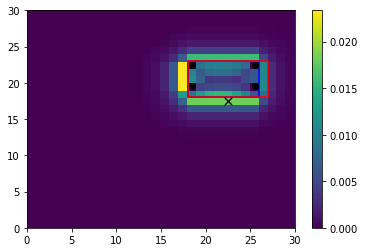

Creating TL
Done in: 0.02761244773864746  sec
Memory:  [4455.78515625]
Iteration: 0  Time: 0.07100725173950195  Distance: 634126.388012  marginal-improvement: -634125.388012
Iteration: 1  Time: 0.07093667984008789  Distance: 1.06785192907  marginal-improvement: 0.999998316027
Iteration: 2  Time: 0.06781721115112305  Distance: 0.339544789575  marginal-improvement: 0.6820300827
Iteration: 3  Time: 0.06843686103820801  Distance: 0.13802332788  marginal-improvement: 0.593504797843
Iteration: 4  Time: 0.06805849075317383  Distance: 0.0616558527853  marginal-improvement: 0.553293970429
Iteration: 5  Time: 0.06841254234313965  Distance: 0.028649578128  marginal-improvement: 0.535330762064
Iteration: 6  Time: 0.07000875473022461  Distance: 0.0135437014191  marginal-improvement: 0.52726349552
Iteration: 7  Time: 0.0678853988647461  Distance: 0.0065255934793  marginal-improvement: 0.518182417244
Total SK iteration time: 0.5581314563751221
Non-zeros in M: 1.35861  x 10^6
Memory after updating: [4

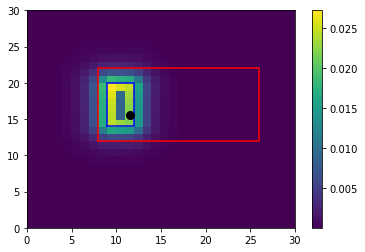

Creating TL
Done in: 2.126560926437378  sec
Memory:  [7281.2578125]
Iteration: 0  Time: 4.675826787948608  Distance: 0.998593653326  marginal-improvement: 0.00140634667386
Iteration: 1  Time: 4.146670341491699  Distance: 2.75032056874  marginal-improvement: -1.7541939202
Iteration: 2  Time: 4.057201147079468  Distance: 0.814674783094  marginal-improvement: 0.703789153762
Iteration: 3  Time: 4.15138578414917  Distance: 0.356862991831  marginal-improvement: 0.561956501862
Iteration: 4  Time: 4.055803298950195  Distance: 0.181043499316  marginal-improvement: 0.492680654872
Iteration: 5  Time: 4.084766387939453  Distance: 0.0994650220719  marginal-improvement: 0.450601526995
Iteration: 6  Time: 4.128742456436157  Distance: 0.0598311525128  marginal-improvement: 0.398470424412
Iteration: 7  Time: 4.114543676376343  Distance: 0.0358584623696  marginal-improvement: 0.400672377789
Iteration: 8  Time: 4.083559513092041  Distance: 0.0214313291125  marginal-improvement: 0.402335524274
Iteration: 

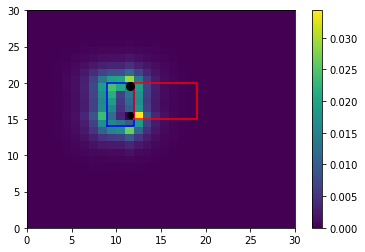

Creating TL
Done in: 1.4410114288330078  sec
Memory:  [5324.07421875]
Iteration: 0  Time: 2.909625768661499  Distance: 0.998402791149  marginal-improvement: 0.00159720885115
Iteration: 1  Time: 2.9339663982391357  Distance: 2.26548703445  marginal-improvement: -1.26911127907
Iteration: 2  Time: 2.9095420837402344  Distance: 0.721372688863  marginal-improvement: 0.681581629957
Iteration: 3  Time: 2.915083885192871  Distance: 0.317840239937  marginal-improvement: 0.559395240707
Iteration: 4  Time: 2.9157543182373047  Distance: 0.160251360377  marginal-improvement: 0.495811605198
Iteration: 5  Time: 2.9201865196228027  Distance: 0.0861691316684  marginal-improvement: 0.462287674404
Iteration: 6  Time: 2.919116973876953  Distance: 0.0501712815903  marginal-improvement: 0.41775806929
Iteration: 7  Time: 2.903114080429077  Distance: 0.0295943112919  marginal-improvement: 0.410134436397
Iteration: 8  Time: 2.914029359817505  Distance: 0.0173800583157  marginal-improvement: 0.412723001246
Iter

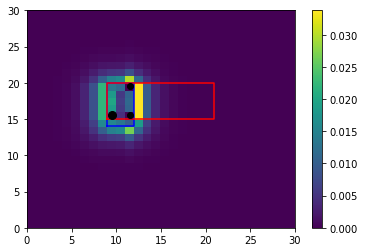

Creating TL
Done in: 1.1311228275299072  sec
Memory:  [5035.71875]
Iteration: 0  Time: 2.3396239280700684  Distance: 0.998226571137  marginal-improvement: 0.00177342886266
Iteration: 1  Time: 2.3627946376800537  Distance: 1.99706464175  marginal-improvement: -1.00061258585
Iteration: 2  Time: 2.360621690750122  Distance: 0.665897040801  marginal-improvement: 0.666562099753
Iteration: 3  Time: 2.3584625720977783  Distance: 0.299034492716  marginal-improvement: 0.550929836907
Iteration: 4  Time: 2.3597843647003174  Distance: 0.15237072597  marginal-improvement: 0.490457690727
Iteration: 5  Time: 2.357936143875122  Distance: 0.083219253559  marginal-improvement: 0.453836995072
Iteration: 6  Time: 2.383341073989868  Distance: 0.0494055226104  marginal-improvement: 0.40632100749
Iteration: 7  Time: 2.3681800365448  Distance: 0.0291848354571  marginal-improvement: 0.40927989595
Iteration: 8  Time: 2.357795476913452  Distance: 0.0171744326153  marginal-improvement: 0.411528886618
Iteration: 9

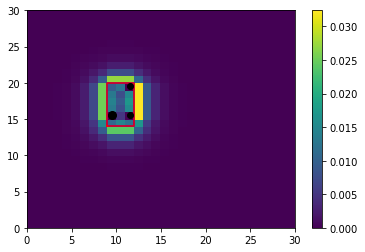

Repeated sample: Skipping the Actualization of M and TL
Non-zeros in M: 29.993886  x 10^6
Memory after updating: [4645.20703125]
FALTAN: 1 Examples
Move:  1799
Selected sample: (9, 19)
Selected box: (8, 12, 14, 20)


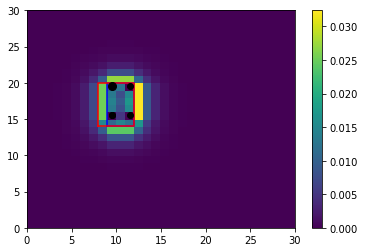

Creating TL
Done in: 1.108163595199585  sec
Memory:  [4987.96484375]
Iteration: 0  Time: 2.336735963821411  Distance: 0.99812314469  marginal-improvement: 0.00187685530988
Iteration: 1  Time: 2.3556792736053467  Distance: 2.00468884322  marginal-improvement: -1.00845842909
Iteration: 2  Time: 2.3916542530059814  Distance: 0.667466707297  marginal-improvement: 0.667047228025
Iteration: 3  Time: 2.3605270385742188  Distance: 0.29966606815  marginal-improvement: 0.551039677524
Iteration: 4  Time: 2.3815810680389404  Distance: 0.152710682402  marginal-improvement: 0.490397149917
Iteration: 5  Time: 2.352944850921631  Distance: 0.0833928996173  marginal-improvement: 0.453915742465
Iteration: 6  Time: 2.3932855129241943  Distance: 0.0495275142556  marginal-improvement: 0.406094349964
Iteration: 7  Time: 2.3639752864837646  Distance: 0.0292684498218  marginal-improvement: 0.409046663018
Iteration: 8  Time: 2.368929624557495  Distance: 0.0172322695446  marginal-improvement: 0.411233951593
Iter

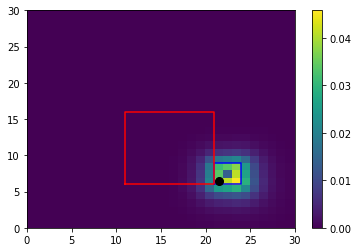

Creating TL
Done in: 1.116194486618042  sec
Memory:  [7307.44140625]
Iteration: 0  Time: 2.9753952026367188  Distance: 0.99893450502  marginal-improvement: 0.00106549498037
Iteration: 1  Time: 2.349052906036377  Distance: 5.39533205441  marginal-improvement: -4.40108688538
Iteration: 2  Time: 2.3478453159332275  Distance: 1.76286946509  marginal-improvement: 0.673260246578
Iteration: 3  Time: 2.3469631671905518  Distance: 0.904684160958  marginal-improvement: 0.486811599569
Iteration: 4  Time: 2.3646159172058105  Distance: 0.551363714609  marginal-improvement: 0.390545630836
Iteration: 5  Time: 2.3505196571350098  Distance: 0.365498226394  marginal-improvement: 0.337101414711
Iteration: 6  Time: 2.3212857246398926  Distance: 0.254229442138  marginal-improvement: 0.304430435554
Iteration: 7  Time: 2.3357181549072266  Distance: 0.18227927233  marginal-improvement: 0.283012735281
Iteration: 8  Time: 2.362171173095703  Distance: 0.137700744317  marginal-improvement: 0.244561696146
Iteratio

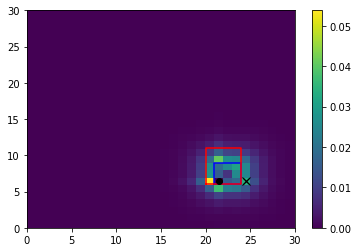

Creating TL
Done in: 0.33724045753479004  sec
Memory:  [4974.45703125]
Iteration: 0  Time: 0.7137174606323242  Distance: 37.4589684263  marginal-improvement: -36.4589684263
Iteration: 1  Time: 0.7176446914672852  Distance: 6.20005027761  marginal-improvement: 0.834484222655
Iteration: 2  Time: 0.716127872467041  Distance: 2.01371039959  marginal-improvement: 0.675210633879
Iteration: 3  Time: 0.7186460494995117  Distance: 1.0462958142  marginal-improvement: 0.480413959022
Iteration: 4  Time: 0.7172629833221436  Distance: 0.650261547767  marginal-improvement: 0.378510800728
Iteration: 5  Time: 0.7165048122406006  Distance: 0.440256182556  marginal-improvement: 0.322955226144
Iteration: 6  Time: 0.7178406715393066  Distance: 0.312911351892  marginal-improvement: 0.289251657806
Iteration: 7  Time: 0.7176375389099121  Distance: 0.229325785256  marginal-improvement: 0.267122193331
Iteration: 8  Time: 0.7222325801849365  Distance: 0.172816392217  marginal-improvement: 0.246415347392
Iteratio

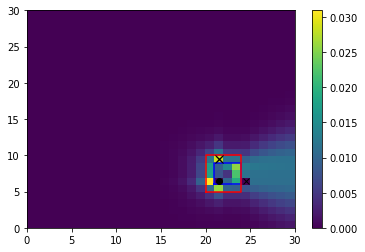

Creating TL
Done in: 0.02920842170715332  sec
Memory:  [4550.54296875]
Iteration: 0  Time: 0.06987643241882324  Distance: 62067993.479  marginal-improvement: -62067992.479
Iteration: 1  Time: 0.06934452056884766  Distance: 1.847986341  marginal-improvement: 0.999999970226
Iteration: 2  Time: 0.06689906120300293  Distance: 0.476522437628  marginal-improvement: 0.742139632173
Iteration: 3  Time: 0.06690430641174316  Distance: 0.218386291504  marginal-improvement: 0.541708271721
Iteration: 4  Time: 0.06748247146606445  Distance: 0.111965380421  marginal-improvement: 0.487305821032
Iteration: 5  Time: 0.06667566299438477  Distance: 0.0600236564676  marginal-improvement: 0.463908788216
Iteration: 6  Time: 0.06737470626831055  Distance: 0.0328667667973  marginal-improvement: 0.452436443704
Iteration: 7  Time: 0.06805133819580078  Distance: 0.0184071900949  marginal-improvement: 0.439945212488
Iteration: 8  Time: 0.06692218780517578  Distance: 0.0103770010033  marginal-improvement: 0.43625284

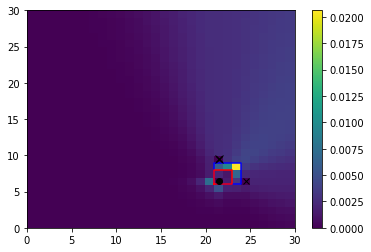

Repeated sample: Skipping the Actualization of M and TL
Non-zeros in M: 1.243242  x 10^6
Memory after updating: [4463.61328125]
FALTAN: 1 Examples
Move:  1804
Selected sample: (24, 9)
Selected box: (21, 23, 6, 8)


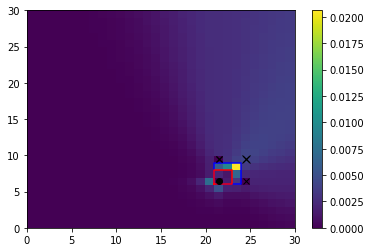

Creating TL
Done in: 0.030704259872436523  sec
Memory:  [4477.94140625]
Iteration: 0  Time: 0.06793379783630371  Distance: 61944304.9106  marginal-improvement: -61944303.9106
Iteration: 1  Time: 0.07026553153991699  Distance: 1.8507726051  marginal-improvement: 0.999999970122
Iteration: 2  Time: 0.06899166107177734  Distance: 0.476875291342  marginal-improvement: 0.742337178524
Iteration: 3  Time: 0.06813454627990723  Distance: 0.218407201352  marginal-improvement: 0.542003527302
Iteration: 4  Time: 0.0687251091003418  Distance: 0.111938958652  marginal-improvement: 0.487475880103
Iteration: 5  Time: 0.06915521621704102  Distance: 0.0599951649196  marginal-improvement: 0.46403677824
Iteration: 6  Time: 0.06791067123413086  Distance: 0.0328445825534  marginal-improvement: 0.452546174388
Iteration: 7  Time: 0.0688018798828125  Distance: 0.0183860676173  marginal-improvement: 0.440210038068
Iteration: 8  Time: 0.06850671768188477  Distance: 0.0103630263822  marginal-improvement: 0.4363652

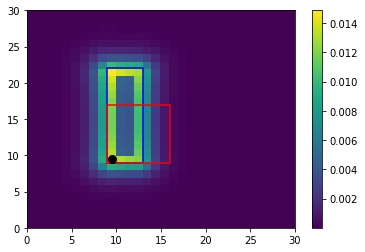

Creating TL
Done in: 1.7430317401885986  sec
Memory:  [7087.05078125]
Iteration: 0  Time: 4.621007442474365  Distance: 0.998760944357  marginal-improvement: 0.00123905564313
Iteration: 1  Time: 3.2242562770843506  Distance: 4.15034160595  marginal-improvement: -3.15549048989
Iteration: 2  Time: 3.263615131378174  Distance: 1.30587688862  marginal-improvement: 0.685356769971
Iteration: 3  Time: 3.2166194915771484  Distance: 0.632673072222  marginal-improvement: 0.515518593111
Iteration: 4  Time: 3.2413923740386963  Distance: 0.361070759342  marginal-improvement: 0.429293302978
Iteration: 5  Time: 3.267951250076294  Distance: 0.222950366424  marginal-improvement: 0.382529987115
Iteration: 6  Time: 3.2676734924316406  Distance: 0.143758943458  marginal-improvement: 0.355197545695
Iteration: 7  Time: 3.2739052772521973  Distance: 0.101115751823  marginal-improvement: 0.296629834706
Iteration: 8  Time: 3.2687008380889893  Distance: 0.0714329095566  marginal-improvement: 0.293553098613
Itera

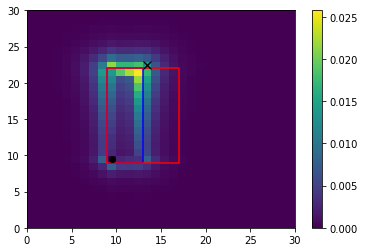

Creating TL
Done in: 1.019477128982544  sec
Memory:  [5043.015625]
Iteration: 0  Time: 2.132903814315796  Distance: 1123.93126924  marginal-improvement: -1122.93126924
Iteration: 1  Time: 2.124999761581421  Distance: 5.04660071611  marginal-improvement: 0.995509867147
Iteration: 2  Time: 2.1252613067626953  Distance: 1.78243141458  marginal-improvement: 0.646805540036
Iteration: 3  Time: 2.1188480854034424  Distance: 0.993633417247  marginal-improvement: 0.442540448335
Iteration: 4  Time: 2.1330671310424805  Distance: 0.66047989983  marginal-improvement: 0.335288157216
Iteration: 5  Time: 2.111158609390259  Distance: 0.478859188881  marginal-improvement: 0.274982949512
Iteration: 6  Time: 2.1314384937286377  Distance: 0.364804670677  marginal-improvement: 0.238179658765
Iteration: 7  Time: 2.1190223693847656  Distance: 0.299458736615  marginal-improvement: 0.179125815305
Iteration: 8  Time: 2.117065191268921  Distance: 0.261438118016  marginal-improvement: 0.126964466054
Iteration: 9  

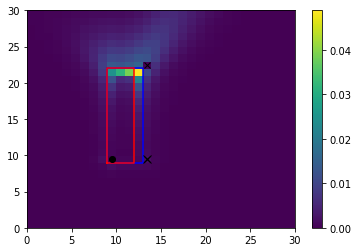

Creating TL
Done in: 0.24313807487487793  sec
Memory:  [4503.078125]
Iteration: 0  Time: 0.490220308303833  Distance: 1861029.93483  marginal-improvement: -1861028.93483
Iteration: 1  Time: 0.4907407760620117  Distance: 2.46300841463  marginal-improvement: 0.999998676535
Iteration: 2  Time: 0.4923408031463623  Distance: 0.601342471109  marginal-improvement: 0.755850419537
Iteration: 3  Time: 0.49097752571105957  Distance: 0.251374525845  marginal-improvement: 0.581977761555
Iteration: 4  Time: 0.49167943000793457  Distance: 0.1239656499  marginal-improvement: 0.506848796698
Iteration: 5  Time: 0.49140095710754395  Distance: 0.0691007497752  marginal-improvement: 0.442581474537
Iteration: 6  Time: 0.49834632873535156  Distance: 0.0388436963894  marginal-improvement: 0.437868669794
Iteration: 7  Time: 0.4895663261413574  Distance: 0.0218931959699  marginal-improvement: 0.436377121518
Iteration: 8  Time: 0.49098706245422363  Distance: 0.0123397125865  marginal-improvement: 0.436367691429


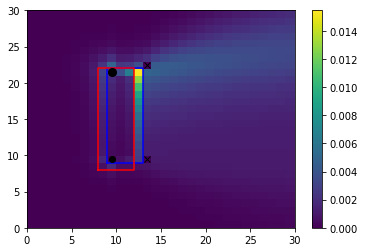

Creating TL
Done in: 0.07479357719421387  sec
Memory:  [4181.8984375]
Iteration: 0  Time: 0.21529388427734375  Distance: 285079.09536  marginal-improvement: -285078.09536
Iteration: 1  Time: 0.1779766082763672  Distance: 0.855180024555  marginal-improvement: 0.999997000201
Iteration: 2  Time: 0.1755974292755127  Distance: 0.18842468219  marginal-improvement: 0.779666647045
Iteration: 3  Time: 0.17547202110290527  Distance: 0.0637518219366  marginal-improvement: 0.66165885915
Iteration: 4  Time: 0.1759812831878662  Distance: 0.0205355225234  marginal-improvement: 0.677883362396
Iteration: 5  Time: 0.17511773109436035  Distance: 0.00659809321342  marginal-improvement: 0.678698547558
Total SK iteration time: 1.0985722541809082
Non-zeros in M: 3.223808  x 10^6
Memory after updating: [4161.5703125]
###########################################
############### NEW TRIAL #################
###########################################
True hypothesis: (23, 26, 4, 7)
FALTAN: 3 Examples
Move:  1809


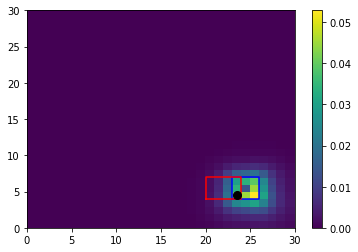

Creating TL
Done in: 0.6821250915527344  sec
Memory:  [7174.5]
Iteration: 0  Time: 1.5824744701385498  Distance: 1.32887240151  marginal-improvement: -0.328872401507
Iteration: 1  Time: 1.4832842350006104  Distance: 7.18083289445  marginal-improvement: -4.40370383666
Iteration: 2  Time: 1.4731943607330322  Distance: 2.4253772899  marginal-improvement: 0.662242900573
Iteration: 3  Time: 1.4765865802764893  Distance: 1.29658683907  marginal-improvement: 0.465408188463
Iteration: 4  Time: 1.478191614151001  Distance: 0.828138053077  marginal-improvement: 0.361293799903
Iteration: 5  Time: 1.4857172966003418  Distance: 0.577271713025  marginal-improvement: 0.302928164115
Iteration: 6  Time: 1.480461835861206  Distance: 0.423396472301  marginal-improvement: 0.266556003441
Iteration: 7  Time: 1.4837565422058105  Distance: 0.320913781642  marginal-improvement: 0.242048995123
Iteration: 8  Time: 1.4818041324615479  Distance: 0.248830377228  marginal-improvement: 0.224619223411
Iteration: 9  Ti

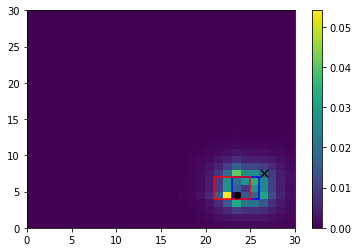

Creating TL
Done in: 0.3260157108306885  sec
Memory:  [4950.97265625]
Iteration: 0  Time: 0.6926038265228271  Distance: 8.59383661102  marginal-improvement: -7.59383661102
Iteration: 1  Time: 0.6923558712005615  Distance: 9.21413683685  marginal-improvement: -0.0721796624613
Iteration: 2  Time: 0.692908525466919  Distance: 3.27302558147  marginal-improvement: 0.644782182051
Iteration: 3  Time: 0.6998183727264404  Distance: 1.94184909393  marginal-improvement: 0.4067112995
Iteration: 4  Time: 0.7028689384460449  Distance: 1.35312387732  marginal-improvement: 0.303177635406
Iteration: 5  Time: 0.6950123310089111  Distance: 0.997778257481  marginal-improvement: 0.262611299523
Iteration: 6  Time: 0.696605920791626  Distance: 0.769053957356  marginal-improvement: 0.229233598157
Iteration: 7  Time: 0.7008979320526123  Distance: 0.613020697248  marginal-improvement: 0.202889873481
Iteration: 8  Time: 0.699674129486084  Distance: 0.501183936908  marginal-improvement: 0.1824355374
Iteration: 9 

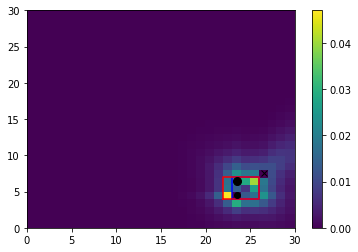

Creating TL
Done in: 0.2634565830230713  sec
Memory:  [4861.02734375]
Iteration: 0  Time: 0.5220794677734375  Distance: 3.51634314998  marginal-improvement: -2.51634314998
Iteration: 1  Time: 0.5249471664428711  Distance: 6.64737442963  marginal-improvement: -0.890422562903
Iteration: 2  Time: 0.5246322154998779  Distance: 2.36510981406  marginal-improvement: 0.644203912522
Iteration: 3  Time: 0.5256338119506836  Distance: 1.2724452751  marginal-improvement: 0.46199315248
Iteration: 4  Time: 0.5257461071014404  Distance: 0.815435960523  marginal-improvement: 0.359158325723
Iteration: 5  Time: 0.5237972736358643  Distance: 0.578350963195  marginal-improvement: 0.290746310938
Iteration: 6  Time: 0.5218193531036377  Distance: 0.436755744094  marginal-improvement: 0.244825768628
Iteration: 7  Time: 0.5256659984588623  Distance: 0.337938420119  marginal-improvement: 0.226253060918
Iteration: 8  Time: 0.5313904285430908  Distance: 0.264020234815  marginal-improvement: 0.218732706622
Iteratio

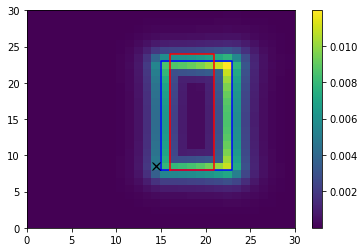

Creating TL
Done in: 7.002838373184204  sec
Memory:  [9254.59375]
Iteration: 0  Time: 13.808940172195435  Distance: 0.996619930256  marginal-improvement: 0.00338006974422
Iteration: 1  Time: 13.43467903137207  Distance: 1.07476556991  marginal-improvement: -0.0784106731956
Iteration: 2  Time: 13.423403978347778  Distance: 0.51102755506  marginal-improvement: 0.524521840513
Iteration: 3  Time: 13.501799821853638  Distance: 0.299357687207  marginal-improvement: 0.414204411792
Iteration: 4  Time: 13.351633548736572  Distance: 0.193744402071  marginal-improvement: 0.352799642867
Iteration: 5  Time: 13.53336215019226  Distance: 0.134673192399  marginal-improvement: 0.304892471938
Iteration: 6  Time: 13.396255731582642  Distance: 0.100483547485  marginal-improvement: 0.253871199646
Iteration: 7  Time: 13.420376300811768  Distance: 0.0767757155613  marginal-improvement: 0.23593744963
Iteration: 8  Time: 13.38251280784607  Distance: 0.0593982824773  marginal-improvement: 0.22634022955
Iteratio

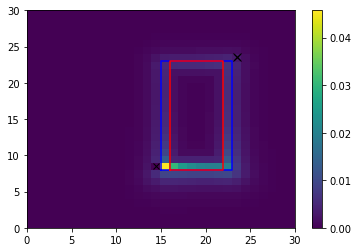

Creating TL
Done in: 5.841612339019775  sec
Memory:  [8321.31640625]
Iteration: 0  Time: 11.421775579452515  Distance: 0.997122056204  marginal-improvement: 0.00287794379624
Iteration: 1  Time: 11.552309036254883  Distance: 1.5177285077  marginal-improvement: -0.522109052
Iteration: 2  Time: 11.608192682266235  Distance: 0.764640741723  marginal-improvement: 0.49619399132
Iteration: 3  Time: 11.670979499816895  Distance: 0.467828254745  marginal-improvement: 0.388172472094
Iteration: 4  Time: 11.500307321548462  Distance: 0.309291663333  marginal-improvement: 0.33887776081
Iteration: 5  Time: 11.542846202850342  Distance: 0.214849205135  marginal-improvement: 0.305350804419
Iteration: 6  Time: 11.613712072372437  Distance: 0.161860264751  marginal-improvement: 0.246633169299
Iteration: 7  Time: 11.640372037887573  Distance: 0.126102009474  marginal-improvement: 0.220920528776
Iteration: 8  Time: 11.670302152633667  Distance: 0.0991132686361  marginal-improvement: 0.214023082984
Iterati

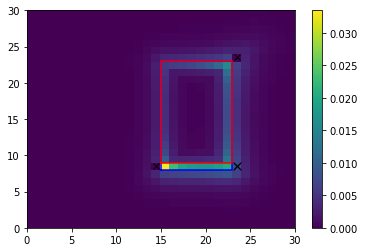

Creating TL
Done in: 5.504809379577637  sec
Memory:  [7936.6171875]
Iteration: 0  Time: 10.760623216629028  Distance: 0.997449749808  marginal-improvement: 0.00255025019166
Iteration: 1  Time: 10.883403062820435  Distance: 1.59943455092  marginal-improvement: -0.603523938151
Iteration: 2  Time: 10.814543724060059  Distance: 0.861310790594  marginal-improvement: 0.461490443546
Iteration: 3  Time: 10.869527339935303  Distance: 0.564286466633  marginal-improvement: 0.344851506802
Iteration: 4  Time: 10.760236024856567  Distance: 0.402183828636  marginal-improvement: 0.287270114707
Iteration: 5  Time: 10.837719678878784  Distance: 0.301995270603  marginal-improvement: 0.249111353812
Iteration: 6  Time: 10.724252700805664  Distance: 0.235567239664  marginal-improvement: 0.219963812038
Iteration: 7  Time: 10.799524784088135  Distance: 0.188234111085  marginal-improvement: 0.200932560258
Iteration: 8  Time: 10.687439680099487  Distance: 0.152480034306  marginal-improvement: 0.189944726667
Ite

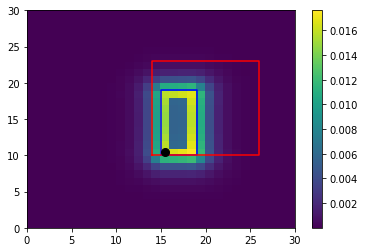

Creating TL
Done in: 2.062737464904785  sec
Memory:  [7825.6171875]
Iteration: 0  Time: 4.04685115814209  Distance: 0.998628676785  marginal-improvement: 0.00137132321485
Iteration: 1  Time: 3.8692667484283447  Distance: 2.93341227304  marginal-improvement: -1.93744045333
Iteration: 2  Time: 3.9280757904052734  Distance: 0.880839486814  marginal-improvement: 0.699721892177
Iteration: 3  Time: 3.8981263637542725  Distance: 0.395132112377  marginal-improvement: 0.5514141699
Iteration: 4  Time: 3.8824527263641357  Distance: 0.206508174837  marginal-improvement: 0.477369294044
Iteration: 5  Time: 3.8849921226501465  Distance: 0.116161400252  marginal-improvement: 0.437497327439
Iteration: 6  Time: 3.8552145957946777  Distance: 0.0723607678641  marginal-improvement: 0.377067014454
Iteration: 7  Time: 3.8692679405212402  Distance: 0.0453263241455  marginal-improvement: 0.373606368707
Iteration: 8  Time: 3.907137632369995  Distance: 0.028365564509  marginal-improvement: 0.374192259273
Iterati

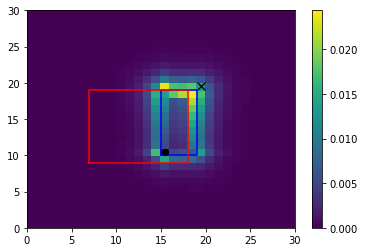

Creating TL
Done in: 1.054088830947876  sec
Memory:  [5711.203125]
Iteration: 0  Time: 2.284998655319214  Distance: 6079.84399623  marginal-improvement: -6078.84399623
Iteration: 1  Time: 2.221543073654175  Distance: 5.85705291026  marginal-improvement: 0.999036644211
Iteration: 2  Time: 2.2195303440093994  Distance: 2.02345360503  marginal-improvement: 0.654527005982
Iteration: 3  Time: 2.2185006141662598  Distance: 1.11558275824  marginal-improvement: 0.448673913023
Iteration: 4  Time: 2.2361180782318115  Distance: 0.740735766127  marginal-improvement: 0.336010026458
Iteration: 5  Time: 2.2183778285980225  Distance: 0.543581357168  marginal-improvement: 0.266160239555
Iteration: 6  Time: 2.2276480197906494  Distance: 0.42427386874  marginal-improvement: 0.219484143183
Iteration: 7  Time: 2.2087957859039307  Distance: 0.343250368325  marginal-improvement: 0.19096981074
Iteration: 8  Time: 2.196769952774048  Distance: 0.28353208748  marginal-improvement: 0.173978781541
Iteration: 9  Ti

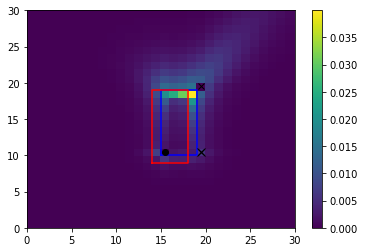

Creating TL
Done in: 0.43624448776245117  sec
Memory:  [5141.734375]
Iteration: 0  Time: 0.9301531314849854  Distance: 5000.50340262  marginal-improvement: -4999.50340262
Iteration: 1  Time: 0.9405162334442139  Distance: 3.36212097255  marginal-improvement: 0.999327643499
Iteration: 2  Time: 0.9379527568817139  Distance: 0.959058505466  marginal-improvement: 0.714745985259
Iteration: 3  Time: 0.9348154067993164  Distance: 0.429187989545  marginal-improvement: 0.552490294285
Iteration: 4  Time: 0.93857741355896  Distance: 0.22646124003  marginal-improvement: 0.472349540187
Iteration: 5  Time: 0.936438798904419  Distance: 0.131778476794  marginal-improvement: 0.41809699189
Iteration: 6  Time: 0.9346451759338379  Distance: 0.0844217171771  marginal-improvement: 0.359366421352
Iteration: 7  Time: 0.9338197708129883  Distance: 0.0537798280837  marginal-improvement: 0.362962163268
Iteration: 8  Time: 0.9397027492523193  Distance: 0.034064577383  marginal-improvement: 0.36659192495
Iteration:

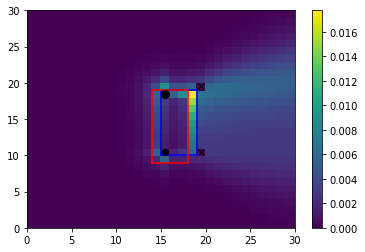

Creating TL
Done in: 0.24204587936401367  sec
Memory:  [4892.7265625]
Iteration: 0  Time: 0.49419426918029785  Distance: 1047.17609659  marginal-improvement: -1046.17609659
Iteration: 1  Time: 0.4988079071044922  Distance: 1.56997805983  marginal-improvement: 0.998500750671
Iteration: 2  Time: 0.4979090690612793  Distance: 0.481211249762  marginal-improvement: 0.693491735921
Iteration: 3  Time: 0.4983859062194824  Distance: 0.198384053527  marginal-improvement: 0.587740200121
Iteration: 4  Time: 0.49869871139526367  Distance: 0.0946803655163  marginal-improvement: 0.52274205596
Iteration: 5  Time: 0.499774694442749  Distance: 0.0501926024831  marginal-improvement: 0.469873165261
Iteration: 6  Time: 0.5021049976348877  Distance: 0.0280400754997  marginal-improvement: 0.441350435871
Iteration: 7  Time: 0.49808669090270996  Distance: 0.0157055291599  marginal-improvement: 0.439889911846
Iteration: 8  Time: 0.4995887279510498  Distance: 0.00880782270648  marginal-improvement: 0.43918968811

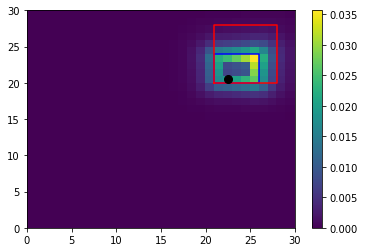

Creating TL
Done in: 1.558363914489746  sec
Memory:  [6854.2421875]
Iteration: 0  Time: 5.7130773067474365  Distance: 0.998848541588  marginal-improvement: 0.00115145841151
Iteration: 1  Time: 2.8426108360290527  Distance: 4.73027470702  marginal-improvement: -3.73572770051
Iteration: 2  Time: 2.834974765777588  Distance: 1.51882357322  marginal-improvement: 0.678914298367
Iteration: 3  Time: 2.8544156551361084  Distance: 0.759607571314  marginal-improvement: 0.499871094505
Iteration: 4  Time: 2.847283363342285  Distance: 0.449716624866  marginal-improvement: 0.407961897894
Iteration: 5  Time: 2.8128435611724854  Distance: 0.28905424378  marginal-improvement: 0.357252483458
Iteration: 6  Time: 2.80741548538208  Distance: 0.194622070318  marginal-improvement: 0.326693606803
Iteration: 7  Time: 2.7735815048217773  Distance: 0.13747191206  marginal-improvement: 0.293646851893
Iteration: 8  Time: 2.8214638233184814  Distance: 0.102628646575  marginal-improvement: 0.253457342397
Iteration: 

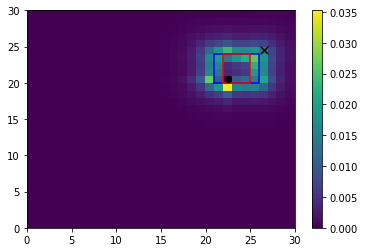

Creating TL
Done in: 0.8831846714019775  sec
Memory:  [4806.21484375]
Iteration: 0  Time: 1.8529090881347656  Distance: 3.04993409902  marginal-improvement: -2.04993409902
Iteration: 1  Time: 1.8608076572418213  Distance: 5.368108393  marginal-improvement: -0.760073568384
Iteration: 2  Time: 1.8912084102630615  Distance: 1.66180956977  marginal-improvement: 0.690429207439
Iteration: 3  Time: 1.872147798538208  Distance: 0.828809161198  marginal-improvement: 0.501261049237
Iteration: 4  Time: 1.8677678108215332  Distance: 0.493741250123  marginal-improvement: 0.40427631204
Iteration: 5  Time: 1.86765456199646  Distance: 0.320200695491  marginal-improvement: 0.351480769714
Iteration: 6  Time: 1.8557074069976807  Distance: 0.217814350994  marginal-improvement: 0.319756783599
Iteration: 7  Time: 1.8743853569030762  Distance: 0.152625519587  marginal-improvement: 0.299286209149
Iteration: 8  Time: 1.8577778339385986  Distance: 0.115161045826  marginal-improvement: 0.245466641898
Iteration: 

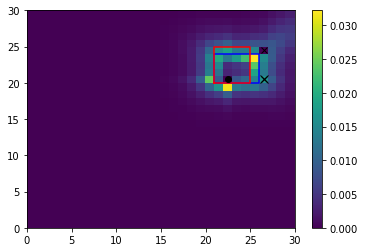

Creating TL
Done in: 0.6042413711547852  sec
Memory:  [4527.39453125]
Iteration: 0  Time: 1.2946133613586426  Distance: 5.64059289204  marginal-improvement: -4.64059289204
Iteration: 1  Time: 1.3002116680145264  Distance: 5.4173590211  marginal-improvement: 0.0395763132016
Iteration: 2  Time: 1.3054418563842773  Distance: 1.72673121931  marginal-improvement: 0.681259592989
Iteration: 3  Time: 1.3043444156646729  Distance: 0.871842046364  marginal-improvement: 0.495091050295
Iteration: 4  Time: 1.3060626983642578  Distance: 0.526460310495  marginal-improvement: 0.39615173105
Iteration: 5  Time: 1.303553819656372  Distance: 0.346912120545  marginal-improvement: 0.341047912579
Iteration: 6  Time: 1.3035049438476562  Distance: 0.240299688813  marginal-improvement: 0.307318267127
Iteration: 7  Time: 1.3046417236328125  Distance: 0.171797834839  marginal-improvement: 0.285068425653
Iteration: 8  Time: 1.3038949966430664  Distance: 0.131445568105  marginal-improvement: 0.234882277598
Iteratio

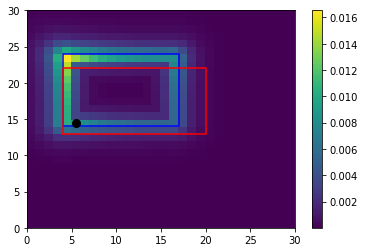

Creating TL
Done in: 1.225480318069458  sec
Memory:  [7485.29296875]
Iteration: 0  Time: 2.699702501296997  Distance: 0.998921475433  marginal-improvement: 0.00107852456691
Iteration: 1  Time: 2.5629210472106934  Distance: 4.26464597649  marginal-improvement: -3.269250468
Iteration: 2  Time: 2.5777840614318848  Distance: 1.38505172643  marginal-improvement: 0.67522468827
Iteration: 3  Time: 2.575857400894165  Distance: 0.703113829593  marginal-improvement: 0.492355544436
Iteration: 4  Time: 2.571589231491089  Distance: 0.425883139091  marginal-improvement: 0.394289912719
Iteration: 5  Time: 2.5716800689697266  Distance: 0.282470009868  marginal-improvement: 0.336742913865
Iteration: 6  Time: 2.571274757385254  Distance: 0.197766695013  marginal-improvement: 0.299866576613
Iteration: 7  Time: 2.568751573562622  Distance: 0.143415824861  marginal-improvement: 0.274823170545
Iteration: 8  Time: 2.58227801322937  Distance: 0.108089574678  marginal-improvement: 0.246320447675
Iteration: 9  

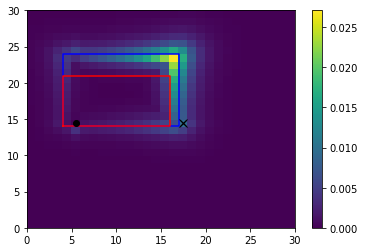

Creating TL
Done in: 0.5313351154327393  sec
Memory:  [5268.25]
Iteration: 0  Time: 1.1676838397979736  Distance: 89848.9830525  marginal-improvement: -89847.9830525
Iteration: 1  Time: 1.176459789276123  Distance: 5.66026037948  marginal-improvement: 0.99993700251
Iteration: 2  Time: 1.169677734375  Distance: 1.63594280199  marginal-improvement: 0.710977465291
Iteration: 3  Time: 1.1697938442230225  Distance: 0.795657204894  marginal-improvement: 0.51363996105
Iteration: 4  Time: 1.1705071926116943  Distance: 0.47126110663  marginal-improvement: 0.407708365196
Iteration: 5  Time: 1.1714577674865723  Distance: 0.30652758475  marginal-improvement: 0.349558916623
Iteration: 6  Time: 1.167999029159546  Distance: 0.20955387721  marginal-improvement: 0.316362090605
Iteration: 7  Time: 1.1617116928100586  Distance: 0.154989153967  marginal-improvement: 0.260385176214
Iteration: 8  Time: 1.1709887981414795  Distance: 0.116362793834  marginal-improvement: 0.249219762441
Iteration: 9  Time: 1.1

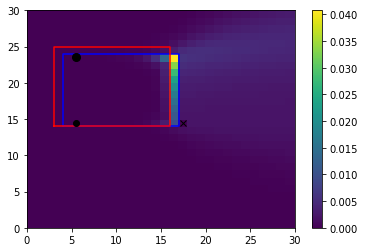

Creating TL
Done in: 0.20988225936889648  sec
Memory:  [4914.0703125]
Iteration: 0  Time: 0.4301135540008545  Distance: 27790.9476426  marginal-improvement: -27789.9476426
Iteration: 1  Time: 0.43261075019836426  Distance: 4.05928808812  marginal-improvement: 0.999853934881
Iteration: 2  Time: 0.4289391040802002  Distance: 1.40260849046  marginal-improvement: 0.654469340432
Iteration: 3  Time: 0.43131470680236816  Distance: 0.74202896412  marginal-improvement: 0.470965013284
Iteration: 4  Time: 0.43153953552246094  Distance: 0.467367270948  marginal-improvement: 0.370149558107
Iteration: 5  Time: 0.4307711124420166  Distance: 0.318950521271  marginal-improvement: 0.317559142249
Iteration: 6  Time: 0.42880773544311523  Distance: 0.228025027267  marginal-improvement: 0.285077113657
Iteration: 7  Time: 0.4281342029571533  Distance: 0.166063542023  marginal-improvement: 0.271731072622
Iteration: 8  Time: 0.42511844635009766  Distance: 0.123763537128  marginal-improvement: 0.254721803354
It

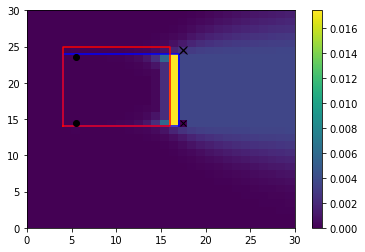

Creating TL
Done in: 0.1945047378540039  sec
Memory:  [4813.890625]
Iteration: 0  Time: 0.44138193130493164  Distance: 27786.185585  marginal-improvement: -27785.185585
Iteration: 1  Time: 0.44021153450012207  Distance: 4.05591743036  marginal-improvement: 0.999854031155
Iteration: 2  Time: 0.4600868225097656  Distance: 1.40154819381  marginal-improvement: 0.65444360792
Iteration: 3  Time: 0.45105433464050293  Distance: 0.741362886971  marginal-improvement: 0.471040032555
Iteration: 4  Time: 0.45238256454467773  Distance: 0.466865604775  marginal-improvement: 0.370260350255
Iteration: 5  Time: 0.45026326179504395  Distance: 0.318573024211  marginal-improvement: 0.317634409234
Iteration: 6  Time: 0.4548788070678711  Distance: 0.227692567065  marginal-improvement: 0.285273548728
Iteration: 7  Time: 0.4509391784667969  Distance: 0.165818859512  marginal-improvement: 0.27174232497
Iteration: 8  Time: 0.4516739845275879  Distance: 0.123618378089  marginal-improvement: 0.254497477233
Iterati

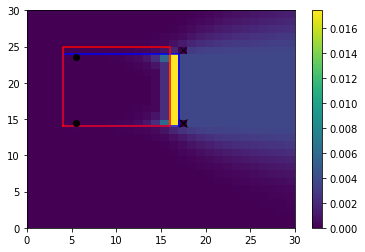

Repeated sample: Skipping the Actualization of M and TL
Non-zeros in M: 6.771968  x 10^6
Memory after updating: [4762.2265625]
###########################################
############### NEW TRIAL #################
###########################################
True hypothesis: (12, 25, 15, 23)
FALTAN: 3 Examples
Move:  1827
Selected sample: (11, 15)
Selected box: (11, 23, 16, 26)


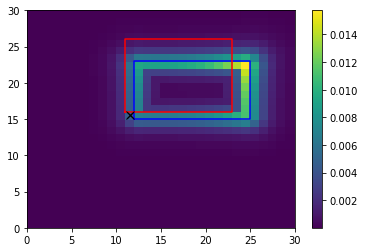

Creating TL
Done in: 6.667388916015625  sec
Memory:  [9277.7109375]
Iteration: 0  Time: 13.732330322265625  Distance: 0.996460207542  marginal-improvement: 0.00353979245769
Iteration: 1  Time: 12.85391902923584  Distance: 0.873191225087  marginal-improvement: 0.123706879133
Iteration: 2  Time: 12.874734878540039  Distance: 0.394239515811  marginal-improvement: 0.548507240471
Iteration: 3  Time: 13.055038452148438  Distance: 0.220575048911  marginal-improvement: 0.440504972067
Iteration: 4  Time: 12.979602098464966  Distance: 0.138895731217  marginal-improvement: 0.370301709542
Iteration: 5  Time: 13.013691902160645  Distance: 0.0950284482726  marginal-improvement: 0.315828877965
Iteration: 6  Time: 12.831725358963013  Distance: 0.0674221184946  marginal-improvement: 0.290505951426
Iteration: 7  Time: 12.858221530914307  Distance: 0.049519439687  marginal-improvement: 0.26553124119
Iteration: 8  Time: 12.82016921043396  Distance: 0.0372979591427  marginal-improvement: 0.246801672667
Ite

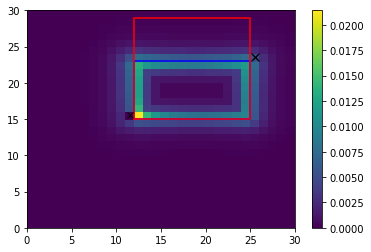

Creating TL
Done in: 5.688838720321655  sec
Memory:  [8411.46484375]
Iteration: 0  Time: 11.326126337051392  Distance: 1.0903124875  marginal-improvement: -0.0903124875034
Iteration: 1  Time: 11.45509123802185  Distance: 1.49933763297  marginal-improvement: -0.375144878327
Iteration: 2  Time: 11.401063919067383  Distance: 0.761360103286  marginal-improvement: 0.492202365534
Iteration: 3  Time: 11.491158485412598  Distance: 0.462893369302  marginal-improvement: 0.392017827958
Iteration: 4  Time: 11.400124788284302  Distance: 0.304140262714  marginal-improvement: 0.342958264508
Iteration: 5  Time: 11.516754388809204  Distance: 0.226992510042  marginal-improvement: 0.253658466604
Iteration: 6  Time: 11.48288893699646  Distance: 0.178964741208  marginal-improvement: 0.211583055425
Iteration: 7  Time: 11.54325008392334  Distance: 0.14215350578  marginal-improvement: 0.205689876004
Iteration: 8  Time: 11.494485855102539  Distance: 0.113494829911  marginal-improvement: 0.201603722061
Iteratio

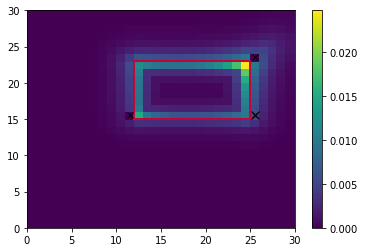

Creating TL
Done in: 5.392603158950806  sec
Memory:  [8067.20703125]
Iteration: 0  Time: 10.685618877410889  Distance: 0.997655279095  marginal-improvement: 0.00234472090503
Iteration: 1  Time: 10.709255456924438  Distance: 1.53382561705  marginal-improvement: -0.537430462391
Iteration: 2  Time: 10.680601835250854  Distance: 0.802115439418  marginal-improvement: 0.477049130942
Iteration: 3  Time: 10.702377796173096  Distance: 0.501537859888  marginal-improvement: 0.374731073308
Iteration: 4  Time: 10.665739059448242  Distance: 0.337974503646  marginal-improvement: 0.326123647532
Iteration: 5  Time: 10.729724407196045  Distance: 0.244111769885  marginal-improvement: 0.277721345096
Iteration: 6  Time: 10.671237468719482  Distance: 0.196883303977  marginal-improvement: 0.193470662762
Iteration: 7  Time: 10.738576889038086  Distance: 0.160426695973  marginal-improvement: 0.185168611396
Iteration: 8  Time: 10.644573450088501  Distance: 0.131384047547  marginal-improvement: 0.181033762804
It

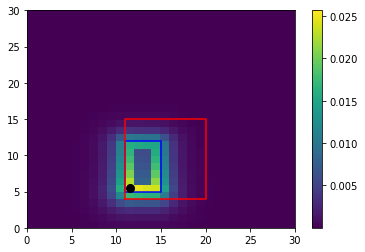

Creating TL
Done in: 1.1384823322296143  sec
Memory:  [7339.2890625]
Iteration: 0  Time: 2.5304861068725586  Distance: 0.998944826954  marginal-improvement: 0.00105517304621
Iteration: 1  Time: 2.4193975925445557  Distance: 4.93467498817  marginal-improvement: -3.93988742424
Iteration: 2  Time: 2.3997416496276855  Distance: 1.60821490108  marginal-improvement: 0.674099124069
Iteration: 3  Time: 2.4015777111053467  Distance: 0.820502360521  marginal-improvement: 0.4898055229
Iteration: 4  Time: 2.4145596027374268  Distance: 0.498432878832  marginal-improvement: 0.392527184791
Iteration: 5  Time: 2.42142653465271  Distance: 0.330649786792  marginal-improvement: 0.336621236611
Iteration: 6  Time: 2.4155356884002686  Distance: 0.231069215337  marginal-improvement: 0.301166295678
Iteration: 7  Time: 2.4191858768463135  Distance: 0.16705710735  marginal-improvement: 0.27702568641
Iteration: 8  Time: 2.4119930267333984  Distance: 0.126272238432  marginal-improvement: 0.244137286733
Iteration:

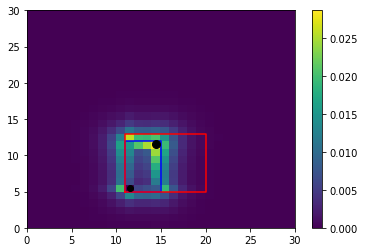

Creating TL
Done in: 0.6856474876403809  sec
Memory:  [5220.51171875]
Iteration: 0  Time: 1.4733049869537354  Distance: 0.998365349123  marginal-improvement: 0.00163465087742
Iteration: 1  Time: 1.476599931716919  Distance: 1.74607751226  marginal-improvement: -0.748936412706
Iteration: 2  Time: 1.4763996601104736  Distance: 0.630363555574  marginal-improvement: 0.63898306281
Iteration: 3  Time: 1.4727356433868408  Distance: 0.292071534088  marginal-improvement: 0.536661770013
Iteration: 4  Time: 1.4770140647888184  Distance: 0.151540452761  marginal-improvement: 0.481152953729
Iteration: 5  Time: 1.4796481132507324  Distance: 0.0833744720119  marginal-improvement: 0.449820358243
Iteration: 6  Time: 1.4709155559539795  Distance: 0.0501636274969  marginal-improvement: 0.398333491219
Iteration: 7  Time: 1.472071647644043  Distance: 0.0300344640203  marginal-improvement: 0.401270093114
Iteration: 8  Time: 1.4739458560943604  Distance: 0.0179133835198  marginal-improvement: 0.403572392445


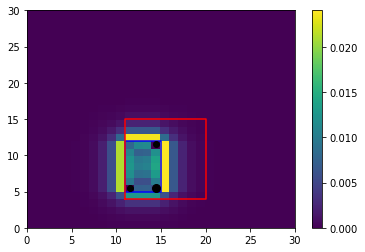

Creating TL
Done in: 0.6866490840911865  sec
Memory:  [5105.875]
Iteration: 0  Time: 1.4768874645233154  Distance: 0.99835787386  marginal-improvement: 0.00164212613989
Iteration: 1  Time: 1.4795928001403809  Distance: 1.7518381082  marginal-improvement: -0.754719579089
Iteration: 2  Time: 1.480510950088501  Distance: 0.631886533516  marginal-improvement: 0.639300840324
Iteration: 3  Time: 1.4872701168060303  Distance: 0.292718413738  marginal-improvement: 0.536754783949
Iteration: 4  Time: 1.4761300086975098  Distance: 0.151889477303  marginal-improvement: 0.481107200044
Iteration: 5  Time: 1.4754383563995361  Distance: 0.0835681770212  marginal-improvement: 0.44980930539
Iteration: 6  Time: 1.4739470481872559  Distance: 0.0502992719627  marginal-improvement: 0.398104951483
Iteration: 7  Time: 1.465574026107788  Distance: 0.0301277263878  marginal-improvement: 0.401030567397
Iteration: 8  Time: 1.4727706909179688  Distance: 0.0179764468578  marginal-improvement: 0.403325474136
Iterati

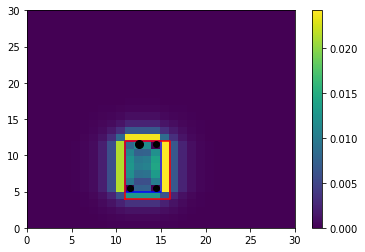

Creating TL
Done in: 0.6993775367736816  sec
Memory:  [5105.9296875]
Iteration: 0  Time: 1.485804557800293  Distance: 0.998357873845  marginal-improvement: 0.00164212615494
Iteration: 1  Time: 1.4916207790374756  Distance: 1.75647337894  marginal-improvement: -0.759362474079
Iteration: 2  Time: 1.495067834854126  Distance: 0.63232428244  marginal-improvement: 0.640003492214
Iteration: 3  Time: 1.4959537982940674  Distance: 0.292879672959  marginal-improvement: 0.536820455749
Iteration: 4  Time: 1.4990143775939941  Distance: 0.151999220676  marginal-improvement: 0.481018197198
Iteration: 5  Time: 1.4956343173980713  Distance: 0.0836756660503  marginal-improvement: 0.44949937455
Iteration: 6  Time: 1.4933018684387207  Distance: 0.0503807427453  marginal-improvement: 0.397904490954
Iteration: 7  Time: 1.4992191791534424  Distance: 0.0301862197228  marginal-improvement: 0.400838136202
Iteration: 8  Time: 1.4921834468841553  Distance: 0.0180169956045  marginal-improvement: 0.403138393281
It

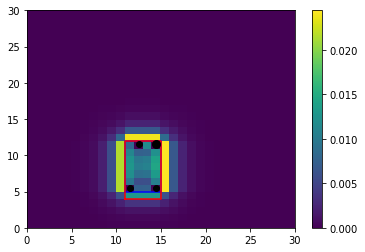

Repeated sample: Skipping the Actualization of M and TL
Non-zeros in M: 19.60896  x 10^6
Memory after updating: [4881.2578125]
###########################################
############### NEW TRIAL #################
###########################################
True hypothesis: (18, 22, 12, 24)
FALTAN: 2 Examples
Move:  1835
Selected sample: (18, 12)
Selected box: (18, 27, 11, 21)


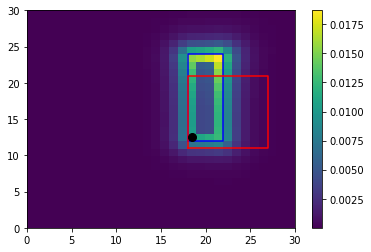

Creating TL
Done in: 1.907548189163208  sec
Memory:  [7217.0078125]
Iteration: 0  Time: 4.747473239898682  Distance: 0.998613827326  marginal-improvement: 0.00138617267432
Iteration: 1  Time: 4.012463808059692  Distance: 3.07420037202  marginal-improvement: -2.07846765977
Iteration: 2  Time: 4.016016244888306  Distance: 0.923027938064  marginal-improvement: 0.69975023539
Iteration: 3  Time: 3.9815001487731934  Distance: 0.413277702807  marginal-improvement: 0.552258728296
Iteration: 4  Time: 3.9596498012542725  Distance: 0.214940434188  marginal-improvement: 0.479912821988
Iteration: 5  Time: 4.002927780151367  Distance: 0.119872729663  marginal-improvement: 0.442297908648
Iteration: 6  Time: 4.0351715087890625  Distance: 0.0741010811049  marginal-improvement: 0.381835373956
Iteration: 7  Time: 3.9362845420837402  Distance: 0.0459241469155  marginal-improvement: 0.380249974349
Iteration: 8  Time: 3.9972944259643555  Distance: 0.0283129012242  marginal-improvement: 0.383485527204
Iterat

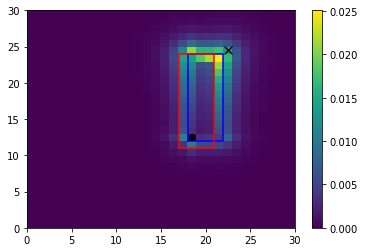

Creating TL
Done in: 1.5218489170074463  sec
Memory:  [5299.859375]
Iteration: 0  Time: 2.931472063064575  Distance: 72.5827048429  marginal-improvement: -71.5827048429
Iteration: 1  Time: 3.074031114578247  Distance: 5.43060237849  marginal-improvement: 0.925180490445
Iteration: 2  Time: 3.0015692710876465  Distance: 1.73752000956  marginal-improvement: 0.680050224919
Iteration: 3  Time: 3.0037403106689453  Distance: 0.885777946225  marginal-improvement: 0.49020561412
Iteration: 4  Time: 3.0732858180999756  Distance: 0.537841295635  marginal-improvement: 0.39280346962
Iteration: 5  Time: 3.048816680908203  Distance: 0.356423099303  marginal-improvement: 0.337308045708
Iteration: 6  Time: 3.028379201889038  Distance: 0.293439895995  marginal-improvement: 0.176709094981
Iteration: 7  Time: 3.0443267822265625  Distance: 0.243455301393  marginal-improvement: 0.170340145579
Iteration: 8  Time: 3.048642635345459  Distance: 0.202556769384  marginal-improvement: 0.167991954888
Iteration: 9  T

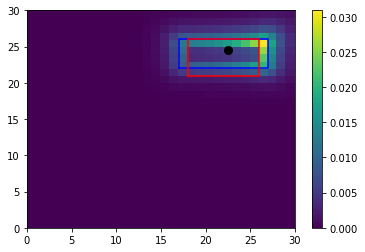

Creating TL
Done in: 1.1151139736175537  sec
Memory:  [7051.078125]
Iteration: 0  Time: 4.04332971572876  Distance: 1.10477127984  marginal-improvement: -0.104771279836
Iteration: 1  Time: 1.9119184017181396  Distance: 6.19564142597  marginal-improvement: -4.60807611408
Iteration: 2  Time: 1.9194526672363281  Distance: 2.05857972785  marginal-improvement: 0.667737432444
Iteration: 3  Time: 1.9148356914520264  Distance: 1.08034290572  marginal-improvement: 0.475199871492
Iteration: 4  Time: 1.8954493999481201  Distance: 0.675300101866  marginal-improvement: 0.374920593923
Iteration: 5  Time: 1.9082186222076416  Distance: 0.459900665151  marginal-improvement: 0.318968464716
Iteration: 6  Time: 1.9308362007141113  Distance: 0.329115076825  marginal-improvement: 0.284377906441
Iteration: 7  Time: 1.9126198291778564  Distance: 0.243105797609  marginal-improvement: 0.261334971481
Iteration: 8  Time: 1.9132871627807617  Distance: 0.183503148342  marginal-improvement: 0.245171648941
Iteration:

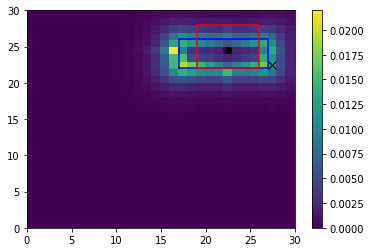

Creating TL
Done in: 0.5613579750061035  sec
Memory:  [4935.50390625]
Iteration: 0  Time: 1.2110779285430908  Distance: 3.68002093331  marginal-improvement: -2.68002093331
Iteration: 1  Time: 1.2065632343292236  Distance: 6.81934558259  marginal-improvement: -0.85307249773
Iteration: 2  Time: 1.2152559757232666  Distance: 2.31686740157  marginal-improvement: 0.660250771352
Iteration: 3  Time: 1.2098896503448486  Distance: 1.24580188233  marginal-improvement: 0.462290383347
Iteration: 4  Time: 1.2139630317687988  Distance: 0.81531436184  marginal-improvement: 0.345550545875
Iteration: 5  Time: 1.2195546627044678  Distance: 0.584132873008  marginal-improvement: 0.283548898011
Iteration: 6  Time: 1.2163288593292236  Distance: 0.441406839745  marginal-improvement: 0.244338300167
Iteration: 7  Time: 1.213135004043579  Distance: 0.338193641071  marginal-improvement: 0.233827819102
Iteration: 8  Time: 1.222320318222046  Distance: 0.262401434798  marginal-improvement: 0.224108904096
Iteration:

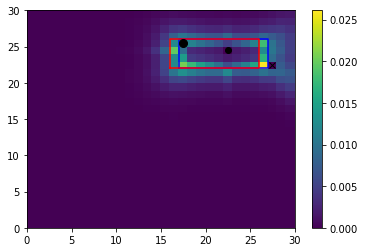

Creating TL
Done in: 0.37226033210754395  sec
Memory:  [4707.92578125]
Iteration: 0  Time: 0.7814290523529053  Distance: 0.999093707967  marginal-improvement: 0.000906292032569
Iteration: 1  Time: 0.7816390991210938  Distance: 3.75039508555  marginal-improvement: -2.75379712198
Iteration: 2  Time: 0.7750270366668701  Distance: 1.46897100137  marginal-improvement: 0.608315665988
Iteration: 3  Time: 0.7737233638763428  Distance: 0.835226199298  marginal-improvement: 0.431420907205
Iteration: 4  Time: 0.7716391086578369  Distance: 0.572608806378  marginal-improvement: 0.314426670452
Iteration: 5  Time: 0.7787163257598877  Distance: 0.409334448317  marginal-improvement: 0.285141192805
Iteration: 6  Time: 0.7763679027557373  Distance: 0.297962540035  marginal-improvement: 0.272080468038
Iteration: 7  Time: 0.7732532024383545  Distance: 0.220972671003  marginal-improvement: 0.25838774573
Iteration: 8  Time: 0.776435136795044  Distance: 0.166864466479  marginal-improvement: 0.244863784641
Ite

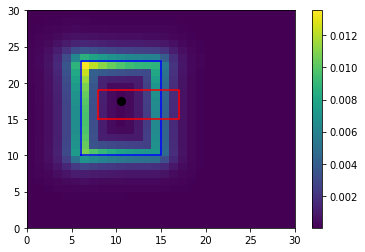

Creating TL
Done in: 2.0569324493408203  sec
Memory:  [7162.87890625]
Iteration: 0  Time: 4.909869909286499  Distance: 0.998647537306  marginal-improvement: 0.00135246269382
Iteration: 1  Time: 3.7656140327453613  Distance: 3.27002681644  marginal-improvement: -2.27445539521
Iteration: 2  Time: 3.8199217319488525  Distance: 0.992991113251  marginal-improvement: 0.696335483166
Iteration: 3  Time: 3.7822937965393066  Distance: 0.453413776419  marginal-improvement: 0.543385866833
Iteration: 4  Time: 3.7795121669769287  Distance: 0.241565062186  marginal-improvement: 0.467230431123
Iteration: 5  Time: 3.8171699047088623  Distance: 0.138471263843  marginal-improvement: 0.426774457408
Iteration: 6  Time: 3.857290744781494  Distance: 0.087154060952  marginal-improvement: 0.370598212702
Iteration: 7  Time: 3.747074604034424  Distance: 0.0559949379438  marginal-improvement: 0.357517741203
Iteration: 8  Time: 3.77885103225708  Distance: 0.0358361386155  marginal-improvement: 0.360011102227
Itera

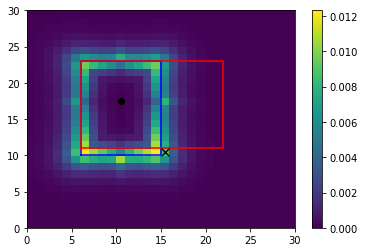

Creating TL
Done in: 0.9023077487945557  sec
Memory:  [4996.7890625]
Iteration: 0  Time: 1.9261081218719482  Distance: 13662.340241  marginal-improvement: -13661.340241
Iteration: 1  Time: 1.9155547618865967  Distance: 3.48108610713  marginal-improvement: 0.999745205723
Iteration: 2  Time: 1.9052424430847168  Distance: 1.05968912852  marginal-improvement: 0.695586637069
Iteration: 3  Time: 1.9355850219726562  Distance: 0.496534169242  marginal-improvement: 0.531434119802
Iteration: 4  Time: 1.904076337814331  Distance: 0.271991369165  marginal-improvement: 0.452220237774
Iteration: 5  Time: 1.909531593322754  Distance: 0.172868650779  marginal-improvement: 0.364433322609
Iteration: 6  Time: 1.9158895015716553  Distance: 0.11855368543  marginal-improvement: 0.314197890159
Iteration: 7  Time: 1.905482292175293  Distance: 0.0813896740797  marginal-improvement: 0.31347833022
Iteration: 8  Time: 1.9247491359710693  Distance: 0.0560913889812  marginal-improvement: 0.310829173167
Iteration: 9

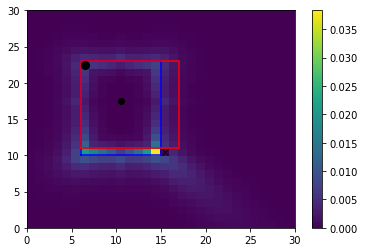

Creating TL
Done in: 0.33173346519470215  sec
Memory:  [4404.76953125]
Iteration: 0  Time: 0.7022688388824463  Distance: 3472.56020867  marginal-improvement: -3471.56020867
Iteration: 1  Time: 0.7077658176422119  Distance: 2.25677670259  marginal-improvement: 0.99935011157
Iteration: 2  Time: 0.7067835330963135  Distance: 0.754569927723  marginal-improvement: 0.665642627887
Iteration: 3  Time: 0.7055766582489014  Distance: 0.356748277231  marginal-improvement: 0.527216412788
Iteration: 4  Time: 0.7036709785461426  Distance: 0.194715229066  marginal-improvement: 0.454194339558
Iteration: 5  Time: 0.7049233913421631  Distance: 0.118248482383  marginal-improvement: 0.392710662899
Iteration: 6  Time: 0.707160234451294  Distance: 0.0801869250193  marginal-improvement: 0.321877766179
Iteration: 7  Time: 0.7025294303894043  Distance: 0.05461958654  marginal-improvement: 0.318846725613
Iteration: 8  Time: 0.7057600021362305  Distance: 0.0373710464624  marginal-improvement: 0.315794043314
Itera

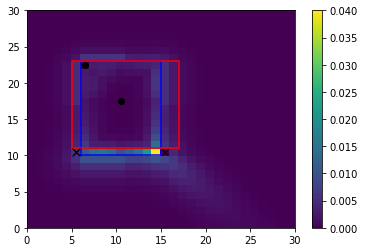

Creating TL
Done in: 0.22653746604919434  sec
Memory:  [4211.796875]
Iteration: 0  Time: 0.49811673164367676  Distance: 2516.09437559  marginal-improvement: -2515.09437559
Iteration: 1  Time: 0.5107195377349854  Distance: 9.5128411525  marginal-improvement: 0.996219203363
Iteration: 2  Time: 0.4921534061431885  Distance: 4.1159509105  marginal-improvement: 0.567326853826
Iteration: 3  Time: 0.49439501762390137  Distance: 2.56712692133  marginal-improvement: 0.376297974112
Iteration: 4  Time: 0.4925272464752197  Distance: 1.65365629291  marginal-improvement: 0.355833839313
Iteration: 5  Time: 0.49272656440734863  Distance: 1.01232706963  marginal-improvement: 0.387824982753
Iteration: 6  Time: 0.4907510280609131  Distance: 0.597367169839  marginal-improvement: 0.4099069483
Iteration: 7  Time: 0.4929542541503906  Distance: 0.525031192141  marginal-improvement: 0.121091317618
Iteration: 8  Time: 0.498781681060791  Distance: 0.487605457219  marginal-improvement: 0.0712828789658
Iteration: 

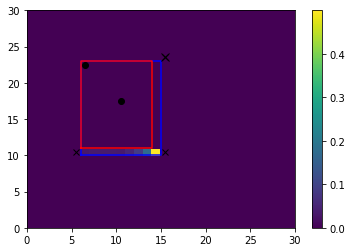

Creating TL
Done in: 0.07943010330200195  sec
Memory:  [4077.2890625]
Iteration: 0  Time: 0.17424321174621582  Distance: 11881.2514764  marginal-improvement: -11880.2514764
Iteration: 1  Time: 0.14987564086914062  Distance: 7.16641705792  marginal-improvement: 0.999396829781
Iteration: 2  Time: 0.15019989013671875  Distance: 3.15688437803  marginal-improvement: 0.559489162783
Iteration: 3  Time: 0.14930295944213867  Distance: 2.02658754166  marginal-improvement: 0.358041885928
Iteration: 4  Time: 0.15082573890686035  Distance: 1.48128799359  marginal-improvement: 0.269072782133
Iteration: 5  Time: 0.1490633487701416  Distance: 1.13761222729  marginal-improvement: 0.232011443953
Iteration: 6  Time: 0.15002059936523438  Distance: 0.922365491942  marginal-improvement: 0.189209231567
Iteration: 7  Time: 0.1491084098815918  Distance: 0.749980244107  marginal-improvement: 0.186894728111
Iteration: 8  Time: 0.14975571632385254  Distance: 0.610812189365  marginal-improvement: 0.185562294255
It

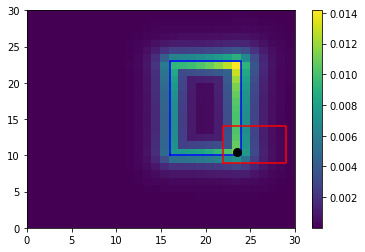

Creating TL
Done in: 1.3220477104187012  sec
Memory:  [7371.1171875]
Iteration: 0  Time: 2.8431236743927  Distance: 0.998883927955  marginal-improvement: 0.00111607204499
Iteration: 1  Time: 2.625647783279419  Distance: 4.80387045005  marginal-improvement: -3.80923790604
Iteration: 2  Time: 2.627135753631592  Distance: 1.55121361453  marginal-improvement: 0.677090872733
Iteration: 3  Time: 2.6295855045318604  Distance: 0.781871199224  marginal-improvement: 0.495961618761
Iteration: 4  Time: 2.6274683475494385  Distance: 0.467626037563  marginal-improvement: 0.401914230851
Iteration: 5  Time: 2.682802200317383  Distance: 0.304396875978  marginal-improvement: 0.349059180785
Iteration: 6  Time: 2.634361505508423  Distance: 0.208086695631  marginal-improvement: 0.316396743683
Iteration: 7  Time: 2.6260719299316406  Distance: 0.146865502157  marginal-improvement: 0.294210032452
Iteration: 8  Time: 2.622356414794922  Distance: 0.111584919885  marginal-improvement: 0.240223754073
Iteration: 9

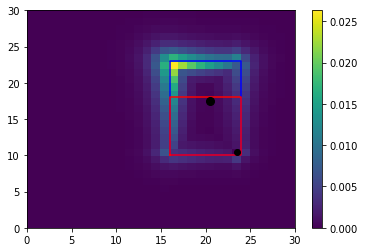

Creating TL
Done in: 0.6631202697753906  sec
Memory:  [5206.28125]
Iteration: 0  Time: 1.4163856506347656  Distance: 0.99820331276  marginal-improvement: 0.00179668724009
Iteration: 1  Time: 1.420841932296753  Distance: 1.62344627366  marginal-improvement: -0.626368348924
Iteration: 2  Time: 1.420621395111084  Distance: 0.613369279651  marginal-improvement: 0.622180733911
Iteration: 3  Time: 1.4163298606872559  Distance: 0.297074070756  marginal-improvement: 0.51566848779
Iteration: 4  Time: 1.4173567295074463  Distance: 0.162777579437  marginal-improvement: 0.452063995276
Iteration: 5  Time: 1.4170145988464355  Distance: 0.0954401688615  marginal-improvement: 0.413677429094
Iteration: 6  Time: 1.4218676090240479  Distance: 0.0608408020045  marginal-improvement: 0.362524158011
Iteration: 7  Time: 1.4268841743469238  Distance: 0.0390264967895  marginal-improvement: 0.358547298792
Iteration: 8  Time: 1.4183011054992676  Distance: 0.0251322110282  marginal-improvement: 0.356021854491
Iter

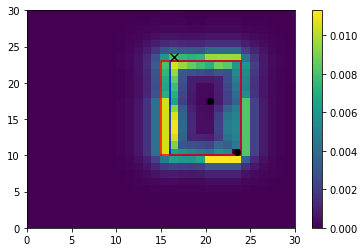

Creating TL
Done in: 0.3695065975189209  sec
Memory:  [4853.78125]
Iteration: 0  Time: 0.7836239337921143  Distance: 52.5959933082  marginal-improvement: -51.5959933082
Iteration: 1  Time: 0.7807822227478027  Distance: 1.8330751508  marginal-improvement: 0.965148007757
Iteration: 2  Time: 0.779301643371582  Distance: 0.691103072781  marginal-improvement: 0.622981593266
Iteration: 3  Time: 0.7780454158782959  Distance: 0.365587214087  marginal-improvement: 0.471009132378
Iteration: 4  Time: 0.7775797843933105  Distance: 0.224060977427  marginal-improvement: 0.387120312764
Iteration: 5  Time: 0.777580738067627  Distance: 0.153853705602  marginal-improvement: 0.313340023018
Iteration: 6  Time: 0.7776474952697754  Distance: 0.112431375009  marginal-improvement: 0.269231933229
Iteration: 7  Time: 0.7797667980194092  Distance: 0.0861410724078  marginal-improvement: 0.233834217529
Iteration: 8  Time: 0.7845792770385742  Distance: 0.0663912992645  marginal-improvement: 0.229272431736
Iteration

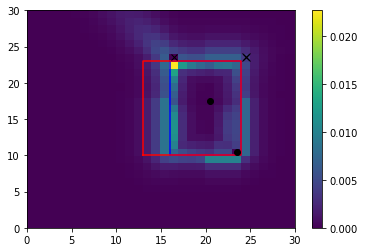

Creating TL
Done in: 0.31223320960998535  sec
Memory:  [4731.5078125]
Iteration: 0  Time: 0.651576042175293  Distance: 38.8701503794  marginal-improvement: -37.8701503794
Iteration: 1  Time: 0.6558723449707031  Distance: 3.02144683234  marginal-improvement: 0.922268198017
Iteration: 2  Time: 0.6583113670349121  Distance: 1.11707904858  marginal-improvement: 0.630283400446
Iteration: 3  Time: 0.6534583568572998  Distance: 0.552322561422  marginal-improvement: 0.505565374158
Iteration: 4  Time: 0.6521971225738525  Distance: 0.471737293191  marginal-improvement: 0.145902546556
Iteration: 5  Time: 0.657484769821167  Distance: 0.410718552087  marginal-improvement: 0.129348987212
Iteration: 6  Time: 0.6547210216522217  Distance: 0.363011644392  marginal-improvement: 0.116154742591
Iteration: 7  Time: 0.6500833034515381  Distance: 0.325127490025  marginal-improvement: 0.104360713912
Iteration: 8  Time: 0.6525568962097168  Distance: 0.294523385258  marginal-improvement: 0.094129551348
Iteratio

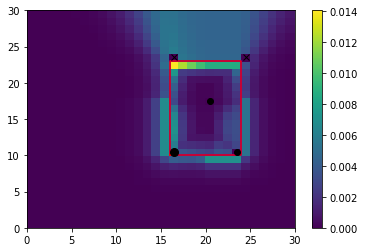

Creating TL
Done in: 0.2182331085205078  sec
Memory:  [4699.890625]
Iteration: 0  Time: 0.4700508117675781  Distance: 22.0037993365  marginal-improvement: -21.0037993365
Iteration: 1  Time: 0.47949671745300293  Distance: 1.14085811168  marginal-improvement: 0.948151767146
Iteration: 2  Time: 0.4649813175201416  Distance: 0.355379996578  marginal-improvement: 0.688497637928
Iteration: 3  Time: 0.4687538146972656  Distance: 0.150860123591  marginal-improvement: 0.575496299613
Iteration: 4  Time: 0.46280336380004883  Distance: 0.069402095616  marginal-improvement: 0.53995731964
Iteration: 5  Time: 0.4657268524169922  Distance: 0.0345677679385  marginal-improvement: 0.501920401226
Iteration: 6  Time: 0.46153688430786133  Distance: 0.0173670795067  marginal-improvement: 0.497593262672
Iteration: 7  Time: 0.46208953857421875  Distance: 0.00869903198188  marginal-improvement: 0.499107954303
Total SK iteration time: 3.7398812770843506
Non-zeros in M: 7.02575  x 10^6
Memory after updating: [459

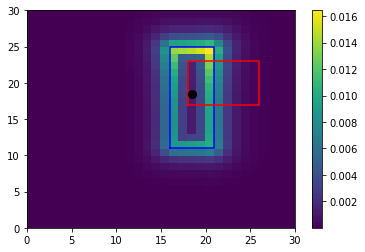

Creating TL
Done in: 1.9077353477478027  sec
Memory:  [7147.02734375]
Iteration: 0  Time: 5.148765802383423  Distance: 0.99863440353  marginal-improvement: 0.00136559647024
Iteration: 1  Time: 3.8649048805236816  Distance: 3.25869949396  marginal-improvement: -2.26315564779
Iteration: 2  Time: 3.8965485095977783  Distance: 0.987186741913  marginal-improvement: 0.69706113014
Iteration: 3  Time: 3.807669162750244  Distance: 0.448768423131  marginal-improvement: 0.545406756313
Iteration: 4  Time: 3.8920185565948486  Distance: 0.237658636084  marginal-improvement: 0.470420324082
Iteration: 5  Time: 3.8829896450042725  Distance: 0.135204723511  marginal-improvement: 0.431096947544
Iteration: 6  Time: 3.8827013969421387  Distance: 0.0843954099344  marginal-improvement: 0.375795403126
Iteration: 7  Time: 3.851278305053711  Distance: 0.0536853477874  marginal-improvement: 0.363883085239
Iteration: 8  Time: 3.8395304679870605  Distance: 0.0339681431643  marginal-improvement: 0.367273482165
Iter

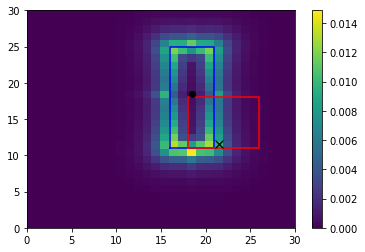

Creating TL
Done in: 0.8857250213623047  sec
Memory:  [4961.99609375]
Iteration: 0  Time: 1.8523707389831543  Distance: 1211.33034845  marginal-improvement: -1210.33034845
Iteration: 1  Time: 1.8768596649169922  Distance: 6.72367750667  marginal-improvement: 0.994449344462
Iteration: 2  Time: 1.8586399555206299  Distance: 2.29661305656  marginal-improvement: 0.658429028715
Iteration: 3  Time: 1.893970251083374  Distance: 1.27513222434  marginal-improvement: 0.444777072612
Iteration: 4  Time: 1.8744750022888184  Distance: 0.853688154902  marginal-improvement: 0.330510092518
Iteration: 5  Time: 1.8708570003509521  Distance: 0.631234003878  marginal-improvement: 0.260580107322
Iteration: 6  Time: 1.880998134613037  Distance: 0.491148428697  marginal-improvement: 0.221923366486
Iteration: 7  Time: 1.881822109222412  Distance: 0.394167233541  marginal-improvement: 0.19745801776
Iteration: 8  Time: 1.8697822093963623  Distance: 0.323089330657  marginal-improvement: 0.180324230012
Iteration: 

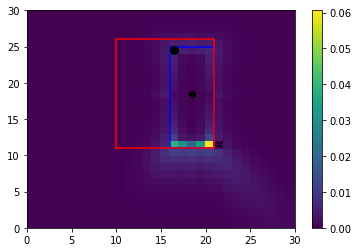

Creating TL
Done in: 0.3812258243560791  sec
Memory:  [4397.30078125]
Iteration: 0  Time: 0.8183214664459229  Distance: 325.743406403  marginal-improvement: -324.743406403
Iteration: 1  Time: 0.8073031902313232  Distance: 4.11968006399  marginal-improvement: 0.987352990166
Iteration: 2  Time: 0.8088250160217285  Distance: 1.76202125066  marginal-improvement: 0.572291725742
Iteration: 3  Time: 0.8080446720123291  Distance: 1.05884444262  marginal-improvement: 0.399073965642
Iteration: 4  Time: 0.8071396350860596  Distance: 0.741431355782  marginal-improvement: 0.299773105529
Iteration: 5  Time: 0.8064112663269043  Distance: 0.563814246147  marginal-improvement: 0.239559749192
Iteration: 6  Time: 0.8060123920440674  Distance: 0.446718313117  marginal-improvement: 0.207685303857
Iteration: 7  Time: 0.8082935810089111  Distance: 0.363032146715  marginal-improvement: 0.187335428042
Iteration: 8  Time: 0.8094890117645264  Distance: 0.300621217812  marginal-improvement: 0.17191570903
Iteratio

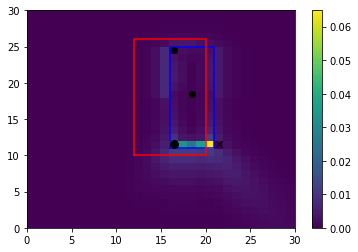

Creating TL
Done in: 0.08097314834594727  sec
Memory:  [4095.921875]
Iteration: 0  Time: 0.19184017181396484  Distance: 62.7243414643  marginal-improvement: -61.7243414643
Iteration: 1  Time: 0.1817314624786377  Distance: 1.12431589119  marginal-improvement: 0.982075285847
Iteration: 2  Time: 0.18010807037353516  Distance: 0.412079928467  marginal-improvement: 0.633483852986
Iteration: 3  Time: 0.195343017578125  Distance: 0.188258431816  marginal-improvement: 0.543150687985
Iteration: 4  Time: 0.17896223068237305  Distance: 0.0961298266242  marginal-improvement: 0.489373061822
Iteration: 5  Time: 0.20283770561218262  Distance: 0.052281034694  marginal-improvement: 0.456141381608
Iteration: 6  Time: 0.17848968505859375  Distance: 0.0303617597494  marginal-improvement: 0.419258629309
Iteration: 7  Time: 0.17798399925231934  Distance: 0.0176930313115  marginal-improvement: 0.417259359881
Iteration: 8  Time: 0.1770169734954834  Distance: 0.010333233524  marginal-improvement: 0.41597155727

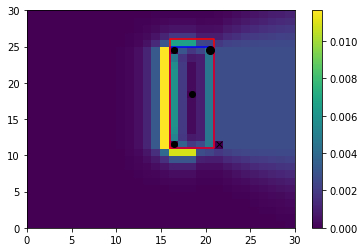

Creating TL
Done in: 0.024592161178588867  sec
Memory:  [4028.82421875]
Iteration: 0  Time: 0.056308746337890625  Distance: 24.9512335181  marginal-improvement: -23.9512335181
Iteration: 1  Time: 0.05741691589355469  Distance: 0.962246236056  marginal-improvement: 0.961434923233
Iteration: 2  Time: 0.05680108070373535  Distance: 0.382897799036  marginal-improvement: 0.602079192739
Iteration: 3  Time: 0.05591535568237305  Distance: 0.184070065683  marginal-improvement: 0.51927102703
Iteration: 4  Time: 0.0562596321105957  Distance: 0.0970980000205  marginal-improvement: 0.472494347952
Iteration: 5  Time: 0.05634188652038574  Distance: 0.0549257547864  marginal-improvement: 0.434326610488
Iteration: 6  Time: 0.05719733238220215  Distance: 0.0323286511624  marginal-improvement: 0.411411799653
Iteration: 7  Time: 0.05717825889587402  Distance: 0.0191042924046  marginal-improvement: 0.409060022064
Iteration: 8  Time: 0.056293487548828125  Distance: 0.0113268121648  marginal-improvement: 0.4

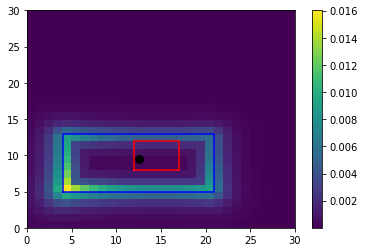

Creating TL
Done in: 1.785128116607666  sec
Memory:  [7589.84375]
Iteration: 0  Time: 3.804838180541992  Distance: 0.998687445454  marginal-improvement: 0.0013125545462
Iteration: 1  Time: 3.599543809890747  Distance: 3.48696221827  marginal-improvement: -2.49154506161
Iteration: 2  Time: 3.645789384841919  Distance: 1.07208174809  marginal-improvement: 0.692545636864
Iteration: 3  Time: 3.59299635887146  Distance: 0.499997191914  marginal-improvement: 0.533620274011
Iteration: 4  Time: 3.635340929031372  Distance: 0.273350801269  marginal-improvement: 0.453295327075
Iteration: 5  Time: 3.5953667163848877  Distance: 0.161367000448  marginal-improvement: 0.409670651417
Iteration: 6  Time: 3.6379435062408447  Distance: 0.103031497815  marginal-improvement: 0.361508254296
Iteration: 7  Time: 3.6286144256591797  Distance: 0.0687788799278  marginal-improvement: 0.332448024278
Iteration: 8  Time: 3.63893723487854  Distance: 0.0458173454241  marginal-improvement: 0.333845717287
Iteration: 9  

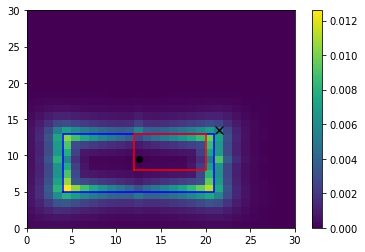

Creating TL
Done in: 0.9646997451782227  sec
Memory:  [5468.06640625]
Iteration: 0  Time: 2.033186674118042  Distance: 2269.89748554  marginal-improvement: -2268.89748554
Iteration: 1  Time: 2.0545318126678467  Distance: 3.91996090702  marginal-improvement: 0.998273066986
Iteration: 2  Time: 2.030252456665039  Distance: 1.23880518612  marginal-improvement: 0.683975117225
Iteration: 3  Time: 2.0509960651397705  Distance: 0.623974546638  marginal-improvement: 0.496309384537
Iteration: 4  Time: 2.0536651611328125  Distance: 0.374912400441  marginal-improvement: 0.399154336565
Iteration: 5  Time: 2.0489280223846436  Distance: 0.253951558044  marginal-improvement: 0.32263761416
Iteration: 6  Time: 2.059497356414795  Distance: 0.195742908177  marginal-improvement: 0.22921162727
Iteration: 7  Time: 2.065340757369995  Distance: 0.152377929502  marginal-improvement: 0.221540484296
Iteration: 8  Time: 2.04787540435791  Distance: 0.119782213034  marginal-improvement: 0.213913632866
Iteration: 9  

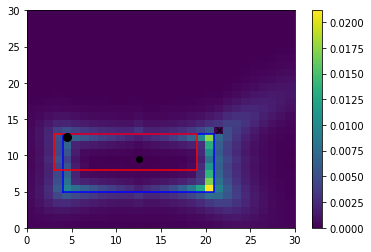

Creating TL
Done in: 0.23554587364196777  sec
Memory:  [4876.4921875]
Iteration: 0  Time: 0.5142993927001953  Distance: 356.778490023  marginal-improvement: -355.778490023
Iteration: 1  Time: 0.5309896469116211  Distance: 7.6193154572  marginal-improvement: 0.978644128864
Iteration: 2  Time: 0.5140838623046875  Distance: 3.50924750959  marginal-improvement: 0.539427455222
Iteration: 3  Time: 0.5134198665618896  Distance: 1.89336517783  marginal-improvement: 0.460464053148
Iteration: 4  Time: 0.5119287967681885  Distance: 1.22171711722  marginal-improvement: 0.354737727552
Iteration: 5  Time: 0.5106236934661865  Distance: 0.752378012674  marginal-improvement: 0.384163484271
Iteration: 6  Time: 0.5107595920562744  Distance: 0.641169690062  marginal-improvement: 0.147809107574
Iteration: 7  Time: 0.5089256763458252  Distance: 0.606356323058  marginal-improvement: 0.0542966511731
Iteration: 8  Time: 0.5086860656738281  Distance: 0.575930219001  marginal-improvement: 0.0501785879034
Iterati

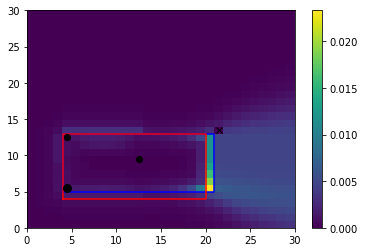

Creating TL
Done in: 0.11270308494567871  sec
Memory:  [4604.70703125]
Iteration: 0  Time: 0.2834904193878174  Distance: 289.576282757  marginal-improvement: -288.576282757
Iteration: 1  Time: 0.2958095073699951  Distance: 5.59918913104  marginal-improvement: 0.980664199852
Iteration: 2  Time: 0.282045841217041  Distance: 3.03782790113  marginal-improvement: 0.457452172086
Iteration: 3  Time: 0.2822754383087158  Distance: 2.02154525092  marginal-improvement: 0.334542536078
Iteration: 4  Time: 0.28319740295410156  Distance: 1.29424451533  marginal-improvement: 0.359774650237
Iteration: 5  Time: 0.29226136207580566  Distance: 0.772075331878  marginal-improvement: 0.403454816511
Iteration: 6  Time: 0.282869815826416  Distance: 0.59435848934  marginal-improvement: 0.230180702841
Iteration: 7  Time: 0.28729820251464844  Distance: 0.557337679386  marginal-improvement: 0.0622870045908
Iteration: 8  Time: 0.28499650955200195  Distance: 0.525683329186  marginal-improvement: 0.0567956400059
Iter

In [ ]:
# RUN SK ITERATION PROCESS ON THE DATA

Move_Id_Repeated_sample=[] 
Exceptions=[]

pairs_done=-1

[TL_start,relative_distance,converged]=get_TL_sparse(M_start)

for i_pair in Pair_idx:
    pairs_done+=1
    print(pairs_done)
    
    d=Data_discretized[i_pair]
    
    for trial in d['Trials']:
        
        flag=False
        for e in trial['Examples']:
            if 'P_teacher' not in e.keys():
                flag=True
        
        if flag:          
        
            M=M_start.copy()
            TL=TL_start.copy()

            Teachers_entropy=[]
            Sample_information=[]
            CI_reducing_H=[]
            CI=[]

            Learners_entropy=[]
            Guess_information=[]


            samples=[]
            circle=[]

            h_idx=H_space.index(tuple(trial['Teachers_box']))

            print('###########################################')
            print('############### NEW TRIAL #################')
            print('###########################################')


            print('True hypothesis:',tuple(trial['Teachers_box']))

            for j in range(len(trial['Examples'])):

                try:            
                    e=trial['Examples'][j]
                    print('FALTAN:',len(trial['Examples'])-j, 'Examples')                                   
                    print('Move: ', e['move_Id'])

                    sample=tuple([e['x'],e['y']])
                    sample_idx=Examples.index(sample)

                    samples.append(sample)

                    print('Selected sample:',sample)


                    if e['inside']=='false':
                        sample_idx+=grid_size**2
                        circle.append(False)
                    else:
                        circle.append(True)

                    Teachers_entropy.append(-np.sum(np.multiply(TL[:,h_idx].data,np.log(TL[:,h_idx].data))))
                    Sample_information.append(-np.log(TL[sample_idx,h_idx]))

                    box=tuple(trial['Learners_guess'][j]['box'])
                    box_idx=H_space.index(box)

                    print('Selected box:',box)                                                            
                    
                    #P_learner=normalize(TL[sample_idx,:],norm='l1')

                    L=normalize(TL,norm='l1',axis=1)                               
                    P_learner=L[sample_idx,:];                
                    ci=(TL.multiply(L)).sum()
                    L=[]
                    
                    CI.append(ci/len(H_space))
                    CI_reducing_H.append(ci/(len(H_space)-j-1))

                    # SAVE DISTRIBUTIONS
                    e['P_teacher']=TL[:,h_idx]
                    trial['Learners_guess'][j]['P_learner']=P_learner
                    

                    Learners_entropy.append( -np.sum(np.multiply(P_learner.data,np.log(P_learner.data))) )
                    Guess_information.append(-np.log(P_learner[0,box_idx]))

                    plot_trial(H_space[h_idx],samples,circle,grid_size,probability_map=np.array(TL[:,h_idx].todense().reshape([len(Examples)*2,1])),last_guess=H_space[box_idx])                     

                    if any(M[sample_idx,:].data): 
                        M=M.multiply(sparse.csr_matrix(np.ones([M.shape[0],1])) * M[sample_idx,:].astype(bool))                        
                        M[sample_idx,:]=0
                        M[:,box_idx]=0
                        M.eliminate_zeros()
                        [TL,relative_distance,converged]=get_TL_sparse(M)
                    else:                
                        print('Repeated sample: Skipping the Actualization of M and TL')
                        Move_Id_Repeated_sample.append(e['move_Id'])
                        save_obj(Move_Id_Repeated_sample,'Move_Id_Repeated_sample')
                        
                    print('Non-zeros in M:',len(M.data)/1000000,' x 10^6')

                    e['SK-convergence']=[converged,relative_distance]

                    print('Memory after updating:',mprof.memory_usage())
                except:
                    Exceptions.append(e['move_Id'])
                    save_obj(Exceptions,'Exceptions_move_id')
                    pass

            trial['Teachers_entropy']=Teachers_entropy
            trial['Sample_information']=Sample_information
            trial['Learners_entropy']=Learners_entropy
            trial['Guess_information']=Guess_information
            trial['CI']=CI
            trial['CI_reducing_H']=CI_reducing_H

            save_obj(Data_discretized,'../Model_results/partial_SK_Data_discretized_smooth_exp_1')

save_obj(Data_discretized,'../Model_results/Total_SK_Data_discretized_smooth_exp_1')


In [ ]:
m=0
for i_pair in Pair_idx:
    
    d=Data_discretized[i_pair]
    
    for trial in d['Trials']:
        
        flag=False
        for e in trial['Examples']:
            if 'P_teacher' not in e.keys():
                m+=1
                print('Missing proba in: ',e['move_Id'], 'of',d['Teachers_Id'])

In [ ]:
np.log(np.e)

In [ ]:



i=-1
for d in Data_discretized:
    levels.append(d['Level'])
    i+=1
    if d['Level']==2:
        l2.append(i)
    elif d['Level']==4:
        l4.append(i)
    elif d['Level']==6:
        l6.append(i)    
        
        
        

In [ ]:
trial

In [ ]:
l2

In [ ]:
last_relative_distance=1


for k in range(3):
    TL0=TL.data;        

    TL=normalize(TL,norm='l1',axis=1)                                       
    TL=normalize(TL,norm='l1',axis=0)

    relative_distance=np.max(np.abs((TL.data-TL0)/TL0))

    marginal_improvement=(last_relative_distance-relative_distance)/last_relative_distance

    t1=time.time()
    print('Iteration:',k,' Time:',t1-t0,' Distance:',relative_distance,' marginal-improvement:',marginal_improvement )        

    last_relative_distance=relative_distance





In [ ]:
level=6

for d in [Data_discretized[0]]:
    if d['Level']==level:                        
        for trial in d['Trials']:
            
            Teachers_entropy=trial['Teachers_entropy']
            Sample_information=trial['Sample_information']

            Learners_entropy=trial['Learners_entropy']
            Guess_information=trial['Guess_information']
                        
            samples=[]
            circle=[]
            
            h_idx=H_space.index(tuple(trial['Teachers_box']))
            
            print('True hypothesis:',trial['Teachers_box'])
                        
            print('----------- NEW TRIAL ---------------')           
            
            plt.clf()
            plt.figure()
            plt.plot(Teachers_entropy,'-o')
            plt.xlabel('Move')
            plt.ylabel('Teachers Entropy H[P(s|h*)_t]')
            plt.show()
            
            plt.clf()
            plt.figure()
            plt.plot(Sample_information,'-o')
            plt.xlabel('Move')
            plt.ylabel('-log P(s*|h*)_t : sample information')
            plt.show()
                
            plt.clf()
            plt.figure()
            plt.plot(Learners_entropy,'-o')
            plt.xlabel('Move')
            plt.ylabel('Learners Entropy H[P(h|s*)_l]')
            plt.show()
            
            plt.clf()
            plt.figure()
            plt.plot(Guess_information,'-o')
            plt.xlabel('Move')
            plt.ylabel('-log P(h*|s*)_l : guess information')
            plt.show()
                
                



In [ ]:

W=[[],[]]
H=[[],[]]

W_True=[]
H_True=[]


move_Id=-1
for d in Data_discretized:
    for t in d['Trials']:
        true_box=t['Teachers_box']
        W_True.append(true_box[1]-true_box[0])
        H_True.append(true_box[3]-true_box[2])
        
        for e in t['Examples']:
            move_Id+=1
            e['move_Id']=move_Id
        
        for guess in t['Learners_guess']:
            box=guess['box']
            W[0].append(box[1]-box[0])
            H[0].append(box[3]-box[2])
            
            W[1].append(d['Level'])
            H[1].append(d['Level'])
            
            
        

In [ ]:

P_consistency=[[],[],[]];

for d in Data:
    if d['Level']==2:
        n_guesses=0
        p_consistency=0
        for trial in d['Trials']:
            for guess in trial['Learners_guess']:
                n_guesses+=1
                if guess['consistency']:
                    p_consistency+=1
        p_consistency=p_consistency/n_guesses
        P_consistency[0].append(p_consistency)
        
    elif d['Level']==4:
        n_guesses=0
        p_consistency=0
        for trial in d['Trials']:
            for guess in trial['Learners_guess']:
                n_guesses+=1
                if guess['consistency']:
                    p_consistency+=1
        p_consistency=p_consistency/n_guesses
        P_consistency[1].append(p_consistency)        
        
    if d['Level']==6:
        n_guesses=0
        p_consistency=0
        for trial in d['Trials']:
            for guess in trial['Learners_guess']:
                n_guesses+=1
                if guess['consistency']:
                    p_consistency+=1
        p_consistency=p_consistency/n_guesses
        P_consistency[2].append(p_consistency)        
        
        
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.clf()   
fig = plt.figure()
plt.hist(P_consistency[0],color='k');
plt.xlim([0,1])
plt.ylim([0,15])
#plt.title('2nd grade',fontsize=25)
#plt.xlabel('Performance')
#plt.ylabel('N')
plt.show();
fig.savefig('learners_consistency_2.png')

fig = plt.figure()
plt.hist(P_consistency[1],color='k');
plt.xlim([0,1])
plt.ylim([0,15])
#plt.title('4th grade',fontsize=25)
#plt.xlabel('Performance')
#plt.ylabel('N')
plt.show();
fig.savefig('learners_consistency_4.png')

fig = plt.figure()
plt.hist(P_consistency[2],color='k');
plt.xlim([0,1])
plt.ylim([0,15])
#plt.title('6th grade',fontsize=25)
#plt.xlabel('Performance',fontsize=20)
#plt.ylabel('N')
plt.show();
fig.savefig('learners_consistency_6.png')    

In [ ]:
# Effective size of the board
min_x=np.Inf
max_x=0
min_y=np.Inf
max_y=0
n_e=0
n_zero_w=0
n_zero_h=0

min_w=np.Inf
min_h=np.Inf
width=[]
height=[]
width_true_box=[]
height_true_box=[]


min_dist=[]
dists=[]


for d in Data:
    for t in d['Trials']:
        md=np.Inf        
        for ie in range(0,len(t['Examples'])-1):
            x1=t['Examples'][ie]['x']
            y1=t['Examples'][ie]['y']
            for je in range(ie+1,len(t['Examples'])):
                x2=t['Examples'][je]['x']
                y2=t['Examples'][je]['y']
                dists.append(np.sqrt((x1-x2)**2+(y1-y2)**2))
                md=min(md,dists[-1])
        if md<np.Inf:        
            min_dist.append(md)        
        
        for e in t['Examples']:
            min_x=min(min_x,e['x'])
            max_x=max(max_x,e['x'])
            min_y=min(min_y,e['y'])
            max_y=max(max_y,e['y'])
            
        width_true_box.append(t['Teachers_box'][1]-t['Teachers_box'][0])
        height_true_box.append(t['Teachers_box'][3]-t['Teachers_box'][2])
                        
        for lg in t['Learners_guess']:
            
            if lg['box'][0]>-1:
                width.append(lg['box'][1]-lg['box'][0])
                height.append(lg['box'][3]-lg['box'][2])
                
                if (lg['box'][1]-lg['box'][0])>0:
                    min_w=min(min_w,lg['box'][1]-lg['box'][0])
                else:
                    n_zero_w+=1
                if (lg['box'][3]-lg['box'][2])>0:                    
                    min_h=min(min_h,lg['box'][3]-lg['box'][2])
                else:
                    n_zero_h+=1
                
                min_x=min(min_x,lg['box'][0])
                max_x=max(max_x,lg['box'][1])
                min_y=min(min_y,lg['box'][2])
                max_y=max(max_y,lg['box'][3])
            if lg['box'][0]==-1:
                n_e+=1

In [ ]:
print(min_w,min_h)
print(n_zero_w,n_zero_h)

plt.hist(min_dist,bins=200)
plt.title('examples min dist')
plt.show()

plt.hist(dists,bins=200)
plt.title('examples all dists')
plt.show()

plt.hist(width,bins=200)
plt.title('boxes widths')
plt.show()

plt.hist(height,bins=200)
plt.title('boxes heights')
plt.show()

          

plt.hist(np.sort(width_true_box),bins=50)
plt.title('width true box')
plt.show()




In [ ]:
for i in range(4):
    print(i)
    try:
        i/0
    except:
        print('passing')
        pass

In [ ]:
p_win=[];
n_trials=[[],[],[]];
n_pairs=np.zeros(3);
n_females=np.zeros(3);
p_win=[[],[],[]];

mean_inner=np.zeros([3,3,3]);
mean_outer=np.zeros([3,4,4]);

for d in Data: # There is one trial with coordinates out of canvas_size. remove it.        
    inner_bins, outer_bins= individual_histogram(d)
    
    if sum(sum(inner_bins)) >0:
        inner_bins=inner_bins/sum(sum(inner_bins));
    if sum(sum(outer_bins)) >0:
        outer_bins=outer_bins/sum(sum(outer_bins));    
    
    if d['Level']==2:                
        
        n_pairs[0]+=1;
        n_trials[0].append(len(d['Trials']));        
        p_win[0].append(get_p_win(d['Trials']))
        if d['Teachers_gender']=='F' and d['Learners_gender']=='F':
            n_females[0]+=1;
        if d['Teachers_gender']!= d['Learners_gender']:
            print('Gender missmatch')
                        
        mean_inner[0,:,:]+=inner_bins;
        mean_outer[0,:,:]+=outer_bins;                        
            
    elif d['Level']==4:

        n_pairs[1]+=1;
        n_trials[1].append(len(d['Trials']));
        p_win[1].append(get_p_win(d['Trials']))
        if d['Teachers_gender']=='F' and d['Learners_gender']=='F':
            n_females[1]+=1;
        if d['Teachers_gender']!= d['Learners_gender']:
            print('Gender missmatch')
            
        mean_inner[1,:,:]+=inner_bins;
        mean_outer[1,:,:]+=outer_bins;                            
            
    elif d['Level']==6:    
        
        mean_inner[2,:,:]+=inner_bins;
        mean_outer[2,:,:]+=outer_bins;                
        
        n_pairs[2]+=1    
        n_trials[2].append(len(d['Trials']));
        p_win[2].append(get_p_win(d['Trials']))
        if d['Teachers_gender']=='F' and d['Learners_gender']=='F':
            n_females[2]+=1;
        if d['Teachers_gender']!= d['Learners_gender']:
            print('Gender missmatch')        
    else:
        print('Strange level')
        break



print('2nd')        
plot_inner_histo(np.squeeze(mean_inner[0,:,:])/n_pairs[0])    ;
plot_outer_histo(np.squeeze(mean_outer[0,:,:])/n_pairs[0])  


print('4th')        
plot_inner_histo(np.squeeze(mean_inner[1,:,:])/n_pairs[1])    
plot_outer_histo(np.squeeze(mean_outer[1,:,:])/n_pairs[1])        

print('6th')        
plot_inner_histo(np.squeeze(mean_inner[2,:,:])/n_pairs[2])    
plot_outer_histo(np.squeeze(mean_outer[2,:,:])/n_pairs[2])        

   
print('Number of couples in 2nd, 4th and 6th grade:')
print(n_pairs)
print('Number of female couples:')
print(n_females)
print('Mean number of trials completed by each grade:')
print(np.mean(n_trials[0]),np.mean(n_trials[1]),np.mean(n_trials[2]))
print('Mean fraction of won trials by each grade:')
print(np.mean(p_win[0]),np.mean(p_win[1]),np.mean(p_win[2]))

#print('########################################################')
        #w=0;        
        #for t in d['Trials']:
        #    if t['won']:
        #        w+=1;
        #p_win.append(w/len(d['Trials']));
        
            #plot_examples(t)

            
'''
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.clf()   
fig = plt.figure()
plt.hist(p_win[0],color='k');
plt.xlim([0,1])
plt.ylim([0,8])
#plt.title('2nd grade',fontsize=25)
#plt.xlabel('Performance')
#plt.ylabel('N')
plt.show();
fig.savefig('performance_2.png')

fig = plt.figure()
plt.hist(p_win[1],color='k');
plt.xlim([0,1])
plt.ylim([0,8])
#plt.title('4th grade',fontsize=25)
#plt.xlabel('Performance')
#plt.ylabel('N')
plt.show();
fig.savefig('performance_4.png')

fig = plt.figure()
plt.hist(p_win[2],color='k');
plt.xlim([0,1])
plt.ylim([0,8])
#plt.title('6th grade',fontsize=25)
#plt.xlabel('Performance',fontsize=20)
#plt.ylabel('N')
plt.show();
fig.savefig('performance_6.png')
'''            




    